# Projet 7 - Implémentez un modèle de scoring
# Notebook de modélisation des données - imbalanced

# <a name="C0">SOMMAIRE</a>


## Partie 1 : Prétraitement
### <a href="#C1">1. Set up Environnement</a>
### <a href="#C2">2. Exploration des données</a>
### <a href="#C3">3. Feature Engineering </a>

## Partie 2 : Modélisation


# Les données & Source

Source : [Home Credit](http://www.homecredit.net/about-us.aspx)

Def CREDIT : A credit is a more adaptable type of financing that allows you to access the amount of money loaned based on your needs at any given time. The credit establishes a maximum amount of money that the customer may use in part or in full.
Def LOAN : A loan is a financial product that allows a user to obtain a fixed amount of money at the start of the transaction on the condition that this amount, plus the agreed-upon interest, be returned within a specified time frame. The loan must be repaid in monthly installments.

7 différents fichiers :

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

This diagram shows how all of the data is related:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

### Ce qu'il faut faire : Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- prétraitement
- test de différents modèles
- recherche d'hyperparamètres avec grid search CV
- utiliser ML Flow UI pour tracker les résultats et les exp
- utiliser les metrics AUC ROC, recall et f1-score





## TRACKING ML FLOW UI
dans cygwin :  cd "/cygdrive/c/Users/Me/Documents/1- DATA SCIENCE/Projet 7/"
puis : mlflow ui
dans navigateur : http://127.0.0.1:5000

# - - - - - - - PARTIE 1 : PRETRAITEMENT - - - - - - - -

# <a name="C1">1. Set up environnement</a>
<a href="#C0">SOMMAIRE</a>

### Imports des librairies

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

#tracking results
import mlflow
import mlflow.sklearn

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Import des données

In [2]:
print(os.listdir("Source/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
#chargement des données d'entraînement
data = pd.read_csv('Source/application_train.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


# <a name="C2">2. Exploration des données</a>
<a href="#C0">SOMMAIRE</a>

### Répartition des classes pour la détection de faillite bancaire

In [5]:
(round(data['TARGET'].value_counts() / len(data) * 100,2)).astype(str) + '%'

0    91.93%
1     8.07%
Name: TARGET, dtype: object

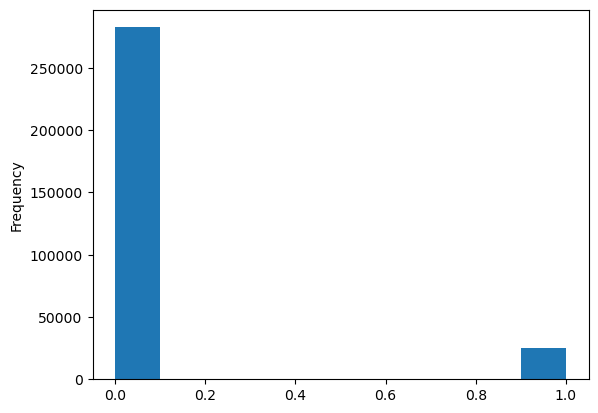

In [6]:
data['TARGET'].astype(int).plot.hist();

Il y a environ 8 % de faillite dans les données d'entraînement. Il faudra faire attention pour l'apprentissage des modèles complexes à l'"imbalanced problem" des classes du jeu de données.

### Est ce qu'il y a des données manquantes ?

In [7]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
# Missing values statistics
missing_values = missing_values_table(data)
missing_values.head(10)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4

In [9]:
missing_values.tail(10)

Missing Values  % of Total Values
NAME_TYPE_SUITE                     1292                0.4
DEF_30_CNT_SOCIAL_CIRCLE            1021                0.3
OBS_60_CNT_SOCIAL_CIRCLE            1021                0.3
DEF_60_CNT_SOCIAL_CIRCLE            1021                0.3
OBS_30_CNT_SOCIAL_CIRCLE            1021                0.3
EXT_SOURCE_2                         660                0.2
AMT_GOODS_PRICE                      278                0.1
AMT_ANNUITY                           12                0.0
CNT_FAM_MEMBERS                        2                0.0
DAYS_LAST_PHONE_CHANGE                 1                0.0

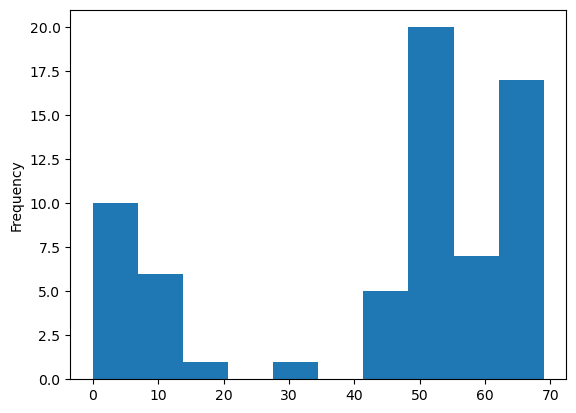

In [10]:
missing_values['% of Total Values'].astype(int).plot.hist();

Il y a pas mal de données manquantes, on ne peut pas ignorer toutes ces variables, ou toutes ces lignes donc nous allons les conserver.
### Types de variables

In [11]:
# Number of each type of column
data.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [12]:
# Number of unique classes in each object column
data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [13]:
data.EMERGENCYSTATE_MODE.unique()

array(['No', nan, 'Yes'], dtype=object)

### Variables catégorielles
- Label Encoder pour les variables catégorielles à 2 catégories
- One Hot Encoding pour les variables catégorielles à plus de 2 catégories pour que le modèle ne mésinterprète pas les poids associés par un label encoder arbitraire.


In [14]:
#copie de data pour ne pas perdre les données
data_init=data.copy()

In [15]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if data[col].nunique() <= 2:
            # Train on the training data
            le.fit(data[col])
            # Transform data
            data[col] = le.transform(data[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
            #print name of column
            print(col+' has been encoded.')
            
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE has been encoded.
FLAG_OWN_CAR has been encoded.
FLAG_OWN_REALTY has been encoded.
EMERGENCYSTATE_MODE has been encoded.
4 columns were label encoded.


In [16]:
# one-hot encoding of categorical variables
data = pd.get_dummies(data)

print('Data Features shape: ', data.shape)


Data Features shape:  (307511, 242)


## Anomalies ?

In [17]:
datadescr = data.describe()
datadescr.columns[datadescr.loc['min'] < 0]

Index(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')

In [18]:
(data['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [19]:
(data['DAYS_EMPLOYED']/365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

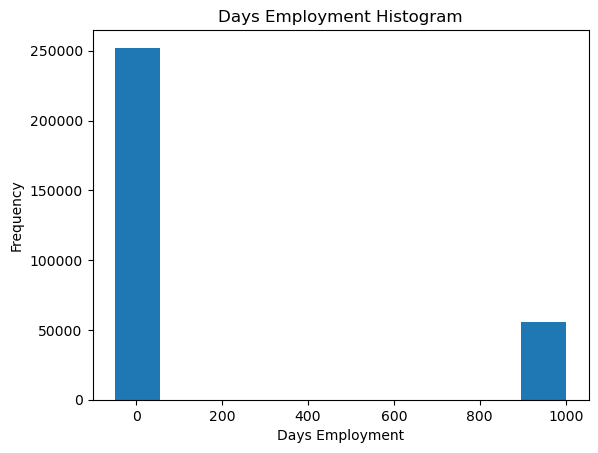

In [20]:
(data['DAYS_EMPLOYED']/365).plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [21]:
anom = data[data['DAYS_EMPLOYED'] == 365243]
non_anom = data[data['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous rows for days of employment' % len(anom))
print("%0.2f%% des données sont concernées par l'anomalie" % (len(anom)/len(data)*100))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous rows for days of employment
18.01% des données sont concernées par l'anomalie


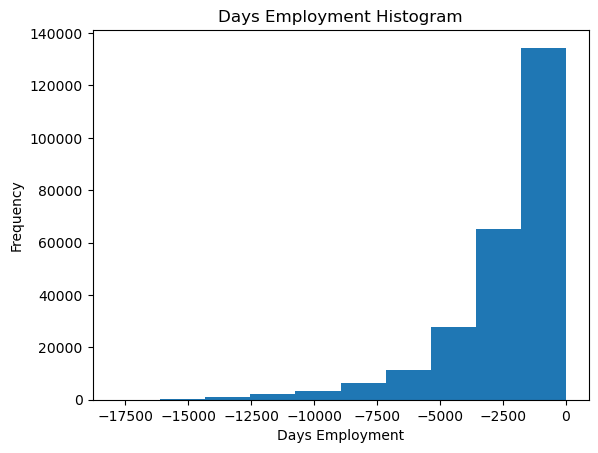

In [22]:
# Create an anomalous flag column
data['DAYS_EMPLOYED_ANOM'] = data["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

## Corrélations

 Pearson correlation coefficient interpretation :

    .00-.19 “very weak”
    .20-.39 “weak”
    .40-.59 “moderate”
    .60-.79 “strong”
    .80-1.0 “very strong”


In [23]:
# Find correlations with the target and sort
correlations = data.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

### Effet de l'âge

In [24]:
# Find the correlation of the positive days since birth and target
data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])
data['DAYS_BIRTH'].corr(data['TARGET'])

-0.07823930830982709

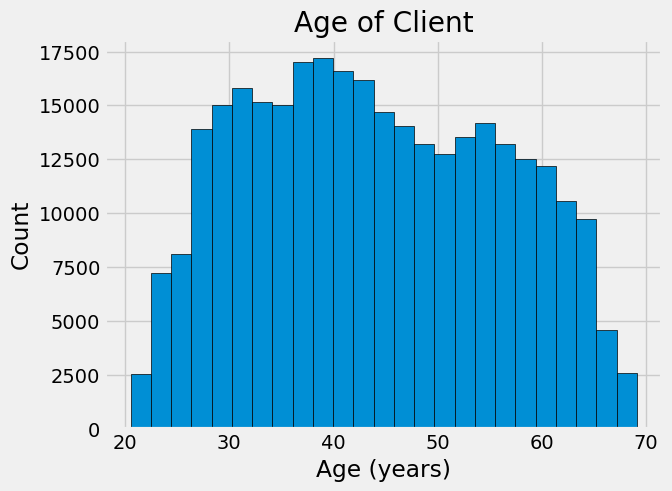

In [25]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(data['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

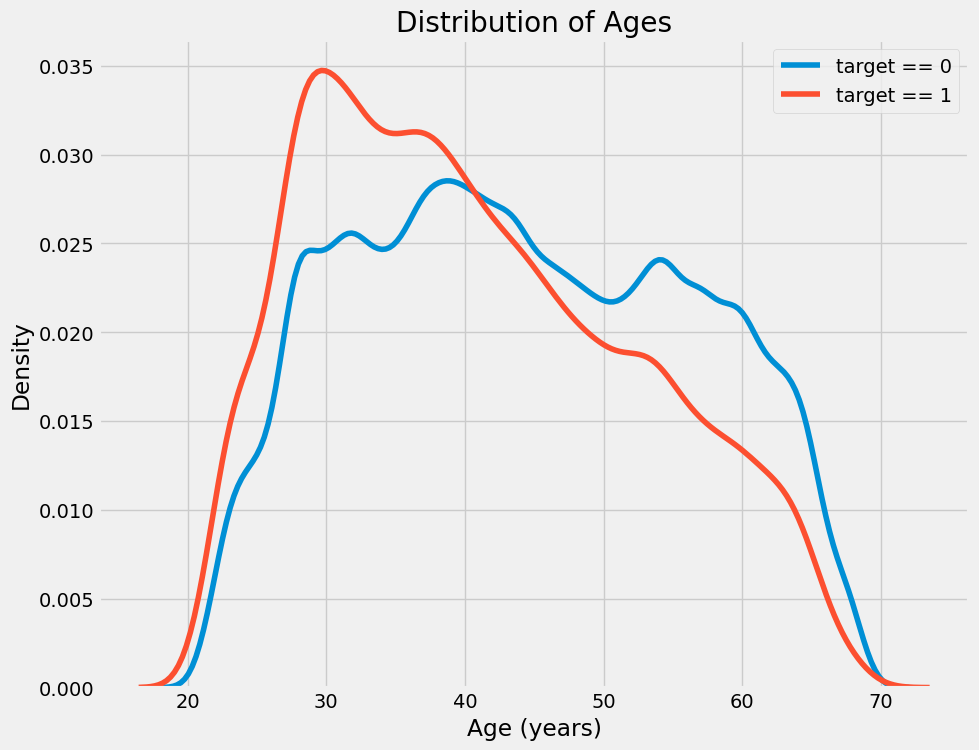

In [26]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(data.loc[data['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data.loc[data['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');
plt.legend()

In [27]:
# Age information into a separate dataframe
age_data = data[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [28]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

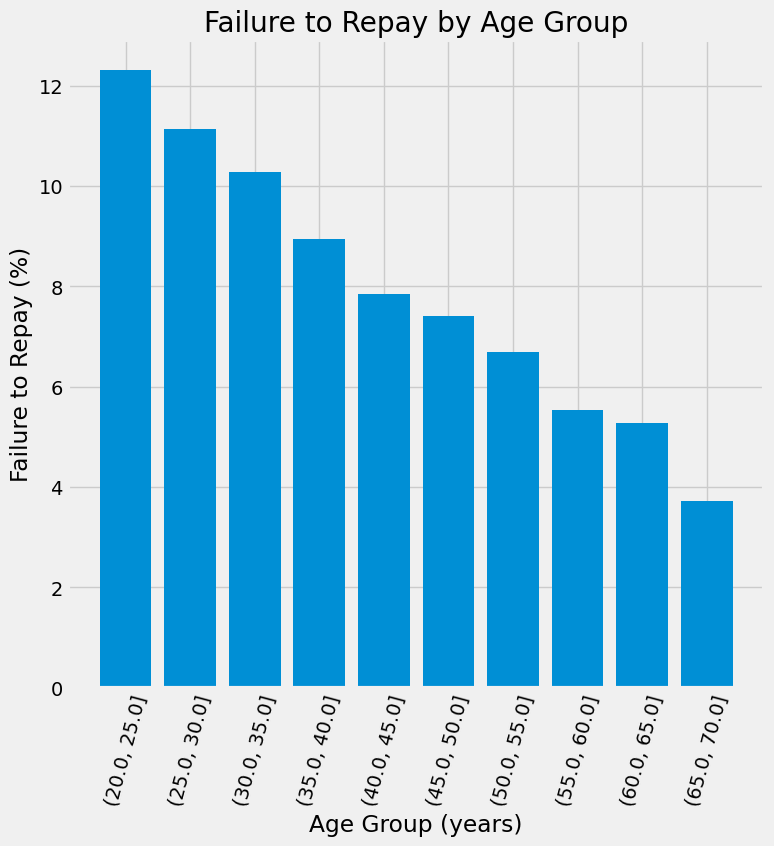

In [29]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

On remarque que plus les clients sont jeunes plus ils ont tendance à ne pas remboourser leur emprunt (10 % de faillite bancaire chez les plus jeune VS moins de 4% pour les plus âgés avec une diminution croissante.

### Exterior Sources (EXT_SOURCE)

In [30]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = data[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

On remarque que les 3 sources extérieures de notation ont une corrélation négative avec la target, c'est à dire que plus la notation est bonne par la source, plus le remboursement est fiable. La corrélation avec days birth montre que cette variable entre en compte dans le calcul.

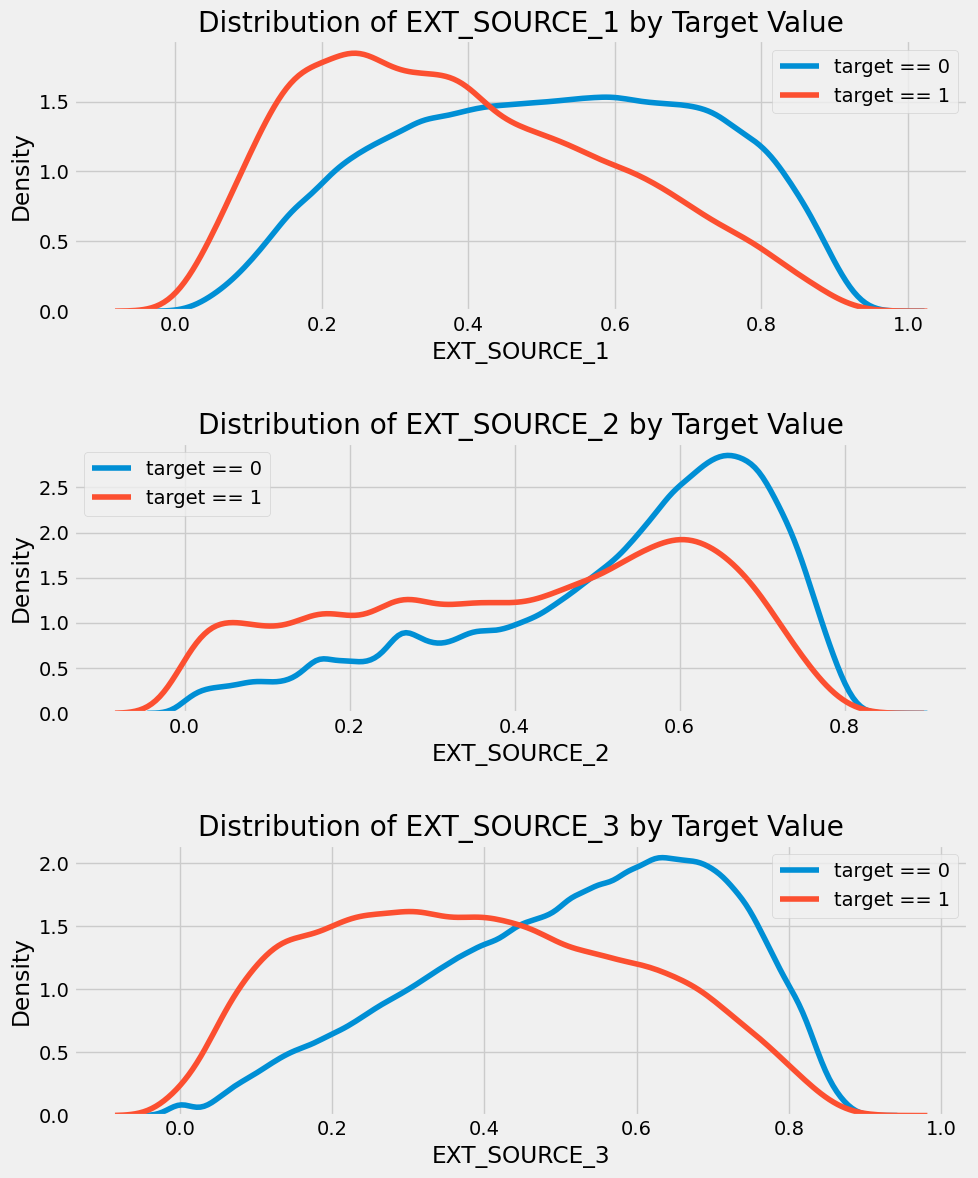

In [31]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(data.loc[data['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(data.loc[data['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)
    

La variable EXT_SOURCE_3 est celle qui représente le plus une différence entre les target 0 et 1, elle sera donc utile pour un modèle de machine learning.

## Pairs Plot

In [32]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:10000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
#grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    #hue = 'TARGET', 
                    #vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
#grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
#grid.map_diag(sns.kdeplot)

# Bottom is density plot
#grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

#plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

# <a name="C3">3. Feature Engineering </a>
<a href="#C0">SOMMAIRE</a>

## Polynomial Features

In [33]:
# Make a new dataframe for polynomial features
poly_features = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [34]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [35]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [36]:
#regardons si les nouvelles features crées sont corrélées avec la target
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


On créer un nouveau dataframe avec les poly features dedans afin de pouvoir tester plus tard lequel est le mieux pour du ML.

In [37]:
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = data['SK_ID_CURR']
data_poly = data.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Print out the new shapes
print('Data with polynomial features shape: ', data_poly.shape)
print('Data without polynomial features shape: ', data.shape)

Data with polynomial features shape:  (307511, 279)
Data without polynomial features shape:  (307511, 243)


## Domain Knowledge Features

five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

In [38]:
data_domain = data.copy()

data_domain['CREDIT_INCOME_PERCENT'] = data_domain['AMT_CREDIT'] / data_domain['AMT_INCOME_TOTAL']
data_domain['ANNUITY_INCOME_PERCENT'] = data_domain['AMT_ANNUITY'] / data_domain['AMT_INCOME_TOTAL']
data_domain['CREDIT_TERM'] = data_domain['AMT_ANNUITY'] / data_domain['AMT_CREDIT']
data_domain['DAYS_EMPLOYED_PERCENT'] = data_domain['DAYS_EMPLOYED'] / data_domain['DAYS_BIRTH']

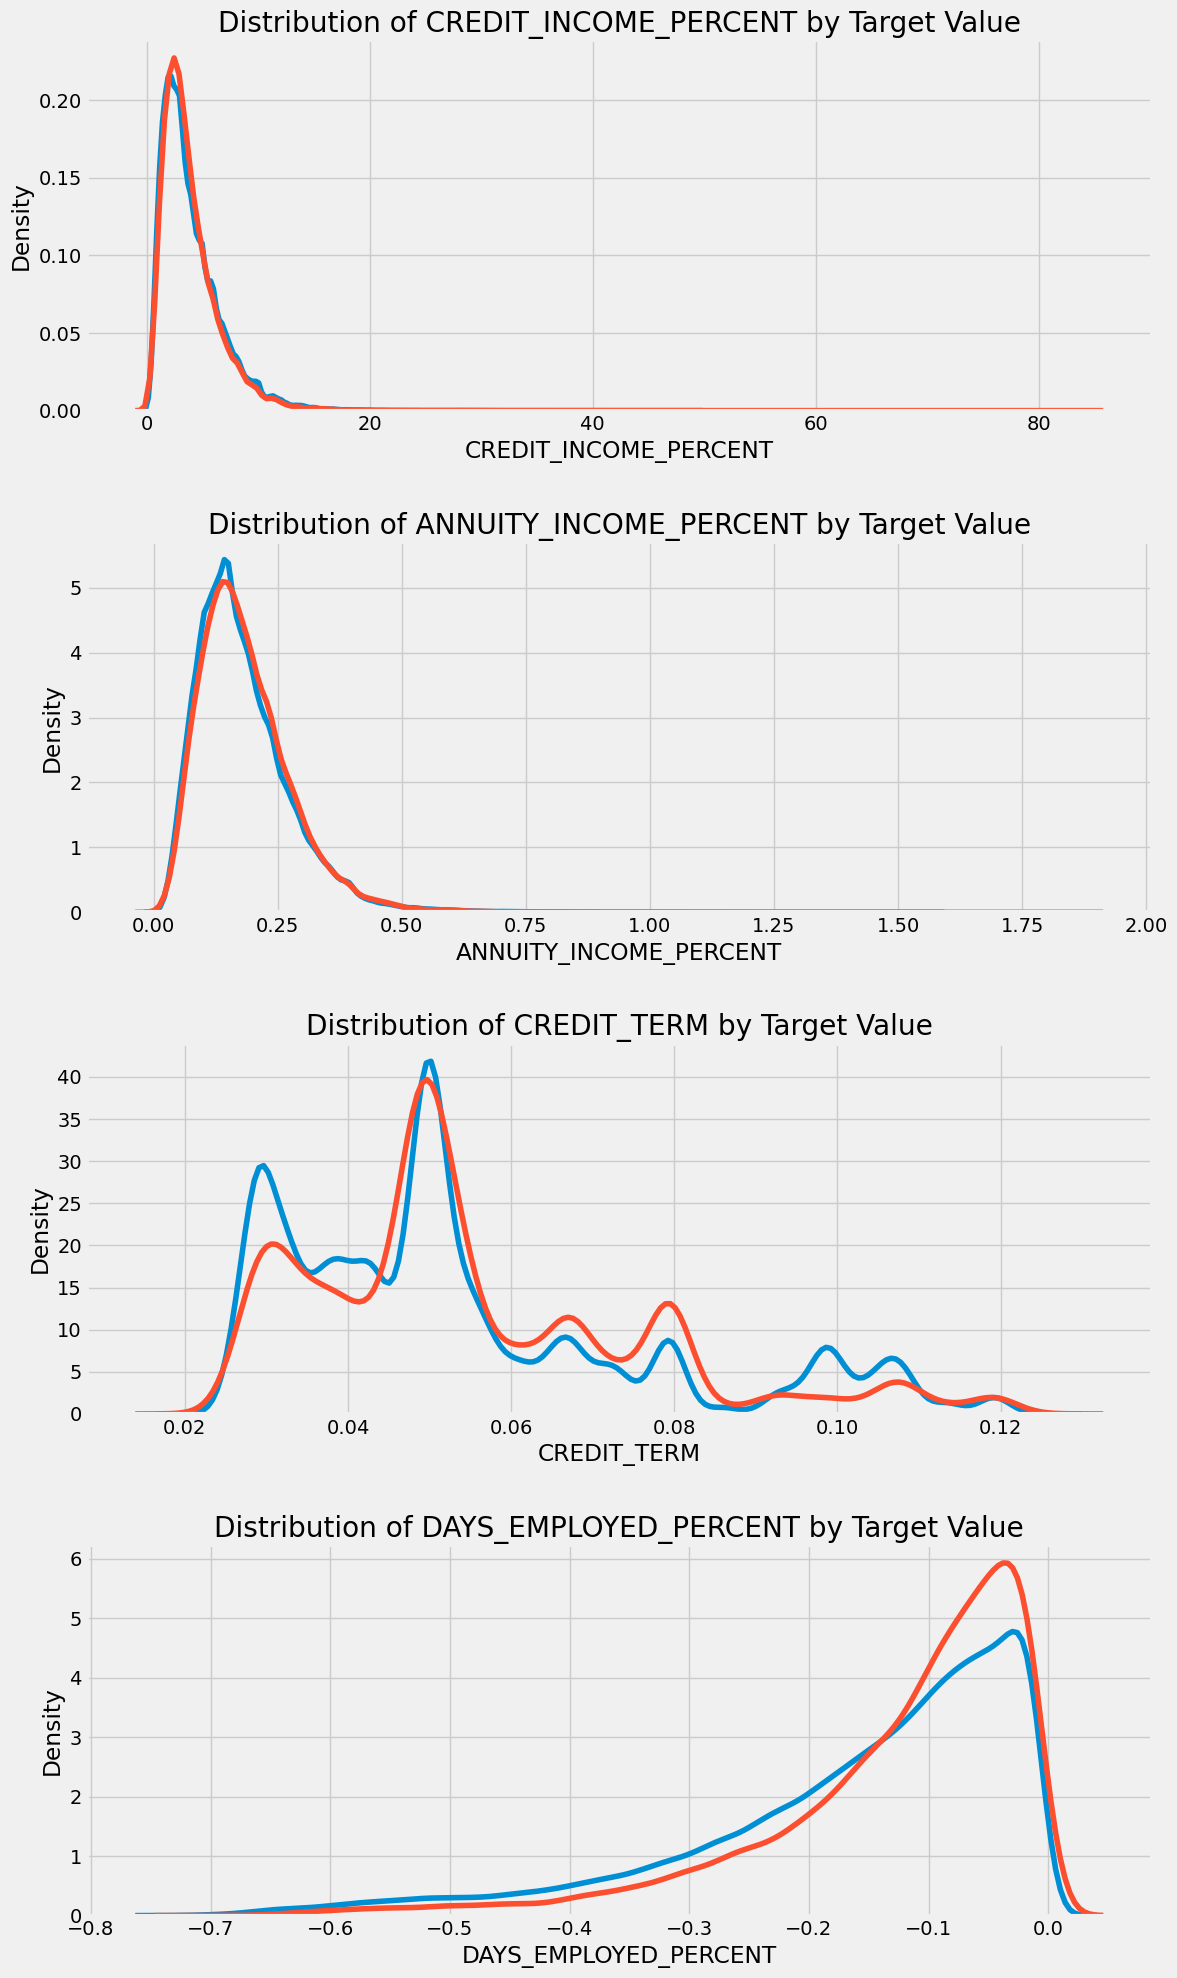

In [39]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(data_domain.loc[data_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(data_domain.loc[data_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# - - - - - - - PARTIE 2 : MODELISATION  - - - - - - - -

# <a name="C4">4. Fonctions, tests différents modèles sur data  </a>
<a href="#C0">SOMMAIRE</a>

- Entraîner plusieurs modèles de classification : approche naïve (DummyClassifier), régression logistique, arbre de décision, random forests, lightgbm/catboost
- Cross-validation avec GridSearchCV (pour la recherche des hyper-paramètres, scoring=roc auc). Si jamais la recherche est trop longue, prendre un sous-échantillon du dataset de train (après le prétraitement).
- Metrics : recall, F1-score, AUC, matrice de confusion
- Metric pour recherche hyperparam AUC ROC
- Bonus : Créer une fonction regroupant la recherche des hyperparamètres et le calcul de performance.
- Récapitulatif des performances (faire un tableau récapitulatif des performances)


### Séparation Train Test & Prétraitements additionnels

In [40]:
from sklearn.model_selection import train_test_split

# Diviser les caractéristiques (X) et la variable cible (y)
X = data.drop(['TARGET','SK_ID_CURR'], axis=1)
y = data['TARGET']

# Effectuer la division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérifier les tailles des ensembles de données
print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de test :", len(X_test))

Taille de l'ensemble d'entraînement : 246008
Taille de l'ensemble de test : 61503


In [41]:
from sklearn.preprocessing import MinMaxScaler

# Feature names
features = list(X_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (246008, 241)
Testing data shape:  (61503, 241)


In [42]:
#initialisation du stockage des résultats
resultats = pd.DataFrame(columns=['Données','Modèle','recall','F1-score' ,'AUC ROC'])

## Création d'une fonction pour rechercher les hyperparamètres et afficher les résultats

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, roc_auc_score, confusion_matrix, auc, roc_curve

def evaluate_model(model, params, X_train, y_train, X_test, y_test):
    # scorer AUC ROC
    scorer = make_scorer(roc_auc_score)

    # recherche hyperparams avec GridSearchCV et Cross Validation
    grid_search = GridSearchCV(model, params, scoring=scorer, cv=5)
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres et le meilleur modèle
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Évaluer les performances sur l'ensemble de test
    y_pred = best_model.predict(X_test)
    y_scores = best_model.predict_proba(X_test)[:, 1]
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_model = roc_auc_score(y_test, y_scores)
    cm = confusion_matrix(y_test, y_pred)

    # Afficher les résultats
    print("Meilleurs hyperparamètres :", best_params)
    print("Recall :", recall)
    print("F1-score :", f1)
    print("AUC ROC :", auc_model)
    print("Matrice de confusion :\n", cm)

    # Calculer la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)

    # Calculer l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Afficher la courbe ROC
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')  # Droite AUC-ROC (aléatoire)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC ')
    plt.legend(loc="lower right")
    plt.show()
    
    #stocker les resultats
    results = [str(best_model),str(round(recall,5)),str(round(f1,5)),str(round(auc_model,5))]

    # Retourner le meilleur modèle
    return best_model, results, cm, best_params 

In [44]:
données = 'data de base'

## Dummy Classifier

Meilleurs hyperparamètres : {'strategy': 'most_frequent'}
Recall : 0.0
F1-score : 0.0
AUC ROC : 0.5
Matrice de confusion :
 [[56554     0]
 [ 4949     0]]


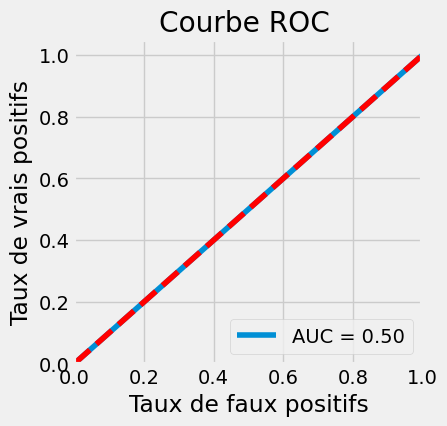

In [46]:
#import
from sklearn.dummy import DummyClassifier

# define model
model = DummyClassifier()

#define params
params = {'strategy': ['most_frequent','prior']}

dummy_best,dummy_results,dummy_cm, dummy_params = evaluate_model(model,params,X_train,y_train,X_test,y_test)

In [47]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(données), dummy_results[0][:200],dummy_results[1],dummy_results[2],dummy_results[3]]
#affichage des résultats
resultats

Données                                     Modèle recall F1-score  \
0  data de base  DummyClassifier(strategy='most_frequent')    0.0      0.0   

  AUC ROC  
0     0.5

In [70]:
def trackwithml(results,params,donnees,balanced) :
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.autolog(disable=True) 
    mlflow.set_experiment("Scoring modèles tracker")
    #balanced = yes or no
    name = results[0]
    recall = results[1]
    f1 = results[2]
    auc_model = results[3]
    feature_engineering_type = donnees
    with mlflow.start_run(run_name=name):
        mlflow.log_params(params)
        mlflow.log_metric("roc_auc", auc_model)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_param("Feature Engineering", feature_engineering_type)
        mlflow.log_param("Balanced", balanced)
    mlflow.end_run()
    print('Model '+name+' with '+feature_engineering_type+' /balanced : '+balanced+' == DONE')

In [71]:
trackwithml(dummy_results,dummy_params,données,'no')

Model DummyClassifier(strategy='most_frequent') with data de base /balanced : no == DONE


## Logistic Regression Implementation

In [49]:
# Diviser l'ensemble de données en un sous-ensemble plus petit pour l'entraînement et le test
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42)

# Afficher la taille du nouvel échantillon d'entraînement
print("Nouvelle taille de l'échantillon d'entraînement :", X_train_small.shape)

Nouvelle taille de l'échantillon d'entraînement : (73802, 241)


Meilleurs hyperparamètres : {'C': 0.01, 'solver': 'saga'}
Recall : 0.0016164881794301878
F1-score : 0.0032225579053373615
AUC ROC : 0.7407027902021134
Matrice de confusion :
 [[56546     8]
 [ 4941     8]]


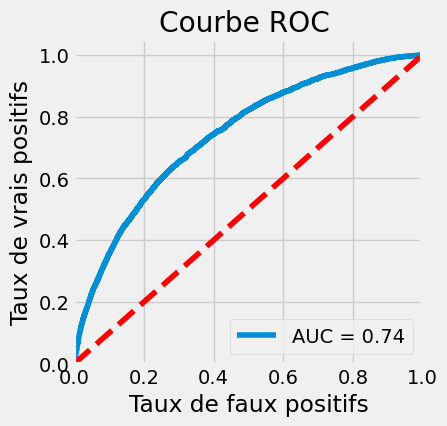

In [50]:
#import
from sklearn.linear_model import LogisticRegression

# define model
model2 = LogisticRegression()

#define params
params2 = {'C': [0.01,0.001,0.0001],
         'solver': ['saga', 'lbfgs']}

logreg_best,logreg_results,logreg_cm, logreg_params = evaluate_model(model2,params2,X_train_small,y_train_small,X_test,y_test)

In [51]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(données), logreg_results[0][:200],logreg_results[1],logreg_results[2],logreg_results[3]]
#affichage des résultats
resultats

Données                                     Modèle   recall F1-score  \
0  data de base  DummyClassifier(strategy='most_frequent')      0.0      0.0   
1  data de base  LogisticRegression(C=0.01, solver='saga')  0.00162  0.00322   

  AUC ROC  
0     0.5  
1  0.7407

In [72]:
trackwithml(logreg_results,logreg_params,données,'no')


Model LogisticRegression(C=0.01, solver='saga') with data de base /balanced : no == DONE


## Decision tree

Meilleurs hyperparamètres : {'criterion': 'gini', 'max_depth': 12, 'max_features': 211}
Recall : 0.04889876742776318
F1-score : 0.07914963205233033
AUC ROC : 0.6604277661213945
Matrice de confusion :
 [[55630   924]
 [ 4707   242]]


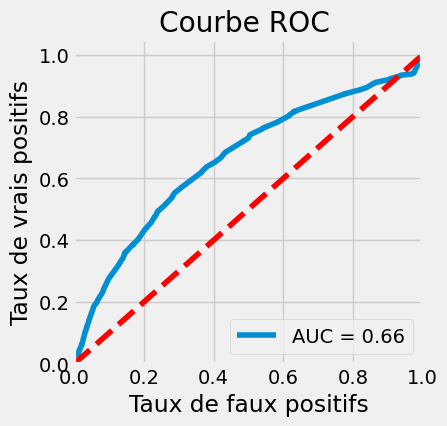

In [106]:
#import
from sklearn import tree

# define model
modeldt = tree.DecisionTreeClassifier(random_state=48)

#define params
paramsdt = {'criterion': ['gini', 'entropy'],
             'max_depth': [2, 4, 6, 8, 10, 12],
             'max_features': list(range(1, X.shape[1] + 1, 30))}

DT_best,DT_results,DT_cm, DT_params = evaluate_model(modeldt,paramsdt,X_train_small,y_train_small,X_test,y_test)

In [54]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(données), DT_results[0][:200],DT_results[1],DT_results[2],DT_results[3]]
#affichage des résultats
resultats

Données                                             Modèle   recall  \
0  data de base          DummyClassifier(strategy='most_frequent')      0.0   
1  data de base          LogisticRegression(C=0.01, solver='saga')  0.00162   
2  data de base  DecisionTreeClassifier(max_depth=30, max_featu...  0.14387   

  F1-score  AUC ROC  
0      0.0      0.5  
1  0.00322   0.7407  
2  0.14406  0.52321

In [107]:
trackwithml(DT_results,DT_params,données,'no')

Model DecisionTreeClassifier(max_depth=12, max_features=211, random_state=48) with data de base /balanced : no == DONE


## Random Forrest

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent worker

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent worker

Meilleurs hyperparamètres : {'max_depth': 5, 'max_features': 'auto'}
Recall : 0.0
F1-score : 0.0
AUC ROC : 0.7238721295939093
Matrice de confusion :
 [[56554     0]
 [ 4949     0]]


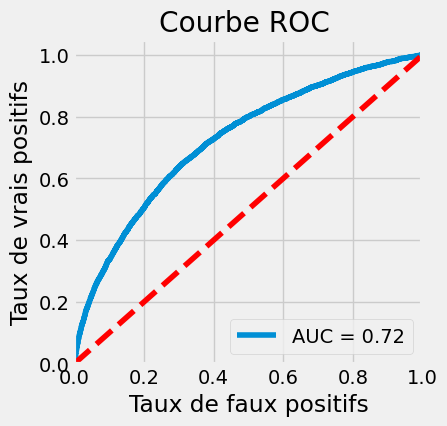

In [56]:
#import
from sklearn.ensemble import RandomForestClassifier

# define model
model3 = RandomForestClassifier(random_state=48,n_jobs=-1,verbose=1)

#define params
params3 = {'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [5,8,10,12,15]}

RF_best,RF_results,RF_cm, RF_params = evaluate_model(model3,params3,X_train_small,y_train_small,X_test,y_test)

In [57]:
RF_best.fit(X_train_small,y_train_small)

# Extract feature importances
feature_importance_values = RF_best.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished


In [74]:
trackwithml(RF_results,RF_params,données,'no')

Model RandomForestClassifier(max_depth=5, max_features='auto', n_jobs=-1,
                       random_state=48, verbose=1) with data de base /balanced : no == DONE


In [75]:
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances

feature  importance
32                          EXT_SOURCE_3    0.185163
31                          EXT_SOURCE_2    0.170847
10                         DAYS_EMPLOYED    0.071862
30                          EXT_SOURCE_1    0.052576
9                             DAYS_BIRTH    0.042053
..                                   ...         ...
14                            FLAG_MOBIL    0.000000
126  NAME_EDUCATION_TYPE_Academic degree    0.000000
123             NAME_INCOME_TYPE_Student    0.000000
216      ORGANIZATION_TYPE_Trade: type 4    0.000000
120     NAME_INCOME_TYPE_Maternity leave    0.000000

[241 rows x 2 columns]

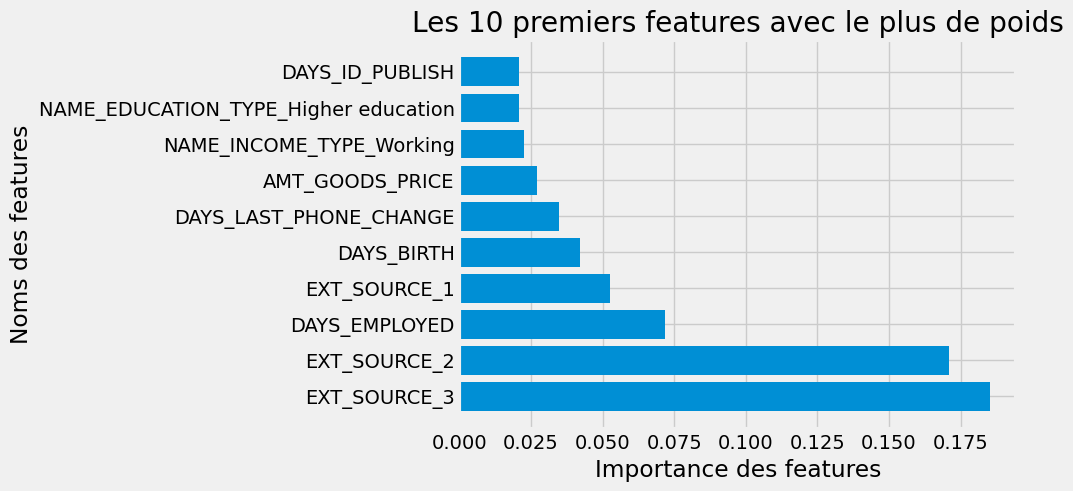

In [76]:
plt.barh(feature_importances.feature[:10], feature_importances.importance[:10])
plt.title("Les 10 premiers features avec le plus de poids")
plt.xlabel("Importance des features")
plt.ylabel("Noms des features")
plt.show()

In [77]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(données), RF_results[0][:200],RF_results[1],RF_results[2],RF_results[3]]
#affichage des résultats
resultats

Données                                             Modèle   recall  \
0  data de base          DummyClassifier(strategy='most_frequent')      0.0   
1  data de base          LogisticRegression(C=0.01, solver='saga')  0.00162   
2  data de base  DecisionTreeClassifier(max_depth=30, max_featu...  0.14387   
3  data de base  RandomForestClassifier(max_depth=5, max_featur...      0.0   

  F1-score  AUC ROC  
0      0.0      0.5  
1  0.00322   0.7407  
2  0.14406  0.52321  
3      0.0  0.72387

## LightGboost

In [78]:
# Diviser l'ensemble de données en un sous-ensemble plus petit pour l'entraînement et le test
X_train_xsmall, _, y_train_xsmall, _ = train_test_split(X_train, y_train, test_size=0.92, random_state=42)

# Afficher la taille du nouvel échantillon d'entraînement
print("Nouvelle taille de l'échantillon d'entraînement :", X_train_xsmall.shape)

Nouvelle taille de l'échantillon d'entraînement : (19680, 241)


Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 0.31622776601683794, 'reg_lambda': 0.31622776601683794}
Recall : 0.01858961406344716
F1-score : 0.03565891472868217
AUC ROC : 0.7328851645056622
Matrice de confusion :
 [[56435   119]
 [ 4857    92]]


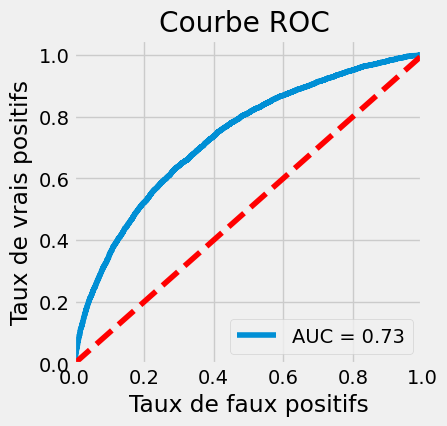

In [79]:
#import
import lightgbm as lgb

# define model
model4 = lgb.LGBMClassifier()

#define params
params4 = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [2,3,4, 5],
    'reg_alpha': np.logspace(-3, 2, 3),
    'reg_lambda': np.logspace(-3, 2, 3)}


LGB_best , LGB_results , LGB_cm, LGB_params = evaluate_model(model4,params4,X_train_xsmall,y_train_xsmall,X_test,y_test)

In [80]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(données), LGB_results[0][:200],LGB_results[1],LGB_results[2],LGB_results[3]]
#affichage des résultats
resultats

Données                                             Modèle   recall  \
0  data de base          DummyClassifier(strategy='most_frequent')      0.0   
1  data de base          LogisticRegression(C=0.01, solver='saga')  0.00162   
2  data de base  DecisionTreeClassifier(max_depth=30, max_featu...  0.14387   
3  data de base  RandomForestClassifier(max_depth=5, max_featur...      0.0   
4  data de base  LGBMClassifier(max_depth=5, reg_alpha=0.316227...  0.01859   

  F1-score  AUC ROC  
0      0.0      0.5  
1  0.00322   0.7407  
2  0.14406  0.52321  
3      0.0  0.72387  
4  0.03566  0.73289

In [81]:
trackwithml(LGB_results,LGB_params,données,'no')

Model LGBMClassifier(max_depth=5, reg_alpha=0.31622776601683794,
               reg_lambda=0.31622776601683794) with data de base /balanced : no == DONE


## CatBoost

0:	learn: 0.5966794	total: 171ms	remaining: 16.9s
1:	learn: 0.5223742	total: 180ms	remaining: 8.81s
2:	learn: 0.4662027	total: 187ms	remaining: 6.05s
3:	learn: 0.4227186	total: 193ms	remaining: 4.64s
4:	learn: 0.3869839	total: 201ms	remaining: 3.81s
5:	learn: 0.3590523	total: 206ms	remaining: 3.23s
6:	learn: 0.3380110	total: 215ms	remaining: 2.85s
7:	learn: 0.3233606	total: 221ms	remaining: 2.55s
8:	learn: 0.3108102	total: 229ms	remaining: 2.31s
9:	learn: 0.3013622	total: 236ms	remaining: 2.12s
10:	learn: 0.2923826	total: 242ms	remaining: 1.96s
11:	learn: 0.2863089	total: 249ms	remaining: 1.82s
12:	learn: 0.2801468	total: 255ms	remaining: 1.7s
13:	learn: 0.2755853	total: 262ms	remaining: 1.61s
14:	learn: 0.2715058	total: 268ms	remaining: 1.52s
15:	learn: 0.2686029	total: 275ms	remaining: 1.44s
16:	learn: 0.2660630	total: 282ms	remaining: 1.38s
17:	learn: 0.2643890	total: 287ms	remaining: 1.31s
18:	learn: 0.2626211	total: 295ms	remaining: 1.26s
19:	learn: 0.2603585	total: 302ms	remainin

72:	learn: 0.2421467	total: 416ms	remaining: 154ms
73:	learn: 0.2420724	total: 423ms	remaining: 149ms
74:	learn: 0.2420387	total: 429ms	remaining: 143ms
75:	learn: 0.2418656	total: 435ms	remaining: 137ms
76:	learn: 0.2418195	total: 441ms	remaining: 132ms
77:	learn: 0.2416939	total: 449ms	remaining: 127ms
78:	learn: 0.2415748	total: 454ms	remaining: 121ms
79:	learn: 0.2414144	total: 460ms	remaining: 115ms
80:	learn: 0.2411513	total: 467ms	remaining: 110ms
81:	learn: 0.2409713	total: 473ms	remaining: 104ms
82:	learn: 0.2408658	total: 481ms	remaining: 98.6ms
83:	learn: 0.2408267	total: 487ms	remaining: 92.8ms
84:	learn: 0.2406986	total: 493ms	remaining: 87ms
85:	learn: 0.2406605	total: 501ms	remaining: 81.5ms
86:	learn: 0.2405681	total: 507ms	remaining: 75.7ms
87:	learn: 0.2404065	total: 515ms	remaining: 70.2ms
88:	learn: 0.2403314	total: 520ms	remaining: 64.3ms
89:	learn: 0.2402314	total: 526ms	remaining: 58.4ms
90:	learn: 0.2400808	total: 533ms	remaining: 52.7ms
91:	learn: 0.2399956	tot

36:	learn: 0.2503082	total: 212ms	remaining: 360ms
37:	learn: 0.2498982	total: 218ms	remaining: 356ms
38:	learn: 0.2495480	total: 225ms	remaining: 352ms
39:	learn: 0.2494019	total: 231ms	remaining: 347ms
40:	learn: 0.2490422	total: 238ms	remaining: 343ms
41:	learn: 0.2488029	total: 245ms	remaining: 338ms
42:	learn: 0.2485585	total: 252ms	remaining: 334ms
43:	learn: 0.2483036	total: 259ms	remaining: 329ms
44:	learn: 0.2481380	total: 265ms	remaining: 324ms
45:	learn: 0.2479389	total: 272ms	remaining: 319ms
46:	learn: 0.2476551	total: 279ms	remaining: 314ms
47:	learn: 0.2474938	total: 285ms	remaining: 309ms
48:	learn: 0.2472913	total: 291ms	remaining: 303ms
49:	learn: 0.2471150	total: 298ms	remaining: 298ms
50:	learn: 0.2468360	total: 304ms	remaining: 292ms
51:	learn: 0.2466956	total: 311ms	remaining: 287ms
52:	learn: 0.2465260	total: 318ms	remaining: 282ms
53:	learn: 0.2463155	total: 323ms	remaining: 275ms
54:	learn: 0.2460831	total: 331ms	remaining: 271ms
55:	learn: 0.2458759	total: 338

0:	learn: 0.6827975	total: 7.18ms	remaining: 711ms
1:	learn: 0.6726606	total: 13.2ms	remaining: 647ms
2:	learn: 0.6628719	total: 18.8ms	remaining: 606ms
3:	learn: 0.6532461	total: 24.3ms	remaining: 582ms
4:	learn: 0.6438254	total: 30.5ms	remaining: 579ms
5:	learn: 0.6346086	total: 36.1ms	remaining: 565ms
6:	learn: 0.6258064	total: 41.8ms	remaining: 555ms
7:	learn: 0.6172301	total: 47.6ms	remaining: 548ms
8:	learn: 0.6087416	total: 53.5ms	remaining: 541ms
9:	learn: 0.6004446	total: 58.8ms	remaining: 529ms
10:	learn: 0.5924826	total: 64.5ms	remaining: 522ms
11:	learn: 0.5847266	total: 69.7ms	remaining: 511ms
12:	learn: 0.5771324	total: 74.9ms	remaining: 501ms
13:	learn: 0.5697361	total: 80.6ms	remaining: 495ms
14:	learn: 0.5623391	total: 86ms	remaining: 487ms
15:	learn: 0.5552680	total: 91.6ms	remaining: 481ms
16:	learn: 0.5484423	total: 97.3ms	remaining: 475ms
17:	learn: 0.5416530	total: 103ms	remaining: 468ms
18:	learn: 0.5350952	total: 108ms	remaining: 462ms
19:	learn: 0.5287460	total

71:	learn: 0.3442233	total: 406ms	remaining: 158ms
72:	learn: 0.3424138	total: 411ms	remaining: 152ms
73:	learn: 0.3404123	total: 416ms	remaining: 146ms
74:	learn: 0.3385993	total: 422ms	remaining: 141ms
75:	learn: 0.3368308	total: 427ms	remaining: 135ms
76:	learn: 0.3350546	total: 432ms	remaining: 129ms
77:	learn: 0.3334047	total: 438ms	remaining: 123ms
78:	learn: 0.3320095	total: 443ms	remaining: 118ms
79:	learn: 0.3303418	total: 448ms	remaining: 112ms
80:	learn: 0.3285754	total: 453ms	remaining: 106ms
81:	learn: 0.3270402	total: 459ms	remaining: 101ms
82:	learn: 0.3255203	total: 465ms	remaining: 95.2ms
83:	learn: 0.3243067	total: 470ms	remaining: 89.5ms
84:	learn: 0.3229053	total: 475ms	remaining: 83.8ms
85:	learn: 0.3214823	total: 481ms	remaining: 78.3ms
86:	learn: 0.3201319	total: 486ms	remaining: 72.6ms
87:	learn: 0.3186603	total: 492ms	remaining: 67.1ms
88:	learn: 0.3175468	total: 497ms	remaining: 61.5ms
89:	learn: 0.3163199	total: 503ms	remaining: 55.8ms
90:	learn: 0.3150790	to

36:	learn: 0.4407442	total: 210ms	remaining: 358ms
37:	learn: 0.4367372	total: 215ms	remaining: 351ms
38:	learn: 0.4326038	total: 221ms	remaining: 345ms
39:	learn: 0.4288322	total: 227ms	remaining: 340ms
40:	learn: 0.4248504	total: 232ms	remaining: 334ms
41:	learn: 0.4212444	total: 237ms	remaining: 328ms
42:	learn: 0.4173011	total: 242ms	remaining: 321ms
43:	learn: 0.4135684	total: 247ms	remaining: 315ms
44:	learn: 0.4102641	total: 253ms	remaining: 309ms
45:	learn: 0.4065800	total: 259ms	remaining: 303ms
46:	learn: 0.4032245	total: 264ms	remaining: 297ms
47:	learn: 0.4000921	total: 269ms	remaining: 291ms
48:	learn: 0.3970969	total: 274ms	remaining: 285ms
49:	learn: 0.3941827	total: 280ms	remaining: 280ms
50:	learn: 0.3910485	total: 286ms	remaining: 274ms
51:	learn: 0.3880293	total: 291ms	remaining: 269ms
52:	learn: 0.3853419	total: 296ms	remaining: 263ms
53:	learn: 0.3827114	total: 302ms	remaining: 257ms
54:	learn: 0.3800876	total: 307ms	remaining: 251ms
55:	learn: 0.3775780	total: 312

0:	learn: 0.6921027	total: 7.18ms	remaining: 710ms
1:	learn: 0.6910614	total: 13.3ms	remaining: 654ms
2:	learn: 0.6900290	total: 19.3ms	remaining: 624ms
3:	learn: 0.6889910	total: 25.3ms	remaining: 607ms
4:	learn: 0.6879677	total: 31.5ms	remaining: 599ms
5:	learn: 0.6869307	total: 36.9ms	remaining: 578ms
6:	learn: 0.6859138	total: 42.6ms	remaining: 566ms
7:	learn: 0.6848884	total: 48.7ms	remaining: 561ms
8:	learn: 0.6838228	total: 54.5ms	remaining: 551ms
9:	learn: 0.6827966	total: 60.2ms	remaining: 541ms
10:	learn: 0.6817817	total: 65.6ms	remaining: 531ms
11:	learn: 0.6807137	total: 71.4ms	remaining: 524ms
12:	learn: 0.6796716	total: 77.1ms	remaining: 516ms
13:	learn: 0.6786706	total: 82.7ms	remaining: 508ms
14:	learn: 0.6776194	total: 88.3ms	remaining: 500ms
15:	learn: 0.6765994	total: 94ms	remaining: 494ms
16:	learn: 0.6756082	total: 100ms	remaining: 489ms
17:	learn: 0.6745679	total: 106ms	remaining: 482ms
18:	learn: 0.6735804	total: 112ms	remaining: 476ms
19:	learn: 0.6725897	total:

72:	learn: 0.6233937	total: 407ms	remaining: 150ms
73:	learn: 0.6224988	total: 412ms	remaining: 145ms
74:	learn: 0.6216389	total: 418ms	remaining: 139ms
75:	learn: 0.6207841	total: 423ms	remaining: 134ms
76:	learn: 0.6199295	total: 429ms	remaining: 128ms
77:	learn: 0.6190716	total: 434ms	remaining: 122ms
78:	learn: 0.6182158	total: 439ms	remaining: 117ms
79:	learn: 0.6173501	total: 445ms	remaining: 111ms
80:	learn: 0.6165050	total: 450ms	remaining: 106ms
81:	learn: 0.6156589	total: 460ms	remaining: 101ms
82:	learn: 0.6147700	total: 465ms	remaining: 95.3ms
83:	learn: 0.6138817	total: 472ms	remaining: 89.9ms
84:	learn: 0.6130442	total: 478ms	remaining: 84.3ms
85:	learn: 0.6121789	total: 483ms	remaining: 78.6ms
86:	learn: 0.6113474	total: 489ms	remaining: 73.1ms
87:	learn: 0.6105147	total: 495ms	remaining: 67.4ms
88:	learn: 0.6096710	total: 500ms	remaining: 61.8ms
89:	learn: 0.6088412	total: 506ms	remaining: 56.2ms
90:	learn: 0.6080056	total: 511ms	remaining: 50.5ms
91:	learn: 0.6071829	t

36:	learn: 0.6561511	total: 209ms	remaining: 356ms
37:	learn: 0.6552025	total: 215ms	remaining: 351ms
38:	learn: 0.6542642	total: 220ms	remaining: 345ms
39:	learn: 0.6533264	total: 226ms	remaining: 339ms
40:	learn: 0.6523426	total: 231ms	remaining: 332ms
41:	learn: 0.6514045	total: 236ms	remaining: 326ms
42:	learn: 0.6504753	total: 242ms	remaining: 320ms
43:	learn: 0.6494996	total: 247ms	remaining: 315ms
44:	learn: 0.6485701	total: 253ms	remaining: 309ms
45:	learn: 0.6476451	total: 258ms	remaining: 303ms
46:	learn: 0.6467250	total: 264ms	remaining: 298ms
47:	learn: 0.6458065	total: 270ms	remaining: 292ms
48:	learn: 0.6448893	total: 275ms	remaining: 286ms
49:	learn: 0.6439756	total: 281ms	remaining: 281ms
50:	learn: 0.6430450	total: 286ms	remaining: 275ms
51:	learn: 0.6421265	total: 291ms	remaining: 269ms
52:	learn: 0.6412206	total: 297ms	remaining: 263ms
53:	learn: 0.6402745	total: 303ms	remaining: 258ms
54:	learn: 0.6393709	total: 308ms	remaining: 252ms
55:	learn: 0.6384652	total: 313

0:	learn: 0.5966795	total: 6.67ms	remaining: 661ms
1:	learn: 0.5232770	total: 13.5ms	remaining: 660ms
2:	learn: 0.4667332	total: 20ms	remaining: 645ms
3:	learn: 0.4217194	total: 26ms	remaining: 623ms
4:	learn: 0.3888902	total: 31.9ms	remaining: 607ms
5:	learn: 0.3613275	total: 37.9ms	remaining: 594ms
6:	learn: 0.3420440	total: 43.8ms	remaining: 582ms
7:	learn: 0.3261611	total: 49.8ms	remaining: 573ms
8:	learn: 0.3144425	total: 55.8ms	remaining: 564ms
9:	learn: 0.3020096	total: 61.4ms	remaining: 553ms
10:	learn: 0.2940276	total: 66.9ms	remaining: 541ms
11:	learn: 0.2863576	total: 72.5ms	remaining: 532ms
12:	learn: 0.2805794	total: 77.7ms	remaining: 520ms
13:	learn: 0.2763343	total: 83.4ms	remaining: 512ms
14:	learn: 0.2730457	total: 89ms	remaining: 504ms
15:	learn: 0.2694449	total: 94.4ms	remaining: 496ms
16:	learn: 0.2664805	total: 100ms	remaining: 488ms
17:	learn: 0.2642925	total: 106ms	remaining: 484ms
18:	learn: 0.2628655	total: 112ms	remaining: 476ms
19:	learn: 0.2608954	total: 117

92:	learn: 0.2402003	total: 602ms	remaining: 45.3ms
93:	learn: 0.2400546	total: 608ms	remaining: 38.8ms
94:	learn: 0.2399251	total: 614ms	remaining: 32.3ms
95:	learn: 0.2398206	total: 619ms	remaining: 25.8ms
96:	learn: 0.2396870	total: 625ms	remaining: 19.3ms
97:	learn: 0.2395348	total: 630ms	remaining: 12.9ms
98:	learn: 0.2395173	total: 635ms	remaining: 6.42ms
99:	learn: 0.2393963	total: 641ms	remaining: 0us
0:	learn: 0.5940668	total: 6.66ms	remaining: 660ms
1:	learn: 0.5198864	total: 13.5ms	remaining: 660ms
2:	learn: 0.4641685	total: 19.9ms	remaining: 644ms
3:	learn: 0.4214977	total: 26.3ms	remaining: 630ms
4:	learn: 0.3888182	total: 32.2ms	remaining: 613ms
5:	learn: 0.3634375	total: 38.3ms	remaining: 600ms
6:	learn: 0.3440198	total: 44.3ms	remaining: 588ms
7:	learn: 0.3265703	total: 50.1ms	remaining: 576ms
8:	learn: 0.3147766	total: 56.1ms	remaining: 567ms
9:	learn: 0.3029947	total: 61.3ms	remaining: 552ms
10:	learn: 0.2933292	total: 67ms	remaining: 542ms
11:	learn: 0.2879151	total:

70:	learn: 0.2443981	total: 420ms	remaining: 172ms
71:	learn: 0.2442679	total: 426ms	remaining: 166ms
72:	learn: 0.2440409	total: 432ms	remaining: 160ms
73:	learn: 0.2439467	total: 438ms	remaining: 154ms
74:	learn: 0.2437627	total: 444ms	remaining: 148ms
75:	learn: 0.2436473	total: 450ms	remaining: 142ms
76:	learn: 0.2435119	total: 456ms	remaining: 136ms
77:	learn: 0.2433127	total: 463ms	remaining: 130ms
78:	learn: 0.2431876	total: 468ms	remaining: 124ms
79:	learn: 0.2429974	total: 474ms	remaining: 119ms
80:	learn: 0.2428375	total: 480ms	remaining: 112ms
81:	learn: 0.2426749	total: 485ms	remaining: 107ms
82:	learn: 0.2426338	total: 491ms	remaining: 101ms
83:	learn: 0.2424929	total: 497ms	remaining: 94.7ms
84:	learn: 0.2423791	total: 503ms	remaining: 88.7ms
85:	learn: 0.2423186	total: 508ms	remaining: 82.8ms
86:	learn: 0.2422873	total: 515ms	remaining: 77ms
87:	learn: 0.2421778	total: 522ms	remaining: 71.1ms
88:	learn: 0.2420285	total: 528ms	remaining: 65.3ms
89:	learn: 0.2419895	total:

35:	learn: 0.4446853	total: 209ms	remaining: 371ms
36:	learn: 0.4404157	total: 215ms	remaining: 366ms
37:	learn: 0.4363793	total: 220ms	remaining: 359ms
38:	learn: 0.4325114	total: 226ms	remaining: 353ms
39:	learn: 0.4287208	total: 231ms	remaining: 347ms
40:	learn: 0.4247098	total: 237ms	remaining: 341ms
41:	learn: 0.4211037	total: 243ms	remaining: 336ms
42:	learn: 0.4176223	total: 248ms	remaining: 329ms
43:	learn: 0.4142096	total: 254ms	remaining: 324ms
44:	learn: 0.4108654	total: 260ms	remaining: 318ms
45:	learn: 0.4076318	total: 265ms	remaining: 311ms
46:	learn: 0.4044771	total: 271ms	remaining: 305ms
47:	learn: 0.4014060	total: 276ms	remaining: 299ms
48:	learn: 0.3982984	total: 282ms	remaining: 293ms
49:	learn: 0.3951054	total: 287ms	remaining: 287ms
50:	learn: 0.3922558	total: 293ms	remaining: 281ms
51:	learn: 0.3893916	total: 298ms	remaining: 275ms
52:	learn: 0.3866751	total: 303ms	remaining: 269ms
53:	learn: 0.3839635	total: 309ms	remaining: 263ms
54:	learn: 0.3811758	total: 314

0:	learn: 0.6824929	total: 7.16ms	remaining: 709ms
1:	learn: 0.6723114	total: 13.2ms	remaining: 648ms
2:	learn: 0.6625401	total: 19.1ms	remaining: 618ms
3:	learn: 0.6530092	total: 24.8ms	remaining: 595ms
4:	learn: 0.6437211	total: 30.6ms	remaining: 581ms
5:	learn: 0.6346054	total: 36.2ms	remaining: 567ms
6:	learn: 0.6257547	total: 42.2ms	remaining: 560ms
7:	learn: 0.6166254	total: 49ms	remaining: 564ms
8:	learn: 0.6081398	total: 54.9ms	remaining: 555ms
9:	learn: 0.5999468	total: 60.6ms	remaining: 546ms
10:	learn: 0.5919720	total: 66.7ms	remaining: 539ms
11:	learn: 0.5839018	total: 72.7ms	remaining: 533ms
12:	learn: 0.5761451	total: 78.4ms	remaining: 524ms
13:	learn: 0.5687307	total: 84ms	remaining: 516ms
14:	learn: 0.5615554	total: 89.7ms	remaining: 508ms
15:	learn: 0.5545510	total: 95.2ms	remaining: 500ms
16:	learn: 0.5476907	total: 101ms	remaining: 492ms
17:	learn: 0.5406392	total: 107ms	remaining: 486ms
18:	learn: 0.5341695	total: 112ms	remaining: 479ms
19:	learn: 0.5274790	total: 1

65:	learn: 0.3544490	total: 419ms	remaining: 216ms
66:	learn: 0.3524083	total: 427ms	remaining: 210ms
67:	learn: 0.3504824	total: 434ms	remaining: 204ms
68:	learn: 0.3484404	total: 440ms	remaining: 198ms
69:	learn: 0.3465632	total: 447ms	remaining: 191ms
70:	learn: 0.3448343	total: 453ms	remaining: 185ms
71:	learn: 0.3430152	total: 461ms	remaining: 179ms
72:	learn: 0.3412896	total: 467ms	remaining: 173ms
73:	learn: 0.3394892	total: 474ms	remaining: 167ms
74:	learn: 0.3375039	total: 481ms	remaining: 160ms
75:	learn: 0.3359756	total: 488ms	remaining: 154ms
76:	learn: 0.3345207	total: 495ms	remaining: 148ms
77:	learn: 0.3330937	total: 502ms	remaining: 142ms
78:	learn: 0.3316341	total: 510ms	remaining: 136ms
79:	learn: 0.3302834	total: 517ms	remaining: 129ms
80:	learn: 0.3288485	total: 527ms	remaining: 124ms
81:	learn: 0.3271651	total: 534ms	remaining: 117ms
82:	learn: 0.3258821	total: 542ms	remaining: 111ms
83:	learn: 0.3245966	total: 548ms	remaining: 104ms
84:	learn: 0.3234072	total: 555

35:	learn: 0.6571580	total: 204ms	remaining: 363ms
36:	learn: 0.6562108	total: 211ms	remaining: 359ms
37:	learn: 0.6552141	total: 217ms	remaining: 353ms
38:	learn: 0.6542710	total: 223ms	remaining: 348ms
39:	learn: 0.6533315	total: 229ms	remaining: 344ms
40:	learn: 0.6523985	total: 235ms	remaining: 338ms
41:	learn: 0.6514510	total: 241ms	remaining: 333ms
42:	learn: 0.6505140	total: 248ms	remaining: 328ms
43:	learn: 0.6495723	total: 254ms	remaining: 323ms
44:	learn: 0.6486466	total: 261ms	remaining: 319ms
45:	learn: 0.6477210	total: 267ms	remaining: 314ms
46:	learn: 0.6468017	total: 273ms	remaining: 308ms
47:	learn: 0.6458771	total: 279ms	remaining: 303ms
48:	learn: 0.6449573	total: 285ms	remaining: 297ms
49:	learn: 0.6440408	total: 291ms	remaining: 291ms
50:	learn: 0.6431269	total: 297ms	remaining: 286ms
51:	learn: 0.6422181	total: 303ms	remaining: 280ms
52:	learn: 0.6413087	total: 309ms	remaining: 274ms
53:	learn: 0.6403951	total: 314ms	remaining: 268ms
54:	learn: 0.6394726	total: 320

0:	learn: 0.6920703	total: 7.79ms	remaining: 771ms
1:	learn: 0.6910245	total: 14.5ms	remaining: 710ms
2:	learn: 0.6899939	total: 22ms	remaining: 710ms
3:	learn: 0.6889667	total: 28.9ms	remaining: 694ms
4:	learn: 0.6879418	total: 36.6ms	remaining: 695ms
5:	learn: 0.6869128	total: 43.8ms	remaining: 686ms
6:	learn: 0.6858912	total: 50.7ms	remaining: 673ms
7:	learn: 0.6848166	total: 57.8ms	remaining: 665ms
8:	learn: 0.6837917	total: 64.1ms	remaining: 648ms
9:	learn: 0.6827770	total: 71.7ms	remaining: 645ms
10:	learn: 0.6817670	total: 78ms	remaining: 631ms
11:	learn: 0.6807256	total: 86.3ms	remaining: 633ms
12:	learn: 0.6796998	total: 93.2ms	remaining: 623ms
13:	learn: 0.6786934	total: 99.9ms	remaining: 614ms
14:	learn: 0.6776957	total: 107ms	remaining: 609ms
15:	learn: 0.6766994	total: 113ms	remaining: 595ms
16:	learn: 0.6757015	total: 120ms	remaining: 588ms
17:	learn: 0.6747132	total: 127ms	remaining: 577ms
18:	learn: 0.6737257	total: 133ms	remaining: 565ms
19:	learn: 0.6726927	total: 139

68:	learn: 0.6269651	total: 410ms	remaining: 184ms
69:	learn: 0.6260935	total: 416ms	remaining: 178ms
70:	learn: 0.6252271	total: 422ms	remaining: 172ms
71:	learn: 0.6243605	total: 427ms	remaining: 166ms
72:	learn: 0.6234994	total: 432ms	remaining: 160ms
73:	learn: 0.6226309	total: 438ms	remaining: 154ms
74:	learn: 0.6217346	total: 444ms	remaining: 148ms
75:	learn: 0.6208359	total: 449ms	remaining: 142ms
76:	learn: 0.6199819	total: 456ms	remaining: 136ms
77:	learn: 0.6191144	total: 461ms	remaining: 130ms
78:	learn: 0.6182647	total: 467ms	remaining: 124ms
79:	learn: 0.6173635	total: 474ms	remaining: 118ms
80:	learn: 0.6165167	total: 480ms	remaining: 113ms
81:	learn: 0.6156713	total: 486ms	remaining: 107ms
82:	learn: 0.6148285	total: 493ms	remaining: 101ms
83:	learn: 0.6139862	total: 499ms	remaining: 95ms
84:	learn: 0.6131452	total: 506ms	remaining: 89.2ms
85:	learn: 0.6122650	total: 512ms	remaining: 83.3ms
86:	learn: 0.6114339	total: 518ms	remaining: 77.4ms
87:	learn: 0.6106018	total: 5

34:	learn: 0.2501450	total: 209ms	remaining: 387ms
35:	learn: 0.2498657	total: 215ms	remaining: 383ms
36:	learn: 0.2495355	total: 222ms	remaining: 378ms
37:	learn: 0.2492493	total: 228ms	remaining: 372ms
38:	learn: 0.2489727	total: 234ms	remaining: 366ms
39:	learn: 0.2487948	total: 239ms	remaining: 359ms
40:	learn: 0.2485817	total: 246ms	remaining: 353ms
41:	learn: 0.2483511	total: 252ms	remaining: 348ms
42:	learn: 0.2482151	total: 258ms	remaining: 342ms
43:	learn: 0.2480505	total: 264ms	remaining: 335ms
44:	learn: 0.2477883	total: 269ms	remaining: 329ms
45:	learn: 0.2476766	total: 275ms	remaining: 323ms
46:	learn: 0.2474756	total: 282ms	remaining: 318ms
47:	learn: 0.2471465	total: 287ms	remaining: 311ms
48:	learn: 0.2469254	total: 294ms	remaining: 306ms
49:	learn: 0.2466232	total: 299ms	remaining: 299ms
50:	learn: 0.2464955	total: 304ms	remaining: 293ms
51:	learn: 0.2462664	total: 310ms	remaining: 286ms
52:	learn: 0.2460943	total: 316ms	remaining: 280ms
53:	learn: 0.2459616	total: 322

0:	learn: 0.5940679	total: 7.06ms	remaining: 699ms
1:	learn: 0.5198947	total: 14.3ms	remaining: 702ms
2:	learn: 0.4641857	total: 20.7ms	remaining: 670ms
3:	learn: 0.4215227	total: 27.6ms	remaining: 662ms
4:	learn: 0.3888399	total: 34.6ms	remaining: 658ms
5:	learn: 0.3634624	total: 41.2ms	remaining: 646ms
6:	learn: 0.3440423	total: 48.4ms	remaining: 643ms
7:	learn: 0.3265887	total: 55.2ms	remaining: 635ms
8:	learn: 0.3147970	total: 61.6ms	remaining: 622ms
9:	learn: 0.3030109	total: 68.4ms	remaining: 616ms
10:	learn: 0.2941435	total: 74.1ms	remaining: 599ms
11:	learn: 0.2877907	total: 80.7ms	remaining: 592ms
12:	learn: 0.2814338	total: 87.2ms	remaining: 584ms
13:	learn: 0.2764660	total: 92.8ms	remaining: 570ms
14:	learn: 0.2731795	total: 100ms	remaining: 569ms
15:	learn: 0.2697960	total: 106ms	remaining: 559ms
16:	learn: 0.2673366	total: 113ms	remaining: 552ms
17:	learn: 0.2656857	total: 119ms	remaining: 544ms
18:	learn: 0.2635600	total: 125ms	remaining: 535ms
19:	learn: 0.2616462	total:

69:	learn: 0.2443680	total: 413ms	remaining: 177ms
70:	learn: 0.2442226	total: 419ms	remaining: 171ms
71:	learn: 0.2441059	total: 425ms	remaining: 165ms
72:	learn: 0.2440935	total: 431ms	remaining: 159ms
73:	learn: 0.2439386	total: 436ms	remaining: 153ms
74:	learn: 0.2437268	total: 443ms	remaining: 148ms
75:	learn: 0.2436033	total: 449ms	remaining: 142ms
76:	learn: 0.2435058	total: 454ms	remaining: 136ms
77:	learn: 0.2433255	total: 460ms	remaining: 130ms
78:	learn: 0.2432550	total: 465ms	remaining: 124ms
79:	learn: 0.2431368	total: 471ms	remaining: 118ms
80:	learn: 0.2429806	total: 477ms	remaining: 112ms
81:	learn: 0.2428487	total: 483ms	remaining: 106ms
82:	learn: 0.2427241	total: 489ms	remaining: 100ms
83:	learn: 0.2425658	total: 495ms	remaining: 94.2ms
84:	learn: 0.2423825	total: 501ms	remaining: 88.5ms
85:	learn: 0.2422771	total: 508ms	remaining: 82.6ms
86:	learn: 0.2421875	total: 513ms	remaining: 76.7ms
87:	learn: 0.2420827	total: 519ms	remaining: 70.8ms
88:	learn: 0.2419081	total

31:	learn: 0.4621703	total: 208ms	remaining: 443ms
32:	learn: 0.4572676	total: 214ms	remaining: 435ms
33:	learn: 0.4524222	total: 220ms	remaining: 428ms
34:	learn: 0.4477070	total: 227ms	remaining: 421ms
35:	learn: 0.4434566	total: 232ms	remaining: 413ms
36:	learn: 0.4391809	total: 240ms	remaining: 408ms
37:	learn: 0.4349189	total: 246ms	remaining: 401ms
38:	learn: 0.4309581	total: 251ms	remaining: 393ms
39:	learn: 0.4268961	total: 258ms	remaining: 387ms
40:	learn: 0.4229989	total: 264ms	remaining: 380ms
41:	learn: 0.4194338	total: 270ms	remaining: 373ms
42:	learn: 0.4158236	total: 276ms	remaining: 366ms
43:	learn: 0.4123416	total: 282ms	remaining: 359ms
44:	learn: 0.4089549	total: 288ms	remaining: 352ms
45:	learn: 0.4057540	total: 294ms	remaining: 345ms
46:	learn: 0.4026233	total: 300ms	remaining: 338ms
47:	learn: 0.3995448	total: 306ms	remaining: 332ms
48:	learn: 0.3962955	total: 312ms	remaining: 325ms
49:	learn: 0.3931496	total: 318ms	remaining: 318ms
50:	learn: 0.3900728	total: 324

0:	learn: 0.6824929	total: 6.57ms	remaining: 651ms
1:	learn: 0.6723122	total: 13ms	remaining: 637ms
2:	learn: 0.6625426	total: 19.5ms	remaining: 631ms
3:	learn: 0.6530138	total: 25.5ms	remaining: 611ms
4:	learn: 0.6437258	total: 31.1ms	remaining: 591ms
5:	learn: 0.6346122	total: 36.8ms	remaining: 576ms
6:	learn: 0.6257626	total: 42.3ms	remaining: 563ms
7:	learn: 0.6166334	total: 48.4ms	remaining: 557ms
8:	learn: 0.6081491	total: 54.5ms	remaining: 551ms
9:	learn: 0.5999572	total: 60.7ms	remaining: 546ms
10:	learn: 0.5919825	total: 67.9ms	remaining: 549ms
11:	learn: 0.5839142	total: 74.5ms	remaining: 547ms
12:	learn: 0.5761573	total: 81.2ms	remaining: 543ms
13:	learn: 0.5687429	total: 87.8ms	remaining: 539ms
14:	learn: 0.5615694	total: 94.2ms	remaining: 534ms
15:	learn: 0.5545669	total: 101ms	remaining: 530ms
16:	learn: 0.5477077	total: 108ms	remaining: 526ms
17:	learn: 0.5406562	total: 114ms	remaining: 519ms
18:	learn: 0.5341887	total: 121ms	remaining: 517ms
19:	learn: 0.5274990	total: 

61:	learn: 0.3640320	total: 408ms	remaining: 250ms
62:	learn: 0.3619090	total: 414ms	remaining: 243ms
63:	learn: 0.3598534	total: 419ms	remaining: 236ms
64:	learn: 0.3578350	total: 425ms	remaining: 229ms
65:	learn: 0.3558877	total: 430ms	remaining: 222ms
66:	learn: 0.3537728	total: 436ms	remaining: 215ms
67:	learn: 0.3517520	total: 442ms	remaining: 208ms
68:	learn: 0.3497199	total: 447ms	remaining: 201ms
69:	learn: 0.3479713	total: 453ms	remaining: 194ms
70:	learn: 0.3462533	total: 458ms	remaining: 187ms
71:	learn: 0.3445838	total: 464ms	remaining: 180ms
72:	learn: 0.3426941	total: 470ms	remaining: 174ms
73:	learn: 0.3410782	total: 477ms	remaining: 167ms
74:	learn: 0.3395096	total: 483ms	remaining: 161ms
75:	learn: 0.3379552	total: 489ms	remaining: 154ms
76:	learn: 0.3361732	total: 495ms	remaining: 148ms
77:	learn: 0.3343185	total: 502ms	remaining: 142ms
78:	learn: 0.3324421	total: 508ms	remaining: 135ms
79:	learn: 0.3308784	total: 515ms	remaining: 129ms
80:	learn: 0.3295438	total: 521

34:	learn: 0.6581882	total: 209ms	remaining: 388ms
35:	learn: 0.6572327	total: 215ms	remaining: 382ms
36:	learn: 0.6562855	total: 221ms	remaining: 376ms
37:	learn: 0.6552887	total: 227ms	remaining: 370ms
38:	learn: 0.6543457	total: 233ms	remaining: 364ms
39:	learn: 0.6534065	total: 239ms	remaining: 358ms
40:	learn: 0.6524734	total: 245ms	remaining: 352ms
41:	learn: 0.6515258	total: 250ms	remaining: 346ms
42:	learn: 0.6505888	total: 256ms	remaining: 339ms
43:	learn: 0.6496633	total: 262ms	remaining: 333ms
44:	learn: 0.6487372	total: 267ms	remaining: 327ms
45:	learn: 0.6477976	total: 273ms	remaining: 321ms
46:	learn: 0.6468673	total: 279ms	remaining: 315ms
47:	learn: 0.6459132	total: 285ms	remaining: 309ms
48:	learn: 0.6449526	total: 291ms	remaining: 302ms
49:	learn: 0.6439978	total: 296ms	remaining: 296ms
50:	learn: 0.6430493	total: 302ms	remaining: 290ms
51:	learn: 0.6421217	total: 308ms	remaining: 285ms
52:	learn: 0.6412033	total: 314ms	remaining: 278ms
53:	learn: 0.6402896	total: 319

0:	learn: 0.6920702	total: 6.87ms	remaining: 680ms
1:	learn: 0.6910247	total: 14.8ms	remaining: 727ms
2:	learn: 0.6899943	total: 21.9ms	remaining: 708ms
3:	learn: 0.6889673	total: 29.6ms	remaining: 711ms
4:	learn: 0.6879424	total: 36.1ms	remaining: 685ms
5:	learn: 0.6869136	total: 42.6ms	remaining: 668ms
6:	learn: 0.6858922	total: 49.7ms	remaining: 660ms
7:	learn: 0.6848175	total: 56.3ms	remaining: 648ms
8:	learn: 0.6837929	total: 63.6ms	remaining: 643ms
9:	learn: 0.6827783	total: 69.6ms	remaining: 626ms
10:	learn: 0.6817683	total: 76.2ms	remaining: 617ms
11:	learn: 0.6807271	total: 82.4ms	remaining: 604ms
12:	learn: 0.6797014	total: 88.8ms	remaining: 594ms
13:	learn: 0.6787026	total: 95.1ms	remaining: 584ms
14:	learn: 0.6777043	total: 101ms	remaining: 572ms
15:	learn: 0.6767016	total: 107ms	remaining: 562ms
16:	learn: 0.6757088	total: 113ms	remaining: 553ms
17:	learn: 0.6747084	total: 120ms	remaining: 546ms
18:	learn: 0.6737213	total: 127ms	remaining: 542ms
19:	learn: 0.6727340	total:

66:	learn: 0.6288200	total: 406ms	remaining: 200ms
67:	learn: 0.6279150	total: 412ms	remaining: 194ms
68:	learn: 0.6270330	total: 417ms	remaining: 187ms
69:	learn: 0.6261657	total: 423ms	remaining: 181ms
70:	learn: 0.6252985	total: 429ms	remaining: 175ms
71:	learn: 0.6244340	total: 435ms	remaining: 169ms
72:	learn: 0.6235719	total: 441ms	remaining: 163ms
73:	learn: 0.6227053	total: 447ms	remaining: 157ms
74:	learn: 0.6218449	total: 453ms	remaining: 151ms
75:	learn: 0.6209891	total: 458ms	remaining: 145ms
76:	learn: 0.6201359	total: 464ms	remaining: 139ms
77:	learn: 0.6192786	total: 470ms	remaining: 133ms
78:	learn: 0.6184307	total: 476ms	remaining: 127ms
79:	learn: 0.6175802	total: 482ms	remaining: 120ms
80:	learn: 0.6167317	total: 488ms	remaining: 115ms
81:	learn: 0.6158778	total: 494ms	remaining: 108ms
82:	learn: 0.6150323	total: 500ms	remaining: 102ms
83:	learn: 0.6141905	total: 507ms	remaining: 96.5ms
84:	learn: 0.6133514	total: 512ms	remaining: 90.4ms
85:	learn: 0.6125167	total: 5

36:	learn: 0.2492702	total: 212ms	remaining: 934ms
37:	learn: 0.2489429	total: 218ms	remaining: 929ms
38:	learn: 0.2486092	total: 224ms	remaining: 925ms
39:	learn: 0.2483045	total: 230ms	remaining: 920ms
40:	learn: 0.2480439	total: 236ms	remaining: 917ms
41:	learn: 0.2477888	total: 242ms	remaining: 911ms
42:	learn: 0.2476060	total: 248ms	remaining: 905ms
43:	learn: 0.2474075	total: 254ms	remaining: 899ms
44:	learn: 0.2472034	total: 259ms	remaining: 891ms
45:	learn: 0.2470009	total: 264ms	remaining: 885ms
46:	learn: 0.2467157	total: 271ms	remaining: 882ms
47:	learn: 0.2465617	total: 277ms	remaining: 877ms
48:	learn: 0.2464004	total: 282ms	remaining: 871ms
49:	learn: 0.2461848	total: 288ms	remaining: 865ms
50:	learn: 0.2459041	total: 294ms	remaining: 858ms
51:	learn: 0.2457178	total: 300ms	remaining: 854ms
52:	learn: 0.2455990	total: 306ms	remaining: 847ms
53:	learn: 0.2453666	total: 311ms	remaining: 842ms
54:	learn: 0.2451425	total: 316ms	remaining: 834ms
55:	learn: 0.2449110	total: 322

0:	learn: 0.5966672	total: 6.68ms	remaining: 1.33s
1:	learn: 0.5227168	total: 13.6ms	remaining: 1.34s
2:	learn: 0.4667335	total: 20.5ms	remaining: 1.35s
3:	learn: 0.4200445	total: 27ms	remaining: 1.32s
4:	learn: 0.3876249	total: 33.6ms	remaining: 1.31s
5:	learn: 0.3607314	total: 40ms	remaining: 1.29s
6:	learn: 0.3388476	total: 45.7ms	remaining: 1.26s
7:	learn: 0.3239903	total: 52ms	remaining: 1.25s
8:	learn: 0.3110933	total: 58.1ms	remaining: 1.23s
9:	learn: 0.3009991	total: 63.7ms	remaining: 1.21s
10:	learn: 0.2929368	total: 69.4ms	remaining: 1.19s
11:	learn: 0.2868912	total: 75.4ms	remaining: 1.18s
12:	learn: 0.2806762	total: 80.8ms	remaining: 1.16s
13:	learn: 0.2760506	total: 87.1ms	remaining: 1.16s
14:	learn: 0.2718979	total: 93ms	remaining: 1.15s
15:	learn: 0.2690724	total: 98.9ms	remaining: 1.14s
16:	learn: 0.2664921	total: 105ms	remaining: 1.13s
17:	learn: 0.2646343	total: 110ms	remaining: 1.12s
18:	learn: 0.2624640	total: 117ms	remaining: 1.11s
19:	learn: 0.2608739	total: 123ms

176:	learn: 0.2297687	total: 1s	remaining: 131ms
177:	learn: 0.2296720	total: 1.01s	remaining: 125ms
178:	learn: 0.2295282	total: 1.02s	remaining: 119ms
179:	learn: 0.2294294	total: 1.02s	remaining: 114ms
180:	learn: 0.2292949	total: 1.03s	remaining: 108ms
181:	learn: 0.2292139	total: 1.03s	remaining: 102ms
182:	learn: 0.2291427	total: 1.04s	remaining: 96.5ms
183:	learn: 0.2290230	total: 1.04s	remaining: 90.8ms
184:	learn: 0.2289568	total: 1.05s	remaining: 85.1ms
185:	learn: 0.2288664	total: 1.05s	remaining: 79.4ms
186:	learn: 0.2288111	total: 1.06s	remaining: 73.7ms
187:	learn: 0.2286868	total: 1.06s	remaining: 68ms
188:	learn: 0.2285345	total: 1.07s	remaining: 62.3ms
189:	learn: 0.2284438	total: 1.07s	remaining: 56.6ms
190:	learn: 0.2283179	total: 1.08s	remaining: 51ms
191:	learn: 0.2282631	total: 1.09s	remaining: 45.3ms
192:	learn: 0.2281908	total: 1.09s	remaining: 39.6ms
193:	learn: 0.2281031	total: 1.1s	remaining: 33.9ms
194:	learn: 0.2280344	total: 1.1s	remaining: 28.3ms
195:	lea

150:	learn: 0.2336303	total: 1.04s	remaining: 337ms
151:	learn: 0.2334481	total: 1.04s	remaining: 330ms
152:	learn: 0.2332498	total: 1.05s	remaining: 323ms
153:	learn: 0.2330947	total: 1.05s	remaining: 315ms
154:	learn: 0.2330180	total: 1.06s	remaining: 308ms
155:	learn: 0.2329241	total: 1.07s	remaining: 301ms
156:	learn: 0.2327553	total: 1.07s	remaining: 294ms
157:	learn: 0.2326293	total: 1.08s	remaining: 287ms
158:	learn: 0.2326118	total: 1.08s	remaining: 280ms
159:	learn: 0.2325271	total: 1.09s	remaining: 273ms
160:	learn: 0.2324376	total: 1.09s	remaining: 265ms
161:	learn: 0.2322864	total: 1.1s	remaining: 258ms
162:	learn: 0.2322163	total: 1.11s	remaining: 251ms
163:	learn: 0.2321542	total: 1.11s	remaining: 244ms
164:	learn: 0.2320082	total: 1.12s	remaining: 237ms
165:	learn: 0.2319227	total: 1.13s	remaining: 231ms
166:	learn: 0.2318434	total: 1.13s	remaining: 224ms
167:	learn: 0.2317439	total: 1.14s	remaining: 217ms
168:	learn: 0.2316177	total: 1.14s	remaining: 210ms
169:	learn: 0

132:	learn: 0.2356181	total: 798ms	remaining: 402ms
133:	learn: 0.2354986	total: 804ms	remaining: 396ms
134:	learn: 0.2353908	total: 811ms	remaining: 390ms
135:	learn: 0.2352592	total: 817ms	remaining: 384ms
136:	learn: 0.2351352	total: 823ms	remaining: 379ms
137:	learn: 0.2350143	total: 830ms	remaining: 373ms
138:	learn: 0.2348417	total: 835ms	remaining: 366ms
139:	learn: 0.2346428	total: 841ms	remaining: 361ms
140:	learn: 0.2345452	total: 847ms	remaining: 355ms
141:	learn: 0.2344261	total: 853ms	remaining: 349ms
142:	learn: 0.2342924	total: 859ms	remaining: 342ms
143:	learn: 0.2342132	total: 865ms	remaining: 336ms
144:	learn: 0.2341057	total: 872ms	remaining: 331ms
145:	learn: 0.2339974	total: 878ms	remaining: 325ms
146:	learn: 0.2339194	total: 884ms	remaining: 319ms
147:	learn: 0.2338201	total: 890ms	remaining: 313ms
148:	learn: 0.2336551	total: 895ms	remaining: 306ms
149:	learn: 0.2335927	total: 901ms	remaining: 300ms
150:	learn: 0.2334538	total: 908ms	remaining: 295ms
151:	learn: 

107:	learn: 0.2398667	total: 627ms	remaining: 534ms
108:	learn: 0.2397324	total: 632ms	remaining: 528ms
109:	learn: 0.2397070	total: 638ms	remaining: 522ms
110:	learn: 0.2396117	total: 643ms	remaining: 516ms
111:	learn: 0.2395373	total: 649ms	remaining: 510ms
112:	learn: 0.2393914	total: 655ms	remaining: 504ms
113:	learn: 0.2392500	total: 660ms	remaining: 498ms
114:	learn: 0.2390182	total: 665ms	remaining: 492ms
115:	learn: 0.2388741	total: 671ms	remaining: 486ms
116:	learn: 0.2387987	total: 676ms	remaining: 480ms
117:	learn: 0.2386261	total: 681ms	remaining: 474ms
118:	learn: 0.2384453	total: 687ms	remaining: 468ms
119:	learn: 0.2382650	total: 693ms	remaining: 462ms
120:	learn: 0.2381384	total: 698ms	remaining: 456ms
121:	learn: 0.2380728	total: 704ms	remaining: 450ms
122:	learn: 0.2379207	total: 710ms	remaining: 444ms
123:	learn: 0.2377814	total: 715ms	remaining: 438ms
124:	learn: 0.2376196	total: 722ms	remaining: 433ms
125:	learn: 0.2375158	total: 728ms	remaining: 428ms
126:	learn: 

67:	learn: 0.3498653	total: 417ms	remaining: 810ms
68:	learn: 0.3479722	total: 423ms	remaining: 804ms
69:	learn: 0.3461436	total: 430ms	remaining: 798ms
70:	learn: 0.3444472	total: 436ms	remaining: 793ms
71:	learn: 0.3425691	total: 442ms	remaining: 786ms
72:	learn: 0.3408948	total: 450ms	remaining: 782ms
73:	learn: 0.3390963	total: 455ms	remaining: 774ms
74:	learn: 0.3373162	total: 464ms	remaining: 773ms
75:	learn: 0.3358070	total: 470ms	remaining: 767ms
76:	learn: 0.3341401	total: 479ms	remaining: 765ms
77:	learn: 0.3323401	total: 485ms	remaining: 759ms
78:	learn: 0.3307690	total: 491ms	remaining: 753ms
79:	learn: 0.3291768	total: 498ms	remaining: 747ms
80:	learn: 0.3278381	total: 503ms	remaining: 740ms
81:	learn: 0.3262635	total: 510ms	remaining: 734ms
82:	learn: 0.3250140	total: 515ms	remaining: 726ms
83:	learn: 0.3235953	total: 521ms	remaining: 720ms
84:	learn: 0.3223471	total: 528ms	remaining: 714ms
85:	learn: 0.3211854	total: 534ms	remaining: 707ms
86:	learn: 0.3200654	total: 541

30:	learn: 0.4678287	total: 211ms	remaining: 1.15s
31:	learn: 0.4631412	total: 217ms	remaining: 1.14s
32:	learn: 0.4586195	total: 222ms	remaining: 1.13s
33:	learn: 0.4542033	total: 228ms	remaining: 1.11s
34:	learn: 0.4498831	total: 233ms	remaining: 1.1s
35:	learn: 0.4456706	total: 239ms	remaining: 1.09s
36:	learn: 0.4410954	total: 246ms	remaining: 1.08s
37:	learn: 0.4371000	total: 251ms	remaining: 1.07s
38:	learn: 0.4332298	total: 257ms	remaining: 1.06s
39:	learn: 0.4292183	total: 262ms	remaining: 1.05s
40:	learn: 0.4255109	total: 268ms	remaining: 1.04s
41:	learn: 0.4218808	total: 273ms	remaining: 1.03s
42:	learn: 0.4183849	total: 279ms	remaining: 1.02s
43:	learn: 0.4148199	total: 284ms	remaining: 1.01s
44:	learn: 0.4112959	total: 290ms	remaining: 997ms
45:	learn: 0.4079958	total: 295ms	remaining: 986ms
46:	learn: 0.4044685	total: 300ms	remaining: 977ms
47:	learn: 0.4013354	total: 306ms	remaining: 969ms
48:	learn: 0.3983228	total: 311ms	remaining: 959ms
49:	learn: 0.3953996	total: 317m

0:	learn: 0.6824929	total: 6.69ms	remaining: 1.33s
1:	learn: 0.6724397	total: 16ms	remaining: 1.58s
2:	learn: 0.6626317	total: 23ms	remaining: 1.51s
3:	learn: 0.6528742	total: 29.7ms	remaining: 1.46s
4:	learn: 0.6436142	total: 35.9ms	remaining: 1.4s
5:	learn: 0.6342011	total: 41.6ms	remaining: 1.34s
6:	learn: 0.6253875	total: 49.7ms	remaining: 1.37s
7:	learn: 0.6167239	total: 56.5ms	remaining: 1.36s
8:	learn: 0.6083274	total: 63.8ms	remaining: 1.35s
9:	learn: 0.6000714	total: 69.6ms	remaining: 1.32s
10:	learn: 0.5921159	total: 75.6ms	remaining: 1.3s
11:	learn: 0.5842379	total: 82.9ms	remaining: 1.3s
12:	learn: 0.5762908	total: 89.2ms	remaining: 1.28s
13:	learn: 0.5687746	total: 96.2ms	remaining: 1.28s
14:	learn: 0.5615350	total: 103ms	remaining: 1.27s
15:	learn: 0.5541349	total: 109ms	remaining: 1.25s
16:	learn: 0.5472506	total: 116ms	remaining: 1.25s
17:	learn: 0.5405772	total: 122ms	remaining: 1.23s
18:	learn: 0.5339975	total: 129ms	remaining: 1.23s
19:	learn: 0.5276254	total: 135ms	

178:	learn: 0.2673887	total: 1.03s	remaining: 121ms
179:	learn: 0.2671363	total: 1.04s	remaining: 115ms
180:	learn: 0.2669701	total: 1.04s	remaining: 109ms
181:	learn: 0.2667990	total: 1.05s	remaining: 104ms
182:	learn: 0.2666201	total: 1.05s	remaining: 97.8ms
183:	learn: 0.2664385	total: 1.06s	remaining: 92ms
184:	learn: 0.2662182	total: 1.06s	remaining: 86.3ms
185:	learn: 0.2659489	total: 1.07s	remaining: 80.5ms
186:	learn: 0.2657591	total: 1.07s	remaining: 74.7ms
187:	learn: 0.2655178	total: 1.08s	remaining: 68.9ms
188:	learn: 0.2653711	total: 1.08s	remaining: 63.2ms
189:	learn: 0.2651877	total: 1.09s	remaining: 57.4ms
190:	learn: 0.2650110	total: 1.1s	remaining: 51.6ms
191:	learn: 0.2647836	total: 1.1s	remaining: 45.9ms
192:	learn: 0.2645862	total: 1.11s	remaining: 40.2ms
193:	learn: 0.2644389	total: 1.11s	remaining: 34.4ms
194:	learn: 0.2642500	total: 1.12s	remaining: 28.7ms
195:	learn: 0.2640702	total: 1.12s	remaining: 22.9ms
196:	learn: 0.2639434	total: 1.13s	remaining: 17.2ms
1

166:	learn: 0.2703882	total: 1.01s	remaining: 200ms
167:	learn: 0.2700915	total: 1.02s	remaining: 194ms
168:	learn: 0.2698061	total: 1.02s	remaining: 188ms
169:	learn: 0.2695915	total: 1.03s	remaining: 182ms
170:	learn: 0.2693732	total: 1.04s	remaining: 176ms
171:	learn: 0.2690903	total: 1.04s	remaining: 170ms
172:	learn: 0.2687873	total: 1.05s	remaining: 164ms
173:	learn: 0.2685345	total: 1.05s	remaining: 158ms
174:	learn: 0.2682968	total: 1.06s	remaining: 152ms
175:	learn: 0.2680923	total: 1.07s	remaining: 146ms
176:	learn: 0.2678701	total: 1.07s	remaining: 139ms
177:	learn: 0.2676192	total: 1.08s	remaining: 133ms
178:	learn: 0.2673269	total: 1.08s	remaining: 127ms
179:	learn: 0.2670837	total: 1.09s	remaining: 121ms
180:	learn: 0.2669248	total: 1.09s	remaining: 115ms
181:	learn: 0.2667194	total: 1.1s	remaining: 109ms
182:	learn: 0.2664689	total: 1.11s	remaining: 103ms
183:	learn: 0.2662331	total: 1.11s	remaining: 96.7ms
184:	learn: 0.2660689	total: 1.12s	remaining: 90.6ms
185:	learn:

139:	learn: 0.2790694	total: 806ms	remaining: 345ms
140:	learn: 0.2784915	total: 812ms	remaining: 340ms
141:	learn: 0.2780462	total: 817ms	remaining: 334ms
142:	learn: 0.2776381	total: 823ms	remaining: 328ms
143:	learn: 0.2772083	total: 827ms	remaining: 322ms
144:	learn: 0.2767035	total: 833ms	remaining: 316ms
145:	learn: 0.2763031	total: 838ms	remaining: 310ms
146:	learn: 0.2759850	total: 844ms	remaining: 304ms
147:	learn: 0.2756247	total: 849ms	remaining: 298ms
148:	learn: 0.2753160	total: 855ms	remaining: 292ms
149:	learn: 0.2748981	total: 860ms	remaining: 287ms
150:	learn: 0.2744760	total: 865ms	remaining: 281ms
151:	learn: 0.2741833	total: 871ms	remaining: 275ms
152:	learn: 0.2738279	total: 876ms	remaining: 269ms
153:	learn: 0.2734632	total: 883ms	remaining: 264ms
154:	learn: 0.2731628	total: 889ms	remaining: 258ms
155:	learn: 0.2728107	total: 895ms	remaining: 252ms
156:	learn: 0.2724649	total: 901ms	remaining: 247ms
157:	learn: 0.2720672	total: 906ms	remaining: 241ms
158:	learn: 

129:	learn: 0.5769800	total: 804ms	remaining: 433ms
130:	learn: 0.5761866	total: 810ms	remaining: 426ms
131:	learn: 0.5754049	total: 815ms	remaining: 420ms
132:	learn: 0.5746646	total: 821ms	remaining: 414ms
133:	learn: 0.5738888	total: 828ms	remaining: 408ms
134:	learn: 0.5731511	total: 833ms	remaining: 401ms
135:	learn: 0.5724128	total: 839ms	remaining: 395ms
136:	learn: 0.5716349	total: 845ms	remaining: 388ms
137:	learn: 0.5709006	total: 851ms	remaining: 382ms
138:	learn: 0.5701265	total: 857ms	remaining: 376ms
139:	learn: 0.5693898	total: 864ms	remaining: 370ms
140:	learn: 0.5686236	total: 869ms	remaining: 364ms
141:	learn: 0.5679003	total: 875ms	remaining: 357ms
142:	learn: 0.5671778	total: 881ms	remaining: 351ms
143:	learn: 0.5664588	total: 886ms	remaining: 345ms
144:	learn: 0.5657309	total: 893ms	remaining: 339ms
145:	learn: 0.5650137	total: 898ms	remaining: 332ms
146:	learn: 0.5642991	total: 903ms	remaining: 326ms
147:	learn: 0.5635499	total: 909ms	remaining: 319ms
148:	learn: 

105:	learn: 0.5957627	total: 616ms	remaining: 546ms
106:	learn: 0.5949646	total: 622ms	remaining: 540ms
107:	learn: 0.5941736	total: 627ms	remaining: 534ms
108:	learn: 0.5933681	total: 633ms	remaining: 529ms
109:	learn: 0.5925754	total: 638ms	remaining: 522ms
110:	learn: 0.5917897	total: 644ms	remaining: 516ms
111:	learn: 0.5910024	total: 649ms	remaining: 510ms
112:	learn: 0.5901818	total: 655ms	remaining: 504ms
113:	learn: 0.5893932	total: 660ms	remaining: 498ms
114:	learn: 0.5886084	total: 666ms	remaining: 492ms
115:	learn: 0.5878335	total: 670ms	remaining: 485ms
116:	learn: 0.5870551	total: 675ms	remaining: 479ms
117:	learn: 0.5862704	total: 681ms	remaining: 473ms
118:	learn: 0.5855030	total: 686ms	remaining: 467ms
119:	learn: 0.5847196	total: 691ms	remaining: 461ms
120:	learn: 0.5839560	total: 697ms	remaining: 455ms
121:	learn: 0.5831957	total: 702ms	remaining: 449ms
122:	learn: 0.5824364	total: 708ms	remaining: 443ms
123:	learn: 0.5816340	total: 713ms	remaining: 437ms
124:	learn: 

66:	learn: 0.6285263	total: 409ms	remaining: 811ms
67:	learn: 0.6276411	total: 414ms	remaining: 804ms
68:	learn: 0.6267721	total: 420ms	remaining: 797ms
69:	learn: 0.6258883	total: 426ms	remaining: 791ms
70:	learn: 0.6250175	total: 432ms	remaining: 784ms
71:	learn: 0.6241188	total: 438ms	remaining: 779ms
72:	learn: 0.6232456	total: 444ms	remaining: 772ms
73:	learn: 0.6223803	total: 450ms	remaining: 766ms
74:	learn: 0.6215218	total: 455ms	remaining: 758ms
75:	learn: 0.6206666	total: 461ms	remaining: 751ms
76:	learn: 0.6198141	total: 467ms	remaining: 745ms
77:	learn: 0.6189637	total: 472ms	remaining: 739ms
78:	learn: 0.6181014	total: 478ms	remaining: 732ms
79:	learn: 0.6172485	total: 484ms	remaining: 725ms
80:	learn: 0.6163976	total: 489ms	remaining: 719ms
81:	learn: 0.6155455	total: 495ms	remaining: 712ms
82:	learn: 0.6146977	total: 501ms	remaining: 707ms
83:	learn: 0.6138592	total: 507ms	remaining: 700ms
84:	learn: 0.6130244	total: 512ms	remaining: 693ms
85:	learn: 0.6121892	total: 518

35:	learn: 0.6570978	total: 218ms	remaining: 994ms
36:	learn: 0.6561511	total: 224ms	remaining: 987ms
37:	learn: 0.6552025	total: 230ms	remaining: 980ms
38:	learn: 0.6542642	total: 235ms	remaining: 970ms
39:	learn: 0.6533264	total: 240ms	remaining: 962ms
40:	learn: 0.6523426	total: 246ms	remaining: 954ms
41:	learn: 0.6514045	total: 252ms	remaining: 947ms
42:	learn: 0.6504753	total: 257ms	remaining: 940ms
43:	learn: 0.6494996	total: 263ms	remaining: 933ms
44:	learn: 0.6485701	total: 269ms	remaining: 925ms
45:	learn: 0.6476451	total: 274ms	remaining: 918ms
46:	learn: 0.6467250	total: 280ms	remaining: 911ms
47:	learn: 0.6458065	total: 286ms	remaining: 904ms
48:	learn: 0.6448893	total: 291ms	remaining: 898ms
49:	learn: 0.6439756	total: 297ms	remaining: 891ms
50:	learn: 0.6430450	total: 302ms	remaining: 884ms
51:	learn: 0.6421265	total: 308ms	remaining: 876ms
52:	learn: 0.6412206	total: 314ms	remaining: 870ms
53:	learn: 0.6402745	total: 319ms	remaining: 863ms
54:	learn: 0.6393709	total: 324

0:	learn: 0.6921156	total: 7.51ms	remaining: 1.49s
1:	learn: 0.6910830	total: 14.1ms	remaining: 1.39s
2:	learn: 0.6900545	total: 20.9ms	remaining: 1.37s
3:	learn: 0.6889365	total: 26.8ms	remaining: 1.31s
4:	learn: 0.6879014	total: 32.5ms	remaining: 1.27s
5:	learn: 0.6868718	total: 38.4ms	remaining: 1.24s
6:	learn: 0.6858488	total: 44.5ms	remaining: 1.23s
7:	learn: 0.6848276	total: 50.4ms	remaining: 1.21s
8:	learn: 0.6838036	total: 56.1ms	remaining: 1.19s
9:	learn: 0.6827874	total: 61.5ms	remaining: 1.17s
10:	learn: 0.6817722	total: 68ms	remaining: 1.17s
11:	learn: 0.6807321	total: 74.1ms	remaining: 1.16s
12:	learn: 0.6797224	total: 80.6ms	remaining: 1.16s
13:	learn: 0.6787108	total: 86.6ms	remaining: 1.15s
14:	learn: 0.6777123	total: 93.2ms	remaining: 1.15s
15:	learn: 0.6767181	total: 99.5ms	remaining: 1.14s
16:	learn: 0.6757215	total: 106ms	remaining: 1.14s
17:	learn: 0.6746818	total: 113ms	remaining: 1.14s
18:	learn: 0.6736805	total: 120ms	remaining: 1.15s
19:	learn: 0.6726944	total:

174:	learn: 0.5446838	total: 1.01s	remaining: 145ms
175:	learn: 0.5440049	total: 1.02s	remaining: 139ms
176:	learn: 0.5433439	total: 1.02s	remaining: 133ms
177:	learn: 0.5426833	total: 1.03s	remaining: 127ms
178:	learn: 0.5420003	total: 1.04s	remaining: 122ms
179:	learn: 0.5413426	total: 1.04s	remaining: 116ms
180:	learn: 0.5406681	total: 1.05s	remaining: 110ms
181:	learn: 0.5400104	total: 1.05s	remaining: 104ms
182:	learn: 0.5393556	total: 1.06s	remaining: 98.6ms
183:	learn: 0.5387062	total: 1.07s	remaining: 92.8ms
184:	learn: 0.5380570	total: 1.07s	remaining: 87ms
185:	learn: 0.5374077	total: 1.08s	remaining: 81.2ms
186:	learn: 0.5367650	total: 1.08s	remaining: 75.4ms
187:	learn: 0.5360782	total: 1.09s	remaining: 69.6ms
188:	learn: 0.5354198	total: 1.1s	remaining: 63.8ms
189:	learn: 0.5347781	total: 1.1s	remaining: 58ms
190:	learn: 0.5341056	total: 1.11s	remaining: 52.2ms
191:	learn: 0.5334631	total: 1.11s	remaining: 46.4ms
192:	learn: 0.5328299	total: 1.12s	remaining: 40.6ms
193:	le

143:	learn: 0.2356342	total: 823ms	remaining: 320ms
144:	learn: 0.2355375	total: 829ms	remaining: 314ms
145:	learn: 0.2354533	total: 834ms	remaining: 309ms
146:	learn: 0.2353756	total: 840ms	remaining: 303ms
147:	learn: 0.2353630	total: 846ms	remaining: 297ms
148:	learn: 0.2352785	total: 851ms	remaining: 291ms
149:	learn: 0.2351799	total: 856ms	remaining: 285ms
150:	learn: 0.2350148	total: 862ms	remaining: 280ms
151:	learn: 0.2348845	total: 867ms	remaining: 274ms
152:	learn: 0.2346963	total: 874ms	remaining: 268ms
153:	learn: 0.2344916	total: 880ms	remaining: 263ms
154:	learn: 0.2343655	total: 886ms	remaining: 257ms
155:	learn: 0.2343511	total: 892ms	remaining: 251ms
156:	learn: 0.2342609	total: 898ms	remaining: 246ms
157:	learn: 0.2341092	total: 904ms	remaining: 240ms
158:	learn: 0.2340154	total: 910ms	remaining: 235ms
159:	learn: 0.2338406	total: 917ms	remaining: 229ms
160:	learn: 0.2337524	total: 923ms	remaining: 224ms
161:	learn: 0.2336937	total: 929ms	remaining: 218ms
162:	learn: 

107:	learn: 0.2387699	total: 607ms	remaining: 517ms
108:	learn: 0.2386138	total: 613ms	remaining: 512ms
109:	learn: 0.2384386	total: 619ms	remaining: 506ms
110:	learn: 0.2382919	total: 624ms	remaining: 501ms
111:	learn: 0.2382705	total: 630ms	remaining: 495ms
112:	learn: 0.2382256	total: 635ms	remaining: 489ms
113:	learn: 0.2382057	total: 640ms	remaining: 483ms
114:	learn: 0.2380695	total: 646ms	remaining: 477ms
115:	learn: 0.2378737	total: 652ms	remaining: 472ms
116:	learn: 0.2377613	total: 657ms	remaining: 466ms
117:	learn: 0.2377434	total: 662ms	remaining: 460ms
118:	learn: 0.2376542	total: 668ms	remaining: 455ms
119:	learn: 0.2375551	total: 673ms	remaining: 449ms
120:	learn: 0.2374136	total: 679ms	remaining: 443ms
121:	learn: 0.2372751	total: 685ms	remaining: 438ms
122:	learn: 0.2372592	total: 690ms	remaining: 432ms
123:	learn: 0.2371244	total: 696ms	remaining: 426ms
124:	learn: 0.2370144	total: 701ms	remaining: 421ms
125:	learn: 0.2369105	total: 707ms	remaining: 415ms
126:	learn: 

72:	learn: 0.2430218	total: 409ms	remaining: 712ms
73:	learn: 0.2428804	total: 415ms	remaining: 707ms
74:	learn: 0.2428027	total: 421ms	remaining: 701ms
75:	learn: 0.2426373	total: 427ms	remaining: 696ms
76:	learn: 0.2425150	total: 432ms	remaining: 689ms
77:	learn: 0.2424052	total: 437ms	remaining: 684ms
78:	learn: 0.2422923	total: 443ms	remaining: 678ms
79:	learn: 0.2422103	total: 448ms	remaining: 673ms
80:	learn: 0.2420611	total: 454ms	remaining: 666ms
81:	learn: 0.2419409	total: 459ms	remaining: 661ms
82:	learn: 0.2418412	total: 465ms	remaining: 655ms
83:	learn: 0.2417056	total: 470ms	remaining: 650ms
84:	learn: 0.2415700	total: 476ms	remaining: 644ms
85:	learn: 0.2414892	total: 482ms	remaining: 638ms
86:	learn: 0.2414484	total: 487ms	remaining: 632ms
87:	learn: 0.2414080	total: 492ms	remaining: 626ms
88:	learn: 0.2412887	total: 498ms	remaining: 621ms
89:	learn: 0.2412534	total: 504ms	remaining: 616ms
90:	learn: 0.2411427	total: 510ms	remaining: 610ms
91:	learn: 0.2410854	total: 515

35:	learn: 0.2510375	total: 209ms	remaining: 950ms
36:	learn: 0.2506577	total: 214ms	remaining: 943ms
37:	learn: 0.2503271	total: 220ms	remaining: 939ms
38:	learn: 0.2500709	total: 226ms	remaining: 934ms
39:	learn: 0.2497572	total: 232ms	remaining: 929ms
40:	learn: 0.2495505	total: 238ms	remaining: 923ms
41:	learn: 0.2492659	total: 244ms	remaining: 916ms
42:	learn: 0.2491226	total: 250ms	remaining: 912ms
43:	learn: 0.2488180	total: 256ms	remaining: 907ms
44:	learn: 0.2485955	total: 261ms	remaining: 900ms
45:	learn: 0.2484326	total: 267ms	remaining: 895ms
46:	learn: 0.2480613	total: 273ms	remaining: 889ms
47:	learn: 0.2478940	total: 279ms	remaining: 883ms
48:	learn: 0.2476693	total: 286ms	remaining: 881ms
49:	learn: 0.2474690	total: 293ms	remaining: 879ms
50:	learn: 0.2472413	total: 300ms	remaining: 877ms
51:	learn: 0.2470417	total: 308ms	remaining: 876ms
52:	learn: 0.2469313	total: 316ms	remaining: 876ms
53:	learn: 0.2467590	total: 323ms	remaining: 872ms
54:	learn: 0.2466055	total: 329

0:	learn: 0.5974439	total: 7.32ms	remaining: 1.46s
1:	learn: 0.5240009	total: 14.1ms	remaining: 1.39s
2:	learn: 0.4677914	total: 20.6ms	remaining: 1.35s
3:	learn: 0.4190371	total: 26.4ms	remaining: 1.29s
4:	learn: 0.3845220	total: 32.8ms	remaining: 1.28s
5:	learn: 0.3584698	total: 39.2ms	remaining: 1.27s
6:	learn: 0.3371061	total: 45.1ms	remaining: 1.24s
7:	learn: 0.3215162	total: 51.6ms	remaining: 1.24s
8:	learn: 0.3082869	total: 57.4ms	remaining: 1.22s
9:	learn: 0.2982260	total: 63.1ms	remaining: 1.2s
10:	learn: 0.2918044	total: 68.7ms	remaining: 1.18s
11:	learn: 0.2859829	total: 74.7ms	remaining: 1.17s
12:	learn: 0.2806750	total: 80.6ms	remaining: 1.16s
13:	learn: 0.2767184	total: 86.7ms	remaining: 1.15s
14:	learn: 0.2735096	total: 92.1ms	remaining: 1.14s
15:	learn: 0.2705428	total: 97.5ms	remaining: 1.12s
16:	learn: 0.2682178	total: 104ms	remaining: 1.11s
17:	learn: 0.2658190	total: 110ms	remaining: 1.11s
18:	learn: 0.2638672	total: 116ms	remaining: 1.1s
19:	learn: 0.2620583	total:

172:	learn: 0.2334214	total: 1.01s	remaining: 158ms
173:	learn: 0.2333044	total: 1.02s	remaining: 153ms
174:	learn: 0.2332097	total: 1.03s	remaining: 147ms
175:	learn: 0.2330273	total: 1.03s	remaining: 141ms
176:	learn: 0.2329014	total: 1.04s	remaining: 135ms
177:	learn: 0.2328161	total: 1.04s	remaining: 129ms
178:	learn: 0.2327513	total: 1.05s	remaining: 123ms
179:	learn: 0.2326334	total: 1.05s	remaining: 117ms
180:	learn: 0.2324866	total: 1.06s	remaining: 111ms
181:	learn: 0.2323590	total: 1.06s	remaining: 105ms
182:	learn: 0.2322071	total: 1.07s	remaining: 99.5ms
183:	learn: 0.2319909	total: 1.07s	remaining: 93.5ms
184:	learn: 0.2318461	total: 1.08s	remaining: 87.7ms
185:	learn: 0.2317729	total: 1.09s	remaining: 81.9ms
186:	learn: 0.2316722	total: 1.09s	remaining: 76ms
187:	learn: 0.2315212	total: 1.1s	remaining: 70.1ms
188:	learn: 0.2313941	total: 1.1s	remaining: 64.3ms
189:	learn: 0.2313446	total: 1.11s	remaining: 58.4ms
190:	learn: 0.2313344	total: 1.11s	remaining: 52.5ms
191:	le

145:	learn: 0.2768925	total: 821ms	remaining: 304ms
146:	learn: 0.2765292	total: 826ms	remaining: 298ms
147:	learn: 0.2761294	total: 831ms	remaining: 292ms
148:	learn: 0.2757390	total: 837ms	remaining: 286ms
149:	learn: 0.2753728	total: 842ms	remaining: 281ms
150:	learn: 0.2751462	total: 848ms	remaining: 275ms
151:	learn: 0.2747596	total: 854ms	remaining: 270ms
152:	learn: 0.2744119	total: 859ms	remaining: 264ms
153:	learn: 0.2740828	total: 864ms	remaining: 258ms
154:	learn: 0.2738206	total: 869ms	remaining: 252ms
155:	learn: 0.2735040	total: 874ms	remaining: 247ms
156:	learn: 0.2730992	total: 880ms	remaining: 241ms
157:	learn: 0.2727331	total: 885ms	remaining: 235ms
158:	learn: 0.2723994	total: 890ms	remaining: 230ms
159:	learn: 0.2720776	total: 896ms	remaining: 224ms
160:	learn: 0.2718217	total: 901ms	remaining: 218ms
161:	learn: 0.2714749	total: 906ms	remaining: 213ms
162:	learn: 0.2712382	total: 912ms	remaining: 207ms
163:	learn: 0.2709357	total: 918ms	remaining: 201ms
164:	learn: 

140:	learn: 0.2775638	total: 806ms	remaining: 337ms
141:	learn: 0.2772097	total: 812ms	remaining: 332ms
142:	learn: 0.2767856	total: 817ms	remaining: 326ms
143:	learn: 0.2763991	total: 822ms	remaining: 320ms
144:	learn: 0.2761154	total: 828ms	remaining: 314ms
145:	learn: 0.2757569	total: 834ms	remaining: 308ms
146:	learn: 0.2754005	total: 840ms	remaining: 303ms
147:	learn: 0.2750878	total: 845ms	remaining: 297ms
148:	learn: 0.2747166	total: 851ms	remaining: 291ms
149:	learn: 0.2742245	total: 856ms	remaining: 285ms
150:	learn: 0.2738162	total: 861ms	remaining: 279ms
151:	learn: 0.2734706	total: 866ms	remaining: 274ms
152:	learn: 0.2730809	total: 872ms	remaining: 268ms
153:	learn: 0.2727592	total: 876ms	remaining: 262ms
154:	learn: 0.2723880	total: 881ms	remaining: 256ms
155:	learn: 0.2720302	total: 887ms	remaining: 250ms
156:	learn: 0.2716856	total: 892ms	remaining: 244ms
157:	learn: 0.2713726	total: 898ms	remaining: 239ms
158:	learn: 0.2710075	total: 903ms	remaining: 233ms
159:	learn: 

104:	learn: 0.3015941	total: 611ms	remaining: 552ms
105:	learn: 0.3008940	total: 616ms	remaining: 547ms
106:	learn: 0.3001622	total: 622ms	remaining: 541ms
107:	learn: 0.2993745	total: 628ms	remaining: 535ms
108:	learn: 0.2987162	total: 634ms	remaining: 529ms
109:	learn: 0.2978146	total: 640ms	remaining: 524ms
110:	learn: 0.2970144	total: 645ms	remaining: 517ms
111:	learn: 0.2961155	total: 651ms	remaining: 511ms
112:	learn: 0.2952233	total: 656ms	remaining: 505ms
113:	learn: 0.2943532	total: 661ms	remaining: 499ms
114:	learn: 0.2936475	total: 666ms	remaining: 492ms
115:	learn: 0.2930126	total: 672ms	remaining: 487ms
116:	learn: 0.2923066	total: 677ms	remaining: 480ms
117:	learn: 0.2915316	total: 682ms	remaining: 474ms
118:	learn: 0.2910041	total: 688ms	remaining: 468ms
119:	learn: 0.2903531	total: 694ms	remaining: 462ms
120:	learn: 0.2897352	total: 699ms	remaining: 456ms
121:	learn: 0.2891741	total: 705ms	remaining: 451ms
122:	learn: 0.2887084	total: 711ms	remaining: 445ms
123:	learn: 

68:	learn: 0.3484404	total: 412ms	remaining: 782ms
69:	learn: 0.3465632	total: 417ms	remaining: 775ms
70:	learn: 0.3448343	total: 423ms	remaining: 768ms
71:	learn: 0.3430152	total: 429ms	remaining: 762ms
72:	learn: 0.3412896	total: 434ms	remaining: 755ms
73:	learn: 0.3394892	total: 440ms	remaining: 749ms
74:	learn: 0.3375039	total: 445ms	remaining: 742ms
75:	learn: 0.3359756	total: 451ms	remaining: 735ms
76:	learn: 0.3345207	total: 456ms	remaining: 729ms
77:	learn: 0.3330937	total: 461ms	remaining: 722ms
78:	learn: 0.3316341	total: 467ms	remaining: 716ms
79:	learn: 0.3302834	total: 473ms	remaining: 710ms
80:	learn: 0.3288485	total: 479ms	remaining: 703ms
81:	learn: 0.3271651	total: 484ms	remaining: 697ms
82:	learn: 0.3258821	total: 490ms	remaining: 691ms
83:	learn: 0.3245966	total: 496ms	remaining: 684ms
84:	learn: 0.3234072	total: 502ms	remaining: 679ms
85:	learn: 0.3220605	total: 507ms	remaining: 672ms
86:	learn: 0.3208663	total: 513ms	remaining: 666ms
87:	learn: 0.3195504	total: 518

35:	learn: 0.4433665	total: 207ms	remaining: 943ms
36:	learn: 0.4392482	total: 213ms	remaining: 938ms
37:	learn: 0.4352193	total: 218ms	remaining: 930ms
38:	learn: 0.4310728	total: 224ms	remaining: 923ms
39:	learn: 0.4272858	total: 229ms	remaining: 917ms
40:	learn: 0.4236025	total: 235ms	remaining: 910ms
41:	learn: 0.4200411	total: 240ms	remaining: 904ms
42:	learn: 0.4164571	total: 246ms	remaining: 898ms
43:	learn: 0.4126746	total: 251ms	remaining: 891ms
44:	learn: 0.4092404	total: 257ms	remaining: 885ms
45:	learn: 0.4056860	total: 262ms	remaining: 876ms
46:	learn: 0.4025145	total: 267ms	remaining: 870ms
47:	learn: 0.3991448	total: 273ms	remaining: 866ms
48:	learn: 0.3959805	total: 279ms	remaining: 858ms
49:	learn: 0.3930502	total: 284ms	remaining: 852ms
50:	learn: 0.3900208	total: 290ms	remaining: 846ms
51:	learn: 0.3872042	total: 295ms	remaining: 841ms
52:	learn: 0.3842234	total: 301ms	remaining: 834ms
53:	learn: 0.3816166	total: 306ms	remaining: 828ms
54:	learn: 0.3790057	total: 312

0:	learn: 0.6921027	total: 6.05ms	remaining: 1.2s
1:	learn: 0.6910717	total: 12.5ms	remaining: 1.23s
2:	learn: 0.6900350	total: 18.2ms	remaining: 1.2s
3:	learn: 0.6890122	total: 23.9ms	remaining: 1.17s
4:	learn: 0.6879865	total: 29.4ms	remaining: 1.15s
5:	learn: 0.6869667	total: 34.9ms	remaining: 1.13s
6:	learn: 0.6859419	total: 40.5ms	remaining: 1.12s
7:	learn: 0.6848977	total: 46.6ms	remaining: 1.12s
8:	learn: 0.6838728	total: 52.2ms	remaining: 1.11s
9:	learn: 0.6828553	total: 58ms	remaining: 1.1s
10:	learn: 0.6818366	total: 63.5ms	remaining: 1.09s
11:	learn: 0.6808276	total: 69.2ms	remaining: 1.08s
12:	learn: 0.6798197	total: 74.8ms	remaining: 1.08s
13:	learn: 0.6788194	total: 80.9ms	remaining: 1.07s
14:	learn: 0.6777843	total: 86.3ms	remaining: 1.06s
15:	learn: 0.6767305	total: 92.4ms	remaining: 1.06s
16:	learn: 0.6757292	total: 98.6ms	remaining: 1.06s
17:	learn: 0.6747386	total: 105ms	remaining: 1.06s
18:	learn: 0.6737426	total: 110ms	remaining: 1.05s
19:	learn: 0.6727483	total: 1

180:	learn: 0.5409202	total: 1.02s	remaining: 107ms
181:	learn: 0.5402283	total: 1.02s	remaining: 101ms
182:	learn: 0.5395795	total: 1.03s	remaining: 95.5ms
183:	learn: 0.5389309	total: 1.03s	remaining: 89.9ms
184:	learn: 0.5382797	total: 1.04s	remaining: 84.3ms
185:	learn: 0.5376266	total: 1.04s	remaining: 78.7ms
186:	learn: 0.5369708	total: 1.05s	remaining: 73.1ms
187:	learn: 0.5363180	total: 1.06s	remaining: 67.5ms
188:	learn: 0.5356724	total: 1.06s	remaining: 61.9ms
189:	learn: 0.5349924	total: 1.07s	remaining: 56.2ms
190:	learn: 0.5343560	total: 1.07s	remaining: 50.6ms
191:	learn: 0.5337168	total: 1.08s	remaining: 45ms
192:	learn: 0.5330767	total: 1.08s	remaining: 39.4ms
193:	learn: 0.5324452	total: 1.09s	remaining: 33.7ms
194:	learn: 0.5317733	total: 1.1s	remaining: 28.1ms
195:	learn: 0.5311445	total: 1.1s	remaining: 22.5ms
196:	learn: 0.5305102	total: 1.11s	remaining: 16.9ms
197:	learn: 0.5298775	total: 1.11s	remaining: 11.3ms
198:	learn: 0.5292530	total: 1.12s	remaining: 5.63ms

166:	learn: 0.5503905	total: 1.03s	remaining: 203ms
167:	learn: 0.5497138	total: 1.03s	remaining: 197ms
168:	learn: 0.5490361	total: 1.04s	remaining: 191ms
169:	learn: 0.5483635	total: 1.04s	remaining: 184ms
170:	learn: 0.5476878	total: 1.05s	remaining: 178ms
171:	learn: 0.5469753	total: 1.05s	remaining: 172ms
172:	learn: 0.5462640	total: 1.06s	remaining: 166ms
173:	learn: 0.5455967	total: 1.07s	remaining: 159ms
174:	learn: 0.5449336	total: 1.07s	remaining: 153ms
175:	learn: 0.5442665	total: 1.08s	remaining: 147ms
176:	learn: 0.5436033	total: 1.08s	remaining: 141ms
177:	learn: 0.5429436	total: 1.09s	remaining: 135ms
178:	learn: 0.5422553	total: 1.09s	remaining: 128ms
179:	learn: 0.5415955	total: 1.1s	remaining: 122ms
180:	learn: 0.5409338	total: 1.1s	remaining: 116ms
181:	learn: 0.5402438	total: 1.11s	remaining: 110ms
182:	learn: 0.5395926	total: 1.11s	remaining: 104ms
183:	learn: 0.5389244	total: 1.12s	remaining: 97.5ms
184:	learn: 0.5382722	total: 1.13s	remaining: 91.3ms
185:	learn: 

139:	learn: 0.5692622	total: 831ms	remaining: 356ms
140:	learn: 0.5685342	total: 837ms	remaining: 350ms
141:	learn: 0.5678134	total: 843ms	remaining: 344ms
142:	learn: 0.5670853	total: 849ms	remaining: 338ms
143:	learn: 0.5663646	total: 856ms	remaining: 333ms
144:	learn: 0.5656223	total: 862ms	remaining: 327ms
145:	learn: 0.5649042	total: 869ms	remaining: 321ms
146:	learn: 0.5641919	total: 875ms	remaining: 316ms
147:	learn: 0.5634471	total: 881ms	remaining: 309ms
148:	learn: 0.5627238	total: 886ms	remaining: 303ms
149:	learn: 0.5620112	total: 892ms	remaining: 297ms
150:	learn: 0.5612997	total: 898ms	remaining: 291ms
151:	learn: 0.5605907	total: 904ms	remaining: 285ms
152:	learn: 0.5598883	total: 909ms	remaining: 279ms
153:	learn: 0.5591893	total: 914ms	remaining: 273ms
154:	learn: 0.5584865	total: 920ms	remaining: 267ms
155:	learn: 0.5577839	total: 925ms	remaining: 261ms
156:	learn: 0.5570849	total: 930ms	remaining: 255ms
157:	learn: 0.5563867	total: 936ms	remaining: 249ms
158:	learn: 

103:	learn: 0.5974345	total: 605ms	remaining: 558ms
104:	learn: 0.5966412	total: 611ms	remaining: 553ms
105:	learn: 0.5958469	total: 617ms	remaining: 547ms
106:	learn: 0.5950498	total: 623ms	remaining: 541ms
107:	learn: 0.5942589	total: 628ms	remaining: 535ms
108:	learn: 0.5934572	total: 634ms	remaining: 529ms
109:	learn: 0.5926744	total: 639ms	remaining: 523ms
110:	learn: 0.5918814	total: 645ms	remaining: 517ms
111:	learn: 0.5910591	total: 651ms	remaining: 512ms
112:	learn: 0.5902805	total: 657ms	remaining: 506ms
113:	learn: 0.5895003	total: 663ms	remaining: 500ms
114:	learn: 0.5887258	total: 668ms	remaining: 494ms
115:	learn: 0.5879432	total: 674ms	remaining: 488ms
116:	learn: 0.5871520	total: 680ms	remaining: 482ms
117:	learn: 0.5863845	total: 686ms	remaining: 477ms
118:	learn: 0.5856121	total: 692ms	remaining: 471ms
119:	learn: 0.5848131	total: 698ms	remaining: 465ms
120:	learn: 0.5840514	total: 704ms	remaining: 460ms
121:	learn: 0.5832868	total: 710ms	remaining: 454ms
122:	learn: 

93:	learn: 0.6052571	total: 619ms	remaining: 698ms
94:	learn: 0.6044407	total: 625ms	remaining: 691ms
95:	learn: 0.6036163	total: 632ms	remaining: 685ms
96:	learn: 0.6027563	total: 639ms	remaining: 679ms
97:	learn: 0.6019454	total: 649ms	remaining: 675ms
98:	learn: 0.6011398	total: 656ms	remaining: 669ms
99:	learn: 0.6003344	total: 663ms	remaining: 663ms
100:	learn: 0.5995247	total: 669ms	remaining: 656ms
101:	learn: 0.5987092	total: 675ms	remaining: 649ms
102:	learn: 0.5979129	total: 681ms	remaining: 642ms
103:	learn: 0.5971170	total: 688ms	remaining: 635ms
104:	learn: 0.5963188	total: 694ms	remaining: 628ms
105:	learn: 0.5955257	total: 701ms	remaining: 621ms
106:	learn: 0.5947287	total: 707ms	remaining: 615ms
107:	learn: 0.5939294	total: 713ms	remaining: 607ms
108:	learn: 0.5931405	total: 719ms	remaining: 600ms
109:	learn: 0.5923562	total: 725ms	remaining: 593ms
110:	learn: 0.5915701	total: 731ms	remaining: 586ms
111:	learn: 0.5907896	total: 738ms	remaining: 580ms
112:	learn: 0.59000

72:	learn: 0.2432333	total: 415ms	remaining: 722ms
73:	learn: 0.2430318	total: 422ms	remaining: 718ms
74:	learn: 0.2429044	total: 428ms	remaining: 714ms
75:	learn: 0.2427796	total: 434ms	remaining: 708ms
76:	learn: 0.2426446	total: 441ms	remaining: 704ms
77:	learn: 0.2425076	total: 447ms	remaining: 700ms
78:	learn: 0.2424038	total: 454ms	remaining: 695ms
79:	learn: 0.2423018	total: 461ms	remaining: 691ms
80:	learn: 0.2421401	total: 470ms	remaining: 690ms
81:	learn: 0.2421190	total: 477ms	remaining: 687ms
82:	learn: 0.2420031	total: 487ms	remaining: 686ms
83:	learn: 0.2418490	total: 494ms	remaining: 682ms
84:	learn: 0.2417332	total: 504ms	remaining: 682ms
85:	learn: 0.2416568	total: 511ms	remaining: 677ms
86:	learn: 0.2415974	total: 519ms	remaining: 675ms
87:	learn: 0.2414683	total: 526ms	remaining: 669ms
88:	learn: 0.2412788	total: 532ms	remaining: 663ms
89:	learn: 0.2412584	total: 538ms	remaining: 657ms
90:	learn: 0.2410629	total: 543ms	remaining: 650ms
91:	learn: 0.2409109	total: 549

36:	learn: 0.2486639	total: 222ms	remaining: 976ms
37:	learn: 0.2484668	total: 228ms	remaining: 971ms
38:	learn: 0.2480274	total: 233ms	remaining: 963ms
39:	learn: 0.2477154	total: 239ms	remaining: 958ms
40:	learn: 0.2473491	total: 245ms	remaining: 949ms
41:	learn: 0.2470500	total: 251ms	remaining: 944ms
42:	learn: 0.2468728	total: 257ms	remaining: 938ms
43:	learn: 0.2466380	total: 262ms	remaining: 930ms
44:	learn: 0.2463322	total: 268ms	remaining: 922ms
45:	learn: 0.2460783	total: 273ms	remaining: 914ms
46:	learn: 0.2457467	total: 279ms	remaining: 907ms
47:	learn: 0.2454150	total: 285ms	remaining: 902ms
48:	learn: 0.2453077	total: 290ms	remaining: 894ms
49:	learn: 0.2452807	total: 296ms	remaining: 887ms
50:	learn: 0.2452623	total: 301ms	remaining: 879ms
51:	learn: 0.2451095	total: 306ms	remaining: 872ms
52:	learn: 0.2449004	total: 312ms	remaining: 865ms
53:	learn: 0.2446100	total: 318ms	remaining: 859ms
54:	learn: 0.2444280	total: 323ms	remaining: 850ms
55:	learn: 0.2442258	total: 328

0:	learn: 0.5940679	total: 7.29ms	remaining: 1.45s
1:	learn: 0.5198947	total: 14.7ms	remaining: 1.45s
2:	learn: 0.4641857	total: 21.5ms	remaining: 1.41s
3:	learn: 0.4215227	total: 28.2ms	remaining: 1.38s
4:	learn: 0.3888399	total: 35.2ms	remaining: 1.37s
5:	learn: 0.3634624	total: 41.4ms	remaining: 1.34s
6:	learn: 0.3440423	total: 48.1ms	remaining: 1.32s
7:	learn: 0.3265887	total: 54.2ms	remaining: 1.3s
8:	learn: 0.3147970	total: 60.4ms	remaining: 1.28s
9:	learn: 0.3030109	total: 66.2ms	remaining: 1.26s
10:	learn: 0.2941435	total: 72ms	remaining: 1.24s
11:	learn: 0.2877907	total: 77.7ms	remaining: 1.22s
12:	learn: 0.2814338	total: 83.5ms	remaining: 1.2s
13:	learn: 0.2764660	total: 89ms	remaining: 1.18s
14:	learn: 0.2731795	total: 94.9ms	remaining: 1.17s
15:	learn: 0.2697960	total: 101ms	remaining: 1.16s
16:	learn: 0.2673366	total: 106ms	remaining: 1.14s
17:	learn: 0.2656857	total: 112ms	remaining: 1.13s
18:	learn: 0.2635600	total: 117ms	remaining: 1.11s
19:	learn: 0.2616462	total: 123m

186:	learn: 0.2327076	total: 1.25s	remaining: 86.7ms
187:	learn: 0.2327023	total: 1.25s	remaining: 80ms
188:	learn: 0.2326056	total: 1.26s	remaining: 73.3ms
189:	learn: 0.2325375	total: 1.27s	remaining: 66.6ms
190:	learn: 0.2324125	total: 1.27s	remaining: 60ms
191:	learn: 0.2322733	total: 1.28s	remaining: 53.3ms
192:	learn: 0.2321688	total: 1.28s	remaining: 46.6ms
193:	learn: 0.2320333	total: 1.29s	remaining: 40ms
194:	learn: 0.2319020	total: 1.3s	remaining: 33.3ms
195:	learn: 0.2318288	total: 1.3s	remaining: 26.6ms
196:	learn: 0.2317199	total: 1.31s	remaining: 20ms
197:	learn: 0.2315894	total: 1.32s	remaining: 13.3ms
198:	learn: 0.2314402	total: 1.32s	remaining: 6.65ms
199:	learn: 0.2313399	total: 1.33s	remaining: 0us
0:	learn: 0.5969470	total: 7.1ms	remaining: 1.41s
1:	learn: 0.5231490	total: 14.2ms	remaining: 1.41s
2:	learn: 0.4670191	total: 21.2ms	remaining: 1.39s
3:	learn: 0.4238187	total: 29ms	remaining: 1.42s
4:	learn: 0.3909240	total: 35.2ms	remaining: 1.37s
5:	learn: 0.3629265

161:	learn: 0.2346283	total: 1.05s	remaining: 246ms
162:	learn: 0.2344571	total: 1.05s	remaining: 240ms
163:	learn: 0.2343878	total: 1.06s	remaining: 233ms
164:	learn: 0.2342803	total: 1.07s	remaining: 226ms
165:	learn: 0.2342119	total: 1.07s	remaining: 220ms
166:	learn: 0.2341276	total: 1.08s	remaining: 213ms
167:	learn: 0.2340568	total: 1.08s	remaining: 206ms
168:	learn: 0.2338952	total: 1.09s	remaining: 200ms
169:	learn: 0.2338770	total: 1.09s	remaining: 193ms
170:	learn: 0.2337726	total: 1.1s	remaining: 187ms
171:	learn: 0.2336066	total: 1.11s	remaining: 180ms
172:	learn: 0.2335176	total: 1.11s	remaining: 174ms
173:	learn: 0.2334103	total: 1.12s	remaining: 167ms
174:	learn: 0.2333172	total: 1.12s	remaining: 160ms
175:	learn: 0.2332827	total: 1.13s	remaining: 154ms
176:	learn: 0.2331852	total: 1.13s	remaining: 147ms
177:	learn: 0.2331679	total: 1.14s	remaining: 141ms
178:	learn: 0.2330986	total: 1.15s	remaining: 134ms
179:	learn: 0.2330663	total: 1.15s	remaining: 128ms
180:	learn: 0

138:	learn: 0.2378454	total: 805ms	remaining: 353ms
139:	learn: 0.2378324	total: 811ms	remaining: 348ms
140:	learn: 0.2377188	total: 819ms	remaining: 343ms
141:	learn: 0.2376294	total: 826ms	remaining: 337ms
142:	learn: 0.2373913	total: 834ms	remaining: 333ms
143:	learn: 0.2371802	total: 841ms	remaining: 327ms
144:	learn: 0.2370518	total: 849ms	remaining: 322ms
145:	learn: 0.2370198	total: 856ms	remaining: 316ms
146:	learn: 0.2369859	total: 862ms	remaining: 311ms
147:	learn: 0.2369164	total: 870ms	remaining: 306ms
148:	learn: 0.2367768	total: 877ms	remaining: 300ms
149:	learn: 0.2366843	total: 884ms	remaining: 295ms
150:	learn: 0.2365447	total: 891ms	remaining: 289ms
151:	learn: 0.2365186	total: 899ms	remaining: 284ms
152:	learn: 0.2365078	total: 905ms	remaining: 278ms
153:	learn: 0.2364585	total: 914ms	remaining: 273ms
154:	learn: 0.2362665	total: 921ms	remaining: 267ms
155:	learn: 0.2362214	total: 928ms	remaining: 262ms
156:	learn: 0.2360918	total: 936ms	remaining: 256ms
157:	learn: 

124:	learn: 0.2870298	total: 819ms	remaining: 492ms
125:	learn: 0.2864598	total: 825ms	remaining: 484ms
126:	learn: 0.2858359	total: 831ms	remaining: 478ms
127:	learn: 0.2851987	total: 837ms	remaining: 471ms
128:	learn: 0.2846755	total: 844ms	remaining: 465ms
129:	learn: 0.2839567	total: 850ms	remaining: 458ms
130:	learn: 0.2834978	total: 856ms	remaining: 451ms
131:	learn: 0.2829333	total: 862ms	remaining: 444ms
132:	learn: 0.2825350	total: 868ms	remaining: 437ms
133:	learn: 0.2820017	total: 875ms	remaining: 431ms
134:	learn: 0.2815661	total: 880ms	remaining: 424ms
135:	learn: 0.2811435	total: 886ms	remaining: 417ms
136:	learn: 0.2805813	total: 892ms	remaining: 410ms
137:	learn: 0.2800541	total: 897ms	remaining: 403ms
138:	learn: 0.2796288	total: 903ms	remaining: 396ms
139:	learn: 0.2792213	total: 909ms	remaining: 389ms
140:	learn: 0.2788370	total: 915ms	remaining: 383ms
141:	learn: 0.2784231	total: 920ms	remaining: 376ms
142:	learn: 0.2779502	total: 926ms	remaining: 369ms
143:	learn: 

102:	learn: 0.3014869	total: 618ms	remaining: 582ms
103:	learn: 0.3005141	total: 625ms	remaining: 577ms
104:	learn: 0.2997389	total: 632ms	remaining: 571ms
105:	learn: 0.2988611	total: 638ms	remaining: 566ms
106:	learn: 0.2980381	total: 645ms	remaining: 561ms
107:	learn: 0.2971808	total: 653ms	remaining: 556ms
108:	learn: 0.2965326	total: 660ms	remaining: 551ms
109:	learn: 0.2958234	total: 667ms	remaining: 546ms
110:	learn: 0.2951668	total: 674ms	remaining: 541ms
111:	learn: 0.2944292	total: 681ms	remaining: 535ms
112:	learn: 0.2935633	total: 686ms	remaining: 528ms
113:	learn: 0.2928392	total: 692ms	remaining: 522ms
114:	learn: 0.2919800	total: 699ms	remaining: 516ms
115:	learn: 0.2913008	total: 704ms	remaining: 510ms
116:	learn: 0.2906335	total: 709ms	remaining: 503ms
117:	learn: 0.2899812	total: 715ms	remaining: 497ms
118:	learn: 0.2893717	total: 720ms	remaining: 490ms
119:	learn: 0.2887444	total: 726ms	remaining: 484ms
120:	learn: 0.2881273	total: 732ms	remaining: 478ms
121:	learn: 

67:	learn: 0.3502408	total: 419ms	remaining: 813ms
68:	learn: 0.3481833	total: 425ms	remaining: 807ms
69:	learn: 0.3462322	total: 431ms	remaining: 801ms
70:	learn: 0.3445252	total: 437ms	remaining: 794ms
71:	learn: 0.3428626	total: 443ms	remaining: 788ms
72:	learn: 0.3410795	total: 449ms	remaining: 781ms
73:	learn: 0.3395004	total: 455ms	remaining: 774ms
74:	learn: 0.3379212	total: 460ms	remaining: 767ms
75:	learn: 0.3362507	total: 466ms	remaining: 760ms
76:	learn: 0.3345752	total: 472ms	remaining: 754ms
77:	learn: 0.3330878	total: 478ms	remaining: 748ms
78:	learn: 0.3312998	total: 484ms	remaining: 741ms
79:	learn: 0.3298665	total: 489ms	remaining: 734ms
80:	learn: 0.3284231	total: 495ms	remaining: 727ms
81:	learn: 0.3269061	total: 501ms	remaining: 720ms
82:	learn: 0.3253824	total: 507ms	remaining: 714ms
83:	learn: 0.3241649	total: 513ms	remaining: 708ms
84:	learn: 0.3227282	total: 518ms	remaining: 701ms
85:	learn: 0.3215280	total: 524ms	remaining: 695ms
86:	learn: 0.3202310	total: 530

36:	learn: 0.4409904	total: 215ms	remaining: 945ms
37:	learn: 0.4370225	total: 222ms	remaining: 948ms
38:	learn: 0.4331541	total: 229ms	remaining: 943ms
39:	learn: 0.4292080	total: 237ms	remaining: 947ms
40:	learn: 0.4255016	total: 244ms	remaining: 945ms
41:	learn: 0.4218834	total: 251ms	remaining: 943ms
42:	learn: 0.4180657	total: 258ms	remaining: 941ms
43:	learn: 0.4145063	total: 265ms	remaining: 938ms
44:	learn: 0.4110456	total: 272ms	remaining: 937ms
45:	learn: 0.4078161	total: 278ms	remaining: 931ms
46:	learn: 0.4046516	total: 287ms	remaining: 933ms
47:	learn: 0.4014883	total: 293ms	remaining: 928ms
48:	learn: 0.3982157	total: 301ms	remaining: 928ms
49:	learn: 0.3952816	total: 308ms	remaining: 924ms
50:	learn: 0.3921426	total: 315ms	remaining: 919ms
51:	learn: 0.3891174	total: 322ms	remaining: 916ms
52:	learn: 0.3864222	total: 328ms	remaining: 910ms
53:	learn: 0.3837794	total: 336ms	remaining: 910ms
54:	learn: 0.3811468	total: 343ms	remaining: 904ms
55:	learn: 0.3786278	total: 351

195:	learn: 0.2646373	total: 1.25s	remaining: 25.6ms
196:	learn: 0.2644162	total: 1.26s	remaining: 19.2ms
197:	learn: 0.2642126	total: 1.27s	remaining: 12.8ms
198:	learn: 0.2640370	total: 1.27s	remaining: 6.41ms
199:	learn: 0.2638188	total: 1.28s	remaining: 0us
0:	learn: 0.6828918	total: 7.29ms	remaining: 1.45s
1:	learn: 0.6728787	total: 14ms	remaining: 1.39s
2:	learn: 0.6631186	total: 20.3ms	remaining: 1.33s
3:	learn: 0.6527356	total: 26.6ms	remaining: 1.3s
4:	learn: 0.6433652	total: 32.9ms	remaining: 1.28s
5:	learn: 0.6342240	total: 39.6ms	remaining: 1.28s
6:	learn: 0.6253653	total: 45.6ms	remaining: 1.26s
7:	learn: 0.6167007	total: 51.9ms	remaining: 1.24s
8:	learn: 0.6082312	total: 57.7ms	remaining: 1.22s
9:	learn: 0.6000164	total: 63.3ms	remaining: 1.2s
10:	learn: 0.5920437	total: 69.5ms	remaining: 1.19s
11:	learn: 0.5838150	total: 75ms	remaining: 1.17s
12:	learn: 0.5762638	total: 81.2ms	remaining: 1.17s
13:	learn: 0.5688545	total: 87.1ms	remaining: 1.16s
14:	learn: 0.5616358	total

162:	learn: 0.2711791	total: 1.03s	remaining: 234ms
163:	learn: 0.2708784	total: 1.03s	remaining: 227ms
164:	learn: 0.2706095	total: 1.04s	remaining: 221ms
165:	learn: 0.2702888	total: 1.05s	remaining: 215ms
166:	learn: 0.2700264	total: 1.05s	remaining: 208ms
167:	learn: 0.2697765	total: 1.06s	remaining: 202ms
168:	learn: 0.2695040	total: 1.06s	remaining: 195ms
169:	learn: 0.2692608	total: 1.07s	remaining: 189ms
170:	learn: 0.2689814	total: 1.08s	remaining: 183ms
171:	learn: 0.2687246	total: 1.08s	remaining: 176ms
172:	learn: 0.2684791	total: 1.09s	remaining: 170ms
173:	learn: 0.2682484	total: 1.09s	remaining: 163ms
174:	learn: 0.2680275	total: 1.1s	remaining: 157ms
175:	learn: 0.2677994	total: 1.1s	remaining: 151ms
176:	learn: 0.2675508	total: 1.11s	remaining: 144ms
177:	learn: 0.2673756	total: 1.11s	remaining: 138ms
178:	learn: 0.2670822	total: 1.12s	remaining: 131ms
179:	learn: 0.2668383	total: 1.13s	remaining: 125ms
180:	learn: 0.2665769	total: 1.13s	remaining: 119ms
181:	learn: 0.

135:	learn: 0.5725855	total: 817ms	remaining: 385ms
136:	learn: 0.5718541	total: 823ms	remaining: 379ms
137:	learn: 0.5711198	total: 829ms	remaining: 372ms
138:	learn: 0.5703872	total: 835ms	remaining: 366ms
139:	learn: 0.5696152	total: 841ms	remaining: 361ms
140:	learn: 0.5688880	total: 847ms	remaining: 355ms
141:	learn: 0.5681658	total: 853ms	remaining: 348ms
142:	learn: 0.5674455	total: 858ms	remaining: 342ms
143:	learn: 0.5667173	total: 864ms	remaining: 336ms
144:	learn: 0.5659960	total: 869ms	remaining: 330ms
145:	learn: 0.5652326	total: 875ms	remaining: 324ms
146:	learn: 0.5645103	total: 881ms	remaining: 318ms
147:	learn: 0.5637575	total: 887ms	remaining: 312ms
148:	learn: 0.5630367	total: 892ms	remaining: 305ms
149:	learn: 0.5623296	total: 898ms	remaining: 299ms
150:	learn: 0.5616219	total: 904ms	remaining: 293ms
151:	learn: 0.5609092	total: 910ms	remaining: 287ms
152:	learn: 0.5602063	total: 915ms	remaining: 281ms
153:	learn: 0.5594811	total: 921ms	remaining: 275ms
154:	learn: 

100:	learn: 0.5996340	total: 619ms	remaining: 607ms
101:	learn: 0.5988271	total: 629ms	remaining: 604ms
102:	learn: 0.5980270	total: 635ms	remaining: 598ms
103:	learn: 0.5972306	total: 645ms	remaining: 595ms
104:	learn: 0.5964286	total: 651ms	remaining: 589ms
105:	learn: 0.5956245	total: 660ms	remaining: 586ms
106:	learn: 0.5947685	total: 666ms	remaining: 579ms
107:	learn: 0.5939813	total: 674ms	remaining: 574ms
108:	learn: 0.5931722	total: 680ms	remaining: 568ms
109:	learn: 0.5923890	total: 686ms	remaining: 562ms
110:	learn: 0.5916065	total: 695ms	remaining: 557ms
111:	learn: 0.5908173	total: 701ms	remaining: 551ms
112:	learn: 0.5899896	total: 710ms	remaining: 546ms
113:	learn: 0.5892104	total: 716ms	remaining: 540ms
114:	learn: 0.5884245	total: 725ms	remaining: 536ms
115:	learn: 0.5876327	total: 731ms	remaining: 529ms
116:	learn: 0.5868552	total: 738ms	remaining: 523ms
117:	learn: 0.5860839	total: 744ms	remaining: 517ms
118:	learn: 0.5853187	total: 750ms	remaining: 510ms
119:	learn: 

66:	learn: 0.6287652	total: 422ms	remaining: 837ms
67:	learn: 0.6278857	total: 428ms	remaining: 831ms
68:	learn: 0.6270085	total: 433ms	remaining: 823ms
69:	learn: 0.6261390	total: 439ms	remaining: 814ms
70:	learn: 0.6252726	total: 444ms	remaining: 807ms
71:	learn: 0.6244091	total: 450ms	remaining: 799ms
72:	learn: 0.6235396	total: 455ms	remaining: 792ms
73:	learn: 0.6226769	total: 461ms	remaining: 785ms
74:	learn: 0.6218099	total: 466ms	remaining: 777ms
75:	learn: 0.6209561	total: 472ms	remaining: 769ms
76:	learn: 0.6200962	total: 477ms	remaining: 762ms
77:	learn: 0.6192465	total: 482ms	remaining: 754ms
78:	learn: 0.6183884	total: 489ms	remaining: 749ms
79:	learn: 0.6174987	total: 495ms	remaining: 742ms
80:	learn: 0.6166295	total: 500ms	remaining: 735ms
81:	learn: 0.6157364	total: 506ms	remaining: 728ms
82:	learn: 0.6148954	total: 512ms	remaining: 721ms
83:	learn: 0.6140502	total: 517ms	remaining: 714ms
84:	learn: 0.6132134	total: 523ms	remaining: 708ms
85:	learn: 0.6123715	total: 529

31:	learn: 0.6610791	total: 212ms	remaining: 1.11s
32:	learn: 0.6601268	total: 221ms	remaining: 1.12s
33:	learn: 0.6591755	total: 227ms	remaining: 1.11s
34:	learn: 0.6582244	total: 234ms	remaining: 1.1s
35:	learn: 0.6572669	total: 241ms	remaining: 1.1s
36:	learn: 0.6562634	total: 247ms	remaining: 1.09s
37:	learn: 0.6553230	total: 253ms	remaining: 1.08s
38:	learn: 0.6543851	total: 259ms	remaining: 1.07s
39:	learn: 0.6534231	total: 265ms	remaining: 1.06s
40:	learn: 0.6524847	total: 272ms	remaining: 1.06s
41:	learn: 0.6515475	total: 279ms	remaining: 1.05s
42:	learn: 0.6506184	total: 285ms	remaining: 1.04s
43:	learn: 0.6496879	total: 291ms	remaining: 1.03s
44:	learn: 0.6487412	total: 297ms	remaining: 1.02s
45:	learn: 0.6478196	total: 304ms	remaining: 1.02s
46:	learn: 0.6468978	total: 310ms	remaining: 1.01s
47:	learn: 0.6459655	total: 318ms	remaining: 1.01s
48:	learn: 0.6450475	total: 324ms	remaining: 998ms
49:	learn: 0.6440892	total: 330ms	remaining: 989ms
50:	learn: 0.6431788	total: 335ms

0:	learn: 0.6921160	total: 10ms	remaining: 2s
1:	learn: 0.6910836	total: 17.4ms	remaining: 1.73s
2:	learn: 0.6900556	total: 23.7ms	remaining: 1.55s
3:	learn: 0.6889378	total: 30.4ms	remaining: 1.49s
4:	learn: 0.6878691	total: 36.2ms	remaining: 1.41s
5:	learn: 0.6868336	total: 42.2ms	remaining: 1.36s
6:	learn: 0.6858116	total: 47.9ms	remaining: 1.32s
7:	learn: 0.6847979	total: 53.6ms	remaining: 1.28s
8:	learn: 0.6837727	total: 59.2ms	remaining: 1.26s
9:	learn: 0.6827602	total: 64.8ms	remaining: 1.23s
10:	learn: 0.6817516	total: 70.4ms	remaining: 1.21s
11:	learn: 0.6807324	total: 76.2ms	remaining: 1.19s
12:	learn: 0.6796721	total: 81.7ms	remaining: 1.18s
13:	learn: 0.6786629	total: 87.4ms	remaining: 1.16s
14:	learn: 0.6776607	total: 92.8ms	remaining: 1.14s
15:	learn: 0.6766608	total: 98.4ms	remaining: 1.13s
16:	learn: 0.6756581	total: 104ms	remaining: 1.12s
17:	learn: 0.6746655	total: 109ms	remaining: 1.1s
18:	learn: 0.6736794	total: 115ms	remaining: 1.09s
19:	learn: 0.6726887	total: 120

172:	learn: 0.5459830	total: 1.02s	remaining: 160ms
173:	learn: 0.5453115	total: 1.03s	remaining: 154ms
174:	learn: 0.5446453	total: 1.03s	remaining: 148ms
175:	learn: 0.5439793	total: 1.04s	remaining: 142ms
176:	learn: 0.5433190	total: 1.04s	remaining: 136ms
177:	learn: 0.5426609	total: 1.05s	remaining: 130ms
178:	learn: 0.5420048	total: 1.06s	remaining: 124ms
179:	learn: 0.5413131	total: 1.06s	remaining: 118ms
180:	learn: 0.5406522	total: 1.07s	remaining: 112ms
181:	learn: 0.5399977	total: 1.07s	remaining: 106ms
182:	learn: 0.5393438	total: 1.08s	remaining: 100ms
183:	learn: 0.5386947	total: 1.08s	remaining: 94.3ms
184:	learn: 0.5379981	total: 1.09s	remaining: 88.4ms
185:	learn: 0.5373539	total: 1.09s	remaining: 82.4ms
186:	learn: 0.5367004	total: 1.1s	remaining: 76.6ms
187:	learn: 0.5360501	total: 1.11s	remaining: 70.6ms
188:	learn: 0.5354040	total: 1.11s	remaining: 64.8ms
189:	learn: 0.5347616	total: 1.12s	remaining: 58.9ms
190:	learn: 0.5341184	total: 1.12s	remaining: 52.9ms
191:	

146:	learn: 0.2337342	total: 851ms	remaining: 886ms
147:	learn: 0.2336359	total: 859ms	remaining: 882ms
148:	learn: 0.2335351	total: 864ms	remaining: 876ms
149:	learn: 0.2334454	total: 871ms	remaining: 871ms
150:	learn: 0.2333792	total: 876ms	remaining: 865ms
151:	learn: 0.2332006	total: 882ms	remaining: 859ms
152:	learn: 0.2330866	total: 888ms	remaining: 853ms
153:	learn: 0.2329478	total: 894ms	remaining: 847ms
154:	learn: 0.2328422	total: 899ms	remaining: 841ms
155:	learn: 0.2327119	total: 906ms	remaining: 837ms
156:	learn: 0.2325865	total: 912ms	remaining: 831ms
157:	learn: 0.2324015	total: 918ms	remaining: 825ms
158:	learn: 0.2323039	total: 923ms	remaining: 819ms
159:	learn: 0.2321755	total: 929ms	remaining: 813ms
160:	learn: 0.2320246	total: 935ms	remaining: 807ms
161:	learn: 0.2319547	total: 940ms	remaining: 801ms
162:	learn: 0.2318550	total: 946ms	remaining: 795ms
163:	learn: 0.2318376	total: 951ms	remaining: 789ms
164:	learn: 0.2317261	total: 957ms	remaining: 783ms
165:	learn: 

34:	learn: 0.2496433	total: 206ms	remaining: 1.56s
35:	learn: 0.2493344	total: 212ms	remaining: 1.55s
36:	learn: 0.2491602	total: 218ms	remaining: 1.55s
37:	learn: 0.2487797	total: 223ms	remaining: 1.54s
38:	learn: 0.2484299	total: 229ms	remaining: 1.53s
39:	learn: 0.2480569	total: 234ms	remaining: 1.52s
40:	learn: 0.2477977	total: 240ms	remaining: 1.51s
41:	learn: 0.2475780	total: 246ms	remaining: 1.51s
42:	learn: 0.2473375	total: 251ms	remaining: 1.5s
43:	learn: 0.2470439	total: 257ms	remaining: 1.49s
44:	learn: 0.2468303	total: 262ms	remaining: 1.49s
45:	learn: 0.2466130	total: 268ms	remaining: 1.48s
46:	learn: 0.2463752	total: 273ms	remaining: 1.47s
47:	learn: 0.2461189	total: 279ms	remaining: 1.46s
48:	learn: 0.2458480	total: 285ms	remaining: 1.46s
49:	learn: 0.2456973	total: 290ms	remaining: 1.45s
50:	learn: 0.2455928	total: 295ms	remaining: 1.44s
51:	learn: 0.2454826	total: 302ms	remaining: 1.44s
52:	learn: 0.2452894	total: 308ms	remaining: 1.43s
53:	learn: 0.2450003	total: 314m

229:	learn: 0.2247411	total: 1.43s	remaining: 435ms
230:	learn: 0.2246410	total: 1.43s	remaining: 429ms
231:	learn: 0.2245358	total: 1.44s	remaining: 422ms
232:	learn: 0.2244383	total: 1.45s	remaining: 416ms
233:	learn: 0.2243785	total: 1.45s	remaining: 410ms
234:	learn: 0.2243333	total: 1.46s	remaining: 403ms
235:	learn: 0.2242618	total: 1.46s	remaining: 397ms
236:	learn: 0.2240689	total: 1.47s	remaining: 390ms
237:	learn: 0.2239964	total: 1.47s	remaining: 384ms
238:	learn: 0.2238967	total: 1.48s	remaining: 378ms
239:	learn: 0.2238277	total: 1.49s	remaining: 371ms
240:	learn: 0.2237624	total: 1.49s	remaining: 365ms
241:	learn: 0.2237034	total: 1.5s	remaining: 359ms
242:	learn: 0.2236169	total: 1.5s	remaining: 352ms
243:	learn: 0.2235223	total: 1.51s	remaining: 346ms
244:	learn: 0.2234926	total: 1.51s	remaining: 340ms
245:	learn: 0.2234199	total: 1.52s	remaining: 334ms
246:	learn: 0.2232915	total: 1.53s	remaining: 328ms
247:	learn: 0.2232030	total: 1.53s	remaining: 322ms
248:	learn: 0.

102:	learn: 0.2391184	total: 636ms	remaining: 1.22s
103:	learn: 0.2390554	total: 642ms	remaining: 1.21s
104:	learn: 0.2389621	total: 650ms	remaining: 1.21s
105:	learn: 0.2388318	total: 657ms	remaining: 1.2s
106:	learn: 0.2387515	total: 664ms	remaining: 1.2s
107:	learn: 0.2385741	total: 671ms	remaining: 1.19s
108:	learn: 0.2383972	total: 677ms	remaining: 1.19s
109:	learn: 0.2383674	total: 685ms	remaining: 1.18s
110:	learn: 0.2382416	total: 691ms	remaining: 1.18s
111:	learn: 0.2381623	total: 698ms	remaining: 1.17s
112:	learn: 0.2379872	total: 704ms	remaining: 1.17s
113:	learn: 0.2378524	total: 711ms	remaining: 1.16s
114:	learn: 0.2377389	total: 718ms	remaining: 1.15s
115:	learn: 0.2375813	total: 725ms	remaining: 1.15s
116:	learn: 0.2375417	total: 733ms	remaining: 1.15s
117:	learn: 0.2373823	total: 741ms	remaining: 1.14s
118:	learn: 0.2372212	total: 748ms	remaining: 1.14s
119:	learn: 0.2371144	total: 755ms	remaining: 1.13s
120:	learn: 0.2370868	total: 763ms	remaining: 1.13s
121:	learn: 0.

264:	learn: 0.2219798	total: 1.64s	remaining: 217ms
265:	learn: 0.2219228	total: 1.65s	remaining: 211ms
266:	learn: 0.2218106	total: 1.66s	remaining: 205ms
267:	learn: 0.2217382	total: 1.66s	remaining: 199ms
268:	learn: 0.2216858	total: 1.67s	remaining: 193ms
269:	learn: 0.2215622	total: 1.68s	remaining: 187ms
270:	learn: 0.2214440	total: 1.69s	remaining: 180ms
271:	learn: 0.2213550	total: 1.69s	remaining: 174ms
272:	learn: 0.2212802	total: 1.7s	remaining: 168ms
273:	learn: 0.2212107	total: 1.71s	remaining: 162ms
274:	learn: 0.2211330	total: 1.71s	remaining: 156ms
275:	learn: 0.2210335	total: 1.72s	remaining: 150ms
276:	learn: 0.2210202	total: 1.73s	remaining: 144ms
277:	learn: 0.2209517	total: 1.74s	remaining: 138ms
278:	learn: 0.2208678	total: 1.74s	remaining: 131ms
279:	learn: 0.2207414	total: 1.75s	remaining: 125ms
280:	learn: 0.2205882	total: 1.76s	remaining: 119ms
281:	learn: 0.2204921	total: 1.77s	remaining: 113ms
282:	learn: 0.2204048	total: 1.77s	remaining: 107ms
283:	learn: 0

127:	learn: 0.2361891	total: 823ms	remaining: 1.1s
128:	learn: 0.2360622	total: 830ms	remaining: 1.1s
129:	learn: 0.2360092	total: 837ms	remaining: 1.09s
130:	learn: 0.2358717	total: 844ms	remaining: 1.09s
131:	learn: 0.2357860	total: 852ms	remaining: 1.08s
132:	learn: 0.2356181	total: 858ms	remaining: 1.08s
133:	learn: 0.2354986	total: 867ms	remaining: 1.07s
134:	learn: 0.2353908	total: 873ms	remaining: 1.07s
135:	learn: 0.2352592	total: 880ms	remaining: 1.06s
136:	learn: 0.2351352	total: 887ms	remaining: 1.05s
137:	learn: 0.2350143	total: 893ms	remaining: 1.05s
138:	learn: 0.2348417	total: 900ms	remaining: 1.04s
139:	learn: 0.2346428	total: 906ms	remaining: 1.03s
140:	learn: 0.2345452	total: 912ms	remaining: 1.03s
141:	learn: 0.2344261	total: 918ms	remaining: 1.02s
142:	learn: 0.2342924	total: 925ms	remaining: 1.01s
143:	learn: 0.2342132	total: 932ms	remaining: 1.01s
144:	learn: 0.2341057	total: 938ms	remaining: 1s
145:	learn: 0.2339974	total: 945ms	remaining: 997ms
146:	learn: 0.233

0:	learn: 0.5974207	total: 6.94ms	remaining: 2.08s
1:	learn: 0.5239768	total: 14.8ms	remaining: 2.21s
2:	learn: 0.4677528	total: 21.5ms	remaining: 2.13s
3:	learn: 0.4190056	total: 28.2ms	remaining: 2.08s
4:	learn: 0.3865098	total: 35.5ms	remaining: 2.09s
5:	learn: 0.3607189	total: 41.9ms	remaining: 2.05s
6:	learn: 0.3391442	total: 49.3ms	remaining: 2.06s
7:	learn: 0.3234900	total: 55.8ms	remaining: 2.04s
8:	learn: 0.3111668	total: 63.7ms	remaining: 2.06s
9:	learn: 0.3007707	total: 70ms	remaining: 2.03s
10:	learn: 0.2926294	total: 75.4ms	remaining: 1.98s
11:	learn: 0.2870361	total: 82.3ms	remaining: 1.98s
12:	learn: 0.2814090	total: 88ms	remaining: 1.94s
13:	learn: 0.2770595	total: 96.3ms	remaining: 1.97s
14:	learn: 0.2726849	total: 102ms	remaining: 1.93s
15:	learn: 0.2696018	total: 108ms	remaining: 1.91s
16:	learn: 0.2667972	total: 134ms	remaining: 2.22s
17:	learn: 0.2650570	total: 148ms	remaining: 2.31s
18:	learn: 0.2630197	total: 157ms	remaining: 2.32s
19:	learn: 0.2615482	total: 164

162:	learn: 0.2329350	total: 1.01s	remaining: 851ms
163:	learn: 0.2328782	total: 1.02s	remaining: 845ms
164:	learn: 0.2327043	total: 1.02s	remaining: 839ms
165:	learn: 0.2326607	total: 1.03s	remaining: 833ms
166:	learn: 0.2325579	total: 1.04s	remaining: 827ms
167:	learn: 0.2324284	total: 1.04s	remaining: 820ms
168:	learn: 0.2323565	total: 1.05s	remaining: 814ms
169:	learn: 0.2321707	total: 1.05s	remaining: 807ms
170:	learn: 0.2318604	total: 1.06s	remaining: 801ms
171:	learn: 0.2317864	total: 1.07s	remaining: 795ms
172:	learn: 0.2317063	total: 1.07s	remaining: 788ms
173:	learn: 0.2315615	total: 1.08s	remaining: 782ms
174:	learn: 0.2314617	total: 1.08s	remaining: 775ms
175:	learn: 0.2313649	total: 1.09s	remaining: 769ms
176:	learn: 0.2313026	total: 1.1s	remaining: 762ms
177:	learn: 0.2311996	total: 1.1s	remaining: 756ms
178:	learn: 0.2310663	total: 1.11s	remaining: 749ms
179:	learn: 0.2309740	total: 1.11s	remaining: 743ms
180:	learn: 0.2308412	total: 1.12s	remaining: 737ms
181:	learn: 0.

35:	learn: 0.4455458	total: 213ms	remaining: 1.56s
36:	learn: 0.4414331	total: 219ms	remaining: 1.55s
37:	learn: 0.4371063	total: 225ms	remaining: 1.55s
38:	learn: 0.4332142	total: 231ms	remaining: 1.54s
39:	learn: 0.4291202	total: 236ms	remaining: 1.54s
40:	learn: 0.4253666	total: 243ms	remaining: 1.54s
41:	learn: 0.4216973	total: 250ms	remaining: 1.53s
42:	learn: 0.4181866	total: 256ms	remaining: 1.53s
43:	learn: 0.4147209	total: 261ms	remaining: 1.52s
44:	learn: 0.4113100	total: 267ms	remaining: 1.51s
45:	learn: 0.4076120	total: 274ms	remaining: 1.51s
46:	learn: 0.4044649	total: 280ms	remaining: 1.51s
47:	learn: 0.4011265	total: 286ms	remaining: 1.5s
48:	learn: 0.3980677	total: 292ms	remaining: 1.49s
49:	learn: 0.3948357	total: 297ms	remaining: 1.49s
50:	learn: 0.3919505	total: 303ms	remaining: 1.48s
51:	learn: 0.3890783	total: 309ms	remaining: 1.47s
52:	learn: 0.3860540	total: 314ms	remaining: 1.47s
53:	learn: 0.3830364	total: 320ms	remaining: 1.46s
54:	learn: 0.3804661	total: 326m

204:	learn: 0.2621404	total: 1.22s	remaining: 567ms
205:	learn: 0.2619812	total: 1.23s	remaining: 563ms
206:	learn: 0.2618434	total: 1.24s	remaining: 559ms
207:	learn: 0.2617011	total: 1.25s	remaining: 553ms
208:	learn: 0.2615891	total: 1.26s	remaining: 547ms
209:	learn: 0.2614944	total: 1.26s	remaining: 542ms
210:	learn: 0.2613407	total: 1.27s	remaining: 536ms
211:	learn: 0.2611745	total: 1.28s	remaining: 530ms
212:	learn: 0.2610594	total: 1.28s	remaining: 524ms
213:	learn: 0.2609193	total: 1.29s	remaining: 518ms
214:	learn: 0.2607720	total: 1.3s	remaining: 513ms
215:	learn: 0.2606175	total: 1.3s	remaining: 507ms
216:	learn: 0.2604854	total: 1.31s	remaining: 501ms
217:	learn: 0.2603401	total: 1.31s	remaining: 495ms
218:	learn: 0.2601521	total: 1.32s	remaining: 489ms
219:	learn: 0.2600102	total: 1.33s	remaining: 483ms
220:	learn: 0.2598879	total: 1.34s	remaining: 478ms
221:	learn: 0.2597922	total: 1.34s	remaining: 472ms
222:	learn: 0.2596839	total: 1.35s	remaining: 465ms
223:	learn: 0.

71:	learn: 0.3442233	total: 410ms	remaining: 1.3s
72:	learn: 0.3424138	total: 416ms	remaining: 1.29s
73:	learn: 0.3404123	total: 422ms	remaining: 1.29s
74:	learn: 0.3385993	total: 429ms	remaining: 1.29s
75:	learn: 0.3368308	total: 434ms	remaining: 1.28s
76:	learn: 0.3350546	total: 440ms	remaining: 1.27s
77:	learn: 0.3334047	total: 446ms	remaining: 1.27s
78:	learn: 0.3320095	total: 451ms	remaining: 1.26s
79:	learn: 0.3303418	total: 457ms	remaining: 1.26s
80:	learn: 0.3285754	total: 463ms	remaining: 1.25s
81:	learn: 0.3270402	total: 468ms	remaining: 1.24s
82:	learn: 0.3255203	total: 474ms	remaining: 1.24s
83:	learn: 0.3243067	total: 479ms	remaining: 1.23s
84:	learn: 0.3229053	total: 484ms	remaining: 1.22s
85:	learn: 0.3214823	total: 491ms	remaining: 1.22s
86:	learn: 0.3201319	total: 497ms	remaining: 1.22s
87:	learn: 0.3186603	total: 503ms	remaining: 1.21s
88:	learn: 0.3175468	total: 510ms	remaining: 1.21s
89:	learn: 0.3163199	total: 518ms	remaining: 1.21s
90:	learn: 0.3150790	total: 523m

248:	learn: 0.2553942	total: 1.41s	remaining: 289ms
249:	learn: 0.2552727	total: 1.42s	remaining: 284ms
250:	learn: 0.2551668	total: 1.42s	remaining: 278ms
251:	learn: 0.2550833	total: 1.43s	remaining: 272ms
252:	learn: 0.2550026	total: 1.43s	remaining: 266ms
253:	learn: 0.2549240	total: 1.44s	remaining: 261ms
254:	learn: 0.2548502	total: 1.44s	remaining: 255ms
255:	learn: 0.2547671	total: 1.45s	remaining: 249ms
256:	learn: 0.2546954	total: 1.46s	remaining: 244ms
257:	learn: 0.2546433	total: 1.46s	remaining: 238ms
258:	learn: 0.2545583	total: 1.47s	remaining: 232ms
259:	learn: 0.2544580	total: 1.47s	remaining: 226ms
260:	learn: 0.2544004	total: 1.48s	remaining: 221ms
261:	learn: 0.2542998	total: 1.48s	remaining: 215ms
262:	learn: 0.2541855	total: 1.49s	remaining: 209ms
263:	learn: 0.2540834	total: 1.49s	remaining: 204ms
264:	learn: 0.2539997	total: 1.5s	remaining: 198ms
265:	learn: 0.2539560	total: 1.5s	remaining: 192ms
266:	learn: 0.2538505	total: 1.51s	remaining: 187ms
267:	learn: 0.

138:	learn: 0.2803527	total: 838ms	remaining: 971ms
139:	learn: 0.2799744	total: 844ms	remaining: 964ms
140:	learn: 0.2795533	total: 850ms	remaining: 958ms
141:	learn: 0.2791007	total: 856ms	remaining: 952ms
142:	learn: 0.2786210	total: 861ms	remaining: 946ms
143:	learn: 0.2781600	total: 867ms	remaining: 939ms
144:	learn: 0.2777018	total: 872ms	remaining: 932ms
145:	learn: 0.2773158	total: 878ms	remaining: 926ms
146:	learn: 0.2769420	total: 883ms	remaining: 919ms
147:	learn: 0.2765165	total: 889ms	remaining: 913ms
148:	learn: 0.2762100	total: 894ms	remaining: 906ms
149:	learn: 0.2757788	total: 900ms	remaining: 900ms
150:	learn: 0.2755269	total: 905ms	remaining: 893ms
151:	learn: 0.2751346	total: 910ms	remaining: 886ms
152:	learn: 0.2748131	total: 915ms	remaining: 880ms
153:	learn: 0.2745037	total: 921ms	remaining: 873ms
154:	learn: 0.2742351	total: 926ms	remaining: 867ms
155:	learn: 0.2739133	total: 931ms	remaining: 860ms
156:	learn: 0.2736127	total: 937ms	remaining: 853ms
157:	learn: 

0:	learn: 0.6828290	total: 7.1ms	remaining: 2.12s
1:	learn: 0.6728190	total: 14.4ms	remaining: 2.15s
2:	learn: 0.6630511	total: 20.7ms	remaining: 2.05s
3:	learn: 0.6534928	total: 28.6ms	remaining: 2.11s
4:	learn: 0.6441357	total: 35.6ms	remaining: 2.1s
5:	learn: 0.6350296	total: 43.6ms	remaining: 2.14s
6:	learn: 0.6261656	total: 51.1ms	remaining: 2.14s
7:	learn: 0.6174551	total: 57.8ms	remaining: 2.11s
8:	learn: 0.6086118	total: 65.7ms	remaining: 2.12s
9:	learn: 0.6000146	total: 72.4ms	remaining: 2.1s
10:	learn: 0.5920556	total: 80.8ms	remaining: 2.12s
11:	learn: 0.5842162	total: 87.5ms	remaining: 2.1s
12:	learn: 0.5766598	total: 96.1ms	remaining: 2.12s
13:	learn: 0.5692383	total: 103ms	remaining: 2.1s
14:	learn: 0.5620620	total: 111ms	remaining: 2.1s
15:	learn: 0.5549011	total: 118ms	remaining: 2.09s
16:	learn: 0.5479339	total: 125ms	remaining: 2.08s
17:	learn: 0.5412578	total: 132ms	remaining: 2.06s
18:	learn: 0.5347264	total: 138ms	remaining: 2.05s
19:	learn: 0.5279898	total: 145ms	

173:	learn: 0.2685345	total: 1.02s	remaining: 739ms
174:	learn: 0.2682968	total: 1.03s	remaining: 734ms
175:	learn: 0.2680923	total: 1.03s	remaining: 728ms
176:	learn: 0.2678701	total: 1.04s	remaining: 722ms
177:	learn: 0.2676192	total: 1.04s	remaining: 716ms
178:	learn: 0.2673269	total: 1.05s	remaining: 711ms
179:	learn: 0.2670837	total: 1.06s	remaining: 706ms
180:	learn: 0.2669248	total: 1.07s	remaining: 701ms
181:	learn: 0.2667194	total: 1.07s	remaining: 696ms
182:	learn: 0.2664689	total: 1.08s	remaining: 691ms
183:	learn: 0.2662331	total: 1.09s	remaining: 685ms
184:	learn: 0.2660689	total: 1.09s	remaining: 680ms
185:	learn: 0.2658462	total: 1.1s	remaining: 674ms
186:	learn: 0.2656451	total: 1.1s	remaining: 668ms
187:	learn: 0.2654749	total: 1.11s	remaining: 662ms
188:	learn: 0.2652665	total: 1.12s	remaining: 656ms
189:	learn: 0.2650872	total: 1.12s	remaining: 650ms
190:	learn: 0.2648411	total: 1.13s	remaining: 644ms
191:	learn: 0.2646357	total: 1.14s	remaining: 638ms
192:	learn: 0.

33:	learn: 0.4524967	total: 213ms	remaining: 1.67s
34:	learn: 0.4480754	total: 219ms	remaining: 1.66s
35:	learn: 0.4437328	total: 225ms	remaining: 1.65s
36:	learn: 0.4394749	total: 231ms	remaining: 1.64s
37:	learn: 0.4352710	total: 236ms	remaining: 1.63s
38:	learn: 0.4314018	total: 242ms	remaining: 1.62s
39:	learn: 0.4272898	total: 248ms	remaining: 1.61s
40:	learn: 0.4236291	total: 254ms	remaining: 1.6s
41:	learn: 0.4200589	total: 260ms	remaining: 1.6s
42:	learn: 0.4165132	total: 266ms	remaining: 1.59s
43:	learn: 0.4131160	total: 271ms	remaining: 1.58s
44:	learn: 0.4097376	total: 280ms	remaining: 1.59s
45:	learn: 0.4064748	total: 286ms	remaining: 1.58s
46:	learn: 0.4032663	total: 293ms	remaining: 1.58s
47:	learn: 0.4001766	total: 300ms	remaining: 1.58s
48:	learn: 0.3968989	total: 307ms	remaining: 1.57s
49:	learn: 0.3939682	total: 316ms	remaining: 1.58s
50:	learn: 0.3911262	total: 322ms	remaining: 1.57s
51:	learn: 0.3883687	total: 331ms	remaining: 1.58s
52:	learn: 0.3856744	total: 337ms

223:	learn: 0.2591429	total: 1.42s	remaining: 483ms
224:	learn: 0.2590142	total: 1.43s	remaining: 476ms
225:	learn: 0.2589026	total: 1.44s	remaining: 471ms
226:	learn: 0.2587721	total: 1.44s	remaining: 464ms
227:	learn: 0.2586461	total: 1.45s	remaining: 457ms
228:	learn: 0.2585686	total: 1.46s	remaining: 451ms
229:	learn: 0.2584645	total: 1.46s	remaining: 445ms
230:	learn: 0.2583339	total: 1.47s	remaining: 439ms
231:	learn: 0.2582088	total: 1.48s	remaining: 432ms
232:	learn: 0.2581183	total: 1.48s	remaining: 426ms
233:	learn: 0.2580351	total: 1.49s	remaining: 420ms
234:	learn: 0.2579311	total: 1.49s	remaining: 413ms
235:	learn: 0.2578323	total: 1.5s	remaining: 408ms
236:	learn: 0.2577505	total: 1.51s	remaining: 401ms
237:	learn: 0.2576267	total: 1.51s	remaining: 395ms
238:	learn: 0.2575401	total: 1.52s	remaining: 388ms
239:	learn: 0.2574449	total: 1.53s	remaining: 382ms
240:	learn: 0.2573759	total: 1.53s	remaining: 376ms
241:	learn: 0.2572720	total: 1.54s	remaining: 369ms
242:	learn: 0

92:	learn: 0.6062278	total: 613ms	remaining: 1.36s
93:	learn: 0.6054119	total: 619ms	remaining: 1.35s
94:	learn: 0.6045936	total: 624ms	remaining: 1.35s
95:	learn: 0.6037820	total: 630ms	remaining: 1.34s
96:	learn: 0.6029443	total: 636ms	remaining: 1.33s
97:	learn: 0.6021313	total: 641ms	remaining: 1.32s
98:	learn: 0.6013224	total: 647ms	remaining: 1.31s
99:	learn: 0.6004728	total: 652ms	remaining: 1.3s
100:	learn: 0.5996680	total: 658ms	remaining: 1.3s
101:	learn: 0.5988689	total: 664ms	remaining: 1.29s
102:	learn: 0.5980714	total: 670ms	remaining: 1.28s
103:	learn: 0.5972687	total: 676ms	remaining: 1.27s
104:	learn: 0.5964620	total: 682ms	remaining: 1.26s
105:	learn: 0.5956657	total: 687ms	remaining: 1.26s
106:	learn: 0.5948762	total: 693ms	remaining: 1.25s
107:	learn: 0.5940793	total: 699ms	remaining: 1.24s
108:	learn: 0.5932688	total: 704ms	remaining: 1.23s
109:	learn: 0.5924847	total: 710ms	remaining: 1.23s
110:	learn: 0.5917015	total: 716ms	remaining: 1.22s
111:	learn: 0.5909227	

282:	learn: 0.4810284	total: 1.83s	remaining: 110ms
283:	learn: 0.4805253	total: 1.83s	remaining: 103ms
284:	learn: 0.4800254	total: 1.84s	remaining: 96.7ms
285:	learn: 0.4794886	total: 1.84s	remaining: 90.2ms
286:	learn: 0.4789540	total: 1.85s	remaining: 83.7ms
287:	learn: 0.4784256	total: 1.85s	remaining: 77.2ms
288:	learn: 0.4779113	total: 1.86s	remaining: 70.8ms
289:	learn: 0.4774146	total: 1.86s	remaining: 64.3ms
290:	learn: 0.4769188	total: 1.87s	remaining: 57.9ms
291:	learn: 0.4764208	total: 1.88s	remaining: 51.5ms
292:	learn: 0.4759240	total: 1.89s	remaining: 45ms
293:	learn: 0.4753978	total: 1.89s	remaining: 38.6ms
294:	learn: 0.4749113	total: 1.9s	remaining: 32.2ms
295:	learn: 0.4743878	total: 1.91s	remaining: 25.8ms
296:	learn: 0.4738920	total: 1.91s	remaining: 19.3ms
297:	learn: 0.4733891	total: 1.92s	remaining: 12.9ms
298:	learn: 0.4728714	total: 1.92s	remaining: 6.44ms
299:	learn: 0.4723211	total: 1.93s	remaining: 0us
0:	learn: 0.6921042	total: 6.62ms	remaining: 1.98s
1:	

172:	learn: 0.5464339	total: 1.02s	remaining: 747ms
173:	learn: 0.5457676	total: 1.02s	remaining: 741ms
174:	learn: 0.5451002	total: 1.03s	remaining: 735ms
175:	learn: 0.5444320	total: 1.03s	remaining: 730ms
176:	learn: 0.5437260	total: 1.04s	remaining: 723ms
177:	learn: 0.5430640	total: 1.05s	remaining: 717ms
178:	learn: 0.5423535	total: 1.05s	remaining: 711ms
179:	learn: 0.5416989	total: 1.06s	remaining: 705ms
180:	learn: 0.5410447	total: 1.06s	remaining: 699ms
181:	learn: 0.5403916	total: 1.07s	remaining: 692ms
182:	learn: 0.5397329	total: 1.07s	remaining: 686ms
183:	learn: 0.5390813	total: 1.08s	remaining: 680ms
184:	learn: 0.5384243	total: 1.08s	remaining: 674ms
185:	learn: 0.5377773	total: 1.09s	remaining: 668ms
186:	learn: 0.5371329	total: 1.09s	remaining: 662ms
187:	learn: 0.5364107	total: 1.1s	remaining: 656ms
188:	learn: 0.5357704	total: 1.11s	remaining: 650ms
189:	learn: 0.5350892	total: 1.11s	remaining: 644ms
190:	learn: 0.5344519	total: 1.12s	remaining: 638ms
191:	learn: 0

36:	learn: 0.6561977	total: 222ms	remaining: 1.58s
37:	learn: 0.6551931	total: 228ms	remaining: 1.57s
38:	learn: 0.6542403	total: 234ms	remaining: 1.57s
39:	learn: 0.6532556	total: 240ms	remaining: 1.56s
40:	learn: 0.6523146	total: 246ms	remaining: 1.55s
41:	learn: 0.6513818	total: 252ms	remaining: 1.55s
42:	learn: 0.6504414	total: 258ms	remaining: 1.54s
43:	learn: 0.6495113	total: 264ms	remaining: 1.53s
44:	learn: 0.6485490	total: 269ms	remaining: 1.52s
45:	learn: 0.6476251	total: 275ms	remaining: 1.52s
46:	learn: 0.6466970	total: 281ms	remaining: 1.51s
47:	learn: 0.6457794	total: 286ms	remaining: 1.5s
48:	learn: 0.6448443	total: 292ms	remaining: 1.5s
49:	learn: 0.6438891	total: 298ms	remaining: 1.49s
50:	learn: 0.6429697	total: 303ms	remaining: 1.48s
51:	learn: 0.6420604	total: 308ms	remaining: 1.47s
52:	learn: 0.6411007	total: 315ms	remaining: 1.47s
53:	learn: 0.6401933	total: 320ms	remaining: 1.46s
54:	learn: 0.6392875	total: 326ms	remaining: 1.45s
55:	learn: 0.6383858	total: 330ms

219:	learn: 0.5161569	total: 1.24s	remaining: 449ms
220:	learn: 0.5155673	total: 1.24s	remaining: 443ms
221:	learn: 0.5149675	total: 1.25s	remaining: 438ms
222:	learn: 0.5143803	total: 1.25s	remaining: 432ms
223:	learn: 0.5137924	total: 1.26s	remaining: 427ms
224:	learn: 0.5132077	total: 1.26s	remaining: 421ms
225:	learn: 0.5126254	total: 1.27s	remaining: 415ms
226:	learn: 0.5120262	total: 1.27s	remaining: 410ms
227:	learn: 0.5114378	total: 1.28s	remaining: 404ms
228:	learn: 0.5108591	total: 1.28s	remaining: 398ms
229:	learn: 0.5102802	total: 1.29s	remaining: 393ms
230:	learn: 0.5096866	total: 1.29s	remaining: 387ms
231:	learn: 0.5091126	total: 1.3s	remaining: 381ms
232:	learn: 0.5085414	total: 1.31s	remaining: 376ms
233:	learn: 0.5079548	total: 1.31s	remaining: 370ms
234:	learn: 0.5073443	total: 1.32s	remaining: 365ms
235:	learn: 0.5067778	total: 1.32s	remaining: 359ms
236:	learn: 0.5062118	total: 1.33s	remaining: 353ms
237:	learn: 0.5056444	total: 1.33s	remaining: 348ms
238:	learn: 0

100:	learn: 0.5997411	total: 621ms	remaining: 1.22s
101:	learn: 0.5988873	total: 627ms	remaining: 1.22s
102:	learn: 0.5980887	total: 631ms	remaining: 1.21s
103:	learn: 0.5972916	total: 637ms	remaining: 1.2s
104:	learn: 0.5964976	total: 642ms	remaining: 1.19s
105:	learn: 0.5957051	total: 647ms	remaining: 1.18s
106:	learn: 0.5949133	total: 677ms	remaining: 1.22s
107:	learn: 0.5941253	total: 697ms	remaining: 1.24s
108:	learn: 0.5933366	total: 713ms	remaining: 1.25s
109:	learn: 0.5925501	total: 723ms	remaining: 1.25s
110:	learn: 0.5917655	total: 732ms	remaining: 1.25s
111:	learn: 0.5909812	total: 739ms	remaining: 1.24s
112:	learn: 0.5902027	total: 746ms	remaining: 1.23s
113:	learn: 0.5894175	total: 751ms	remaining: 1.23s
114:	learn: 0.5886405	total: 757ms	remaining: 1.22s
115:	learn: 0.5878360	total: 763ms	remaining: 1.21s
116:	learn: 0.5870113	total: 768ms	remaining: 1.2s
117:	learn: 0.5862441	total: 773ms	remaining: 1.19s
118:	learn: 0.5854736	total: 778ms	remaining: 1.18s
119:	learn: 0.

270:	learn: 0.4874671	total: 1.64s	remaining: 175ms
271:	learn: 0.4869406	total: 1.64s	remaining: 169ms
272:	learn: 0.4864152	total: 1.65s	remaining: 163ms
273:	learn: 0.4858955	total: 1.65s	remaining: 157ms
274:	learn: 0.4853555	total: 1.66s	remaining: 151ms
275:	learn: 0.4848411	total: 1.66s	remaining: 145ms
276:	learn: 0.4843278	total: 1.67s	remaining: 139ms
277:	learn: 0.4838135	total: 1.67s	remaining: 132ms
278:	learn: 0.4832754	total: 1.68s	remaining: 126ms
279:	learn: 0.4827597	total: 1.68s	remaining: 120ms
280:	learn: 0.4822544	total: 1.69s	remaining: 114ms
281:	learn: 0.4817503	total: 1.7s	remaining: 108ms
282:	learn: 0.4812298	total: 1.7s	remaining: 102ms
283:	learn: 0.4807195	total: 1.71s	remaining: 96.1ms
284:	learn: 0.4802188	total: 1.71s	remaining: 90.1ms
285:	learn: 0.4797155	total: 1.72s	remaining: 84.1ms
286:	learn: 0.4792156	total: 1.72s	remaining: 78ms
287:	learn: 0.4787157	total: 1.73s	remaining: 72ms
288:	learn: 0.4781915	total: 1.73s	remaining: 66ms
289:	learn: 0.

141:	learn: 0.5678229	total: 808ms	remaining: 900ms
142:	learn: 0.5670726	total: 815ms	remaining: 895ms
143:	learn: 0.5663078	total: 821ms	remaining: 890ms
144:	learn: 0.5655863	total: 827ms	remaining: 885ms
145:	learn: 0.5648655	total: 834ms	remaining: 880ms
146:	learn: 0.5641518	total: 841ms	remaining: 875ms
147:	learn: 0.5634350	total: 847ms	remaining: 869ms
148:	learn: 0.5627235	total: 852ms	remaining: 864ms
149:	learn: 0.5620156	total: 858ms	remaining: 858ms
150:	learn: 0.5613006	total: 863ms	remaining: 852ms
151:	learn: 0.5605877	total: 869ms	remaining: 846ms
152:	learn: 0.5598736	total: 875ms	remaining: 840ms
153:	learn: 0.5591722	total: 880ms	remaining: 834ms
154:	learn: 0.5584687	total: 886ms	remaining: 828ms
155:	learn: 0.5577679	total: 891ms	remaining: 822ms
156:	learn: 0.5570741	total: 896ms	remaining: 816ms
157:	learn: 0.5563363	total: 902ms	remaining: 811ms
158:	learn: 0.5556005	total: 907ms	remaining: 805ms
159:	learn: 0.5549010	total: 912ms	remaining: 798ms
160:	learn: 

0:	learn: 0.5966795	total: 6.76ms	remaining: 2.02s
1:	learn: 0.5232770	total: 14ms	remaining: 2.09s
2:	learn: 0.4667332	total: 20.8ms	remaining: 2.05s
3:	learn: 0.4217194	total: 28ms	remaining: 2.07s
4:	learn: 0.3888902	total: 34.5ms	remaining: 2.04s
5:	learn: 0.3613275	total: 40.9ms	remaining: 2s
6:	learn: 0.3420440	total: 47.3ms	remaining: 1.98s
7:	learn: 0.3261611	total: 53ms	remaining: 1.94s
8:	learn: 0.3144425	total: 59.5ms	remaining: 1.92s
9:	learn: 0.3020096	total: 65.5ms	remaining: 1.9s
10:	learn: 0.2940276	total: 71.7ms	remaining: 1.88s
11:	learn: 0.2863576	total: 77.4ms	remaining: 1.86s
12:	learn: 0.2805794	total: 82.6ms	remaining: 1.82s
13:	learn: 0.2763343	total: 88.4ms	remaining: 1.8s
14:	learn: 0.2730457	total: 94.8ms	remaining: 1.8s
15:	learn: 0.2694449	total: 100ms	remaining: 1.77s
16:	learn: 0.2664805	total: 106ms	remaining: 1.76s
17:	learn: 0.2642925	total: 112ms	remaining: 1.75s
18:	learn: 0.2628655	total: 117ms	remaining: 1.73s
19:	learn: 0.2608954	total: 123ms	rema

173:	learn: 0.2327832	total: 1.01s	remaining: 730ms
174:	learn: 0.2326933	total: 1.01s	remaining: 725ms
175:	learn: 0.2325649	total: 1.02s	remaining: 720ms
176:	learn: 0.2324449	total: 1.03s	remaining: 716ms
177:	learn: 0.2323604	total: 1.04s	remaining: 710ms
178:	learn: 0.2322776	total: 1.04s	remaining: 706ms
179:	learn: 0.2321637	total: 1.05s	remaining: 701ms
180:	learn: 0.2319461	total: 1.06s	remaining: 695ms
181:	learn: 0.2318958	total: 1.06s	remaining: 690ms
182:	learn: 0.2318087	total: 1.07s	remaining: 685ms
183:	learn: 0.2317145	total: 1.08s	remaining: 681ms
184:	learn: 0.2316542	total: 1.08s	remaining: 675ms
185:	learn: 0.2315204	total: 1.09s	remaining: 671ms
186:	learn: 0.2313649	total: 1.1s	remaining: 665ms
187:	learn: 0.2312253	total: 1.11s	remaining: 661ms
188:	learn: 0.2312161	total: 1.11s	remaining: 655ms
189:	learn: 0.2311176	total: 1.12s	remaining: 650ms
190:	learn: 0.2310266	total: 1.13s	remaining: 645ms
191:	learn: 0.2308440	total: 1.14s	remaining: 639ms
192:	learn: 0

35:	learn: 0.2491546	total: 220ms	remaining: 1.61s
36:	learn: 0.2486805	total: 227ms	remaining: 1.61s
37:	learn: 0.2482080	total: 233ms	remaining: 1.61s
38:	learn: 0.2479276	total: 240ms	remaining: 1.61s
39:	learn: 0.2475575	total: 248ms	remaining: 1.61s
40:	learn: 0.2473372	total: 254ms	remaining: 1.6s
41:	learn: 0.2471982	total: 261ms	remaining: 1.6s
42:	learn: 0.2468802	total: 267ms	remaining: 1.6s
43:	learn: 0.2466175	total: 273ms	remaining: 1.59s
44:	learn: 0.2464037	total: 280ms	remaining: 1.58s
45:	learn: 0.2461575	total: 286ms	remaining: 1.58s
46:	learn: 0.2460189	total: 292ms	remaining: 1.57s
47:	learn: 0.2458631	total: 298ms	remaining: 1.57s
48:	learn: 0.2457755	total: 304ms	remaining: 1.56s
49:	learn: 0.2457288	total: 312ms	remaining: 1.56s
50:	learn: 0.2455104	total: 317ms	remaining: 1.55s
51:	learn: 0.2453787	total: 324ms	remaining: 1.55s
52:	learn: 0.2451801	total: 330ms	remaining: 1.54s
53:	learn: 0.2449588	total: 337ms	remaining: 1.53s
54:	learn: 0.2448008	total: 345ms	

228:	learn: 0.2270712	total: 1.42s	remaining: 440ms
229:	learn: 0.2268699	total: 1.42s	remaining: 434ms
230:	learn: 0.2267640	total: 1.43s	remaining: 427ms
231:	learn: 0.2266513	total: 1.44s	remaining: 421ms
232:	learn: 0.2265408	total: 1.44s	remaining: 415ms
233:	learn: 0.2263996	total: 1.45s	remaining: 408ms
234:	learn: 0.2263563	total: 1.45s	remaining: 402ms
235:	learn: 0.2262024	total: 1.46s	remaining: 396ms
236:	learn: 0.2261807	total: 1.47s	remaining: 390ms
237:	learn: 0.2261608	total: 1.47s	remaining: 383ms
238:	learn: 0.2260891	total: 1.48s	remaining: 377ms
239:	learn: 0.2259561	total: 1.48s	remaining: 371ms
240:	learn: 0.2258802	total: 1.49s	remaining: 365ms
241:	learn: 0.2258072	total: 1.5s	remaining: 358ms
242:	learn: 0.2257539	total: 1.5s	remaining: 352ms
243:	learn: 0.2256078	total: 1.51s	remaining: 346ms
244:	learn: 0.2255406	total: 1.51s	remaining: 340ms
245:	learn: 0.2253914	total: 1.52s	remaining: 333ms
246:	learn: 0.2253674	total: 1.52s	remaining: 327ms
247:	learn: 0.

108:	learn: 0.2391393	total: 621ms	remaining: 1.09s
109:	learn: 0.2390783	total: 627ms	remaining: 1.08s
110:	learn: 0.2390624	total: 632ms	remaining: 1.08s
111:	learn: 0.2389355	total: 638ms	remaining: 1.07s
112:	learn: 0.2387685	total: 644ms	remaining: 1.06s
113:	learn: 0.2386411	total: 650ms	remaining: 1.06s
114:	learn: 0.2386288	total: 656ms	remaining: 1.05s
115:	learn: 0.2386158	total: 662ms	remaining: 1.05s
116:	learn: 0.2385151	total: 667ms	remaining: 1.04s
117:	learn: 0.2384990	total: 672ms	remaining: 1.04s
118:	learn: 0.2383853	total: 678ms	remaining: 1.03s
119:	learn: 0.2382359	total: 684ms	remaining: 1.02s
120:	learn: 0.2381318	total: 689ms	remaining: 1.02s
121:	learn: 0.2379784	total: 695ms	remaining: 1.01s
122:	learn: 0.2379431	total: 701ms	remaining: 1.01s
123:	learn: 0.2377776	total: 706ms	remaining: 1s
124:	learn: 0.2376679	total: 712ms	remaining: 997ms
125:	learn: 0.2375502	total: 718ms	remaining: 992ms
126:	learn: 0.2374712	total: 724ms	remaining: 986ms
127:	learn: 0.2

280:	learn: 0.2224493	total: 1.64s	remaining: 111ms
281:	learn: 0.2223844	total: 1.64s	remaining: 105ms
282:	learn: 0.2223163	total: 1.65s	remaining: 99ms
283:	learn: 0.2222020	total: 1.65s	remaining: 93.2ms
284:	learn: 0.2221557	total: 1.66s	remaining: 87.3ms
285:	learn: 0.2220612	total: 1.67s	remaining: 81.5ms
286:	learn: 0.2218862	total: 1.67s	remaining: 75.7ms
287:	learn: 0.2218457	total: 1.68s	remaining: 69.9ms
288:	learn: 0.2217539	total: 1.68s	remaining: 64ms
289:	learn: 0.2216264	total: 1.69s	remaining: 58.2ms
290:	learn: 0.2215447	total: 1.69s	remaining: 52.4ms
291:	learn: 0.2214896	total: 1.7s	remaining: 46.6ms
292:	learn: 0.2213685	total: 1.71s	remaining: 40.8ms
293:	learn: 0.2213147	total: 1.71s	remaining: 34.9ms
294:	learn: 0.2212702	total: 1.72s	remaining: 29.1ms
295:	learn: 0.2212455	total: 1.72s	remaining: 23.3ms
296:	learn: 0.2211823	total: 1.73s	remaining: 17.5ms
297:	learn: 0.2211079	total: 1.73s	remaining: 11.6ms
298:	learn: 0.2210070	total: 1.74s	remaining: 5.82ms


155:	learn: 0.2346571	total: 1.02s	remaining: 940ms
156:	learn: 0.2345557	total: 1.02s	remaining: 933ms
157:	learn: 0.2344336	total: 1.03s	remaining: 926ms
158:	learn: 0.2343456	total: 1.03s	remaining: 919ms
159:	learn: 0.2341739	total: 1.04s	remaining: 911ms
160:	learn: 0.2340745	total: 1.05s	remaining: 904ms
161:	learn: 0.2340117	total: 1.05s	remaining: 897ms
162:	learn: 0.2338748	total: 1.06s	remaining: 890ms
163:	learn: 0.2337535	total: 1.06s	remaining: 883ms
164:	learn: 0.2336266	total: 1.07s	remaining: 876ms
165:	learn: 0.2335419	total: 1.07s	remaining: 868ms
166:	learn: 0.2335167	total: 1.08s	remaining: 861ms
167:	learn: 0.2334319	total: 1.09s	remaining: 854ms
168:	learn: 0.2333553	total: 1.09s	remaining: 847ms
169:	learn: 0.2332960	total: 1.1s	remaining: 840ms
170:	learn: 0.2332251	total: 1.1s	remaining: 834ms
171:	learn: 0.2330795	total: 1.11s	remaining: 827ms
172:	learn: 0.2328887	total: 1.12s	remaining: 820ms
173:	learn: 0.2328731	total: 1.12s	remaining: 813ms
174:	learn: 0.

35:	learn: 0.2506256	total: 207ms	remaining: 1.52s
36:	learn: 0.2504272	total: 213ms	remaining: 1.52s
37:	learn: 0.2501954	total: 219ms	remaining: 1.51s
38:	learn: 0.2499571	total: 225ms	remaining: 1.5s
39:	learn: 0.2497506	total: 230ms	remaining: 1.5s
40:	learn: 0.2492984	total: 236ms	remaining: 1.49s
41:	learn: 0.2490230	total: 242ms	remaining: 1.48s
42:	learn: 0.2487461	total: 248ms	remaining: 1.48s
43:	learn: 0.2485651	total: 254ms	remaining: 1.48s
44:	learn: 0.2483629	total: 259ms	remaining: 1.47s
45:	learn: 0.2480974	total: 265ms	remaining: 1.46s
46:	learn: 0.2479182	total: 270ms	remaining: 1.45s
47:	learn: 0.2476638	total: 275ms	remaining: 1.44s
48:	learn: 0.2475104	total: 280ms	remaining: 1.44s
49:	learn: 0.2472633	total: 285ms	remaining: 1.43s
50:	learn: 0.2469908	total: 291ms	remaining: 1.42s
51:	learn: 0.2466631	total: 296ms	remaining: 1.41s
52:	learn: 0.2463265	total: 302ms	remaining: 1.41s
53:	learn: 0.2461473	total: 307ms	remaining: 1.4s
54:	learn: 0.2460180	total: 313ms	

212:	learn: 0.2289852	total: 1.23s	remaining: 500ms
213:	learn: 0.2289300	total: 1.23s	remaining: 495ms
214:	learn: 0.2288085	total: 1.24s	remaining: 489ms
215:	learn: 0.2287528	total: 1.24s	remaining: 483ms
216:	learn: 0.2286099	total: 1.25s	remaining: 477ms
217:	learn: 0.2285818	total: 1.25s	remaining: 472ms
218:	learn: 0.2284798	total: 1.26s	remaining: 466ms
219:	learn: 0.2284500	total: 1.26s	remaining: 460ms
220:	learn: 0.2283354	total: 1.27s	remaining: 454ms
221:	learn: 0.2281667	total: 1.28s	remaining: 448ms
222:	learn: 0.2280589	total: 1.28s	remaining: 442ms
223:	learn: 0.2280335	total: 1.29s	remaining: 437ms
224:	learn: 0.2279722	total: 1.29s	remaining: 431ms
225:	learn: 0.2278346	total: 1.3s	remaining: 425ms
226:	learn: 0.2277730	total: 1.3s	remaining: 420ms
227:	learn: 0.2276604	total: 1.31s	remaining: 414ms
228:	learn: 0.2275588	total: 1.32s	remaining: 408ms
229:	learn: 0.2275333	total: 1.32s	remaining: 403ms
230:	learn: 0.2273615	total: 1.33s	remaining: 397ms
231:	learn: 0.

71:	learn: 0.3432574	total: 410ms	remaining: 1.3s
72:	learn: 0.3412724	total: 415ms	remaining: 1.29s
73:	learn: 0.3395262	total: 420ms	remaining: 1.28s
74:	learn: 0.3378060	total: 426ms	remaining: 1.28s
75:	learn: 0.3361118	total: 431ms	remaining: 1.27s
76:	learn: 0.3346614	total: 437ms	remaining: 1.26s
77:	learn: 0.3329735	total: 443ms	remaining: 1.26s
78:	learn: 0.3315627	total: 448ms	remaining: 1.25s
79:	learn: 0.3300979	total: 454ms	remaining: 1.25s
80:	learn: 0.3287009	total: 460ms	remaining: 1.24s
81:	learn: 0.3274212	total: 467ms	remaining: 1.24s
82:	learn: 0.3260495	total: 473ms	remaining: 1.24s
83:	learn: 0.3245258	total: 478ms	remaining: 1.23s
84:	learn: 0.3232118	total: 484ms	remaining: 1.22s
85:	learn: 0.3218807	total: 490ms	remaining: 1.22s
86:	learn: 0.3205646	total: 495ms	remaining: 1.21s
87:	learn: 0.3194517	total: 501ms	remaining: 1.21s
88:	learn: 0.3181547	total: 506ms	remaining: 1.2s
89:	learn: 0.3170360	total: 512ms	remaining: 1.19s
90:	learn: 0.3158182	total: 517ms

251:	learn: 0.2565033	total: 1.41s	remaining: 269ms
252:	learn: 0.2564522	total: 1.42s	remaining: 264ms
253:	learn: 0.2563501	total: 1.43s	remaining: 258ms
254:	learn: 0.2562736	total: 1.43s	remaining: 252ms
255:	learn: 0.2561909	total: 1.44s	remaining: 247ms
256:	learn: 0.2560933	total: 1.44s	remaining: 241ms
257:	learn: 0.2560364	total: 1.45s	remaining: 236ms
258:	learn: 0.2559396	total: 1.45s	remaining: 230ms
259:	learn: 0.2558510	total: 1.46s	remaining: 224ms
260:	learn: 0.2557459	total: 1.46s	remaining: 219ms
261:	learn: 0.2556509	total: 1.47s	remaining: 213ms
262:	learn: 0.2555830	total: 1.47s	remaining: 207ms
263:	learn: 0.2554745	total: 1.48s	remaining: 202ms
264:	learn: 0.2553785	total: 1.48s	remaining: 196ms
265:	learn: 0.2553046	total: 1.49s	remaining: 190ms
266:	learn: 0.2552318	total: 1.5s	remaining: 185ms
267:	learn: 0.2551549	total: 1.5s	remaining: 179ms
268:	learn: 0.2550959	total: 1.51s	remaining: 174ms
269:	learn: 0.2550402	total: 1.51s	remaining: 168ms
270:	learn: 0.

144:	learn: 0.2761154	total: 814ms	remaining: 871ms
145:	learn: 0.2757569	total: 820ms	remaining: 865ms
146:	learn: 0.2754005	total: 825ms	remaining: 859ms
147:	learn: 0.2750878	total: 831ms	remaining: 853ms
148:	learn: 0.2747166	total: 836ms	remaining: 847ms
149:	learn: 0.2742245	total: 842ms	remaining: 842ms
150:	learn: 0.2738162	total: 847ms	remaining: 836ms
151:	learn: 0.2734706	total: 852ms	remaining: 830ms
152:	learn: 0.2730809	total: 858ms	remaining: 824ms
153:	learn: 0.2727592	total: 863ms	remaining: 818ms
154:	learn: 0.2723880	total: 867ms	remaining: 811ms
155:	learn: 0.2720302	total: 873ms	remaining: 806ms
156:	learn: 0.2716856	total: 879ms	remaining: 800ms
157:	learn: 0.2713726	total: 884ms	remaining: 794ms
158:	learn: 0.2710075	total: 889ms	remaining: 788ms
159:	learn: 0.2706689	total: 894ms	remaining: 782ms
160:	learn: 0.2703624	total: 899ms	remaining: 776ms
161:	learn: 0.2700768	total: 904ms	remaining: 770ms
162:	learn: 0.2698357	total: 909ms	remaining: 764ms
163:	learn: 

35:	learn: 0.4440548	total: 214ms	remaining: 1.57s
36:	learn: 0.4399727	total: 220ms	remaining: 1.56s
37:	learn: 0.4359655	total: 225ms	remaining: 1.55s
38:	learn: 0.4320978	total: 231ms	remaining: 1.54s
39:	learn: 0.4278379	total: 236ms	remaining: 1.54s
40:	learn: 0.4239991	total: 242ms	remaining: 1.53s
41:	learn: 0.4203452	total: 247ms	remaining: 1.52s
42:	learn: 0.4165811	total: 253ms	remaining: 1.51s
43:	learn: 0.4131805	total: 259ms	remaining: 1.5s
44:	learn: 0.4097896	total: 264ms	remaining: 1.5s
45:	learn: 0.4064462	total: 270ms	remaining: 1.49s
46:	learn: 0.4032949	total: 275ms	remaining: 1.48s
47:	learn: 0.3999359	total: 281ms	remaining: 1.47s
48:	learn: 0.3968557	total: 286ms	remaining: 1.46s
49:	learn: 0.3936887	total: 291ms	remaining: 1.45s
50:	learn: 0.3907604	total: 297ms	remaining: 1.45s
51:	learn: 0.3879790	total: 303ms	remaining: 1.45s
52:	learn: 0.3852679	total: 309ms	remaining: 1.44s
53:	learn: 0.3826517	total: 315ms	remaining: 1.44s
54:	learn: 0.3800612	total: 321ms

210:	learn: 0.2613702	total: 1.22s	remaining: 515ms
211:	learn: 0.2612386	total: 1.23s	remaining: 509ms
212:	learn: 0.2610751	total: 1.23s	remaining: 503ms
213:	learn: 0.2609341	total: 1.24s	remaining: 497ms
214:	learn: 0.2608216	total: 1.24s	remaining: 491ms
215:	learn: 0.2606847	total: 1.25s	remaining: 485ms
216:	learn: 0.2605479	total: 1.25s	remaining: 479ms
217:	learn: 0.2604353	total: 1.26s	remaining: 473ms
218:	learn: 0.2603308	total: 1.26s	remaining: 467ms
219:	learn: 0.2602296	total: 1.27s	remaining: 461ms
220:	learn: 0.2601327	total: 1.27s	remaining: 455ms
221:	learn: 0.2600371	total: 1.28s	remaining: 449ms
222:	learn: 0.2599443	total: 1.28s	remaining: 444ms
223:	learn: 0.2598064	total: 1.29s	remaining: 438ms
224:	learn: 0.2596860	total: 1.29s	remaining: 431ms
225:	learn: 0.2595691	total: 1.3s	remaining: 426ms
226:	learn: 0.2594983	total: 1.3s	remaining: 420ms
227:	learn: 0.2593792	total: 1.31s	remaining: 414ms
228:	learn: 0.2592772	total: 1.32s	remaining: 408ms
229:	learn: 0.

72:	learn: 0.3412896	total: 422ms	remaining: 1.31s
73:	learn: 0.3394892	total: 427ms	remaining: 1.3s
74:	learn: 0.3375039	total: 432ms	remaining: 1.3s
75:	learn: 0.3359756	total: 438ms	remaining: 1.29s
76:	learn: 0.3345207	total: 444ms	remaining: 1.28s
77:	learn: 0.3330937	total: 449ms	remaining: 1.28s
78:	learn: 0.3316341	total: 455ms	remaining: 1.27s
79:	learn: 0.3302834	total: 461ms	remaining: 1.27s
80:	learn: 0.3288485	total: 466ms	remaining: 1.26s
81:	learn: 0.3271651	total: 472ms	remaining: 1.25s
82:	learn: 0.3258821	total: 477ms	remaining: 1.25s
83:	learn: 0.3245966	total: 483ms	remaining: 1.24s
84:	learn: 0.3234072	total: 488ms	remaining: 1.24s
85:	learn: 0.3220605	total: 494ms	remaining: 1.23s
86:	learn: 0.3208663	total: 500ms	remaining: 1.22s
87:	learn: 0.3195504	total: 505ms	remaining: 1.22s
88:	learn: 0.3184524	total: 511ms	remaining: 1.21s
89:	learn: 0.3170439	total: 516ms	remaining: 1.2s
90:	learn: 0.3160118	total: 522ms	remaining: 1.2s
91:	learn: 0.3148061	total: 527ms	r

251:	learn: 0.2572141	total: 1.44s	remaining: 273ms
252:	learn: 0.2571448	total: 1.44s	remaining: 268ms
253:	learn: 0.2570691	total: 1.45s	remaining: 262ms
254:	learn: 0.2570113	total: 1.45s	remaining: 256ms
255:	learn: 0.2569678	total: 1.46s	remaining: 251ms
256:	learn: 0.2568589	total: 1.46s	remaining: 245ms
257:	learn: 0.2567427	total: 1.47s	remaining: 239ms
258:	learn: 0.2566698	total: 1.47s	remaining: 233ms
259:	learn: 0.2565771	total: 1.48s	remaining: 228ms
260:	learn: 0.2565044	total: 1.48s	remaining: 222ms
261:	learn: 0.2564333	total: 1.49s	remaining: 216ms
262:	learn: 0.2563519	total: 1.5s	remaining: 210ms
263:	learn: 0.2562815	total: 1.5s	remaining: 205ms
264:	learn: 0.2562164	total: 1.5s	remaining: 199ms
265:	learn: 0.2561586	total: 1.51s	remaining: 193ms
266:	learn: 0.2561095	total: 1.52s	remaining: 188ms
267:	learn: 0.2560727	total: 1.52s	remaining: 182ms
268:	learn: 0.2559669	total: 1.53s	remaining: 176ms
269:	learn: 0.2558681	total: 1.53s	remaining: 171ms
270:	learn: 0.2

137:	learn: 0.2796642	total: 808ms	remaining: 949ms
138:	learn: 0.2791778	total: 814ms	remaining: 943ms
139:	learn: 0.2788679	total: 819ms	remaining: 936ms
140:	learn: 0.2784764	total: 824ms	remaining: 929ms
141:	learn: 0.2780511	total: 829ms	remaining: 923ms
142:	learn: 0.2776001	total: 835ms	remaining: 917ms
143:	learn: 0.2771256	total: 840ms	remaining: 910ms
144:	learn: 0.2766738	total: 845ms	remaining: 904ms
145:	learn: 0.2762718	total: 851ms	remaining: 898ms
146:	learn: 0.2759345	total: 857ms	remaining: 892ms
147:	learn: 0.2754770	total: 862ms	remaining: 885ms
148:	learn: 0.2750448	total: 868ms	remaining: 879ms
149:	learn: 0.2746818	total: 873ms	remaining: 873ms
150:	learn: 0.2743725	total: 879ms	remaining: 867ms
151:	learn: 0.2740011	total: 885ms	remaining: 861ms
152:	learn: 0.2736456	total: 890ms	remaining: 855ms
153:	learn: 0.2732896	total: 896ms	remaining: 849ms
154:	learn: 0.2728920	total: 901ms	remaining: 843ms
155:	learn: 0.2726291	total: 907ms	remaining: 837ms
156:	learn: 

0:	learn: 0.6921027	total: 7.13ms	remaining: 2.13s
1:	learn: 0.6910717	total: 14.1ms	remaining: 2.1s
2:	learn: 0.6900350	total: 20.3ms	remaining: 2.01s
3:	learn: 0.6890122	total: 26.9ms	remaining: 1.99s
4:	learn: 0.6879865	total: 33ms	remaining: 1.95s
5:	learn: 0.6869667	total: 40.2ms	remaining: 1.97s
6:	learn: 0.6859419	total: 46.5ms	remaining: 1.95s
7:	learn: 0.6848977	total: 52.1ms	remaining: 1.9s
8:	learn: 0.6838728	total: 58.4ms	remaining: 1.89s
9:	learn: 0.6828553	total: 64.3ms	remaining: 1.86s
10:	learn: 0.6818366	total: 70.5ms	remaining: 1.85s
11:	learn: 0.6808276	total: 76.2ms	remaining: 1.83s
12:	learn: 0.6798197	total: 81.9ms	remaining: 1.81s
13:	learn: 0.6788194	total: 87.6ms	remaining: 1.79s
14:	learn: 0.6777843	total: 93.4ms	remaining: 1.77s
15:	learn: 0.6767305	total: 99.3ms	remaining: 1.76s
16:	learn: 0.6757292	total: 105ms	remaining: 1.75s
17:	learn: 0.6747386	total: 110ms	remaining: 1.73s
18:	learn: 0.6737426	total: 116ms	remaining: 1.72s
19:	learn: 0.6727483	total: 1

170:	learn: 0.5476111	total: 1.01s	remaining: 760ms
171:	learn: 0.5469420	total: 1.01s	remaining: 754ms
172:	learn: 0.5462739	total: 1.02s	remaining: 748ms
173:	learn: 0.5455911	total: 1.02s	remaining: 742ms
174:	learn: 0.5449281	total: 1.03s	remaining: 736ms
175:	learn: 0.5442648	total: 1.03s	remaining: 729ms
176:	learn: 0.5436050	total: 1.04s	remaining: 723ms
177:	learn: 0.5429322	total: 1.05s	remaining: 717ms
178:	learn: 0.5422755	total: 1.05s	remaining: 711ms
179:	learn: 0.5416140	total: 1.06s	remaining: 705ms
180:	learn: 0.5409202	total: 1.06s	remaining: 699ms
181:	learn: 0.5402283	total: 1.07s	remaining: 693ms
182:	learn: 0.5395795	total: 1.07s	remaining: 687ms
183:	learn: 0.5389309	total: 1.08s	remaining: 681ms
184:	learn: 0.5382797	total: 1.08s	remaining: 675ms
185:	learn: 0.5376266	total: 1.09s	remaining: 668ms
186:	learn: 0.5369708	total: 1.1s	remaining: 662ms
187:	learn: 0.5363180	total: 1.1s	remaining: 656ms
188:	learn: 0.5356724	total: 1.11s	remaining: 650ms
189:	learn: 0.

30:	learn: 0.6619924	total: 206ms	remaining: 1.78s
31:	learn: 0.6610303	total: 212ms	remaining: 1.78s
32:	learn: 0.6600777	total: 220ms	remaining: 1.78s
33:	learn: 0.6591260	total: 227ms	remaining: 1.77s
34:	learn: 0.6581743	total: 233ms	remaining: 1.76s
35:	learn: 0.6572243	total: 240ms	remaining: 1.76s
36:	learn: 0.6562098	total: 246ms	remaining: 1.75s
37:	learn: 0.6552693	total: 252ms	remaining: 1.74s
38:	learn: 0.6543312	total: 259ms	remaining: 1.73s
39:	learn: 0.6533598	total: 265ms	remaining: 1.72s
40:	learn: 0.6524214	total: 271ms	remaining: 1.71s
41:	learn: 0.6514822	total: 278ms	remaining: 1.7s
42:	learn: 0.6505529	total: 284ms	remaining: 1.7s
43:	learn: 0.6496018	total: 290ms	remaining: 1.69s
44:	learn: 0.6486463	total: 297ms	remaining: 1.68s
45:	learn: 0.6477143	total: 303ms	remaining: 1.67s
46:	learn: 0.6467929	total: 309ms	remaining: 1.67s
47:	learn: 0.6458708	total: 316ms	remaining: 1.66s
48:	learn: 0.6449536	total: 322ms	remaining: 1.65s
49:	learn: 0.6440411	total: 329ms

207:	learn: 0.5236255	total: 1.47s	remaining: 650ms
208:	learn: 0.5230067	total: 1.47s	remaining: 642ms
209:	learn: 0.5223956	total: 1.48s	remaining: 635ms
210:	learn: 0.5217906	total: 1.49s	remaining: 627ms
211:	learn: 0.5211875	total: 1.49s	remaining: 620ms
212:	learn: 0.5205643	total: 1.5s	remaining: 612ms
213:	learn: 0.5199536	total: 1.5s	remaining: 605ms
214:	learn: 0.5193496	total: 1.51s	remaining: 598ms
215:	learn: 0.5187459	total: 1.52s	remaining: 591ms
216:	learn: 0.5180957	total: 1.52s	remaining: 583ms
217:	learn: 0.5174580	total: 1.53s	remaining: 576ms
218:	learn: 0.5168644	total: 1.54s	remaining: 569ms
219:	learn: 0.5162566	total: 1.54s	remaining: 561ms
220:	learn: 0.5156630	total: 1.55s	remaining: 554ms
221:	learn: 0.5150648	total: 1.55s	remaining: 547ms
222:	learn: 0.5144785	total: 1.56s	remaining: 539ms
223:	learn: 0.5138604	total: 1.57s	remaining: 532ms
224:	learn: 0.5132408	total: 1.57s	remaining: 525ms
225:	learn: 0.5126056	total: 1.58s	remaining: 517ms
226:	learn: 0.

97:	learn: 0.6018741	total: 617ms	remaining: 1.27s
98:	learn: 0.6010624	total: 623ms	remaining: 1.26s
99:	learn: 0.6002600	total: 629ms	remaining: 1.26s
100:	learn: 0.5994219	total: 635ms	remaining: 1.25s
101:	learn: 0.5986184	total: 642ms	remaining: 1.25s
102:	learn: 0.5978191	total: 647ms	remaining: 1.24s
103:	learn: 0.5970205	total: 653ms	remaining: 1.23s
104:	learn: 0.5962076	total: 659ms	remaining: 1.22s
105:	learn: 0.5954123	total: 665ms	remaining: 1.22s
106:	learn: 0.5946180	total: 671ms	remaining: 1.21s
107:	learn: 0.5938258	total: 676ms	remaining: 1.2s
108:	learn: 0.5930343	total: 682ms	remaining: 1.19s
109:	learn: 0.5922464	total: 688ms	remaining: 1.19s
110:	learn: 0.5914619	total: 693ms	remaining: 1.18s
111:	learn: 0.5906730	total: 699ms	remaining: 1.17s
112:	learn: 0.5898944	total: 705ms	remaining: 1.17s
113:	learn: 0.5891080	total: 710ms	remaining: 1.16s
114:	learn: 0.5883331	total: 715ms	remaining: 1.15s
115:	learn: 0.5875549	total: 721ms	remaining: 1.14s
116:	learn: 0.58

271:	learn: 0.4868569	total: 1.66s	remaining: 171ms
272:	learn: 0.4863080	total: 1.67s	remaining: 165ms
273:	learn: 0.4857926	total: 1.67s	remaining: 159ms
274:	learn: 0.4852487	total: 1.68s	remaining: 153ms
275:	learn: 0.4847269	total: 1.69s	remaining: 147ms
276:	learn: 0.4842101	total: 1.69s	remaining: 141ms
277:	learn: 0.4836653	total: 1.7s	remaining: 134ms
278:	learn: 0.4831427	total: 1.7s	remaining: 128ms
279:	learn: 0.4826320	total: 1.71s	remaining: 122ms
280:	learn: 0.4821225	total: 1.72s	remaining: 116ms
281:	learn: 0.4816099	total: 1.72s	remaining: 110ms
282:	learn: 0.4810982	total: 1.73s	remaining: 104ms
283:	learn: 0.4805953	total: 1.73s	remaining: 97.7ms
284:	learn: 0.4800751	total: 1.74s	remaining: 91.5ms
285:	learn: 0.4795753	total: 1.74s	remaining: 85.4ms
286:	learn: 0.4790781	total: 1.75s	remaining: 79.3ms
287:	learn: 0.4785792	total: 1.76s	remaining: 73.2ms
288:	learn: 0.4780842	total: 1.76s	remaining: 67.1ms
289:	learn: 0.4775870	total: 1.77s	remaining: 61ms
290:	lear

135:	learn: 0.5727631	total: 833ms	remaining: 1s
136:	learn: 0.5720296	total: 840ms	remaining: 999ms
137:	learn: 0.5712978	total: 846ms	remaining: 993ms
138:	learn: 0.5705691	total: 852ms	remaining: 987ms
139:	learn: 0.5698355	total: 857ms	remaining: 980ms
140:	learn: 0.5691018	total: 863ms	remaining: 973ms
141:	learn: 0.5683336	total: 869ms	remaining: 967ms
142:	learn: 0.5675249	total: 874ms	remaining: 960ms
143:	learn: 0.5668009	total: 881ms	remaining: 954ms
144:	learn: 0.5660348	total: 886ms	remaining: 947ms
145:	learn: 0.5653138	total: 892ms	remaining: 941ms
146:	learn: 0.5645942	total: 897ms	remaining: 934ms
147:	learn: 0.5638822	total: 903ms	remaining: 927ms
148:	learn: 0.5631698	total: 908ms	remaining: 921ms
149:	learn: 0.5624593	total: 914ms	remaining: 914ms
150:	learn: 0.5617513	total: 919ms	remaining: 907ms
151:	learn: 0.5610443	total: 925ms	remaining: 901ms
152:	learn: 0.5603415	total: 931ms	remaining: 894ms
153:	learn: 0.5595950	total: 936ms	remaining: 888ms
154:	learn: 0.5

297:	learn: 0.4737574	total: 1.82s	remaining: 12.2ms
298:	learn: 0.4732663	total: 1.83s	remaining: 6.12ms
299:	learn: 0.4727357	total: 1.83s	remaining: 0us
0:	learn: 0.6921159	total: 7.04ms	remaining: 2.1s
1:	learn: 0.6910834	total: 13.6ms	remaining: 2.02s
2:	learn: 0.6900552	total: 20.1ms	remaining: 1.99s
3:	learn: 0.6889372	total: 26ms	remaining: 1.93s
4:	learn: 0.6878684	total: 32ms	remaining: 1.89s
5:	learn: 0.6868329	total: 37.9ms	remaining: 1.85s
6:	learn: 0.6858108	total: 43.5ms	remaining: 1.82s
7:	learn: 0.6847968	total: 49.4ms	remaining: 1.8s
8:	learn: 0.6837712	total: 55.2ms	remaining: 1.78s
9:	learn: 0.6827584	total: 60.8ms	remaining: 1.76s
10:	learn: 0.6817496	total: 66.5ms	remaining: 1.75s
11:	learn: 0.6807305	total: 71.7ms	remaining: 1.72s
12:	learn: 0.6797022	total: 77.3ms	remaining: 1.71s
13:	learn: 0.6786924	total: 83.1ms	remaining: 1.7s
14:	learn: 0.6776510	total: 88.6ms	remaining: 1.68s
15:	learn: 0.6765886	total: 94ms	remaining: 1.67s
16:	learn: 0.6755946	total: 99.

171:	learn: 0.5467516	total: 1.02s	remaining: 762ms
172:	learn: 0.5460410	total: 1.03s	remaining: 756ms
173:	learn: 0.5453727	total: 1.04s	remaining: 751ms
174:	learn: 0.5447101	total: 1.04s	remaining: 745ms
175:	learn: 0.5440471	total: 1.05s	remaining: 739ms
176:	learn: 0.5433861	total: 1.05s	remaining: 733ms
177:	learn: 0.5426837	total: 1.06s	remaining: 727ms
178:	learn: 0.5420169	total: 1.07s	remaining: 721ms
179:	learn: 0.5413626	total: 1.07s	remaining: 715ms
180:	learn: 0.5407066	total: 1.08s	remaining: 709ms
181:	learn: 0.5400544	total: 1.08s	remaining: 703ms
182:	learn: 0.5394002	total: 1.09s	remaining: 697ms
183:	learn: 0.5387509	total: 1.1s	remaining: 691ms
184:	learn: 0.5380959	total: 1.1s	remaining: 685ms
185:	learn: 0.5374513	total: 1.11s	remaining: 679ms
186:	learn: 0.5367564	total: 1.11s	remaining: 672ms
187:	learn: 0.5361098	total: 1.12s	remaining: 667ms
188:	learn: 0.5354227	total: 1.12s	remaining: 661ms
189:	learn: 0.5347832	total: 1.13s	remaining: 655ms
190:	learn: 0.

36:	learn: 0.2495355	total: 218ms	remaining: 1.55s
37:	learn: 0.2492493	total: 224ms	remaining: 1.55s
38:	learn: 0.2489727	total: 230ms	remaining: 1.54s
39:	learn: 0.2487948	total: 236ms	remaining: 1.53s
40:	learn: 0.2485817	total: 242ms	remaining: 1.53s
41:	learn: 0.2483511	total: 249ms	remaining: 1.53s
42:	learn: 0.2482151	total: 254ms	remaining: 1.52s
43:	learn: 0.2480505	total: 260ms	remaining: 1.51s
44:	learn: 0.2477883	total: 266ms	remaining: 1.51s
45:	learn: 0.2476766	total: 272ms	remaining: 1.5s
46:	learn: 0.2474756	total: 278ms	remaining: 1.5s
47:	learn: 0.2471465	total: 283ms	remaining: 1.49s
48:	learn: 0.2469254	total: 289ms	remaining: 1.48s
49:	learn: 0.2466232	total: 295ms	remaining: 1.47s
50:	learn: 0.2464955	total: 300ms	remaining: 1.47s
51:	learn: 0.2462664	total: 305ms	remaining: 1.46s
52:	learn: 0.2460943	total: 311ms	remaining: 1.45s
53:	learn: 0.2459616	total: 317ms	remaining: 1.44s
54:	learn: 0.2457846	total: 322ms	remaining: 1.43s
55:	learn: 0.2456540	total: 328ms

201:	learn: 0.2321297	total: 1.21s	remaining: 589ms
202:	learn: 0.2320468	total: 1.22s	remaining: 584ms
203:	learn: 0.2318985	total: 1.23s	remaining: 578ms
204:	learn: 0.2318097	total: 1.24s	remaining: 573ms
205:	learn: 0.2317662	total: 1.24s	remaining: 567ms
206:	learn: 0.2316792	total: 1.25s	remaining: 561ms
207:	learn: 0.2316140	total: 1.25s	remaining: 555ms
208:	learn: 0.2315117	total: 1.26s	remaining: 549ms
209:	learn: 0.2314208	total: 1.27s	remaining: 543ms
210:	learn: 0.2313233	total: 1.27s	remaining: 538ms
211:	learn: 0.2311932	total: 1.28s	remaining: 532ms
212:	learn: 0.2310930	total: 1.29s	remaining: 526ms
213:	learn: 0.2310200	total: 1.29s	remaining: 520ms
214:	learn: 0.2309600	total: 1.3s	remaining: 514ms
215:	learn: 0.2308479	total: 1.3s	remaining: 508ms
216:	learn: 0.2307469	total: 1.31s	remaining: 501ms
217:	learn: 0.2306391	total: 1.32s	remaining: 495ms
218:	learn: 0.2305844	total: 1.32s	remaining: 489ms
219:	learn: 0.2304191	total: 1.33s	remaining: 483ms
220:	learn: 0.

64:	learn: 0.2429786	total: 403ms	remaining: 1.46s
65:	learn: 0.2428490	total: 410ms	remaining: 1.45s
66:	learn: 0.2426857	total: 416ms	remaining: 1.45s
67:	learn: 0.2425877	total: 422ms	remaining: 1.44s
68:	learn: 0.2425087	total: 428ms	remaining: 1.43s
69:	learn: 0.2423502	total: 434ms	remaining: 1.43s
70:	learn: 0.2422466	total: 440ms	remaining: 1.42s
71:	learn: 0.2421618	total: 445ms	remaining: 1.41s
72:	learn: 0.2420696	total: 451ms	remaining: 1.4s
73:	learn: 0.2419467	total: 457ms	remaining: 1.39s
74:	learn: 0.2419306	total: 462ms	remaining: 1.39s
75:	learn: 0.2419033	total: 468ms	remaining: 1.38s
76:	learn: 0.2417397	total: 473ms	remaining: 1.37s
77:	learn: 0.2416289	total: 479ms	remaining: 1.36s
78:	learn: 0.2415544	total: 484ms	remaining: 1.35s
79:	learn: 0.2415229	total: 490ms	remaining: 1.35s
80:	learn: 0.2412929	total: 496ms	remaining: 1.34s
81:	learn: 0.2412224	total: 501ms	remaining: 1.33s
82:	learn: 0.2411774	total: 507ms	remaining: 1.32s
83:	learn: 0.2409948	total: 511m

233:	learn: 0.2274617	total: 1.4s	remaining: 396ms
234:	learn: 0.2273108	total: 1.41s	remaining: 390ms
235:	learn: 0.2272708	total: 1.42s	remaining: 385ms
236:	learn: 0.2271344	total: 1.43s	remaining: 379ms
237:	learn: 0.2270286	total: 1.43s	remaining: 373ms
238:	learn: 0.2270190	total: 1.44s	remaining: 367ms
239:	learn: 0.2269272	total: 1.45s	remaining: 362ms
240:	learn: 0.2268725	total: 1.45s	remaining: 356ms
241:	learn: 0.2267436	total: 1.46s	remaining: 350ms
242:	learn: 0.2266726	total: 1.47s	remaining: 344ms
243:	learn: 0.2265373	total: 1.47s	remaining: 338ms
244:	learn: 0.2264736	total: 1.48s	remaining: 332ms
245:	learn: 0.2262918	total: 1.49s	remaining: 326ms
246:	learn: 0.2262059	total: 1.49s	remaining: 320ms
247:	learn: 0.2261426	total: 1.5s	remaining: 314ms
248:	learn: 0.2260440	total: 1.5s	remaining: 308ms
249:	learn: 0.2259184	total: 1.51s	remaining: 302ms
250:	learn: 0.2258387	total: 1.52s	remaining: 296ms
251:	learn: 0.2257509	total: 1.52s	remaining: 291ms
252:	learn: 0.2

97:	learn: 0.2411345	total: 640ms	remaining: 1.32s
98:	learn: 0.2410139	total: 658ms	remaining: 1.33s
99:	learn: 0.2408590	total: 673ms	remaining: 1.34s
100:	learn: 0.2408064	total: 691ms	remaining: 1.36s
101:	learn: 0.2406329	total: 707ms	remaining: 1.37s
102:	learn: 0.2405265	total: 720ms	remaining: 1.38s
103:	learn: 0.2405136	total: 731ms	remaining: 1.38s
104:	learn: 0.2405014	total: 740ms	remaining: 1.37s
105:	learn: 0.2404852	total: 750ms	remaining: 1.37s
106:	learn: 0.2404740	total: 760ms	remaining: 1.37s
107:	learn: 0.2404524	total: 769ms	remaining: 1.37s
108:	learn: 0.2402945	total: 780ms	remaining: 1.37s
109:	learn: 0.2402025	total: 787ms	remaining: 1.36s
110:	learn: 0.2400725	total: 797ms	remaining: 1.36s
111:	learn: 0.2400631	total: 805ms	remaining: 1.35s
112:	learn: 0.2398615	total: 813ms	remaining: 1.34s
113:	learn: 0.2397256	total: 821ms	remaining: 1.34s
114:	learn: 0.2396110	total: 829ms	remaining: 1.33s
115:	learn: 0.2396010	total: 836ms	remaining: 1.32s
116:	learn: 0.2

281:	learn: 0.2243999	total: 1.85s	remaining: 118ms
282:	learn: 0.2242975	total: 1.86s	remaining: 112ms
283:	learn: 0.2241689	total: 1.87s	remaining: 105ms
284:	learn: 0.2241644	total: 1.87s	remaining: 98.5ms
285:	learn: 0.2241192	total: 1.88s	remaining: 91.9ms
286:	learn: 0.2240176	total: 1.88s	remaining: 85.3ms
287:	learn: 0.2239156	total: 1.89s	remaining: 78.7ms
288:	learn: 0.2238758	total: 1.9s	remaining: 72.1ms
289:	learn: 0.2237603	total: 1.9s	remaining: 65.5ms
290:	learn: 0.2236608	total: 1.91s	remaining: 59ms
291:	learn: 0.2235539	total: 1.91s	remaining: 52.4ms
292:	learn: 0.2234357	total: 1.92s	remaining: 45.8ms
293:	learn: 0.2232844	total: 1.92s	remaining: 39.2ms
294:	learn: 0.2232008	total: 1.93s	remaining: 32.7ms
295:	learn: 0.2231640	total: 1.93s	remaining: 26.1ms
296:	learn: 0.2230618	total: 1.94s	remaining: 19.6ms
297:	learn: 0.2230002	total: 1.95s	remaining: 13.1ms
298:	learn: 0.2229437	total: 1.95s	remaining: 6.53ms
299:	learn: 0.2228239	total: 1.96s	remaining: 0us
0:	

143:	learn: 0.2361796	total: 820ms	remaining: 889ms
144:	learn: 0.2360149	total: 826ms	remaining: 883ms
145:	learn: 0.2359564	total: 833ms	remaining: 878ms
146:	learn: 0.2357633	total: 839ms	remaining: 873ms
147:	learn: 0.2356974	total: 845ms	remaining: 868ms
148:	learn: 0.2356905	total: 851ms	remaining: 862ms
149:	learn: 0.2355063	total: 858ms	remaining: 858ms
150:	learn: 0.2353719	total: 864ms	remaining: 853ms
151:	learn: 0.2352349	total: 870ms	remaining: 847ms
152:	learn: 0.2352174	total: 876ms	remaining: 842ms
153:	learn: 0.2351121	total: 882ms	remaining: 837ms
154:	learn: 0.2350386	total: 888ms	remaining: 831ms
155:	learn: 0.2349223	total: 895ms	remaining: 826ms
156:	learn: 0.2348447	total: 900ms	remaining: 820ms
157:	learn: 0.2348274	total: 906ms	remaining: 814ms
158:	learn: 0.2348189	total: 912ms	remaining: 809ms
159:	learn: 0.2347807	total: 918ms	remaining: 803ms
160:	learn: 0.2346788	total: 924ms	remaining: 797ms
161:	learn: 0.2346283	total: 930ms	remaining: 792ms
162:	learn: 

33:	learn: 0.2516135	total: 208ms	remaining: 1.63s
34:	learn: 0.2512471	total: 215ms	remaining: 1.63s
35:	learn: 0.2509531	total: 222ms	remaining: 1.63s
36:	learn: 0.2504325	total: 229ms	remaining: 1.63s
37:	learn: 0.2501648	total: 235ms	remaining: 1.62s
38:	learn: 0.2498965	total: 243ms	remaining: 1.62s
39:	learn: 0.2495430	total: 248ms	remaining: 1.61s
40:	learn: 0.2493593	total: 255ms	remaining: 1.61s
41:	learn: 0.2492052	total: 261ms	remaining: 1.6s
42:	learn: 0.2489784	total: 268ms	remaining: 1.6s
43:	learn: 0.2487176	total: 273ms	remaining: 1.59s
44:	learn: 0.2485513	total: 279ms	remaining: 1.58s
45:	learn: 0.2481167	total: 285ms	remaining: 1.57s
46:	learn: 0.2479483	total: 291ms	remaining: 1.56s
47:	learn: 0.2478058	total: 296ms	remaining: 1.55s
48:	learn: 0.2476240	total: 302ms	remaining: 1.55s
49:	learn: 0.2474372	total: 308ms	remaining: 1.54s
50:	learn: 0.2472794	total: 314ms	remaining: 1.53s
51:	learn: 0.2470513	total: 320ms	remaining: 1.53s
52:	learn: 0.2468395	total: 325ms

205:	learn: 0.2316517	total: 1.21s	remaining: 553ms
206:	learn: 0.2316453	total: 1.22s	remaining: 547ms
207:	learn: 0.2315408	total: 1.22s	remaining: 542ms
208:	learn: 0.2313601	total: 1.23s	remaining: 536ms
209:	learn: 0.2312637	total: 1.24s	remaining: 531ms
210:	learn: 0.2310696	total: 1.25s	remaining: 525ms
211:	learn: 0.2309784	total: 1.25s	remaining: 519ms
212:	learn: 0.2308831	total: 1.26s	remaining: 514ms
213:	learn: 0.2307790	total: 1.26s	remaining: 508ms
214:	learn: 0.2306934	total: 1.27s	remaining: 502ms
215:	learn: 0.2306857	total: 1.27s	remaining: 496ms
216:	learn: 0.2305611	total: 1.28s	remaining: 490ms
217:	learn: 0.2304953	total: 1.29s	remaining: 484ms
218:	learn: 0.2303937	total: 1.29s	remaining: 478ms
219:	learn: 0.2303130	total: 1.3s	remaining: 473ms
220:	learn: 0.2302666	total: 1.3s	remaining: 467ms
221:	learn: 0.2300488	total: 1.31s	remaining: 460ms
222:	learn: 0.2298821	total: 1.32s	remaining: 454ms
223:	learn: 0.2297639	total: 1.32s	remaining: 448ms
224:	learn: 0.

96:	learn: 0.3087038	total: 615ms	remaining: 1.29s
97:	learn: 0.3076263	total: 622ms	remaining: 1.28s
98:	learn: 0.3066285	total: 628ms	remaining: 1.27s
99:	learn: 0.3056020	total: 634ms	remaining: 1.27s
100:	learn: 0.3046007	total: 640ms	remaining: 1.26s
101:	learn: 0.3035587	total: 646ms	remaining: 1.25s
102:	learn: 0.3026919	total: 651ms	remaining: 1.24s
103:	learn: 0.3019612	total: 657ms	remaining: 1.24s
104:	learn: 0.3012385	total: 663ms	remaining: 1.23s
105:	learn: 0.3003228	total: 669ms	remaining: 1.22s
106:	learn: 0.2994005	total: 674ms	remaining: 1.22s
107:	learn: 0.2984624	total: 680ms	remaining: 1.21s
108:	learn: 0.2975834	total: 686ms	remaining: 1.2s
109:	learn: 0.2969500	total: 693ms	remaining: 1.2s
110:	learn: 0.2961909	total: 699ms	remaining: 1.19s
111:	learn: 0.2954486	total: 706ms	remaining: 1.18s
112:	learn: 0.2946569	total: 712ms	remaining: 1.18s
113:	learn: 0.2939015	total: 718ms	remaining: 1.17s
114:	learn: 0.2933168	total: 724ms	remaining: 1.16s
115:	learn: 0.2924

260:	learn: 0.2557832	total: 1.61s	remaining: 241ms
261:	learn: 0.2556642	total: 1.62s	remaining: 235ms
262:	learn: 0.2555809	total: 1.62s	remaining: 229ms
263:	learn: 0.2554741	total: 1.63s	remaining: 222ms
264:	learn: 0.2553861	total: 1.64s	remaining: 216ms
265:	learn: 0.2553149	total: 1.64s	remaining: 210ms
266:	learn: 0.2552463	total: 1.65s	remaining: 204ms
267:	learn: 0.2551732	total: 1.65s	remaining: 197ms
268:	learn: 0.2550898	total: 1.66s	remaining: 191ms
269:	learn: 0.2549776	total: 1.66s	remaining: 185ms
270:	learn: 0.2549247	total: 1.67s	remaining: 179ms
271:	learn: 0.2548886	total: 1.68s	remaining: 173ms
272:	learn: 0.2548473	total: 1.68s	remaining: 167ms
273:	learn: 0.2547470	total: 1.69s	remaining: 160ms
274:	learn: 0.2546912	total: 1.7s	remaining: 154ms
275:	learn: 0.2546047	total: 1.7s	remaining: 148ms
276:	learn: 0.2545418	total: 1.71s	remaining: 142ms
277:	learn: 0.2544463	total: 1.71s	remaining: 135ms
278:	learn: 0.2543535	total: 1.72s	remaining: 129ms
279:	learn: 0.

137:	learn: 0.2789740	total: 815ms	remaining: 956ms
138:	learn: 0.2785060	total: 821ms	remaining: 951ms
139:	learn: 0.2780621	total: 827ms	remaining: 945ms
140:	learn: 0.2776791	total: 833ms	remaining: 939ms
141:	learn: 0.2771420	total: 839ms	remaining: 933ms
142:	learn: 0.2766695	total: 850ms	remaining: 933ms
143:	learn: 0.2762840	total: 863ms	remaining: 934ms
144:	learn: 0.2758679	total: 871ms	remaining: 931ms
145:	learn: 0.2753536	total: 881ms	remaining: 930ms
146:	learn: 0.2749923	total: 889ms	remaining: 925ms
147:	learn: 0.2745556	total: 897ms	remaining: 922ms
148:	learn: 0.2742513	total: 906ms	remaining: 918ms
149:	learn: 0.2739309	total: 913ms	remaining: 913ms
150:	learn: 0.2736407	total: 921ms	remaining: 909ms
151:	learn: 0.2732427	total: 928ms	remaining: 903ms
152:	learn: 0.2729566	total: 935ms	remaining: 898ms
153:	learn: 0.2725980	total: 944ms	remaining: 895ms
154:	learn: 0.2722580	total: 951ms	remaining: 890ms
155:	learn: 0.2718772	total: 959ms	remaining: 886ms
156:	learn: 

0:	learn: 0.6824929	total: 7.24ms	remaining: 2.16s
1:	learn: 0.6723122	total: 13.8ms	remaining: 2.06s
2:	learn: 0.6625426	total: 21.2ms	remaining: 2.1s
3:	learn: 0.6530138	total: 27.7ms	remaining: 2.05s
4:	learn: 0.6437258	total: 35.2ms	remaining: 2.08s
5:	learn: 0.6346122	total: 41.4ms	remaining: 2.03s
6:	learn: 0.6257626	total: 47.4ms	remaining: 1.99s
7:	learn: 0.6166334	total: 53.5ms	remaining: 1.95s
8:	learn: 0.6081491	total: 59.4ms	remaining: 1.92s
9:	learn: 0.5999572	total: 66.2ms	remaining: 1.92s
10:	learn: 0.5919825	total: 72.4ms	remaining: 1.9s
11:	learn: 0.5839142	total: 78.5ms	remaining: 1.88s
12:	learn: 0.5761573	total: 84.1ms	remaining: 1.85s
13:	learn: 0.5687429	total: 89.7ms	remaining: 1.83s
14:	learn: 0.5615694	total: 96.2ms	remaining: 1.83s
15:	learn: 0.5545669	total: 102ms	remaining: 1.81s
16:	learn: 0.5477077	total: 108ms	remaining: 1.79s
17:	learn: 0.5406562	total: 113ms	remaining: 1.78s
18:	learn: 0.5341887	total: 119ms	remaining: 1.76s
19:	learn: 0.5274990	total: 

164:	learn: 0.2711445	total: 1.04s	remaining: 848ms
165:	learn: 0.2709046	total: 1.04s	remaining: 841ms
166:	learn: 0.2705776	total: 1.05s	remaining: 835ms
167:	learn: 0.2703056	total: 1.05s	remaining: 828ms
168:	learn: 0.2700465	total: 1.06s	remaining: 822ms
169:	learn: 0.2697796	total: 1.07s	remaining: 815ms
170:	learn: 0.2695647	total: 1.07s	remaining: 808ms
171:	learn: 0.2692839	total: 1.08s	remaining: 802ms
172:	learn: 0.2689843	total: 1.08s	remaining: 795ms
173:	learn: 0.2688051	total: 1.09s	remaining: 789ms
174:	learn: 0.2685637	total: 1.09s	remaining: 782ms
175:	learn: 0.2683698	total: 1.1s	remaining: 776ms
176:	learn: 0.2681190	total: 1.11s	remaining: 769ms
177:	learn: 0.2679194	total: 1.11s	remaining: 762ms
178:	learn: 0.2677214	total: 1.12s	remaining: 756ms
179:	learn: 0.2675082	total: 1.12s	remaining: 750ms
180:	learn: 0.2672328	total: 1.13s	remaining: 743ms
181:	learn: 0.2670785	total: 1.14s	remaining: 736ms
182:	learn: 0.2668896	total: 1.14s	remaining: 730ms
183:	learn: 0

36:	learn: 0.4409904	total: 219ms	remaining: 1.56s
37:	learn: 0.4370225	total: 225ms	remaining: 1.55s
38:	learn: 0.4331541	total: 231ms	remaining: 1.55s
39:	learn: 0.4292080	total: 237ms	remaining: 1.54s
40:	learn: 0.4255016	total: 242ms	remaining: 1.53s
41:	learn: 0.4218834	total: 248ms	remaining: 1.52s
42:	learn: 0.4180657	total: 254ms	remaining: 1.51s
43:	learn: 0.4145063	total: 259ms	remaining: 1.51s
44:	learn: 0.4110456	total: 265ms	remaining: 1.5s
45:	learn: 0.4078161	total: 271ms	remaining: 1.5s
46:	learn: 0.4046516	total: 277ms	remaining: 1.49s
47:	learn: 0.4014883	total: 283ms	remaining: 1.48s
48:	learn: 0.3982157	total: 288ms	remaining: 1.48s
49:	learn: 0.3952816	total: 294ms	remaining: 1.47s
50:	learn: 0.3921426	total: 300ms	remaining: 1.46s
51:	learn: 0.3891174	total: 306ms	remaining: 1.46s
52:	learn: 0.3864222	total: 312ms	remaining: 1.45s
53:	learn: 0.3837794	total: 317ms	remaining: 1.45s
54:	learn: 0.3811468	total: 323ms	remaining: 1.44s
55:	learn: 0.3786278	total: 329ms

210:	learn: 0.2621826	total: 1.24s	remaining: 524ms
211:	learn: 0.2620309	total: 1.25s	remaining: 518ms
212:	learn: 0.2618857	total: 1.25s	remaining: 512ms
213:	learn: 0.2617402	total: 1.26s	remaining: 506ms
214:	learn: 0.2615853	total: 1.26s	remaining: 500ms
215:	learn: 0.2614514	total: 1.27s	remaining: 494ms
216:	learn: 0.2613652	total: 1.28s	remaining: 488ms
217:	learn: 0.2612518	total: 1.28s	remaining: 482ms
218:	learn: 0.2611328	total: 1.29s	remaining: 476ms
219:	learn: 0.2609664	total: 1.29s	remaining: 470ms
220:	learn: 0.2608394	total: 1.3s	remaining: 464ms
221:	learn: 0.2607293	total: 1.3s	remaining: 458ms
222:	learn: 0.2605965	total: 1.31s	remaining: 452ms
223:	learn: 0.2604285	total: 1.31s	remaining: 446ms
224:	learn: 0.2602783	total: 1.32s	remaining: 440ms
225:	learn: 0.2601378	total: 1.32s	remaining: 434ms
226:	learn: 0.2599748	total: 1.33s	remaining: 428ms
227:	learn: 0.2598956	total: 1.34s	remaining: 422ms
228:	learn: 0.2598057	total: 1.34s	remaining: 416ms
229:	learn: 0.

70:	learn: 0.3448088	total: 423ms	remaining: 1.36s
71:	learn: 0.3431223	total: 429ms	remaining: 1.36s
72:	learn: 0.3414468	total: 435ms	remaining: 1.35s
73:	learn: 0.3398673	total: 442ms	remaining: 1.35s
74:	learn: 0.3381798	total: 448ms	remaining: 1.34s
75:	learn: 0.3363159	total: 454ms	remaining: 1.34s
76:	learn: 0.3348487	total: 460ms	remaining: 1.33s
77:	learn: 0.3331425	total: 465ms	remaining: 1.32s
78:	learn: 0.3315130	total: 471ms	remaining: 1.32s
79:	learn: 0.3299176	total: 477ms	remaining: 1.31s
80:	learn: 0.3285904	total: 483ms	remaining: 1.3s
81:	learn: 0.3272779	total: 489ms	remaining: 1.3s
82:	learn: 0.3258598	total: 494ms	remaining: 1.29s
83:	learn: 0.3244091	total: 500ms	remaining: 1.29s
84:	learn: 0.3229893	total: 505ms	remaining: 1.28s
85:	learn: 0.3217668	total: 511ms	remaining: 1.27s
86:	learn: 0.3205595	total: 517ms	remaining: 1.27s
87:	learn: 0.3191751	total: 523ms	remaining: 1.26s
88:	learn: 0.3178886	total: 528ms	remaining: 1.25s
89:	learn: 0.3167803	total: 534ms

236:	learn: 0.2580117	total: 1.42s	remaining: 377ms
237:	learn: 0.2579029	total: 1.42s	remaining: 371ms
238:	learn: 0.2578197	total: 1.43s	remaining: 365ms
239:	learn: 0.2577005	total: 1.44s	remaining: 359ms
240:	learn: 0.2576020	total: 1.44s	remaining: 353ms
241:	learn: 0.2574988	total: 1.45s	remaining: 347ms
242:	learn: 0.2573799	total: 1.45s	remaining: 341ms
243:	learn: 0.2572823	total: 1.46s	remaining: 335ms
244:	learn: 0.2572108	total: 1.46s	remaining: 329ms
245:	learn: 0.2571298	total: 1.47s	remaining: 323ms
246:	learn: 0.2570366	total: 1.48s	remaining: 317ms
247:	learn: 0.2569603	total: 1.48s	remaining: 311ms
248:	learn: 0.2568372	total: 1.49s	remaining: 305ms
249:	learn: 0.2567200	total: 1.49s	remaining: 298ms
250:	learn: 0.2566158	total: 1.5s	remaining: 293ms
251:	learn: 0.2565330	total: 1.5s	remaining: 286ms
252:	learn: 0.2564710	total: 1.51s	remaining: 280ms
253:	learn: 0.2564202	total: 1.51s	remaining: 274ms
254:	learn: 0.2563344	total: 1.52s	remaining: 268ms
255:	learn: 0.

98:	learn: 0.6013705	total: 618ms	remaining: 1.25s
99:	learn: 0.6005648	total: 624ms	remaining: 1.25s
100:	learn: 0.5997497	total: 637ms	remaining: 1.25s
101:	learn: 0.5989416	total: 643ms	remaining: 1.25s
102:	learn: 0.5981395	total: 649ms	remaining: 1.24s
103:	learn: 0.5973400	total: 656ms	remaining: 1.24s
104:	learn: 0.5965457	total: 662ms	remaining: 1.23s
105:	learn: 0.5957528	total: 669ms	remaining: 1.22s
106:	learn: 0.5949584	total: 675ms	remaining: 1.22s
107:	learn: 0.5941583	total: 681ms	remaining: 1.21s
108:	learn: 0.5933730	total: 687ms	remaining: 1.2s
109:	learn: 0.5925853	total: 693ms	remaining: 1.2s
110:	learn: 0.5917975	total: 699ms	remaining: 1.19s
111:	learn: 0.5910132	total: 705ms	remaining: 1.18s
112:	learn: 0.5902303	total: 711ms	remaining: 1.18s
113:	learn: 0.5894555	total: 717ms	remaining: 1.17s
114:	learn: 0.5886617	total: 723ms	remaining: 1.16s
115:	learn: 0.5878776	total: 729ms	remaining: 1.16s
116:	learn: 0.5871020	total: 734ms	remaining: 1.15s
117:	learn: 0.58

265:	learn: 0.4901372	total: 1.62s	remaining: 207ms
266:	learn: 0.4896129	total: 1.63s	remaining: 201ms
267:	learn: 0.4890858	total: 1.63s	remaining: 195ms
268:	learn: 0.4885273	total: 1.64s	remaining: 189ms
269:	learn: 0.4880072	total: 1.64s	remaining: 183ms
270:	learn: 0.4874827	total: 1.65s	remaining: 177ms
271:	learn: 0.4869619	total: 1.66s	remaining: 171ms
272:	learn: 0.4864387	total: 1.66s	remaining: 164ms
273:	learn: 0.4859227	total: 1.67s	remaining: 158ms
274:	learn: 0.4854074	total: 1.67s	remaining: 152ms
275:	learn: 0.4848960	total: 1.68s	remaining: 146ms
276:	learn: 0.4843829	total: 1.69s	remaining: 140ms
277:	learn: 0.4838688	total: 1.69s	remaining: 134ms
278:	learn: 0.4833490	total: 1.7s	remaining: 128ms
279:	learn: 0.4828367	total: 1.71s	remaining: 122ms
280:	learn: 0.4822942	total: 1.71s	remaining: 116ms
281:	learn: 0.4817889	total: 1.72s	remaining: 110ms
282:	learn: 0.4812752	total: 1.72s	remaining: 103ms
283:	learn: 0.4807652	total: 1.73s	remaining: 97.4ms
284:	learn: 

134:	learn: 0.5731385	total: 815ms	remaining: 996ms
135:	learn: 0.5723974	total: 821ms	remaining: 990ms
136:	learn: 0.5716633	total: 828ms	remaining: 985ms
137:	learn: 0.5709334	total: 834ms	remaining: 979ms
138:	learn: 0.5702047	total: 840ms	remaining: 973ms
139:	learn: 0.5694709	total: 846ms	remaining: 967ms
140:	learn: 0.5687465	total: 852ms	remaining: 960ms
141:	learn: 0.5680241	total: 858ms	remaining: 955ms
142:	learn: 0.5673021	total: 864ms	remaining: 948ms
143:	learn: 0.5665813	total: 869ms	remaining: 942ms
144:	learn: 0.5658558	total: 876ms	remaining: 936ms
145:	learn: 0.5651396	total: 882ms	remaining: 930ms
146:	learn: 0.5644237	total: 888ms	remaining: 924ms
147:	learn: 0.5637066	total: 894ms	remaining: 918ms
148:	learn: 0.5629962	total: 900ms	remaining: 912ms
149:	learn: 0.5622872	total: 906ms	remaining: 906ms
150:	learn: 0.5615802	total: 912ms	remaining: 900ms
151:	learn: 0.5608769	total: 917ms	remaining: 893ms
152:	learn: 0.5601755	total: 924ms	remaining: 887ms
153:	learn: 

0:	learn: 0.6920702	total: 6.78ms	remaining: 2.03s
1:	learn: 0.6910247	total: 14ms	remaining: 2.08s
2:	learn: 0.6899943	total: 20.3ms	remaining: 2.01s
3:	learn: 0.6889673	total: 26.5ms	remaining: 1.96s
4:	learn: 0.6879424	total: 32.8ms	remaining: 1.93s
5:	learn: 0.6869136	total: 38.4ms	remaining: 1.88s
6:	learn: 0.6858922	total: 44.2ms	remaining: 1.85s
7:	learn: 0.6848175	total: 50.5ms	remaining: 1.84s
8:	learn: 0.6837929	total: 55.8ms	remaining: 1.8s
9:	learn: 0.6827783	total: 61.7ms	remaining: 1.79s
10:	learn: 0.6817683	total: 67.6ms	remaining: 1.78s
11:	learn: 0.6807271	total: 73.1ms	remaining: 1.75s
12:	learn: 0.6797014	total: 79ms	remaining: 1.75s
13:	learn: 0.6787026	total: 83.7ms	remaining: 1.71s
14:	learn: 0.6777043	total: 89ms	remaining: 1.69s
15:	learn: 0.6767016	total: 94.7ms	remaining: 1.68s
16:	learn: 0.6757088	total: 100ms	remaining: 1.67s
17:	learn: 0.6747084	total: 106ms	remaining: 1.65s
18:	learn: 0.6737213	total: 112ms	remaining: 1.66s
19:	learn: 0.6727340	total: 117m

161:	learn: 0.5541571	total: 1.02s	remaining: 866ms
162:	learn: 0.5534638	total: 1.02s	remaining: 860ms
163:	learn: 0.5527807	total: 1.03s	remaining: 853ms
164:	learn: 0.5520992	total: 1.03s	remaining: 847ms
165:	learn: 0.5514178	total: 1.04s	remaining: 840ms
166:	learn: 0.5506991	total: 1.05s	remaining: 833ms
167:	learn: 0.5500098	total: 1.05s	remaining: 826ms
168:	learn: 0.5493353	total: 1.06s	remaining: 819ms
169:	learn: 0.5486624	total: 1.06s	remaining: 813ms
170:	learn: 0.5479815	total: 1.07s	remaining: 806ms
171:	learn: 0.5472972	total: 1.07s	remaining: 799ms
172:	learn: 0.5465847	total: 1.08s	remaining: 792ms
173:	learn: 0.5459170	total: 1.08s	remaining: 786ms
174:	learn: 0.5452533	total: 1.09s	remaining: 779ms
175:	learn: 0.5445919	total: 1.1s	remaining: 772ms
176:	learn: 0.5438892	total: 1.1s	remaining: 766ms
177:	learn: 0.5432267	total: 1.11s	remaining: 759ms
178:	learn: 0.5425673	total: 1.11s	remaining: 752ms
179:	learn: 0.5419039	total: 1.12s	remaining: 746ms
180:	learn: 0.

36:	learn: 0.6562634	total: 215ms	remaining: 1.53s
37:	learn: 0.6553230	total: 221ms	remaining: 1.53s
38:	learn: 0.6543851	total: 228ms	remaining: 1.52s
39:	learn: 0.6534231	total: 233ms	remaining: 1.51s
40:	learn: 0.6524847	total: 238ms	remaining: 1.51s
41:	learn: 0.6515475	total: 244ms	remaining: 1.5s
42:	learn: 0.6506184	total: 249ms	remaining: 1.49s
43:	learn: 0.6496879	total: 255ms	remaining: 1.48s
44:	learn: 0.6487412	total: 261ms	remaining: 1.48s
45:	learn: 0.6478196	total: 266ms	remaining: 1.47s
46:	learn: 0.6468978	total: 271ms	remaining: 1.46s
47:	learn: 0.6459655	total: 277ms	remaining: 1.45s
48:	learn: 0.6450475	total: 282ms	remaining: 1.45s
49:	learn: 0.6440892	total: 288ms	remaining: 1.44s
50:	learn: 0.6431788	total: 294ms	remaining: 1.43s
51:	learn: 0.6422270	total: 299ms	remaining: 1.43s
52:	learn: 0.6413218	total: 305ms	remaining: 1.42s
53:	learn: 0.6404162	total: 310ms	remaining: 1.41s
54:	learn: 0.6395038	total: 316ms	remaining: 1.41s
55:	learn: 0.6386010	total: 322m

201:	learn: 0.5277078	total: 1.21s	remaining: 589ms
202:	learn: 0.5270880	total: 1.22s	remaining: 584ms
203:	learn: 0.5264697	total: 1.23s	remaining: 578ms
204:	learn: 0.5258505	total: 1.24s	remaining: 572ms
205:	learn: 0.5252307	total: 1.24s	remaining: 566ms
206:	learn: 0.5246192	total: 1.25s	remaining: 561ms
207:	learn: 0.5240052	total: 1.25s	remaining: 555ms
208:	learn: 0.5233895	total: 1.26s	remaining: 549ms
209:	learn: 0.5227782	total: 1.27s	remaining: 544ms
210:	learn: 0.5221732	total: 1.27s	remaining: 538ms
211:	learn: 0.5215385	total: 1.28s	remaining: 532ms
212:	learn: 0.5209174	total: 1.29s	remaining: 526ms
213:	learn: 0.5203147	total: 1.29s	remaining: 520ms
214:	learn: 0.5197015	total: 1.3s	remaining: 515ms
215:	learn: 0.5191014	total: 1.31s	remaining: 509ms
216:	learn: 0.5184964	total: 1.32s	remaining: 504ms
217:	learn: 0.5179015	total: 1.32s	remaining: 498ms
218:	learn: 0.5172842	total: 1.33s	remaining: 493ms
219:	learn: 0.5166837	total: 1.34s	remaining: 487ms
220:	learn: 0

69:	learn: 0.6255449	total: 420ms	remaining: 1.38s
70:	learn: 0.6246750	total: 427ms	remaining: 1.38s
71:	learn: 0.6238124	total: 433ms	remaining: 1.37s
72:	learn: 0.6229490	total: 439ms	remaining: 1.36s
73:	learn: 0.6220864	total: 444ms	remaining: 1.36s
74:	learn: 0.6211767	total: 450ms	remaining: 1.35s
75:	learn: 0.6203217	total: 456ms	remaining: 1.34s
76:	learn: 0.6194236	total: 462ms	remaining: 1.34s
77:	learn: 0.6185748	total: 468ms	remaining: 1.33s
78:	learn: 0.6176623	total: 473ms	remaining: 1.32s
79:	learn: 0.6168038	total: 479ms	remaining: 1.32s
80:	learn: 0.6159576	total: 485ms	remaining: 1.31s
81:	learn: 0.6150990	total: 490ms	remaining: 1.3s
82:	learn: 0.6142112	total: 496ms	remaining: 1.3s
83:	learn: 0.6133711	total: 502ms	remaining: 1.29s
84:	learn: 0.6125316	total: 507ms	remaining: 1.28s
85:	learn: 0.6116953	total: 513ms	remaining: 1.28s
86:	learn: 0.6108631	total: 519ms	remaining: 1.27s
87:	learn: 0.6100324	total: 525ms	remaining: 1.26s
88:	learn: 0.6092074	total: 530ms

245:	learn: 0.5007796	total: 1.45s	remaining: 318ms
246:	learn: 0.5002281	total: 1.45s	remaining: 312ms
247:	learn: 0.4996678	total: 1.46s	remaining: 306ms
248:	learn: 0.4990894	total: 1.47s	remaining: 300ms
249:	learn: 0.4985405	total: 1.47s	remaining: 294ms
250:	learn: 0.4979859	total: 1.48s	remaining: 288ms
251:	learn: 0.4974141	total: 1.48s	remaining: 282ms
252:	learn: 0.4968572	total: 1.49s	remaining: 277ms
253:	learn: 0.4962721	total: 1.49s	remaining: 271ms
254:	learn: 0.4957256	total: 1.5s	remaining: 265ms
255:	learn: 0.4951839	total: 1.51s	remaining: 259ms
256:	learn: 0.4946426	total: 1.51s	remaining: 253ms
257:	learn: 0.4941015	total: 1.52s	remaining: 247ms
258:	learn: 0.4935669	total: 1.52s	remaining: 241ms
259:	learn: 0.4930175	total: 1.53s	remaining: 235ms
260:	learn: 0.4924187	total: 1.54s	remaining: 230ms
261:	learn: 0.4918881	total: 1.54s	remaining: 224ms
262:	learn: 0.4913546	total: 1.55s	remaining: 218ms
263:	learn: 0.4907990	total: 1.55s	remaining: 212ms
264:	learn: 0

20:	learn: 0.2535969	total: 213ms	remaining: 803ms
21:	learn: 0.2522662	total: 228ms	remaining: 810ms
22:	learn: 0.2512323	total: 241ms	remaining: 806ms
23:	learn: 0.2498746	total: 251ms	remaining: 794ms
24:	learn: 0.2488591	total: 260ms	remaining: 781ms
25:	learn: 0.2477866	total: 270ms	remaining: 768ms
26:	learn: 0.2472655	total: 279ms	remaining: 753ms
27:	learn: 0.2464411	total: 287ms	remaining: 739ms
28:	learn: 0.2455829	total: 296ms	remaining: 725ms
29:	learn: 0.2449519	total: 304ms	remaining: 710ms
30:	learn: 0.2445426	total: 312ms	remaining: 695ms
31:	learn: 0.2441592	total: 321ms	remaining: 681ms
32:	learn: 0.2435522	total: 329ms	remaining: 668ms
33:	learn: 0.2430111	total: 337ms	remaining: 655ms
34:	learn: 0.2422659	total: 345ms	remaining: 641ms
35:	learn: 0.2417469	total: 354ms	remaining: 629ms
36:	learn: 0.2413066	total: 362ms	remaining: 616ms
37:	learn: 0.2408613	total: 370ms	remaining: 603ms
38:	learn: 0.2403597	total: 378ms	remaining: 591ms
39:	learn: 0.2401516	total: 386

98:	learn: 0.2280165	total: 814ms	remaining: 8.22ms
99:	learn: 0.2276714	total: 823ms	remaining: 0us
0:	learn: 0.5961282	total: 9.75ms	remaining: 965ms
1:	learn: 0.5206183	total: 18.6ms	remaining: 912ms
2:	learn: 0.4648091	total: 27.2ms	remaining: 880ms
3:	learn: 0.4205880	total: 35.7ms	remaining: 857ms
4:	learn: 0.3858560	total: 44.2ms	remaining: 840ms
5:	learn: 0.3608871	total: 52.4ms	remaining: 821ms
6:	learn: 0.3415067	total: 60.6ms	remaining: 805ms
7:	learn: 0.3238578	total: 68.6ms	remaining: 789ms
8:	learn: 0.3090214	total: 76.6ms	remaining: 775ms
9:	learn: 0.2984490	total: 84.7ms	remaining: 762ms
10:	learn: 0.2905629	total: 92.3ms	remaining: 747ms
11:	learn: 0.2829962	total: 100ms	remaining: 736ms
12:	learn: 0.2781025	total: 108ms	remaining: 726ms
13:	learn: 0.2741848	total: 117ms	remaining: 717ms
14:	learn: 0.2703228	total: 125ms	remaining: 706ms
15:	learn: 0.2670071	total: 133ms	remaining: 698ms
16:	learn: 0.2645288	total: 141ms	remaining: 689ms
17:	learn: 0.2622094	total: 150

78:	learn: 0.2316715	total: 637ms	remaining: 169ms
79:	learn: 0.2313706	total: 645ms	remaining: 161ms
80:	learn: 0.2310126	total: 653ms	remaining: 153ms
81:	learn: 0.2307132	total: 661ms	remaining: 145ms
82:	learn: 0.2305815	total: 668ms	remaining: 137ms
83:	learn: 0.2303786	total: 676ms	remaining: 129ms
84:	learn: 0.2301018	total: 684ms	remaining: 121ms
85:	learn: 0.2298244	total: 693ms	remaining: 113ms
86:	learn: 0.2295550	total: 700ms	remaining: 105ms
87:	learn: 0.2294357	total: 708ms	remaining: 96.5ms
88:	learn: 0.2293200	total: 716ms	remaining: 88.5ms
89:	learn: 0.2292446	total: 724ms	remaining: 80.4ms
90:	learn: 0.2289727	total: 733ms	remaining: 72.5ms
91:	learn: 0.2287242	total: 742ms	remaining: 64.5ms
92:	learn: 0.2285723	total: 750ms	remaining: 56.4ms
93:	learn: 0.2284737	total: 757ms	remaining: 48.3ms
94:	learn: 0.2281926	total: 765ms	remaining: 40.3ms
95:	learn: 0.2278668	total: 773ms	remaining: 32.2ms
96:	learn: 0.2276737	total: 781ms	remaining: 24.1ms
97:	learn: 0.2274674	

52:	learn: 0.3820500	total: 439ms	remaining: 390ms
53:	learn: 0.3790242	total: 448ms	remaining: 381ms
54:	learn: 0.3764820	total: 456ms	remaining: 373ms
55:	learn: 0.3736976	total: 464ms	remaining: 365ms
56:	learn: 0.3712339	total: 474ms	remaining: 357ms
57:	learn: 0.3686711	total: 482ms	remaining: 349ms
58:	learn: 0.3660818	total: 491ms	remaining: 341ms
59:	learn: 0.3638496	total: 499ms	remaining: 333ms
60:	learn: 0.3614005	total: 507ms	remaining: 324ms
61:	learn: 0.3591424	total: 517ms	remaining: 317ms
62:	learn: 0.3569289	total: 525ms	remaining: 309ms
63:	learn: 0.3548474	total: 535ms	remaining: 301ms
64:	learn: 0.3526101	total: 543ms	remaining: 292ms
65:	learn: 0.3506229	total: 552ms	remaining: 284ms
66:	learn: 0.3487188	total: 560ms	remaining: 276ms
67:	learn: 0.3466558	total: 569ms	remaining: 268ms
68:	learn: 0.3444494	total: 577ms	remaining: 259ms
69:	learn: 0.3426763	total: 587ms	remaining: 252ms
70:	learn: 0.3406684	total: 598ms	remaining: 244ms
71:	learn: 0.3387598	total: 606

21:	learn: 0.5152309	total: 212ms	remaining: 752ms
22:	learn: 0.5093299	total: 222ms	remaining: 744ms
23:	learn: 0.5030476	total: 233ms	remaining: 737ms
24:	learn: 0.4973747	total: 241ms	remaining: 723ms
25:	learn: 0.4919742	total: 249ms	remaining: 710ms
26:	learn: 0.4864397	total: 257ms	remaining: 696ms
27:	learn: 0.4812556	total: 265ms	remaining: 682ms
28:	learn: 0.4762175	total: 273ms	remaining: 668ms
29:	learn: 0.4705240	total: 281ms	remaining: 657ms
30:	learn: 0.4653725	total: 289ms	remaining: 643ms
31:	learn: 0.4603481	total: 297ms	remaining: 631ms
32:	learn: 0.4555201	total: 305ms	remaining: 619ms
33:	learn: 0.4510976	total: 313ms	remaining: 608ms
34:	learn: 0.4464757	total: 321ms	remaining: 596ms
35:	learn: 0.4419215	total: 329ms	remaining: 585ms
36:	learn: 0.4375192	total: 337ms	remaining: 574ms
37:	learn: 0.4335659	total: 345ms	remaining: 563ms
38:	learn: 0.4294436	total: 353ms	remaining: 553ms
39:	learn: 0.4256608	total: 362ms	remaining: 542ms
40:	learn: 0.4217309	total: 370

99:	learn: 0.3015004	total: 823ms	remaining: 0us
0:	learn: 0.6920918	total: 9.97ms	remaining: 988ms
1:	learn: 0.6910583	total: 18.9ms	remaining: 924ms
2:	learn: 0.6900145	total: 27.6ms	remaining: 893ms
3:	learn: 0.6889722	total: 36.2ms	remaining: 869ms
4:	learn: 0.6879291	total: 44.8ms	remaining: 851ms
5:	learn: 0.6868869	total: 53.2ms	remaining: 833ms
6:	learn: 0.6858405	total: 61.5ms	remaining: 818ms
7:	learn: 0.6847833	total: 70.3ms	remaining: 808ms
8:	learn: 0.6837543	total: 78.3ms	remaining: 791ms
9:	learn: 0.6827427	total: 85.9ms	remaining: 773ms
10:	learn: 0.6817303	total: 93.9ms	remaining: 760ms
11:	learn: 0.6807169	total: 102ms	remaining: 746ms
12:	learn: 0.6797134	total: 110ms	remaining: 733ms
13:	learn: 0.6786913	total: 117ms	remaining: 720ms
14:	learn: 0.6776809	total: 125ms	remaining: 707ms
15:	learn: 0.6766846	total: 133ms	remaining: 696ms
16:	learn: 0.6756761	total: 140ms	remaining: 685ms
17:	learn: 0.6746253	total: 148ms	remaining: 674ms
18:	learn: 0.6735434	total: 156m

76:	learn: 0.6189108	total: 628ms	remaining: 188ms
77:	learn: 0.6180569	total: 636ms	remaining: 179ms
78:	learn: 0.6172028	total: 645ms	remaining: 171ms
79:	learn: 0.6163029	total: 653ms	remaining: 163ms
80:	learn: 0.6154406	total: 661ms	remaining: 155ms
81:	learn: 0.6145866	total: 668ms	remaining: 147ms
82:	learn: 0.6137284	total: 678ms	remaining: 139ms
83:	learn: 0.6128922	total: 685ms	remaining: 131ms
84:	learn: 0.6119656	total: 693ms	remaining: 122ms
85:	learn: 0.6111171	total: 701ms	remaining: 114ms
86:	learn: 0.6102533	total: 710ms	remaining: 106ms
87:	learn: 0.6094222	total: 718ms	remaining: 97.8ms
88:	learn: 0.6085905	total: 725ms	remaining: 89.6ms
89:	learn: 0.6077642	total: 734ms	remaining: 81.5ms
90:	learn: 0.6068996	total: 742ms	remaining: 73.4ms
91:	learn: 0.6060756	total: 749ms	remaining: 65.2ms
92:	learn: 0.6051826	total: 759ms	remaining: 57.1ms
93:	learn: 0.6043626	total: 766ms	remaining: 48.9ms
94:	learn: 0.6035323	total: 774ms	remaining: 40.7ms
95:	learn: 0.6027169	to

51:	learn: 0.6417467	total: 435ms	remaining: 401ms
52:	learn: 0.6408193	total: 443ms	remaining: 392ms
53:	learn: 0.6398466	total: 451ms	remaining: 384ms
54:	learn: 0.6389345	total: 459ms	remaining: 375ms
55:	learn: 0.6380272	total: 466ms	remaining: 367ms
56:	learn: 0.6371185	total: 474ms	remaining: 358ms
57:	learn: 0.6361747	total: 482ms	remaining: 349ms
58:	learn: 0.6352243	total: 490ms	remaining: 341ms
59:	learn: 0.6343297	total: 498ms	remaining: 332ms
60:	learn: 0.6333835	total: 507ms	remaining: 324ms
61:	learn: 0.6324520	total: 515ms	remaining: 315ms
62:	learn: 0.6315652	total: 525ms	remaining: 308ms
63:	learn: 0.6306806	total: 533ms	remaining: 300ms
64:	learn: 0.6297507	total: 542ms	remaining: 292ms
65:	learn: 0.6288631	total: 553ms	remaining: 285ms
66:	learn: 0.6279748	total: 562ms	remaining: 277ms
67:	learn: 0.6270855	total: 571ms	remaining: 269ms
68:	learn: 0.6261665	total: 580ms	remaining: 261ms
69:	learn: 0.6252947	total: 589ms	remaining: 253ms
70:	learn: 0.6244232	total: 598

25:	learn: 0.2505431	total: 218ms	remaining: 621ms
26:	learn: 0.2498017	total: 228ms	remaining: 616ms
27:	learn: 0.2488869	total: 238ms	remaining: 612ms
28:	learn: 0.2480273	total: 246ms	remaining: 603ms
29:	learn: 0.2475172	total: 255ms	remaining: 594ms
30:	learn: 0.2468895	total: 263ms	remaining: 586ms
31:	learn: 0.2463923	total: 271ms	remaining: 577ms
32:	learn: 0.2458161	total: 280ms	remaining: 568ms
33:	learn: 0.2452564	total: 288ms	remaining: 559ms
34:	learn: 0.2449338	total: 296ms	remaining: 550ms
35:	learn: 0.2445755	total: 304ms	remaining: 541ms
36:	learn: 0.2440980	total: 312ms	remaining: 532ms
37:	learn: 0.2435971	total: 321ms	remaining: 524ms
38:	learn: 0.2432520	total: 329ms	remaining: 515ms
39:	learn: 0.2428720	total: 337ms	remaining: 506ms
40:	learn: 0.2424323	total: 346ms	remaining: 498ms
41:	learn: 0.2420237	total: 355ms	remaining: 490ms
42:	learn: 0.2416394	total: 363ms	remaining: 481ms
43:	learn: 0.2413046	total: 372ms	remaining: 473ms
44:	learn: 0.2410164	total: 380

0:	learn: 0.5930989	total: 10.1ms	remaining: 997ms
1:	learn: 0.5201735	total: 19ms	remaining: 929ms
2:	learn: 0.4627054	total: 28ms	remaining: 907ms
3:	learn: 0.4199903	total: 36.7ms	remaining: 880ms
4:	learn: 0.3823041	total: 45ms	remaining: 855ms
5:	learn: 0.3577036	total: 53.4ms	remaining: 836ms
6:	learn: 0.3367216	total: 61.7ms	remaining: 819ms
7:	learn: 0.3199570	total: 70.2ms	remaining: 807ms
8:	learn: 0.3069763	total: 78ms	remaining: 788ms
9:	learn: 0.2970138	total: 86ms	remaining: 774ms
10:	learn: 0.2899816	total: 93.9ms	remaining: 759ms
11:	learn: 0.2836547	total: 102ms	remaining: 747ms
12:	learn: 0.2774685	total: 110ms	remaining: 736ms
13:	learn: 0.2744607	total: 118ms	remaining: 723ms
14:	learn: 0.2713802	total: 126ms	remaining: 711ms
15:	learn: 0.2682672	total: 134ms	remaining: 706ms
16:	learn: 0.2650193	total: 143ms	remaining: 696ms
17:	learn: 0.2626828	total: 151ms	remaining: 686ms
18:	learn: 0.2609957	total: 159ms	remaining: 676ms
19:	learn: 0.2591000	total: 167ms	remain

73:	learn: 0.2341903	total: 635ms	remaining: 223ms
74:	learn: 0.2340844	total: 643ms	remaining: 214ms
75:	learn: 0.2340081	total: 652ms	remaining: 206ms
76:	learn: 0.2339284	total: 659ms	remaining: 197ms
77:	learn: 0.2337275	total: 667ms	remaining: 188ms
78:	learn: 0.2334759	total: 675ms	remaining: 179ms
79:	learn: 0.2330872	total: 683ms	remaining: 171ms
80:	learn: 0.2328428	total: 691ms	remaining: 162ms
81:	learn: 0.2326499	total: 699ms	remaining: 153ms
82:	learn: 0.2324837	total: 706ms	remaining: 145ms
83:	learn: 0.2322984	total: 714ms	remaining: 136ms
84:	learn: 0.2319146	total: 722ms	remaining: 127ms
85:	learn: 0.2316407	total: 730ms	remaining: 119ms
86:	learn: 0.2314251	total: 737ms	remaining: 110ms
87:	learn: 0.2312845	total: 747ms	remaining: 102ms
88:	learn: 0.2310545	total: 764ms	remaining: 94.5ms
89:	learn: 0.2308539	total: 782ms	remaining: 86.9ms
90:	learn: 0.2305695	total: 796ms	remaining: 78.7ms
91:	learn: 0.2304199	total: 807ms	remaining: 70.1ms
92:	learn: 0.2301163	total:

44:	learn: 0.4087796	total: 436ms	remaining: 533ms
45:	learn: 0.4052658	total: 445ms	remaining: 523ms
46:	learn: 0.4018043	total: 455ms	remaining: 513ms
47:	learn: 0.3987297	total: 465ms	remaining: 503ms
48:	learn: 0.3957235	total: 474ms	remaining: 493ms
49:	learn: 0.3924509	total: 484ms	remaining: 484ms
50:	learn: 0.3895673	total: 493ms	remaining: 474ms
51:	learn: 0.3865353	total: 514ms	remaining: 474ms
52:	learn: 0.3835061	total: 523ms	remaining: 464ms
53:	learn: 0.3808666	total: 533ms	remaining: 454ms
54:	learn: 0.3780921	total: 542ms	remaining: 443ms
55:	learn: 0.3752869	total: 551ms	remaining: 433ms
56:	learn: 0.3726677	total: 560ms	remaining: 422ms
57:	learn: 0.3700983	total: 568ms	remaining: 411ms
58:	learn: 0.3675084	total: 576ms	remaining: 400ms
59:	learn: 0.3649707	total: 585ms	remaining: 390ms
60:	learn: 0.3627458	total: 593ms	remaining: 379ms
61:	learn: 0.3603947	total: 603ms	remaining: 369ms
62:	learn: 0.3580431	total: 613ms	remaining: 360ms
63:	learn: 0.3558784	total: 622

26:	learn: 0.4853116	total: 223ms	remaining: 604ms
27:	learn: 0.4797466	total: 232ms	remaining: 597ms
28:	learn: 0.4746752	total: 240ms	remaining: 588ms
29:	learn: 0.4697578	total: 248ms	remaining: 578ms
30:	learn: 0.4648495	total: 257ms	remaining: 572ms
31:	learn: 0.4598661	total: 265ms	remaining: 563ms
32:	learn: 0.4553222	total: 273ms	remaining: 553ms
33:	learn: 0.4507551	total: 282ms	remaining: 547ms
34:	learn: 0.4461468	total: 290ms	remaining: 539ms
35:	learn: 0.4416289	total: 299ms	remaining: 531ms
36:	learn: 0.4375933	total: 307ms	remaining: 522ms
37:	learn: 0.4333794	total: 315ms	remaining: 513ms
38:	learn: 0.4295533	total: 322ms	remaining: 504ms
39:	learn: 0.4258066	total: 330ms	remaining: 494ms
40:	learn: 0.4221255	total: 337ms	remaining: 486ms
41:	learn: 0.4185354	total: 347ms	remaining: 479ms
42:	learn: 0.4149596	total: 355ms	remaining: 470ms
43:	learn: 0.4112884	total: 363ms	remaining: 462ms
44:	learn: 0.4077098	total: 370ms	remaining: 453ms
45:	learn: 0.4044400	total: 379

91:	learn: 0.3104893	total: 838ms	remaining: 72.9ms
92:	learn: 0.3093229	total: 847ms	remaining: 63.8ms
93:	learn: 0.3082258	total: 856ms	remaining: 54.6ms
94:	learn: 0.3071479	total: 866ms	remaining: 45.6ms
95:	learn: 0.3062686	total: 874ms	remaining: 36.4ms
96:	learn: 0.3051001	total: 883ms	remaining: 27.3ms
97:	learn: 0.3041336	total: 892ms	remaining: 18.2ms
98:	learn: 0.3030480	total: 900ms	remaining: 9.09ms
99:	learn: 0.3020678	total: 909ms	remaining: 0us
0:	learn: 0.6828741	total: 9.06ms	remaining: 897ms
1:	learn: 0.6726932	total: 17.3ms	remaining: 846ms
2:	learn: 0.6628430	total: 25.2ms	remaining: 815ms
3:	learn: 0.6530060	total: 33.5ms	remaining: 804ms
4:	learn: 0.6433626	total: 41.8ms	remaining: 795ms
5:	learn: 0.6342944	total: 50.1ms	remaining: 786ms
6:	learn: 0.6247309	total: 58.3ms	remaining: 774ms
7:	learn: 0.6160726	total: 66.5ms	remaining: 765ms
8:	learn: 0.6076491	total: 74.5ms	remaining: 753ms
9:	learn: 0.5986093	total: 82.8ms	remaining: 745ms
10:	learn: 0.5906267	tota

77:	learn: 0.6185043	total: 635ms	remaining: 179ms
78:	learn: 0.6176481	total: 643ms	remaining: 171ms
79:	learn: 0.6167827	total: 651ms	remaining: 163ms
80:	learn: 0.6158902	total: 659ms	remaining: 155ms
81:	learn: 0.6150031	total: 667ms	remaining: 146ms
82:	learn: 0.6141621	total: 675ms	remaining: 138ms
83:	learn: 0.6133021	total: 683ms	remaining: 130ms
84:	learn: 0.6124547	total: 691ms	remaining: 122ms
85:	learn: 0.6116107	total: 699ms	remaining: 114ms
86:	learn: 0.6107771	total: 707ms	remaining: 106ms
87:	learn: 0.6099427	total: 715ms	remaining: 97.4ms
88:	learn: 0.6091095	total: 722ms	remaining: 89.2ms
89:	learn: 0.6082447	total: 730ms	remaining: 81.1ms
90:	learn: 0.6074037	total: 738ms	remaining: 73ms
91:	learn: 0.6065771	total: 746ms	remaining: 64.9ms
92:	learn: 0.6057565	total: 754ms	remaining: 56.8ms
93:	learn: 0.6049360	total: 763ms	remaining: 48.7ms
94:	learn: 0.6041169	total: 771ms	remaining: 40.6ms
95:	learn: 0.6033008	total: 779ms	remaining: 32.4ms
96:	learn: 0.6024860	tot

46:	learn: 0.6462141	total: 434ms	remaining: 489ms
47:	learn: 0.6452907	total: 442ms	remaining: 479ms
48:	learn: 0.6443694	total: 452ms	remaining: 471ms
49:	learn: 0.6434461	total: 462ms	remaining: 462ms
50:	learn: 0.6425333	total: 472ms	remaining: 453ms
51:	learn: 0.6416181	total: 480ms	remaining: 443ms
52:	learn: 0.6406898	total: 490ms	remaining: 435ms
53:	learn: 0.6397722	total: 499ms	remaining: 425ms
54:	learn: 0.6388205	total: 509ms	remaining: 416ms
55:	learn: 0.6378875	total: 519ms	remaining: 408ms
56:	learn: 0.6369692	total: 528ms	remaining: 398ms
57:	learn: 0.6360654	total: 538ms	remaining: 390ms
58:	learn: 0.6351651	total: 546ms	remaining: 380ms
59:	learn: 0.6342681	total: 556ms	remaining: 371ms
60:	learn: 0.6333687	total: 565ms	remaining: 361ms
61:	learn: 0.6324803	total: 574ms	remaining: 352ms
62:	learn: 0.6315445	total: 583ms	remaining: 342ms
63:	learn: 0.6306526	total: 591ms	remaining: 332ms
64:	learn: 0.6297654	total: 600ms	remaining: 323ms
65:	learn: 0.6288702	total: 608

21:	learn: 0.6705074	total: 213ms	remaining: 756ms
22:	learn: 0.6695282	total: 224ms	remaining: 749ms
23:	learn: 0.6685444	total: 233ms	remaining: 737ms
24:	learn: 0.6675540	total: 243ms	remaining: 728ms
25:	learn: 0.6665656	total: 253ms	remaining: 721ms
26:	learn: 0.6655494	total: 262ms	remaining: 707ms
27:	learn: 0.6645199	total: 273ms	remaining: 702ms
28:	learn: 0.6635364	total: 282ms	remaining: 690ms
29:	learn: 0.6625699	total: 292ms	remaining: 681ms
30:	learn: 0.6616032	total: 303ms	remaining: 674ms
31:	learn: 0.6605893	total: 312ms	remaining: 664ms
32:	learn: 0.6596098	total: 325ms	remaining: 659ms
33:	learn: 0.6586575	total: 336ms	remaining: 652ms
34:	learn: 0.6576884	total: 345ms	remaining: 640ms
35:	learn: 0.6567311	total: 356ms	remaining: 632ms
36:	learn: 0.6557644	total: 366ms	remaining: 623ms
37:	learn: 0.6548205	total: 374ms	remaining: 611ms
38:	learn: 0.6538667	total: 383ms	remaining: 600ms
39:	learn: 0.6529216	total: 391ms	remaining: 587ms
40:	learn: 0.6519608	total: 400

97:	learn: 0.2297268	total: 857ms	remaining: 17.5ms
98:	learn: 0.2296121	total: 866ms	remaining: 8.74ms
99:	learn: 0.2295934	total: 874ms	remaining: 0us
0:	learn: 0.5960067	total: 8.94ms	remaining: 885ms
1:	learn: 0.5194185	total: 17.5ms	remaining: 856ms
2:	learn: 0.4638455	total: 25.7ms	remaining: 830ms
3:	learn: 0.4202795	total: 33.6ms	remaining: 806ms
4:	learn: 0.3873921	total: 41.5ms	remaining: 789ms
5:	learn: 0.3621431	total: 49.7ms	remaining: 778ms
6:	learn: 0.3425263	total: 57.9ms	remaining: 770ms
7:	learn: 0.3238558	total: 66.6ms	remaining: 766ms
8:	learn: 0.3083213	total: 75.3ms	remaining: 762ms
9:	learn: 0.2983251	total: 84.2ms	remaining: 758ms
10:	learn: 0.2887721	total: 92.7ms	remaining: 750ms
11:	learn: 0.2812784	total: 102ms	remaining: 749ms
12:	learn: 0.2766993	total: 111ms	remaining: 742ms
13:	learn: 0.2718977	total: 120ms	remaining: 734ms
14:	learn: 0.2683723	total: 128ms	remaining: 724ms
15:	learn: 0.2649288	total: 136ms	remaining: 714ms
16:	learn: 0.2624602	total: 14

64:	learn: 0.2369330	total: 627ms	remaining: 338ms
65:	learn: 0.2367406	total: 637ms	remaining: 328ms
66:	learn: 0.2364769	total: 646ms	remaining: 318ms
67:	learn: 0.2361893	total: 657ms	remaining: 309ms
68:	learn: 0.2359922	total: 666ms	remaining: 299ms
69:	learn: 0.2356943	total: 676ms	remaining: 290ms
70:	learn: 0.2355048	total: 684ms	remaining: 280ms
71:	learn: 0.2353548	total: 693ms	remaining: 270ms
72:	learn: 0.2351557	total: 702ms	remaining: 260ms
73:	learn: 0.2350625	total: 710ms	remaining: 250ms
74:	learn: 0.2349347	total: 718ms	remaining: 239ms
75:	learn: 0.2346196	total: 726ms	remaining: 229ms
76:	learn: 0.2343644	total: 734ms	remaining: 219ms
77:	learn: 0.2341386	total: 742ms	remaining: 209ms
78:	learn: 0.2339853	total: 750ms	remaining: 199ms
79:	learn: 0.2336259	total: 758ms	remaining: 189ms
80:	learn: 0.2334018	total: 766ms	remaining: 180ms
81:	learn: 0.2329834	total: 774ms	remaining: 170ms
82:	learn: 0.2327823	total: 783ms	remaining: 160ms
83:	learn: 0.2326109	total: 791

45:	learn: 0.2413341	total: 414ms	remaining: 486ms
46:	learn: 0.2410398	total: 423ms	remaining: 477ms
47:	learn: 0.2405795	total: 431ms	remaining: 467ms
48:	learn: 0.2402494	total: 440ms	remaining: 458ms
49:	learn: 0.2400886	total: 448ms	remaining: 448ms
50:	learn: 0.2397764	total: 457ms	remaining: 439ms
51:	learn: 0.2396025	total: 465ms	remaining: 429ms
52:	learn: 0.2393440	total: 474ms	remaining: 420ms
53:	learn: 0.2390951	total: 482ms	remaining: 410ms
54:	learn: 0.2388450	total: 490ms	remaining: 401ms
55:	learn: 0.2386004	total: 498ms	remaining: 391ms
56:	learn: 0.2385814	total: 505ms	remaining: 381ms
57:	learn: 0.2382842	total: 514ms	remaining: 372ms
58:	learn: 0.2381602	total: 522ms	remaining: 363ms
59:	learn: 0.2378064	total: 530ms	remaining: 353ms
60:	learn: 0.2375468	total: 538ms	remaining: 344ms
61:	learn: 0.2372978	total: 547ms	remaining: 335ms
62:	learn: 0.2369725	total: 556ms	remaining: 326ms
63:	learn: 0.2368161	total: 564ms	remaining: 317ms
64:	learn: 0.2367698	total: 572

22:	learn: 0.5090418	total: 226ms	remaining: 757ms
23:	learn: 0.5028281	total: 236ms	remaining: 748ms
24:	learn: 0.4972038	total: 246ms	remaining: 739ms
25:	learn: 0.4918188	total: 255ms	remaining: 725ms
26:	learn: 0.4861812	total: 265ms	remaining: 717ms
27:	learn: 0.4810232	total: 274ms	remaining: 704ms
28:	learn: 0.4759132	total: 284ms	remaining: 694ms
29:	learn: 0.4703150	total: 293ms	remaining: 683ms
30:	learn: 0.4651431	total: 302ms	remaining: 672ms
31:	learn: 0.4601149	total: 312ms	remaining: 663ms
32:	learn: 0.4552842	total: 321ms	remaining: 651ms
33:	learn: 0.4508565	total: 331ms	remaining: 642ms
34:	learn: 0.4462394	total: 339ms	remaining: 630ms
35:	learn: 0.4416544	total: 349ms	remaining: 621ms
36:	learn: 0.4372036	total: 358ms	remaining: 609ms
37:	learn: 0.4332570	total: 366ms	remaining: 598ms
38:	learn: 0.4291886	total: 376ms	remaining: 589ms
39:	learn: 0.4254396	total: 385ms	remaining: 578ms
40:	learn: 0.4214975	total: 397ms	remaining: 571ms
41:	learn: 0.4179584	total: 405

92:	learn: 0.3092370	total: 847ms	remaining: 63.8ms
93:	learn: 0.3081456	total: 857ms	remaining: 54.7ms
94:	learn: 0.3070764	total: 866ms	remaining: 45.6ms
95:	learn: 0.3062012	total: 877ms	remaining: 36.5ms
96:	learn: 0.3053362	total: 885ms	remaining: 27.4ms
97:	learn: 0.3042056	total: 896ms	remaining: 18.3ms
98:	learn: 0.3032178	total: 904ms	remaining: 9.13ms
99:	learn: 0.3023107	total: 914ms	remaining: 0us
0:	learn: 0.6827551	total: 12.1ms	remaining: 1.2s
1:	learn: 0.6724733	total: 23ms	remaining: 1.13s
2:	learn: 0.6627137	total: 33.7ms	remaining: 1.09s
3:	learn: 0.6529708	total: 44.7ms	remaining: 1.07s
4:	learn: 0.6436516	total: 55.4ms	remaining: 1.05s
5:	learn: 0.6345605	total: 65.7ms	remaining: 1.03s
6:	learn: 0.6256895	total: 76.4ms	remaining: 1.01s
7:	learn: 0.6169663	total: 86.1ms	remaining: 990ms
8:	learn: 0.6085875	total: 95.9ms	remaining: 970ms
9:	learn: 0.6004206	total: 106ms	remaining: 956ms
10:	learn: 0.5924219	total: 116ms	remaining: 938ms
11:	learn: 0.5842018	total: 12

76:	learn: 0.3302838	total: 635ms	remaining: 190ms
77:	learn: 0.3287182	total: 644ms	remaining: 182ms
78:	learn: 0.3269839	total: 652ms	remaining: 173ms
79:	learn: 0.3255248	total: 661ms	remaining: 165ms
80:	learn: 0.3239453	total: 668ms	remaining: 157ms
81:	learn: 0.3226739	total: 676ms	remaining: 148ms
82:	learn: 0.3213354	total: 684ms	remaining: 140ms
83:	learn: 0.3199392	total: 692ms	remaining: 132ms
84:	learn: 0.3184058	total: 700ms	remaining: 124ms
85:	learn: 0.3170558	total: 708ms	remaining: 115ms
86:	learn: 0.3157396	total: 716ms	remaining: 107ms
87:	learn: 0.3144307	total: 724ms	remaining: 98.7ms
88:	learn: 0.3133806	total: 731ms	remaining: 90.4ms
89:	learn: 0.3122050	total: 739ms	remaining: 82.1ms
90:	learn: 0.3111900	total: 748ms	remaining: 73.9ms
91:	learn: 0.3101395	total: 756ms	remaining: 65.7ms
92:	learn: 0.3089766	total: 764ms	remaining: 57.5ms
93:	learn: 0.3079604	total: 772ms	remaining: 49.2ms
94:	learn: 0.3069129	total: 779ms	remaining: 41ms
95:	learn: 0.3058373	tota

47:	learn: 0.6454382	total: 414ms	remaining: 449ms
48:	learn: 0.6445174	total: 423ms	remaining: 440ms
49:	learn: 0.6436005	total: 430ms	remaining: 430ms
50:	learn: 0.6426830	total: 439ms	remaining: 421ms
51:	learn: 0.6417696	total: 447ms	remaining: 412ms
52:	learn: 0.6408468	total: 454ms	remaining: 403ms
53:	learn: 0.6398665	total: 462ms	remaining: 394ms
54:	learn: 0.6389619	total: 470ms	remaining: 385ms
55:	learn: 0.6380578	total: 479ms	remaining: 376ms
56:	learn: 0.6371472	total: 488ms	remaining: 368ms
57:	learn: 0.6362074	total: 496ms	remaining: 359ms
58:	learn: 0.6352543	total: 505ms	remaining: 351ms
59:	learn: 0.6343592	total: 513ms	remaining: 342ms
60:	learn: 0.6334132	total: 521ms	remaining: 333ms
61:	learn: 0.6324836	total: 530ms	remaining: 325ms
62:	learn: 0.6315986	total: 538ms	remaining: 316ms
63:	learn: 0.6307029	total: 547ms	remaining: 308ms
64:	learn: 0.6297777	total: 555ms	remaining: 299ms
65:	learn: 0.6288837	total: 564ms	remaining: 290ms
66:	learn: 0.6280000	total: 572

25:	learn: 0.6667110	total: 218ms	remaining: 621ms
26:	learn: 0.6657087	total: 229ms	remaining: 620ms
27:	learn: 0.6647376	total: 237ms	remaining: 611ms
28:	learn: 0.6637703	total: 246ms	remaining: 602ms
29:	learn: 0.6627676	total: 256ms	remaining: 597ms
30:	learn: 0.6618038	total: 264ms	remaining: 588ms
31:	learn: 0.6608366	total: 274ms	remaining: 582ms
32:	learn: 0.6598354	total: 283ms	remaining: 574ms
33:	learn: 0.6588789	total: 293ms	remaining: 568ms
34:	learn: 0.6579275	total: 302ms	remaining: 560ms
35:	learn: 0.6569594	total: 310ms	remaining: 552ms
36:	learn: 0.6560086	total: 319ms	remaining: 544ms
37:	learn: 0.6550647	total: 328ms	remaining: 535ms
38:	learn: 0.6540832	total: 337ms	remaining: 527ms
39:	learn: 0.6531387	total: 345ms	remaining: 518ms
40:	learn: 0.6521603	total: 354ms	remaining: 510ms
41:	learn: 0.6512282	total: 363ms	remaining: 502ms
42:	learn: 0.6502370	total: 374ms	remaining: 495ms
43:	learn: 0.6493003	total: 383ms	remaining: 488ms
44:	learn: 0.6483295	total: 393

0:	learn: 0.5956691	total: 9.89ms	remaining: 1.97s
1:	learn: 0.5223090	total: 19.9ms	remaining: 1.97s
2:	learn: 0.4653573	total: 30ms	remaining: 1.97s
3:	learn: 0.4188873	total: 39ms	remaining: 1.91s
4:	learn: 0.3854912	total: 49.7ms	remaining: 1.94s
5:	learn: 0.3594071	total: 58.7ms	remaining: 1.9s
6:	learn: 0.3373210	total: 68.7ms	remaining: 1.89s
7:	learn: 0.3211042	total: 77.4ms	remaining: 1.86s
8:	learn: 0.3074632	total: 87.2ms	remaining: 1.85s
9:	learn: 0.2966770	total: 97.7ms	remaining: 1.85s
10:	learn: 0.2902128	total: 106ms	remaining: 1.82s
11:	learn: 0.2835478	total: 117ms	remaining: 1.84s
12:	learn: 0.2775350	total: 126ms	remaining: 1.81s
13:	learn: 0.2727594	total: 137ms	remaining: 1.81s
14:	learn: 0.2683547	total: 147ms	remaining: 1.82s
15:	learn: 0.2660112	total: 156ms	remaining: 1.79s
16:	learn: 0.2631131	total: 166ms	remaining: 1.79s
17:	learn: 0.2613140	total: 174ms	remaining: 1.76s
18:	learn: 0.2590480	total: 184ms	remaining: 1.75s
19:	learn: 0.2572742	total: 193ms	re

162:	learn: 0.2112327	total: 1.5s	remaining: 341ms
163:	learn: 0.2109788	total: 1.51s	remaining: 332ms
164:	learn: 0.2106609	total: 1.52s	remaining: 323ms
165:	learn: 0.2104712	total: 1.53s	remaining: 314ms
166:	learn: 0.2102570	total: 1.54s	remaining: 305ms
167:	learn: 0.2099030	total: 1.55s	remaining: 296ms
168:	learn: 0.2096035	total: 1.56s	remaining: 286ms
169:	learn: 0.2092981	total: 1.57s	remaining: 277ms
170:	learn: 0.2090587	total: 1.58s	remaining: 268ms
171:	learn: 0.2087982	total: 1.59s	remaining: 259ms
172:	learn: 0.2085144	total: 1.6s	remaining: 250ms
173:	learn: 0.2083271	total: 1.61s	remaining: 241ms
174:	learn: 0.2081269	total: 1.62s	remaining: 231ms
175:	learn: 0.2079076	total: 1.63s	remaining: 222ms
176:	learn: 0.2075341	total: 1.64s	remaining: 213ms
177:	learn: 0.2075006	total: 1.64s	remaining: 203ms
178:	learn: 0.2072365	total: 1.65s	remaining: 194ms
179:	learn: 0.2070372	total: 1.66s	remaining: 185ms
180:	learn: 0.2067645	total: 1.67s	remaining: 175ms
181:	learn: 0.

124:	learn: 0.2192758	total: 1.02s	remaining: 614ms
125:	learn: 0.2190195	total: 1.03s	remaining: 606ms
126:	learn: 0.2187884	total: 1.04s	remaining: 598ms
127:	learn: 0.2185231	total: 1.05s	remaining: 590ms
128:	learn: 0.2182361	total: 1.06s	remaining: 582ms
129:	learn: 0.2179858	total: 1.06s	remaining: 573ms
130:	learn: 0.2177969	total: 1.07s	remaining: 565ms
131:	learn: 0.2177361	total: 1.08s	remaining: 557ms
132:	learn: 0.2175131	total: 1.09s	remaining: 549ms
133:	learn: 0.2171501	total: 1.1s	remaining: 540ms
134:	learn: 0.2168761	total: 1.1s	remaining: 532ms
135:	learn: 0.2165940	total: 1.11s	remaining: 524ms
136:	learn: 0.2163741	total: 1.12s	remaining: 516ms
137:	learn: 0.2161867	total: 1.13s	remaining: 508ms
138:	learn: 0.2159138	total: 1.14s	remaining: 500ms
139:	learn: 0.2156330	total: 1.15s	remaining: 491ms
140:	learn: 0.2153434	total: 1.15s	remaining: 483ms
141:	learn: 0.2151446	total: 1.16s	remaining: 475ms
142:	learn: 0.2147411	total: 1.17s	remaining: 467ms
143:	learn: 0.

87:	learn: 0.2305912	total: 839ms	remaining: 1.07s
88:	learn: 0.2304481	total: 849ms	remaining: 1.06s
89:	learn: 0.2300645	total: 859ms	remaining: 1.05s
90:	learn: 0.2299663	total: 869ms	remaining: 1.04s
91:	learn: 0.2298359	total: 879ms	remaining: 1.03s
92:	learn: 0.2296635	total: 890ms	remaining: 1.02s
93:	learn: 0.2292738	total: 903ms	remaining: 1.02s
94:	learn: 0.2288879	total: 913ms	remaining: 1.01s
95:	learn: 0.2288294	total: 924ms	remaining: 1s
96:	learn: 0.2284900	total: 935ms	remaining: 993ms
97:	learn: 0.2280895	total: 944ms	remaining: 983ms
98:	learn: 0.2280165	total: 954ms	remaining: 974ms
99:	learn: 0.2276714	total: 964ms	remaining: 964ms
100:	learn: 0.2274212	total: 974ms	remaining: 954ms
101:	learn: 0.2272234	total: 985ms	remaining: 946ms
102:	learn: 0.2269627	total: 993ms	remaining: 935ms
103:	learn: 0.2266794	total: 1s	remaining: 926ms
104:	learn: 0.2263964	total: 1.01s	remaining: 916ms
105:	learn: 0.2261674	total: 1.02s	remaining: 906ms
106:	learn: 0.2259356	total: 1.

71:	learn: 0.2332065	total: 651ms	remaining: 1.16s
72:	learn: 0.2329430	total: 661ms	remaining: 1.15s
73:	learn: 0.2327465	total: 669ms	remaining: 1.14s
74:	learn: 0.2326496	total: 677ms	remaining: 1.13s
75:	learn: 0.2324567	total: 685ms	remaining: 1.12s
76:	learn: 0.2323596	total: 693ms	remaining: 1.11s
77:	learn: 0.2321361	total: 701ms	remaining: 1.1s
78:	learn: 0.2319344	total: 709ms	remaining: 1.09s
79:	learn: 0.2315731	total: 717ms	remaining: 1.08s
80:	learn: 0.2313631	total: 726ms	remaining: 1.07s
81:	learn: 0.2311590	total: 734ms	remaining: 1.06s
82:	learn: 0.2309213	total: 742ms	remaining: 1.05s
83:	learn: 0.2306918	total: 750ms	remaining: 1.03s
84:	learn: 0.2304973	total: 758ms	remaining: 1.02s
85:	learn: 0.2303160	total: 766ms	remaining: 1.01s
86:	learn: 0.2300503	total: 773ms	remaining: 1s
87:	learn: 0.2298782	total: 781ms	remaining: 994ms
88:	learn: 0.2296149	total: 789ms	remaining: 985ms
89:	learn: 0.2294086	total: 798ms	remaining: 975ms
90:	learn: 0.2290618	total: 806ms	r

50:	learn: 0.2387540	total: 428ms	remaining: 1.25s
51:	learn: 0.2385355	total: 437ms	remaining: 1.24s
52:	learn: 0.2382624	total: 447ms	remaining: 1.24s
53:	learn: 0.2380044	total: 455ms	remaining: 1.23s
54:	learn: 0.2377293	total: 464ms	remaining: 1.22s
55:	learn: 0.2375306	total: 472ms	remaining: 1.21s
56:	learn: 0.2374095	total: 480ms	remaining: 1.21s
57:	learn: 0.2371166	total: 489ms	remaining: 1.2s
58:	learn: 0.2369265	total: 497ms	remaining: 1.19s
59:	learn: 0.2366527	total: 506ms	remaining: 1.18s
60:	learn: 0.2363123	total: 515ms	remaining: 1.17s
61:	learn: 0.2360179	total: 524ms	remaining: 1.17s
62:	learn: 0.2356445	total: 532ms	remaining: 1.16s
63:	learn: 0.2352802	total: 541ms	remaining: 1.15s
64:	learn: 0.2350152	total: 549ms	remaining: 1.14s
65:	learn: 0.2347665	total: 557ms	remaining: 1.13s
66:	learn: 0.2344519	total: 565ms	remaining: 1.12s
67:	learn: 0.2341847	total: 575ms	remaining: 1.11s
68:	learn: 0.2340227	total: 583ms	remaining: 1.11s
69:	learn: 0.2337931	total: 591m

25:	learn: 0.4911539	total: 219ms	remaining: 1.47s
26:	learn: 0.4857932	total: 228ms	remaining: 1.46s
27:	learn: 0.4803409	total: 236ms	remaining: 1.45s
28:	learn: 0.4751408	total: 245ms	remaining: 1.44s
29:	learn: 0.4702610	total: 252ms	remaining: 1.43s
30:	learn: 0.4651163	total: 261ms	remaining: 1.42s
31:	learn: 0.4603686	total: 269ms	remaining: 1.41s
32:	learn: 0.4558560	total: 277ms	remaining: 1.4s
33:	learn: 0.4512691	total: 285ms	remaining: 1.39s
34:	learn: 0.4468201	total: 293ms	remaining: 1.38s
35:	learn: 0.4426639	total: 301ms	remaining: 1.37s
36:	learn: 0.4383294	total: 309ms	remaining: 1.36s
37:	learn: 0.4343689	total: 317ms	remaining: 1.35s
38:	learn: 0.4305251	total: 327ms	remaining: 1.35s
39:	learn: 0.4267369	total: 335ms	remaining: 1.34s
40:	learn: 0.4229886	total: 344ms	remaining: 1.33s
41:	learn: 0.4193202	total: 352ms	remaining: 1.32s
42:	learn: 0.4156997	total: 362ms	remaining: 1.32s
43:	learn: 0.4119454	total: 371ms	remaining: 1.31s
44:	learn: 0.4086048	total: 381m

185:	learn: 0.2610754	total: 1.69s	remaining: 127ms
186:	learn: 0.2608491	total: 1.69s	remaining: 118ms
187:	learn: 0.2606824	total: 1.7s	remaining: 109ms
188:	learn: 0.2604711	total: 1.71s	remaining: 99.7ms
189:	learn: 0.2602142	total: 1.72s	remaining: 90.6ms
190:	learn: 0.2600287	total: 1.73s	remaining: 81.6ms
191:	learn: 0.2598583	total: 1.74s	remaining: 72.5ms
192:	learn: 0.2596850	total: 1.75s	remaining: 63.5ms
193:	learn: 0.2594912	total: 1.76s	remaining: 54.4ms
194:	learn: 0.2592983	total: 1.77s	remaining: 45.3ms
195:	learn: 0.2591360	total: 1.77s	remaining: 36.2ms
196:	learn: 0.2590066	total: 1.78s	remaining: 27.2ms
197:	learn: 0.2588134	total: 1.79s	remaining: 18.1ms
198:	learn: 0.2586295	total: 1.8s	remaining: 9.05ms
199:	learn: 0.2584525	total: 1.81s	remaining: 0us
0:	learn: 0.6826886	total: 9.96ms	remaining: 1.98s
1:	learn: 0.6722407	total: 18.4ms	remaining: 1.83s
2:	learn: 0.6624823	total: 27.6ms	remaining: 1.81s
3:	learn: 0.6528022	total: 36.4ms	remaining: 1.78s
4:	learn:

165:	learn: 0.2652646	total: 1.48s	remaining: 304ms
166:	learn: 0.2649780	total: 1.49s	remaining: 295ms
167:	learn: 0.2646070	total: 1.5s	remaining: 286ms
168:	learn: 0.2643057	total: 1.51s	remaining: 277ms
169:	learn: 0.2640446	total: 1.52s	remaining: 268ms
170:	learn: 0.2637847	total: 1.52s	remaining: 258ms
171:	learn: 0.2635023	total: 1.53s	remaining: 249ms
172:	learn: 0.2632510	total: 1.54s	remaining: 240ms
173:	learn: 0.2629666	total: 1.55s	remaining: 231ms
174:	learn: 0.2627272	total: 1.55s	remaining: 222ms
175:	learn: 0.2625078	total: 1.56s	remaining: 213ms
176:	learn: 0.2622477	total: 1.57s	remaining: 204ms
177:	learn: 0.2619523	total: 1.58s	remaining: 195ms
178:	learn: 0.2616965	total: 1.59s	remaining: 186ms
179:	learn: 0.2614390	total: 1.59s	remaining: 177ms
180:	learn: 0.2612081	total: 1.6s	remaining: 168ms
181:	learn: 0.2610202	total: 1.61s	remaining: 159ms
182:	learn: 0.2607129	total: 1.62s	remaining: 151ms
183:	learn: 0.2604729	total: 1.63s	remaining: 142ms
184:	learn: 0.

139:	learn: 0.2758017	total: 1.27s	remaining: 545ms
140:	learn: 0.2754160	total: 1.28s	remaining: 536ms
141:	learn: 0.2750741	total: 1.29s	remaining: 528ms
142:	learn: 0.2745922	total: 1.3s	remaining: 519ms
143:	learn: 0.2742221	total: 1.31s	remaining: 509ms
144:	learn: 0.2738225	total: 1.32s	remaining: 500ms
145:	learn: 0.2733513	total: 1.33s	remaining: 491ms
146:	learn: 0.2729552	total: 1.34s	remaining: 482ms
147:	learn: 0.2726213	total: 1.34s	remaining: 472ms
148:	learn: 0.2722450	total: 1.35s	remaining: 463ms
149:	learn: 0.2718861	total: 1.36s	remaining: 454ms
150:	learn: 0.2714761	total: 1.37s	remaining: 444ms
151:	learn: 0.2711087	total: 1.38s	remaining: 435ms
152:	learn: 0.2707156	total: 1.39s	remaining: 426ms
153:	learn: 0.2704180	total: 1.39s	remaining: 416ms
154:	learn: 0.2700354	total: 1.4s	remaining: 407ms
155:	learn: 0.2697063	total: 1.41s	remaining: 398ms
156:	learn: 0.2693427	total: 1.42s	remaining: 388ms
157:	learn: 0.2689849	total: 1.43s	remaining: 379ms
158:	learn: 0.

104:	learn: 0.2974815	total: 849ms	remaining: 768ms
105:	learn: 0.2966718	total: 857ms	remaining: 760ms
106:	learn: 0.2959045	total: 865ms	remaining: 752ms
107:	learn: 0.2952028	total: 873ms	remaining: 744ms
108:	learn: 0.2943390	total: 881ms	remaining: 736ms
109:	learn: 0.2936642	total: 890ms	remaining: 728ms
110:	learn: 0.2929559	total: 898ms	remaining: 720ms
111:	learn: 0.2923665	total: 906ms	remaining: 711ms
112:	learn: 0.2916436	total: 914ms	remaining: 703ms
113:	learn: 0.2909960	total: 922ms	remaining: 695ms
114:	learn: 0.2903915	total: 930ms	remaining: 687ms
115:	learn: 0.2897048	total: 937ms	remaining: 679ms
116:	learn: 0.2890980	total: 945ms	remaining: 670ms
117:	learn: 0.2883771	total: 953ms	remaining: 662ms
118:	learn: 0.2878294	total: 961ms	remaining: 654ms
119:	learn: 0.2872019	total: 969ms	remaining: 646ms
120:	learn: 0.2865740	total: 977ms	remaining: 638ms
121:	learn: 0.2859951	total: 985ms	remaining: 630ms
122:	learn: 0.2854325	total: 993ms	remaining: 621ms
123:	learn: 

74:	learn: 0.3332845	total: 616ms	remaining: 1.03s
75:	learn: 0.3314514	total: 624ms	remaining: 1.02s
76:	learn: 0.3299045	total: 632ms	remaining: 1.01s
77:	learn: 0.3283431	total: 640ms	remaining: 1s
78:	learn: 0.3266103	total: 648ms	remaining: 993ms
79:	learn: 0.3251515	total: 657ms	remaining: 985ms
80:	learn: 0.3235750	total: 664ms	remaining: 975ms
81:	learn: 0.3223080	total: 671ms	remaining: 966ms
82:	learn: 0.3209696	total: 679ms	remaining: 957ms
83:	learn: 0.3195688	total: 687ms	remaining: 948ms
84:	learn: 0.3180366	total: 695ms	remaining: 940ms
85:	learn: 0.3166781	total: 703ms	remaining: 932ms
86:	learn: 0.3153650	total: 711ms	remaining: 923ms
87:	learn: 0.3140484	total: 719ms	remaining: 915ms
88:	learn: 0.3130008	total: 726ms	remaining: 906ms
89:	learn: 0.3118281	total: 734ms	remaining: 897ms
90:	learn: 0.3108128	total: 742ms	remaining: 888ms
91:	learn: 0.3096385	total: 750ms	remaining: 880ms
92:	learn: 0.3084806	total: 758ms	remaining: 872ms
93:	learn: 0.3074678	total: 765ms	

52:	learn: 0.6408417	total: 424ms	remaining: 1.18s
53:	learn: 0.6399278	total: 433ms	remaining: 1.17s
54:	learn: 0.6389844	total: 441ms	remaining: 1.16s
55:	learn: 0.6380705	total: 449ms	remaining: 1.16s
56:	learn: 0.6371400	total: 458ms	remaining: 1.15s
57:	learn: 0.6362048	total: 465ms	remaining: 1.14s
58:	learn: 0.6352819	total: 473ms	remaining: 1.13s
59:	learn: 0.6343858	total: 481ms	remaining: 1.12s
60:	learn: 0.6334865	total: 490ms	remaining: 1.11s
61:	learn: 0.6325940	total: 497ms	remaining: 1.11s
62:	learn: 0.6317046	total: 505ms	remaining: 1.1s
63:	learn: 0.6307973	total: 513ms	remaining: 1.09s
64:	learn: 0.6298787	total: 521ms	remaining: 1.08s
65:	learn: 0.6289479	total: 529ms	remaining: 1.07s
66:	learn: 0.6280511	total: 538ms	remaining: 1.07s
67:	learn: 0.6271688	total: 546ms	remaining: 1.06s
68:	learn: 0.6262811	total: 555ms	remaining: 1.05s
69:	learn: 0.6254052	total: 563ms	remaining: 1.04s
70:	learn: 0.6245317	total: 572ms	remaining: 1.04s
71:	learn: 0.6236600	total: 581m

23:	learn: 0.6685736	total: 219ms	remaining: 1.61s
24:	learn: 0.6675874	total: 228ms	remaining: 1.6s
25:	learn: 0.6666182	total: 238ms	remaining: 1.59s
26:	learn: 0.6655980	total: 248ms	remaining: 1.59s
27:	learn: 0.6646248	total: 256ms	remaining: 1.57s
28:	learn: 0.6636444	total: 266ms	remaining: 1.57s
29:	learn: 0.6626420	total: 274ms	remaining: 1.55s
30:	learn: 0.6616710	total: 284ms	remaining: 1.55s
31:	learn: 0.6606989	total: 292ms	remaining: 1.53s
32:	learn: 0.6596956	total: 302ms	remaining: 1.53s
33:	learn: 0.6587345	total: 311ms	remaining: 1.52s
34:	learn: 0.6577770	total: 320ms	remaining: 1.51s
35:	learn: 0.6567937	total: 328ms	remaining: 1.5s
36:	learn: 0.6558368	total: 337ms	remaining: 1.49s
37:	learn: 0.6548917	total: 346ms	remaining: 1.48s
38:	learn: 0.6539129	total: 355ms	remaining: 1.46s
39:	learn: 0.6529730	total: 363ms	remaining: 1.45s
40:	learn: 0.6519907	total: 372ms	remaining: 1.44s
41:	learn: 0.6510584	total: 381ms	remaining: 1.43s
42:	learn: 0.6500671	total: 389ms

190:	learn: 0.5323077	total: 1.69s	remaining: 79.5ms
191:	learn: 0.5316664	total: 1.7s	remaining: 70.6ms
192:	learn: 0.5310199	total: 1.7s	remaining: 61.8ms
193:	learn: 0.5303847	total: 1.71s	remaining: 52.9ms
194:	learn: 0.5296987	total: 1.72s	remaining: 44.1ms
195:	learn: 0.5290499	total: 1.73s	remaining: 35.3ms
196:	learn: 0.5283692	total: 1.74s	remaining: 26.5ms
197:	learn: 0.5277120	total: 1.75s	remaining: 17.6ms
198:	learn: 0.5270801	total: 1.75s	remaining: 8.82ms
199:	learn: 0.5264316	total: 1.77s	remaining: 0us
0:	learn: 0.6920603	total: 9.87ms	remaining: 1.96s
1:	learn: 0.6910230	total: 18.8ms	remaining: 1.86s
2:	learn: 0.6899695	total: 28.1ms	remaining: 1.84s
3:	learn: 0.6889383	total: 36.3ms	remaining: 1.78s
4:	learn: 0.6878140	total: 44.9ms	remaining: 1.75s
5:	learn: 0.6867863	total: 53ms	remaining: 1.71s
6:	learn: 0.6857661	total: 60.8ms	remaining: 1.68s
7:	learn: 0.6847348	total: 68.7ms	remaining: 1.65s
8:	learn: 0.6837045	total: 76.8ms	remaining: 1.63s
9:	learn: 0.682687

166:	learn: 0.5488145	total: 1.46s	remaining: 289ms
167:	learn: 0.5481271	total: 1.47s	remaining: 280ms
168:	learn: 0.5474447	total: 1.48s	remaining: 272ms
169:	learn: 0.5467705	total: 1.49s	remaining: 263ms
170:	learn: 0.5460859	total: 1.5s	remaining: 255ms
171:	learn: 0.5453697	total: 1.51s	remaining: 246ms
172:	learn: 0.5446957	total: 1.52s	remaining: 238ms
173:	learn: 0.5440015	total: 1.53s	remaining: 229ms
174:	learn: 0.5433240	total: 1.54s	remaining: 221ms
175:	learn: 0.5426550	total: 1.55s	remaining: 212ms
176:	learn: 0.5419911	total: 1.56s	remaining: 203ms
177:	learn: 0.5413309	total: 1.57s	remaining: 194ms
178:	learn: 0.5406695	total: 1.58s	remaining: 186ms
179:	learn: 0.5399875	total: 1.59s	remaining: 177ms
180:	learn: 0.5393266	total: 1.6s	remaining: 168ms
181:	learn: 0.5386772	total: 1.61s	remaining: 159ms
182:	learn: 0.5380276	total: 1.62s	remaining: 151ms
183:	learn: 0.5373530	total: 1.63s	remaining: 142ms
184:	learn: 0.5366903	total: 1.64s	remaining: 133ms
185:	learn: 0.

138:	learn: 0.5690612	total: 1.25s	remaining: 549ms
139:	learn: 0.5683296	total: 1.26s	remaining: 540ms
140:	learn: 0.5675996	total: 1.27s	remaining: 531ms
141:	learn: 0.5668741	total: 1.28s	remaining: 523ms
142:	learn: 0.5661390	total: 1.29s	remaining: 513ms
143:	learn: 0.5654007	total: 1.3s	remaining: 505ms
144:	learn: 0.5646726	total: 1.31s	remaining: 496ms
145:	learn: 0.5639546	total: 1.32s	remaining: 487ms
146:	learn: 0.5631844	total: 1.33s	remaining: 479ms
147:	learn: 0.5624438	total: 1.34s	remaining: 470ms
148:	learn: 0.5617204	total: 1.35s	remaining: 461ms
149:	learn: 0.5610087	total: 1.36s	remaining: 452ms
150:	learn: 0.5603014	total: 1.36s	remaining: 443ms
151:	learn: 0.5595881	total: 1.38s	remaining: 434ms
152:	learn: 0.5588777	total: 1.39s	remaining: 425ms
153:	learn: 0.5581731	total: 1.39s	remaining: 417ms
154:	learn: 0.5574524	total: 1.4s	remaining: 407ms
155:	learn: 0.5567452	total: 1.41s	remaining: 398ms
156:	learn: 0.5560373	total: 1.42s	remaining: 390ms
157:	learn: 0.

119:	learn: 0.5840043	total: 1.07s	remaining: 716ms
120:	learn: 0.5831931	total: 1.08s	remaining: 707ms
121:	learn: 0.5824291	total: 1.09s	remaining: 697ms
122:	learn: 0.5816696	total: 1.1s	remaining: 688ms
123:	learn: 0.5808946	total: 1.11s	remaining: 678ms
124:	learn: 0.5800777	total: 1.11s	remaining: 669ms
125:	learn: 0.5793041	total: 1.12s	remaining: 659ms
126:	learn: 0.5785428	total: 1.13s	remaining: 649ms
127:	learn: 0.5777946	total: 1.14s	remaining: 640ms
128:	learn: 0.5770453	total: 1.15s	remaining: 630ms
129:	learn: 0.5762647	total: 1.15s	remaining: 621ms
130:	learn: 0.5755120	total: 1.16s	remaining: 611ms
131:	learn: 0.5747623	total: 1.17s	remaining: 602ms
132:	learn: 0.5740149	total: 1.18s	remaining: 593ms
133:	learn: 0.5732734	total: 1.18s	remaining: 583ms
134:	learn: 0.5725291	total: 1.19s	remaining: 574ms
135:	learn: 0.5717598	total: 1.2s	remaining: 565ms
136:	learn: 0.5709981	total: 1.21s	remaining: 555ms
137:	learn: 0.5702605	total: 1.22s	remaining: 546ms
138:	learn: 0.

94:	learn: 0.2289223	total: 830ms	remaining: 917ms
95:	learn: 0.2285264	total: 838ms	remaining: 908ms
96:	learn: 0.2284045	total: 846ms	remaining: 898ms
97:	learn: 0.2283846	total: 854ms	remaining: 889ms
98:	learn: 0.2281677	total: 862ms	remaining: 879ms
99:	learn: 0.2280435	total: 870ms	remaining: 870ms
100:	learn: 0.2279271	total: 877ms	remaining: 860ms
101:	learn: 0.2277191	total: 886ms	remaining: 851ms
102:	learn: 0.2276794	total: 894ms	remaining: 842ms
103:	learn: 0.2274531	total: 902ms	remaining: 832ms
104:	learn: 0.2274207	total: 910ms	remaining: 823ms
105:	learn: 0.2271564	total: 917ms	remaining: 814ms
106:	learn: 0.2270132	total: 925ms	remaining: 804ms
107:	learn: 0.2267332	total: 933ms	remaining: 795ms
108:	learn: 0.2267035	total: 941ms	remaining: 786ms
109:	learn: 0.2263651	total: 949ms	remaining: 777ms
110:	learn: 0.2261476	total: 957ms	remaining: 767ms
111:	learn: 0.2258925	total: 965ms	remaining: 758ms
112:	learn: 0.2257779	total: 973ms	remaining: 749ms
113:	learn: 0.2255

75:	learn: 0.2324852	total: 625ms	remaining: 1.02s
76:	learn: 0.2324058	total: 634ms	remaining: 1.01s
77:	learn: 0.2321385	total: 643ms	remaining: 1s
78:	learn: 0.2317761	total: 652ms	remaining: 999ms
79:	learn: 0.2316437	total: 660ms	remaining: 990ms
80:	learn: 0.2314321	total: 669ms	remaining: 983ms
81:	learn: 0.2311895	total: 678ms	remaining: 975ms
82:	learn: 0.2310368	total: 686ms	remaining: 967ms
83:	learn: 0.2308268	total: 694ms	remaining: 958ms
84:	learn: 0.2306096	total: 703ms	remaining: 951ms
85:	learn: 0.2303916	total: 711ms	remaining: 942ms
86:	learn: 0.2302319	total: 718ms	remaining: 933ms
87:	learn: 0.2300391	total: 726ms	remaining: 924ms
88:	learn: 0.2300080	total: 734ms	remaining: 916ms
89:	learn: 0.2297966	total: 742ms	remaining: 907ms
90:	learn: 0.2295397	total: 750ms	remaining: 898ms
91:	learn: 0.2291646	total: 759ms	remaining: 891ms
92:	learn: 0.2290702	total: 768ms	remaining: 883ms
93:	learn: 0.2289455	total: 777ms	remaining: 876ms
94:	learn: 0.2286308	total: 786ms	

47:	learn: 0.2408342	total: 414ms	remaining: 1.31s
48:	learn: 0.2405921	total: 422ms	remaining: 1.3s
49:	learn: 0.2402292	total: 430ms	remaining: 1.29s
50:	learn: 0.2401312	total: 438ms	remaining: 1.28s
51:	learn: 0.2398890	total: 446ms	remaining: 1.27s
52:	learn: 0.2397236	total: 454ms	remaining: 1.26s
53:	learn: 0.2396056	total: 461ms	remaining: 1.25s
54:	learn: 0.2391901	total: 469ms	remaining: 1.24s
55:	learn: 0.2387308	total: 477ms	remaining: 1.23s
56:	learn: 0.2384294	total: 486ms	remaining: 1.22s
57:	learn: 0.2381146	total: 494ms	remaining: 1.21s
58:	learn: 0.2380024	total: 501ms	remaining: 1.2s
59:	learn: 0.2377820	total: 510ms	remaining: 1.19s
60:	learn: 0.2374671	total: 517ms	remaining: 1.18s
61:	learn: 0.2374225	total: 525ms	remaining: 1.17s
62:	learn: 0.2372489	total: 533ms	remaining: 1.16s
63:	learn: 0.2370334	total: 540ms	remaining: 1.15s
64:	learn: 0.2368320	total: 549ms	remaining: 1.14s
65:	learn: 0.2366099	total: 557ms	remaining: 1.13s
66:	learn: 0.2363282	total: 565ms

24:	learn: 0.2530341	total: 222ms	remaining: 1.55s
25:	learn: 0.2522760	total: 231ms	remaining: 1.54s
26:	learn: 0.2514018	total: 239ms	remaining: 1.53s
27:	learn: 0.2506968	total: 247ms	remaining: 1.52s
28:	learn: 0.2498559	total: 255ms	remaining: 1.5s
29:	learn: 0.2490005	total: 264ms	remaining: 1.49s
30:	learn: 0.2483525	total: 272ms	remaining: 1.48s
31:	learn: 0.2478188	total: 280ms	remaining: 1.47s
32:	learn: 0.2470178	total: 289ms	remaining: 1.46s
33:	learn: 0.2467122	total: 297ms	remaining: 1.45s
34:	learn: 0.2462653	total: 306ms	remaining: 1.44s
35:	learn: 0.2456896	total: 315ms	remaining: 1.44s
36:	learn: 0.2452837	total: 324ms	remaining: 1.43s
37:	learn: 0.2447893	total: 332ms	remaining: 1.42s
38:	learn: 0.2443086	total: 341ms	remaining: 1.41s
39:	learn: 0.2438574	total: 350ms	remaining: 1.4s
40:	learn: 0.2433471	total: 359ms	remaining: 1.39s
41:	learn: 0.2431150	total: 367ms	remaining: 1.38s
42:	learn: 0.2428413	total: 375ms	remaining: 1.37s
43:	learn: 0.2423517	total: 384ms

191:	learn: 0.2084976	total: 1.65s	remaining: 68.6ms
192:	learn: 0.2084301	total: 1.65s	remaining: 60ms
193:	learn: 0.2082250	total: 1.66s	remaining: 51.4ms
194:	learn: 0.2080482	total: 1.67s	remaining: 42.8ms
195:	learn: 0.2079627	total: 1.68s	remaining: 34.3ms
196:	learn: 0.2076719	total: 1.7s	remaining: 25.9ms
197:	learn: 0.2074519	total: 1.71s	remaining: 17.3ms
198:	learn: 0.2074315	total: 1.72s	remaining: 8.67ms
199:	learn: 0.2072959	total: 1.73s	remaining: 0us
0:	learn: 0.5972960	total: 9.73ms	remaining: 1.94s
1:	learn: 0.5226099	total: 19.6ms	remaining: 1.95s
2:	learn: 0.4659796	total: 28.7ms	remaining: 1.88s
3:	learn: 0.4191886	total: 38.5ms	remaining: 1.89s
4:	learn: 0.3848687	total: 48.8ms	remaining: 1.9s
5:	learn: 0.3574488	total: 57.1ms	remaining: 1.84s
6:	learn: 0.3353689	total: 67.7ms	remaining: 1.86s
7:	learn: 0.3187785	total: 76.5ms	remaining: 1.83s
8:	learn: 0.3061933	total: 86ms	remaining: 1.82s
9:	learn: 0.2954219	total: 95.3ms	remaining: 1.81s
10:	learn: 0.2889386	t

173:	learn: 0.2141442	total: 1.65s	remaining: 247ms
174:	learn: 0.2139318	total: 1.66s	remaining: 237ms
175:	learn: 0.2135070	total: 1.67s	remaining: 228ms
176:	learn: 0.2132568	total: 1.68s	remaining: 218ms
177:	learn: 0.2127646	total: 1.69s	remaining: 209ms
178:	learn: 0.2126670	total: 1.69s	remaining: 199ms
179:	learn: 0.2124372	total: 1.7s	remaining: 189ms
180:	learn: 0.2122555	total: 1.71s	remaining: 180ms
181:	learn: 0.2118675	total: 1.72s	remaining: 170ms
182:	learn: 0.2117890	total: 1.73s	remaining: 160ms
183:	learn: 0.2115408	total: 1.73s	remaining: 151ms
184:	learn: 0.2112956	total: 1.74s	remaining: 141ms
185:	learn: 0.2109776	total: 1.75s	remaining: 132ms
186:	learn: 0.2107887	total: 1.76s	remaining: 122ms
187:	learn: 0.2107060	total: 1.77s	remaining: 113ms
188:	learn: 0.2103867	total: 1.77s	remaining: 103ms
189:	learn: 0.2100557	total: 1.78s	remaining: 93.8ms
190:	learn: 0.2099373	total: 1.79s	remaining: 84.3ms
191:	learn: 0.2098186	total: 1.8s	remaining: 74.9ms
192:	learn:

156:	learn: 0.2689101	total: 1.25s	remaining: 343ms
157:	learn: 0.2684836	total: 1.26s	remaining: 335ms
158:	learn: 0.2681157	total: 1.27s	remaining: 327ms
159:	learn: 0.2678852	total: 1.28s	remaining: 319ms
160:	learn: 0.2676131	total: 1.28s	remaining: 311ms
161:	learn: 0.2672438	total: 1.29s	remaining: 303ms
162:	learn: 0.2669344	total: 1.3s	remaining: 295ms
163:	learn: 0.2666458	total: 1.31s	remaining: 287ms
164:	learn: 0.2663852	total: 1.31s	remaining: 279ms
165:	learn: 0.2661327	total: 1.32s	remaining: 271ms
166:	learn: 0.2659495	total: 1.33s	remaining: 263ms
167:	learn: 0.2656992	total: 1.34s	remaining: 255ms
168:	learn: 0.2653910	total: 1.35s	remaining: 247ms
169:	learn: 0.2652022	total: 1.35s	remaining: 239ms
170:	learn: 0.2649024	total: 1.36s	remaining: 231ms
171:	learn: 0.2646112	total: 1.37s	remaining: 223ms
172:	learn: 0.2643628	total: 1.38s	remaining: 215ms
173:	learn: 0.2640736	total: 1.39s	remaining: 207ms
174:	learn: 0.2639071	total: 1.39s	remaining: 199ms
175:	learn: 0

132:	learn: 0.2780184	total: 1.05s	remaining: 528ms
133:	learn: 0.2775215	total: 1.05s	remaining: 520ms
134:	learn: 0.2769707	total: 1.06s	remaining: 512ms
135:	learn: 0.2764183	total: 1.07s	remaining: 504ms
136:	learn: 0.2758299	total: 1.08s	remaining: 496ms
137:	learn: 0.2754450	total: 1.09s	remaining: 489ms
138:	learn: 0.2750892	total: 1.09s	remaining: 481ms
139:	learn: 0.2747572	total: 1.1s	remaining: 473ms
140:	learn: 0.2743106	total: 1.11s	remaining: 465ms
141:	learn: 0.2738876	total: 1.12s	remaining: 457ms
142:	learn: 0.2735647	total: 1.13s	remaining: 449ms
143:	learn: 0.2731626	total: 1.13s	remaining: 441ms
144:	learn: 0.2728241	total: 1.14s	remaining: 433ms
145:	learn: 0.2724782	total: 1.15s	remaining: 426ms
146:	learn: 0.2720656	total: 1.16s	remaining: 418ms
147:	learn: 0.2715736	total: 1.17s	remaining: 410ms
148:	learn: 0.2712310	total: 1.17s	remaining: 402ms
149:	learn: 0.2708873	total: 1.18s	remaining: 394ms
150:	learn: 0.2705287	total: 1.19s	remaining: 386ms
151:	learn: 0

101:	learn: 0.3001625	total: 822ms	remaining: 790ms
102:	learn: 0.2992898	total: 830ms	remaining: 782ms
103:	learn: 0.2983765	total: 838ms	remaining: 774ms
104:	learn: 0.2976435	total: 846ms	remaining: 765ms
105:	learn: 0.2968410	total: 854ms	remaining: 757ms
106:	learn: 0.2959732	total: 861ms	remaining: 749ms
107:	learn: 0.2950796	total: 869ms	remaining: 740ms
108:	learn: 0.2941815	total: 876ms	remaining: 732ms
109:	learn: 0.2934364	total: 884ms	remaining: 723ms
110:	learn: 0.2927176	total: 891ms	remaining: 715ms
111:	learn: 0.2919900	total: 899ms	remaining: 706ms
112:	learn: 0.2911835	total: 907ms	remaining: 698ms
113:	learn: 0.2904856	total: 915ms	remaining: 690ms
114:	learn: 0.2897818	total: 922ms	remaining: 682ms
115:	learn: 0.2890841	total: 930ms	remaining: 673ms
116:	learn: 0.2883153	total: 938ms	remaining: 666ms
117:	learn: 0.2875190	total: 946ms	remaining: 658ms
118:	learn: 0.2868182	total: 954ms	remaining: 649ms
119:	learn: 0.2862387	total: 961ms	remaining: 641ms
120:	learn: 

77:	learn: 0.3295907	total: 615ms	remaining: 962ms
78:	learn: 0.3280123	total: 623ms	remaining: 954ms
79:	learn: 0.3264778	total: 631ms	remaining: 947ms
80:	learn: 0.3249418	total: 639ms	remaining: 938ms
81:	learn: 0.3232071	total: 647ms	remaining: 931ms
82:	learn: 0.3219632	total: 654ms	remaining: 923ms
83:	learn: 0.3207322	total: 662ms	remaining: 915ms
84:	learn: 0.3190987	total: 670ms	remaining: 907ms
85:	learn: 0.3179168	total: 678ms	remaining: 899ms
86:	learn: 0.3166624	total: 686ms	remaining: 892ms
87:	learn: 0.3153764	total: 694ms	remaining: 883ms
88:	learn: 0.3141191	total: 702ms	remaining: 875ms
89:	learn: 0.3130813	total: 709ms	remaining: 867ms
90:	learn: 0.3118204	total: 717ms	remaining: 859ms
91:	learn: 0.3104893	total: 725ms	remaining: 851ms
92:	learn: 0.3093229	total: 733ms	remaining: 843ms
93:	learn: 0.3082258	total: 740ms	remaining: 835ms
94:	learn: 0.3071479	total: 749ms	remaining: 827ms
95:	learn: 0.3062686	total: 756ms	remaining: 819ms
96:	learn: 0.3051001	total: 764

53:	learn: 0.3795287	total: 436ms	remaining: 1.18s
54:	learn: 0.3765515	total: 444ms	remaining: 1.17s
55:	learn: 0.3737812	total: 453ms	remaining: 1.16s
56:	learn: 0.3713640	total: 460ms	remaining: 1.15s
57:	learn: 0.3687229	total: 468ms	remaining: 1.15s
58:	learn: 0.3664094	total: 476ms	remaining: 1.14s
59:	learn: 0.3636603	total: 484ms	remaining: 1.13s
60:	learn: 0.3614061	total: 491ms	remaining: 1.12s
61:	learn: 0.3592481	total: 499ms	remaining: 1.11s
62:	learn: 0.3568911	total: 508ms	remaining: 1.1s
63:	learn: 0.3547388	total: 516ms	remaining: 1.1s
64:	learn: 0.3525591	total: 524ms	remaining: 1.09s
65:	learn: 0.3504036	total: 531ms	remaining: 1.08s
66:	learn: 0.3482362	total: 539ms	remaining: 1.07s
67:	learn: 0.3461889	total: 547ms	remaining: 1.06s
68:	learn: 0.3442600	total: 554ms	remaining: 1.05s
69:	learn: 0.3423159	total: 562ms	remaining: 1.04s
70:	learn: 0.3404125	total: 569ms	remaining: 1.03s
71:	learn: 0.3387979	total: 577ms	remaining: 1.02s
72:	learn: 0.3370253	total: 585ms

25:	learn: 0.6666783	total: 211ms	remaining: 1.41s
26:	learn: 0.6656956	total: 219ms	remaining: 1.4s
27:	learn: 0.6646842	total: 227ms	remaining: 1.39s
28:	learn: 0.6636918	total: 234ms	remaining: 1.38s
29:	learn: 0.6627279	total: 242ms	remaining: 1.37s
30:	learn: 0.6617488	total: 249ms	remaining: 1.36s
31:	learn: 0.6607739	total: 257ms	remaining: 1.35s
32:	learn: 0.6598176	total: 265ms	remaining: 1.34s
33:	learn: 0.6588388	total: 273ms	remaining: 1.33s
34:	learn: 0.6578635	total: 280ms	remaining: 1.32s
35:	learn: 0.6569171	total: 288ms	remaining: 1.31s
36:	learn: 0.6559325	total: 296ms	remaining: 1.3s
37:	learn: 0.6549882	total: 303ms	remaining: 1.29s
38:	learn: 0.6540500	total: 311ms	remaining: 1.28s
39:	learn: 0.6531072	total: 319ms	remaining: 1.27s
40:	learn: 0.6521579	total: 326ms	remaining: 1.26s
41:	learn: 0.6512099	total: 334ms	remaining: 1.26s
42:	learn: 0.6502551	total: 341ms	remaining: 1.25s
43:	learn: 0.6493228	total: 349ms	remaining: 1.24s
44:	learn: 0.6483920	total: 357ms

0:	learn: 0.6920947	total: 9.62ms	remaining: 1.92s
1:	learn: 0.6910178	total: 18.7ms	remaining: 1.85s
2:	learn: 0.6899911	total: 27.2ms	remaining: 1.78s
3:	learn: 0.6889469	total: 35.7ms	remaining: 1.75s
4:	learn: 0.6879186	total: 43.7ms	remaining: 1.71s
5:	learn: 0.6868881	total: 52.1ms	remaining: 1.68s
6:	learn: 0.6858644	total: 60.1ms	remaining: 1.66s
7:	learn: 0.6848149	total: 68.6ms	remaining: 1.65s
8:	learn: 0.6837845	total: 76.7ms	remaining: 1.63s
9:	learn: 0.6827748	total: 84.5ms	remaining: 1.6s
10:	learn: 0.6817612	total: 92.2ms	remaining: 1.58s
11:	learn: 0.6807058	total: 99.8ms	remaining: 1.56s
12:	learn: 0.6796836	total: 108ms	remaining: 1.55s
13:	learn: 0.6786732	total: 115ms	remaining: 1.53s
14:	learn: 0.6776728	total: 123ms	remaining: 1.52s
15:	learn: 0.6766468	total: 131ms	remaining: 1.51s
16:	learn: 0.6756537	total: 139ms	remaining: 1.49s
17:	learn: 0.6746276	total: 147ms	remaining: 1.48s
18:	learn: 0.6736086	total: 155ms	remaining: 1.47s
19:	learn: 0.6726058	total: 16

185:	learn: 0.5357956	total: 1.44s	remaining: 109ms
186:	learn: 0.5351134	total: 1.45s	remaining: 101ms
187:	learn: 0.5344481	total: 1.46s	remaining: 93.1ms
188:	learn: 0.5337520	total: 1.47s	remaining: 85.3ms
189:	learn: 0.5331056	total: 1.47s	remaining: 77.5ms
190:	learn: 0.5324565	total: 1.48s	remaining: 69.8ms
191:	learn: 0.5318159	total: 1.49s	remaining: 62ms
192:	learn: 0.5311697	total: 1.5s	remaining: 54.2ms
193:	learn: 0.5305353	total: 1.5s	remaining: 46.5ms
194:	learn: 0.5298515	total: 1.51s	remaining: 38.7ms
195:	learn: 0.5292035	total: 1.52s	remaining: 31ms
196:	learn: 0.5285227	total: 1.52s	remaining: 23.2ms
197:	learn: 0.5278656	total: 1.53s	remaining: 15.5ms
198:	learn: 0.5272339	total: 1.54s	remaining: 7.74ms
199:	learn: 0.5265853	total: 1.55s	remaining: 0us
0:	learn: 0.6920623	total: 9.64ms	remaining: 1.92s
1:	learn: 0.6910254	total: 18.3ms	remaining: 1.81s
2:	learn: 0.6899725	total: 26.9ms	remaining: 1.77s
3:	learn: 0.6889419	total: 35ms	remaining: 1.72s
4:	learn: 0.68

159:	learn: 0.5538848	total: 1.25s	remaining: 312ms
160:	learn: 0.5531961	total: 1.26s	remaining: 304ms
161:	learn: 0.5524742	total: 1.26s	remaining: 297ms
162:	learn: 0.5517829	total: 1.27s	remaining: 289ms
163:	learn: 0.5510522	total: 1.28s	remaining: 281ms
164:	learn: 0.5503221	total: 1.29s	remaining: 273ms
165:	learn: 0.5496281	total: 1.29s	remaining: 265ms
166:	learn: 0.5489376	total: 1.3s	remaining: 257ms
167:	learn: 0.5482517	total: 1.31s	remaining: 250ms
168:	learn: 0.5475715	total: 1.32s	remaining: 242ms
169:	learn: 0.5468982	total: 1.33s	remaining: 234ms
170:	learn: 0.5462148	total: 1.33s	remaining: 226ms
171:	learn: 0.5455013	total: 1.34s	remaining: 219ms
172:	learn: 0.5448276	total: 1.35s	remaining: 211ms
173:	learn: 0.5441339	total: 1.36s	remaining: 203ms
174:	learn: 0.5434593	total: 1.36s	remaining: 195ms
175:	learn: 0.5427910	total: 1.37s	remaining: 187ms
176:	learn: 0.5421285	total: 1.38s	remaining: 179ms
177:	learn: 0.5414687	total: 1.39s	remaining: 172ms
178:	learn: 0

137:	learn: 0.5699331	total: 1.08s	remaining: 484ms
138:	learn: 0.5691866	total: 1.08s	remaining: 476ms
139:	learn: 0.5684560	total: 1.09s	remaining: 469ms
140:	learn: 0.5677266	total: 1.1s	remaining: 461ms
141:	learn: 0.5670012	total: 1.11s	remaining: 453ms
142:	learn: 0.5662672	total: 1.12s	remaining: 445ms
143:	learn: 0.5655293	total: 1.12s	remaining: 437ms
144:	learn: 0.5648018	total: 1.13s	remaining: 430ms
145:	learn: 0.5640848	total: 1.14s	remaining: 422ms
146:	learn: 0.5633155	total: 1.15s	remaining: 414ms
147:	learn: 0.5625753	total: 1.16s	remaining: 406ms
148:	learn: 0.5618521	total: 1.16s	remaining: 398ms
149:	learn: 0.5611406	total: 1.17s	remaining: 390ms
150:	learn: 0.5604347	total: 1.18s	remaining: 382ms
151:	learn: 0.5597217	total: 1.19s	remaining: 374ms
152:	learn: 0.5590124	total: 1.19s	remaining: 367ms
153:	learn: 0.5583089	total: 1.2s	remaining: 359ms
154:	learn: 0.5575891	total: 1.21s	remaining: 351ms
155:	learn: 0.5568823	total: 1.22s	remaining: 343ms
156:	learn: 0.

105:	learn: 0.5952117	total: 820ms	remaining: 727ms
106:	learn: 0.5944152	total: 828ms	remaining: 720ms
107:	learn: 0.5936292	total: 836ms	remaining: 712ms
108:	learn: 0.5928281	total: 844ms	remaining: 705ms
109:	learn: 0.5920345	total: 851ms	remaining: 697ms
110:	learn: 0.5912125	total: 859ms	remaining: 689ms
111:	learn: 0.5904145	total: 867ms	remaining: 681ms
112:	learn: 0.5896215	total: 875ms	remaining: 673ms
113:	learn: 0.5888342	total: 883ms	remaining: 666ms
114:	learn: 0.5880361	total: 890ms	remaining: 658ms
115:	learn: 0.5872454	total: 898ms	remaining: 650ms
116:	learn: 0.5864267	total: 906ms	remaining: 643ms
117:	learn: 0.5856249	total: 914ms	remaining: 635ms
118:	learn: 0.5848540	total: 921ms	remaining: 627ms
119:	learn: 0.5840862	total: 929ms	remaining: 619ms
120:	learn: 0.5832696	total: 937ms	remaining: 612ms
121:	learn: 0.5825072	total: 945ms	remaining: 604ms
122:	learn: 0.5817478	total: 952ms	remaining: 596ms
123:	learn: 0.5809747	total: 960ms	remaining: 589ms
124:	learn: 

81:	learn: 0.2323432	total: 646ms	remaining: 929ms
82:	learn: 0.2322940	total: 654ms	remaining: 922ms
83:	learn: 0.2320657	total: 662ms	remaining: 915ms
84:	learn: 0.2317424	total: 670ms	remaining: 907ms
85:	learn: 0.2316020	total: 678ms	remaining: 899ms
86:	learn: 0.2314858	total: 686ms	remaining: 891ms
87:	learn: 0.2314465	total: 693ms	remaining: 882ms
88:	learn: 0.2311770	total: 701ms	remaining: 874ms
89:	learn: 0.2308496	total: 708ms	remaining: 866ms
90:	learn: 0.2306564	total: 716ms	remaining: 858ms
91:	learn: 0.2304502	total: 724ms	remaining: 850ms
92:	learn: 0.2304334	total: 732ms	remaining: 842ms
93:	learn: 0.2300956	total: 740ms	remaining: 834ms
94:	learn: 0.2300684	total: 747ms	remaining: 826ms
95:	learn: 0.2300338	total: 755ms	remaining: 818ms
96:	learn: 0.2299888	total: 762ms	remaining: 809ms
97:	learn: 0.2297268	total: 770ms	remaining: 802ms
98:	learn: 0.2296121	total: 778ms	remaining: 794ms
99:	learn: 0.2295934	total: 785ms	remaining: 785ms
100:	learn: 0.2294291	total: 79

51:	learn: 0.2384129	total: 416ms	remaining: 1.18s
52:	learn: 0.2381110	total: 424ms	remaining: 1.17s
53:	learn: 0.2378907	total: 432ms	remaining: 1.17s
54:	learn: 0.2376479	total: 440ms	remaining: 1.16s
55:	learn: 0.2374547	total: 448ms	remaining: 1.15s
56:	learn: 0.2371916	total: 456ms	remaining: 1.14s
57:	learn: 0.2371587	total: 463ms	remaining: 1.13s
58:	learn: 0.2368024	total: 471ms	remaining: 1.13s
59:	learn: 0.2367747	total: 479ms	remaining: 1.12s
60:	learn: 0.2364039	total: 487ms	remaining: 1.11s
61:	learn: 0.2361074	total: 495ms	remaining: 1.1s
62:	learn: 0.2357842	total: 502ms	remaining: 1.09s
63:	learn: 0.2357122	total: 511ms	remaining: 1.08s
64:	learn: 0.2354065	total: 519ms	remaining: 1.08s
65:	learn: 0.2351631	total: 527ms	remaining: 1.07s
66:	learn: 0.2350260	total: 534ms	remaining: 1.06s
67:	learn: 0.2347846	total: 542ms	remaining: 1.05s
68:	learn: 0.2345863	total: 550ms	remaining: 1.04s
69:	learn: 0.2343574	total: 558ms	remaining: 1.03s
70:	learn: 0.2341936	total: 565m

25:	learn: 0.2521003	total: 213ms	remaining: 1.42s
26:	learn: 0.2515207	total: 221ms	remaining: 1.42s
27:	learn: 0.2508085	total: 229ms	remaining: 1.41s
28:	learn: 0.2497237	total: 237ms	remaining: 1.4s
29:	learn: 0.2490588	total: 246ms	remaining: 1.39s
30:	learn: 0.2484730	total: 253ms	remaining: 1.38s
31:	learn: 0.2477926	total: 261ms	remaining: 1.37s
32:	learn: 0.2470197	total: 269ms	remaining: 1.36s
33:	learn: 0.2466018	total: 277ms	remaining: 1.35s
34:	learn: 0.2461944	total: 285ms	remaining: 1.34s
35:	learn: 0.2455340	total: 293ms	remaining: 1.33s
36:	learn: 0.2452029	total: 301ms	remaining: 1.33s
37:	learn: 0.2448096	total: 309ms	remaining: 1.32s
38:	learn: 0.2443956	total: 317ms	remaining: 1.31s
39:	learn: 0.2440320	total: 325ms	remaining: 1.3s
40:	learn: 0.2437465	total: 333ms	remaining: 1.29s
41:	learn: 0.2433971	total: 341ms	remaining: 1.28s
42:	learn: 0.2430884	total: 348ms	remaining: 1.27s
43:	learn: 0.2426399	total: 356ms	remaining: 1.26s
44:	learn: 0.2423006	total: 364ms

0:	learn: 0.5963028	total: 12.6ms	remaining: 2.51s
1:	learn: 0.5208889	total: 21.5ms	remaining: 2.12s
2:	learn: 0.4650810	total: 29.4ms	remaining: 1.93s
3:	learn: 0.4209535	total: 37.6ms	remaining: 1.84s
4:	learn: 0.3862278	total: 45.6ms	remaining: 1.78s
5:	learn: 0.3612224	total: 53.6ms	remaining: 1.73s
6:	learn: 0.3418764	total: 61.8ms	remaining: 1.7s
7:	learn: 0.3242433	total: 69.6ms	remaining: 1.67s
8:	learn: 0.3095373	total: 77.3ms	remaining: 1.64s
9:	learn: 0.2989355	total: 85.6ms	remaining: 1.63s
10:	learn: 0.2910964	total: 93.4ms	remaining: 1.6s
11:	learn: 0.2835151	total: 101ms	remaining: 1.59s
12:	learn: 0.2786124	total: 109ms	remaining: 1.57s
13:	learn: 0.2746751	total: 117ms	remaining: 1.56s
14:	learn: 0.2708174	total: 125ms	remaining: 1.54s
15:	learn: 0.2675188	total: 133ms	remaining: 1.53s
16:	learn: 0.2650503	total: 141ms	remaining: 1.52s
17:	learn: 0.2628851	total: 150ms	remaining: 1.51s
18:	learn: 0.2610400	total: 158ms	remaining: 1.5s
19:	learn: 0.2591699	total: 165ms

181:	learn: 0.2140051	total: 1.44s	remaining: 143ms
182:	learn: 0.2139827	total: 1.45s	remaining: 135ms
183:	learn: 0.2138056	total: 1.46s	remaining: 127ms
184:	learn: 0.2137143	total: 1.47s	remaining: 119ms
185:	learn: 0.2136792	total: 1.48s	remaining: 111ms
186:	learn: 0.2134255	total: 1.48s	remaining: 103ms
187:	learn: 0.2133827	total: 1.49s	remaining: 95.1ms
188:	learn: 0.2132163	total: 1.5s	remaining: 87.2ms
189:	learn: 0.2129771	total: 1.51s	remaining: 79.3ms
190:	learn: 0.2127680	total: 1.51s	remaining: 71.3ms
191:	learn: 0.2127369	total: 1.52s	remaining: 63.4ms
192:	learn: 0.2126987	total: 1.53s	remaining: 55.5ms
193:	learn: 0.2124832	total: 1.54s	remaining: 47.6ms
194:	learn: 0.2123479	total: 1.55s	remaining: 39.6ms
195:	learn: 0.2122046	total: 1.55s	remaining: 31.7ms
196:	learn: 0.2118530	total: 1.56s	remaining: 23.8ms
197:	learn: 0.2116881	total: 1.57s	remaining: 15.9ms
198:	learn: 0.2116782	total: 1.58s	remaining: 7.95ms
199:	learn: 0.2114340	total: 1.59s	remaining: 0us
0:	

162:	learn: 0.2190258	total: 1.27s	remaining: 288ms
163:	learn: 0.2188716	total: 1.28s	remaining: 280ms
164:	learn: 0.2188363	total: 1.28s	remaining: 273ms
165:	learn: 0.2185906	total: 1.29s	remaining: 265ms
166:	learn: 0.2183192	total: 1.3s	remaining: 257ms
167:	learn: 0.2179763	total: 1.31s	remaining: 249ms
168:	learn: 0.2177957	total: 1.31s	remaining: 241ms
169:	learn: 0.2177215	total: 1.32s	remaining: 234ms
170:	learn: 0.2175296	total: 1.33s	remaining: 226ms
171:	learn: 0.2173476	total: 1.34s	remaining: 218ms
172:	learn: 0.2171305	total: 1.35s	remaining: 210ms
173:	learn: 0.2171126	total: 1.35s	remaining: 202ms
174:	learn: 0.2168004	total: 1.36s	remaining: 194ms
175:	learn: 0.2164870	total: 1.37s	remaining: 187ms
176:	learn: 0.2162915	total: 1.38s	remaining: 179ms
177:	learn: 0.2162686	total: 1.38s	remaining: 171ms
178:	learn: 0.2161193	total: 1.39s	remaining: 163ms
179:	learn: 0.2158555	total: 1.4s	remaining: 156ms
180:	learn: 0.2154718	total: 1.41s	remaining: 148ms
181:	learn: 0.

137:	learn: 0.2766474	total: 1.08s	remaining: 485ms
138:	learn: 0.2760999	total: 1.09s	remaining: 477ms
139:	learn: 0.2756661	total: 1.09s	remaining: 469ms
140:	learn: 0.2752080	total: 1.1s	remaining: 461ms
141:	learn: 0.2747996	total: 1.11s	remaining: 453ms
142:	learn: 0.2744346	total: 1.12s	remaining: 445ms
143:	learn: 0.2739975	total: 1.13s	remaining: 438ms
144:	learn: 0.2735289	total: 1.13s	remaining: 430ms
145:	learn: 0.2731275	total: 1.14s	remaining: 422ms
146:	learn: 0.2727072	total: 1.15s	remaining: 414ms
147:	learn: 0.2722675	total: 1.16s	remaining: 407ms
148:	learn: 0.2718306	total: 1.17s	remaining: 399ms
149:	learn: 0.2714933	total: 1.17s	remaining: 391ms
150:	learn: 0.2710018	total: 1.18s	remaining: 383ms
151:	learn: 0.2706375	total: 1.19s	remaining: 375ms
152:	learn: 0.2703358	total: 1.2s	remaining: 368ms
153:	learn: 0.2699227	total: 1.2s	remaining: 360ms
154:	learn: 0.2695888	total: 1.21s	remaining: 352ms
155:	learn: 0.2692516	total: 1.22s	remaining: 344ms
156:	learn: 0.2

105:	learn: 0.2956184	total: 837ms	remaining: 742ms
106:	learn: 0.2948535	total: 845ms	remaining: 734ms
107:	learn: 0.2941211	total: 853ms	remaining: 726ms
108:	learn: 0.2932680	total: 861ms	remaining: 719ms
109:	learn: 0.2925536	total: 869ms	remaining: 711ms
110:	learn: 0.2918454	total: 876ms	remaining: 703ms
111:	learn: 0.2910276	total: 884ms	remaining: 695ms
112:	learn: 0.2903091	total: 892ms	remaining: 687ms
113:	learn: 0.2896107	total: 900ms	remaining: 679ms
114:	learn: 0.2888781	total: 908ms	remaining: 671ms
115:	learn: 0.2882419	total: 915ms	remaining: 663ms
116:	learn: 0.2875968	total: 923ms	remaining: 655ms
117:	learn: 0.2869770	total: 931ms	remaining: 647ms
118:	learn: 0.2863174	total: 939ms	remaining: 639ms
119:	learn: 0.2856377	total: 947ms	remaining: 631ms
120:	learn: 0.2848079	total: 955ms	remaining: 623ms
121:	learn: 0.2842408	total: 963ms	remaining: 615ms
122:	learn: 0.2836793	total: 970ms	remaining: 607ms
123:	learn: 0.2829427	total: 978ms	remaining: 600ms
124:	learn: 

78:	learn: 0.3274087	total: 620ms	remaining: 949ms
79:	learn: 0.3256783	total: 628ms	remaining: 942ms
80:	learn: 0.3241782	total: 636ms	remaining: 935ms
81:	learn: 0.3228585	total: 644ms	remaining: 927ms
82:	learn: 0.3216232	total: 652ms	remaining: 919ms
83:	learn: 0.3202740	total: 660ms	remaining: 911ms
84:	learn: 0.3189100	total: 668ms	remaining: 903ms
85:	learn: 0.3176555	total: 675ms	remaining: 895ms
86:	learn: 0.3163660	total: 683ms	remaining: 887ms
87:	learn: 0.3151449	total: 691ms	remaining: 879ms
88:	learn: 0.3139841	total: 699ms	remaining: 871ms
89:	learn: 0.3128980	total: 707ms	remaining: 864ms
90:	learn: 0.3117059	total: 714ms	remaining: 855ms
91:	learn: 0.3105056	total: 722ms	remaining: 847ms
92:	learn: 0.3092370	total: 730ms	remaining: 839ms
93:	learn: 0.3081456	total: 738ms	remaining: 832ms
94:	learn: 0.3070764	total: 746ms	remaining: 824ms
95:	learn: 0.3062012	total: 753ms	remaining: 816ms
96:	learn: 0.3053362	total: 761ms	remaining: 808ms
97:	learn: 0.3042056	total: 769

53:	learn: 0.3799911	total: 425ms	remaining: 1.15s
54:	learn: 0.3774138	total: 433ms	remaining: 1.14s
55:	learn: 0.3746539	total: 441ms	remaining: 1.13s
56:	learn: 0.3721988	total: 448ms	remaining: 1.12s
57:	learn: 0.3696312	total: 456ms	remaining: 1.12s
58:	learn: 0.3670547	total: 464ms	remaining: 1.11s
59:	learn: 0.3648179	total: 471ms	remaining: 1.1s
60:	learn: 0.3623566	total: 479ms	remaining: 1.09s
61:	learn: 0.3600147	total: 487ms	remaining: 1.08s
62:	learn: 0.3578003	total: 494ms	remaining: 1.07s
63:	learn: 0.3557832	total: 502ms	remaining: 1.06s
64:	learn: 0.3535828	total: 509ms	remaining: 1.06s
65:	learn: 0.3516309	total: 517ms	remaining: 1.05s
66:	learn: 0.3497061	total: 525ms	remaining: 1.04s
67:	learn: 0.3476934	total: 533ms	remaining: 1.03s
68:	learn: 0.3454792	total: 540ms	remaining: 1.02s
69:	learn: 0.3437146	total: 548ms	remaining: 1.02s
70:	learn: 0.3418022	total: 555ms	remaining: 1.01s
71:	learn: 0.3401207	total: 563ms	remaining: 1s
72:	learn: 0.3382348	total: 570ms	r

25:	learn: 0.4912063	total: 206ms	remaining: 1.38s
26:	learn: 0.4856071	total: 214ms	remaining: 1.37s
27:	learn: 0.4800183	total: 222ms	remaining: 1.36s
28:	learn: 0.4748944	total: 230ms	remaining: 1.36s
29:	learn: 0.4700046	total: 238ms	remaining: 1.35s
30:	learn: 0.4652170	total: 245ms	remaining: 1.34s
31:	learn: 0.4601972	total: 253ms	remaining: 1.33s
32:	learn: 0.4555335	total: 261ms	remaining: 1.32s
33:	learn: 0.4511535	total: 269ms	remaining: 1.31s
34:	learn: 0.4467548	total: 279ms	remaining: 1.32s
35:	learn: 0.4425324	total: 287ms	remaining: 1.3s
36:	learn: 0.4380684	total: 294ms	remaining: 1.3s
37:	learn: 0.4341167	total: 302ms	remaining: 1.29s
38:	learn: 0.4301855	total: 309ms	remaining: 1.28s
39:	learn: 0.4261124	total: 317ms	remaining: 1.27s
40:	learn: 0.4220858	total: 325ms	remaining: 1.26s
41:	learn: 0.4179709	total: 332ms	remaining: 1.25s
42:	learn: 0.4144901	total: 339ms	remaining: 1.24s
43:	learn: 0.4104869	total: 347ms	remaining: 1.23s
44:	learn: 0.4071657	total: 355ms

0:	learn: 0.6920922	total: 9.98ms	remaining: 1.99s
1:	learn: 0.6910581	total: 19.2ms	remaining: 1.9s
2:	learn: 0.6900187	total: 28ms	remaining: 1.84s
3:	learn: 0.6889795	total: 36.7ms	remaining: 1.8s
4:	learn: 0.6879401	total: 45.2ms	remaining: 1.76s
5:	learn: 0.6869004	total: 53.5ms	remaining: 1.73s
6:	learn: 0.6858589	total: 61.6ms	remaining: 1.7s
7:	learn: 0.6848030	total: 69.3ms	remaining: 1.66s
8:	learn: 0.6837753	total: 77.2ms	remaining: 1.64s
9:	learn: 0.6827661	total: 84.9ms	remaining: 1.61s
10:	learn: 0.6817551	total: 92.4ms	remaining: 1.59s
11:	learn: 0.6807428	total: 99.9ms	remaining: 1.56s
12:	learn: 0.6797395	total: 107ms	remaining: 1.54s
13:	learn: 0.6787194	total: 116ms	remaining: 1.53s
14:	learn: 0.6777113	total: 123ms	remaining: 1.52s
15:	learn: 0.6767163	total: 131ms	remaining: 1.5s
16:	learn: 0.6757113	total: 138ms	remaining: 1.49s
17:	learn: 0.6746615	total: 146ms	remaining: 1.48s
18:	learn: 0.6735803	total: 154ms	remaining: 1.46s
19:	learn: 0.6725918	total: 161ms	r

160:	learn: 0.5537707	total: 1.25s	remaining: 302ms
161:	learn: 0.5530606	total: 1.25s	remaining: 294ms
162:	learn: 0.5523636	total: 1.26s	remaining: 287ms
163:	learn: 0.5516002	total: 1.27s	remaining: 279ms
164:	learn: 0.5509109	total: 1.28s	remaining: 271ms
165:	learn: 0.5502334	total: 1.29s	remaining: 264ms
166:	learn: 0.5495527	total: 1.29s	remaining: 256ms
167:	learn: 0.5488661	total: 1.3s	remaining: 248ms
168:	learn: 0.5481766	total: 1.31s	remaining: 241ms
169:	learn: 0.5474997	total: 1.32s	remaining: 233ms
170:	learn: 0.5467486	total: 1.33s	remaining: 225ms
171:	learn: 0.5460740	total: 1.33s	remaining: 217ms
172:	learn: 0.5453922	total: 1.34s	remaining: 209ms
173:	learn: 0.5447138	total: 1.35s	remaining: 202ms
174:	learn: 0.5440345	total: 1.36s	remaining: 194ms
175:	learn: 0.5433398	total: 1.36s	remaining: 186ms
176:	learn: 0.5426653	total: 1.37s	remaining: 178ms
177:	learn: 0.5420088	total: 1.38s	remaining: 171ms
178:	learn: 0.5413498	total: 1.39s	remaining: 163ms
179:	learn: 0

137:	learn: 0.5697487	total: 1.07s	remaining: 483ms
138:	learn: 0.5690026	total: 1.08s	remaining: 475ms
139:	learn: 0.5682651	total: 1.09s	remaining: 467ms
140:	learn: 0.5675326	total: 1.1s	remaining: 459ms
141:	learn: 0.5668020	total: 1.1s	remaining: 452ms
142:	learn: 0.5660648	total: 1.11s	remaining: 444ms
143:	learn: 0.5653259	total: 1.12s	remaining: 437ms
144:	learn: 0.5645979	total: 1.13s	remaining: 430ms
145:	learn: 0.5638811	total: 1.14s	remaining: 423ms
146:	learn: 0.5631057	total: 1.15s	remaining: 416ms
147:	learn: 0.5623655	total: 1.16s	remaining: 408ms
148:	learn: 0.5616431	total: 1.17s	remaining: 401ms
149:	learn: 0.5609330	total: 1.18s	remaining: 393ms
150:	learn: 0.5602241	total: 1.19s	remaining: 385ms
151:	learn: 0.5595126	total: 1.19s	remaining: 377ms
152:	learn: 0.5587945	total: 1.2s	remaining: 369ms
153:	learn: 0.5580888	total: 1.21s	remaining: 362ms
154:	learn: 0.5573609	total: 1.22s	remaining: 354ms
155:	learn: 0.5566460	total: 1.23s	remaining: 346ms
156:	learn: 0.5

107:	learn: 0.5931278	total: 845ms	remaining: 720ms
108:	learn: 0.5923408	total: 852ms	remaining: 712ms
109:	learn: 0.5915594	total: 860ms	remaining: 704ms
110:	learn: 0.5907795	total: 867ms	remaining: 695ms
111:	learn: 0.5900004	total: 875ms	remaining: 688ms
112:	learn: 0.5892210	total: 883ms	remaining: 680ms
113:	learn: 0.5884029	total: 890ms	remaining: 672ms
114:	learn: 0.5876249	total: 898ms	remaining: 664ms
115:	learn: 0.5868378	total: 906ms	remaining: 656ms
116:	learn: 0.5860515	total: 914ms	remaining: 648ms
117:	learn: 0.5852764	total: 921ms	remaining: 640ms
118:	learn: 0.5844672	total: 929ms	remaining: 632ms
119:	learn: 0.5836971	total: 937ms	remaining: 625ms
120:	learn: 0.5829369	total: 944ms	remaining: 617ms
121:	learn: 0.5821606	total: 952ms	remaining: 609ms
122:	learn: 0.5813577	total: 959ms	remaining: 601ms
123:	learn: 0.5805784	total: 967ms	remaining: 593ms
124:	learn: 0.5798203	total: 975ms	remaining: 585ms
125:	learn: 0.5790692	total: 982ms	remaining: 577ms
126:	learn: 

77:	learn: 0.6183621	total: 615ms	remaining: 961ms
78:	learn: 0.6175099	total: 623ms	remaining: 954ms
79:	learn: 0.6166175	total: 631ms	remaining: 946ms
80:	learn: 0.6157598	total: 638ms	remaining: 938ms
81:	learn: 0.6149117	total: 646ms	remaining: 930ms
82:	learn: 0.6140680	total: 654ms	remaining: 922ms
83:	learn: 0.6132315	total: 662ms	remaining: 914ms
84:	learn: 0.6123193	total: 669ms	remaining: 906ms
85:	learn: 0.6114744	total: 677ms	remaining: 897ms
86:	learn: 0.6106261	total: 684ms	remaining: 889ms
87:	learn: 0.6097949	total: 692ms	remaining: 881ms
88:	learn: 0.6089582	total: 700ms	remaining: 873ms
89:	learn: 0.6081325	total: 708ms	remaining: 865ms
90:	learn: 0.6072650	total: 716ms	remaining: 857ms
91:	learn: 0.6064419	total: 723ms	remaining: 849ms
92:	learn: 0.6055673	total: 731ms	remaining: 841ms
93:	learn: 0.6047511	total: 738ms	remaining: 833ms
94:	learn: 0.6039263	total: 746ms	remaining: 825ms
95:	learn: 0.6031150	total: 754ms	remaining: 817ms
96:	learn: 0.6022188	total: 761

51:	learn: 0.6416997	total: 408ms	remaining: 1.16s
52:	learn: 0.6407911	total: 415ms	remaining: 1.15s
53:	learn: 0.6398796	total: 423ms	remaining: 1.14s
54:	learn: 0.6389684	total: 431ms	remaining: 1.14s
55:	learn: 0.6380565	total: 439ms	remaining: 1.13s
56:	learn: 0.6371515	total: 447ms	remaining: 1.12s
57:	learn: 0.6362428	total: 455ms	remaining: 1.11s
58:	learn: 0.6353436	total: 462ms	remaining: 1.1s
59:	learn: 0.6344023	total: 471ms	remaining: 1.1s
60:	learn: 0.6334961	total: 478ms	remaining: 1.09s
61:	learn: 0.6325996	total: 486ms	remaining: 1.08s
62:	learn: 0.6316935	total: 494ms	remaining: 1.07s
63:	learn: 0.6307927	total: 501ms	remaining: 1.06s
64:	learn: 0.6299073	total: 509ms	remaining: 1.06s
65:	learn: 0.6290093	total: 517ms	remaining: 1.05s
66:	learn: 0.6281322	total: 525ms	remaining: 1.04s
67:	learn: 0.6272103	total: 532ms	remaining: 1.03s
68:	learn: 0.6263416	total: 540ms	remaining: 1.02s
69:	learn: 0.6254633	total: 547ms	remaining: 1.02s
70:	learn: 0.6245972	total: 555ms

26:	learn: 0.2494579	total: 219ms	remaining: 2.21s
27:	learn: 0.2485068	total: 228ms	remaining: 2.21s
28:	learn: 0.2479040	total: 235ms	remaining: 2.2s
29:	learn: 0.2475098	total: 244ms	remaining: 2.19s
30:	learn: 0.2466511	total: 252ms	remaining: 2.18s
31:	learn: 0.2461247	total: 260ms	remaining: 2.18s
32:	learn: 0.2454719	total: 268ms	remaining: 2.17s
33:	learn: 0.2447687	total: 276ms	remaining: 2.16s
34:	learn: 0.2442487	total: 284ms	remaining: 2.15s
35:	learn: 0.2437741	total: 292ms	remaining: 2.14s
36:	learn: 0.2435279	total: 300ms	remaining: 2.13s
37:	learn: 0.2431354	total: 308ms	remaining: 2.13s
38:	learn: 0.2428696	total: 316ms	remaining: 2.12s
39:	learn: 0.2425480	total: 324ms	remaining: 2.1s
40:	learn: 0.2420116	total: 332ms	remaining: 2.1s
41:	learn: 0.2416299	total: 340ms	remaining: 2.09s
42:	learn: 0.2413228	total: 348ms	remaining: 2.08s
43:	learn: 0.2409063	total: 355ms	remaining: 2.07s
44:	learn: 0.2406493	total: 363ms	remaining: 2.06s
45:	learn: 0.2403276	total: 371ms	

209:	learn: 0.2007966	total: 1.67s	remaining: 715ms
210:	learn: 0.2007604	total: 1.68s	remaining: 707ms
211:	learn: 0.2004132	total: 1.68s	remaining: 699ms
212:	learn: 0.2001581	total: 1.69s	remaining: 691ms
213:	learn: 0.2000452	total: 1.7s	remaining: 683ms
214:	learn: 0.1997648	total: 1.71s	remaining: 675ms
215:	learn: 0.1995673	total: 1.72s	remaining: 667ms
216:	learn: 0.1992396	total: 1.72s	remaining: 659ms
217:	learn: 0.1989742	total: 1.73s	remaining: 651ms
218:	learn: 0.1987101	total: 1.74s	remaining: 643ms
219:	learn: 0.1985995	total: 1.75s	remaining: 635ms
220:	learn: 0.1983721	total: 1.75s	remaining: 627ms
221:	learn: 0.1982873	total: 1.76s	remaining: 619ms
222:	learn: 0.1981133	total: 1.77s	remaining: 611ms
223:	learn: 0.1979824	total: 1.78s	remaining: 603ms
224:	learn: 0.1978350	total: 1.78s	remaining: 595ms
225:	learn: 0.1976483	total: 1.79s	remaining: 587ms
226:	learn: 0.1974625	total: 1.8s	remaining: 579ms
227:	learn: 0.1971424	total: 1.81s	remaining: 571ms
228:	learn: 0.

77:	learn: 0.2297983	total: 619ms	remaining: 1.76s
78:	learn: 0.2294160	total: 628ms	remaining: 1.75s
79:	learn: 0.2292755	total: 635ms	remaining: 1.75s
80:	learn: 0.2289814	total: 644ms	remaining: 1.74s
81:	learn: 0.2286097	total: 652ms	remaining: 1.73s
82:	learn: 0.2284215	total: 660ms	remaining: 1.72s
83:	learn: 0.2280802	total: 668ms	remaining: 1.72s
84:	learn: 0.2278786	total: 676ms	remaining: 1.71s
85:	learn: 0.2276478	total: 683ms	remaining: 1.7s
86:	learn: 0.2274935	total: 691ms	remaining: 1.69s
87:	learn: 0.2271965	total: 699ms	remaining: 1.68s
88:	learn: 0.2270172	total: 707ms	remaining: 1.68s
89:	learn: 0.2268285	total: 714ms	remaining: 1.67s
90:	learn: 0.2267228	total: 722ms	remaining: 1.66s
91:	learn: 0.2264649	total: 730ms	remaining: 1.65s
92:	learn: 0.2263008	total: 737ms	remaining: 1.64s
93:	learn: 0.2261664	total: 745ms	remaining: 1.63s
94:	learn: 0.2259558	total: 752ms	remaining: 1.62s
95:	learn: 0.2258587	total: 760ms	remaining: 1.61s
96:	learn: 0.2257036	total: 767m

237:	learn: 0.1944251	total: 1.86s	remaining: 485ms
238:	learn: 0.1942451	total: 1.87s	remaining: 478ms
239:	learn: 0.1940861	total: 1.88s	remaining: 470ms
240:	learn: 0.1939588	total: 1.89s	remaining: 462ms
241:	learn: 0.1938272	total: 1.89s	remaining: 454ms
242:	learn: 0.1936353	total: 1.9s	remaining: 446ms
243:	learn: 0.1934594	total: 1.91s	remaining: 438ms
244:	learn: 0.1931990	total: 1.92s	remaining: 430ms
245:	learn: 0.1929538	total: 1.93s	remaining: 423ms
246:	learn: 0.1927635	total: 1.93s	remaining: 415ms
247:	learn: 0.1925932	total: 1.94s	remaining: 407ms
248:	learn: 0.1922803	total: 1.95s	remaining: 399ms
249:	learn: 0.1920994	total: 1.96s	remaining: 391ms
250:	learn: 0.1919331	total: 1.96s	remaining: 383ms
251:	learn: 0.1917581	total: 1.97s	remaining: 375ms
252:	learn: 0.1915846	total: 1.98s	remaining: 368ms
253:	learn: 0.1913401	total: 1.99s	remaining: 360ms
254:	learn: 0.1910355	total: 1.99s	remaining: 352ms
255:	learn: 0.1908056	total: 2s	remaining: 344ms
256:	learn: 0.19

106:	learn: 0.2259356	total: 847ms	remaining: 1.53s
107:	learn: 0.2257034	total: 855ms	remaining: 1.52s
108:	learn: 0.2255259	total: 863ms	remaining: 1.51s
109:	learn: 0.2252742	total: 871ms	remaining: 1.5s
110:	learn: 0.2252148	total: 878ms	remaining: 1.49s
111:	learn: 0.2247437	total: 886ms	remaining: 1.49s
112:	learn: 0.2246371	total: 893ms	remaining: 1.48s
113:	learn: 0.2242717	total: 901ms	remaining: 1.47s
114:	learn: 0.2241719	total: 908ms	remaining: 1.46s
115:	learn: 0.2238571	total: 916ms	remaining: 1.45s
116:	learn: 0.2236066	total: 924ms	remaining: 1.44s
117:	learn: 0.2232748	total: 932ms	remaining: 1.44s
118:	learn: 0.2229577	total: 939ms	remaining: 1.43s
119:	learn: 0.2226788	total: 947ms	remaining: 1.42s
120:	learn: 0.2223786	total: 955ms	remaining: 1.41s
121:	learn: 0.2219882	total: 963ms	remaining: 1.4s
122:	learn: 0.2216815	total: 971ms	remaining: 1.4s
123:	learn: 0.2213048	total: 979ms	remaining: 1.39s
124:	learn: 0.2211135	total: 986ms	remaining: 1.38s
125:	learn: 0.2

265:	learn: 0.1905762	total: 2.08s	remaining: 266ms
266:	learn: 0.1903397	total: 2.09s	remaining: 259ms
267:	learn: 0.1902309	total: 2.1s	remaining: 251ms
268:	learn: 0.1899568	total: 2.11s	remaining: 243ms
269:	learn: 0.1897006	total: 2.12s	remaining: 235ms
270:	learn: 0.1895540	total: 2.12s	remaining: 227ms
271:	learn: 0.1892713	total: 2.13s	remaining: 219ms
272:	learn: 0.1890373	total: 2.14s	remaining: 212ms
273:	learn: 0.1889096	total: 2.15s	remaining: 204ms
274:	learn: 0.1887356	total: 2.15s	remaining: 196ms
275:	learn: 0.1885828	total: 2.16s	remaining: 188ms
276:	learn: 0.1884361	total: 2.17s	remaining: 180ms
277:	learn: 0.1882250	total: 2.18s	remaining: 172ms
278:	learn: 0.1880401	total: 2.19s	remaining: 164ms
279:	learn: 0.1877518	total: 2.19s	remaining: 157ms
280:	learn: 0.1875466	total: 2.2s	remaining: 149ms
281:	learn: 0.1874410	total: 2.21s	remaining: 141ms
282:	learn: 0.1872417	total: 2.22s	remaining: 133ms
283:	learn: 0.1870297	total: 2.22s	remaining: 125ms
284:	learn: 0.

126:	learn: 0.2200881	total: 1.02s	remaining: 1.39s
127:	learn: 0.2198807	total: 1.03s	remaining: 1.38s
128:	learn: 0.2197242	total: 1.03s	remaining: 1.37s
129:	learn: 0.2194575	total: 1.04s	remaining: 1.36s
130:	learn: 0.2191674	total: 1.05s	remaining: 1.35s
131:	learn: 0.2189661	total: 1.06s	remaining: 1.34s
132:	learn: 0.2187733	total: 1.06s	remaining: 1.34s
133:	learn: 0.2186413	total: 1.07s	remaining: 1.33s
134:	learn: 0.2184593	total: 1.08s	remaining: 1.32s
135:	learn: 0.2182030	total: 1.09s	remaining: 1.31s
136:	learn: 0.2179817	total: 1.1s	remaining: 1.31s
137:	learn: 0.2176206	total: 1.11s	remaining: 1.3s
138:	learn: 0.2174140	total: 1.12s	remaining: 1.3s
139:	learn: 0.2171754	total: 1.13s	remaining: 1.29s
140:	learn: 0.2169087	total: 1.14s	remaining: 1.28s
141:	learn: 0.2167221	total: 1.14s	remaining: 1.27s
142:	learn: 0.2164760	total: 1.15s	remaining: 1.26s
143:	learn: 0.2162380	total: 1.16s	remaining: 1.26s
144:	learn: 0.2160021	total: 1.17s	remaining: 1.25s
145:	learn: 0.2

285:	learn: 0.1860697	total: 2.27s	remaining: 111ms
286:	learn: 0.1858348	total: 2.28s	remaining: 103ms
287:	learn: 0.1856064	total: 2.29s	remaining: 95.2ms
288:	learn: 0.1853784	total: 2.29s	remaining: 87.3ms
289:	learn: 0.1852243	total: 2.3s	remaining: 79.4ms
290:	learn: 0.1850753	total: 2.31s	remaining: 71.4ms
291:	learn: 0.1848816	total: 2.32s	remaining: 63.5ms
292:	learn: 0.1847541	total: 2.32s	remaining: 55.5ms
293:	learn: 0.1845165	total: 2.33s	remaining: 47.6ms
294:	learn: 0.1843112	total: 2.34s	remaining: 39.7ms
295:	learn: 0.1841312	total: 2.35s	remaining: 31.7ms
296:	learn: 0.1839902	total: 2.35s	remaining: 23.8ms
297:	learn: 0.1838651	total: 2.36s	remaining: 15.9ms
298:	learn: 0.1837749	total: 2.37s	remaining: 7.93ms
299:	learn: 0.1835680	total: 2.38s	remaining: 0us
0:	learn: 0.5972535	total: 9.24ms	remaining: 2.76s
1:	learn: 0.5225447	total: 18ms	remaining: 2.68s
2:	learn: 0.4658135	total: 26.5ms	remaining: 2.62s
3:	learn: 0.4189833	total: 35.6ms	remaining: 2.64s
4:	learn:

154:	learn: 0.2127121	total: 1.25s	remaining: 1.17s
155:	learn: 0.2123079	total: 1.25s	remaining: 1.16s
156:	learn: 0.2120399	total: 1.26s	remaining: 1.15s
157:	learn: 0.2117506	total: 1.27s	remaining: 1.14s
158:	learn: 0.2114785	total: 1.28s	remaining: 1.13s
159:	learn: 0.2112524	total: 1.29s	remaining: 1.13s
160:	learn: 0.2110683	total: 1.29s	remaining: 1.12s
161:	learn: 0.2109571	total: 1.3s	remaining: 1.11s
162:	learn: 0.2107293	total: 1.31s	remaining: 1.1s
163:	learn: 0.2104582	total: 1.32s	remaining: 1.09s
164:	learn: 0.2102232	total: 1.32s	remaining: 1.08s
165:	learn: 0.2099332	total: 1.33s	remaining: 1.07s
166:	learn: 0.2097598	total: 1.34s	remaining: 1.07s
167:	learn: 0.2095184	total: 1.35s	remaining: 1.06s
168:	learn: 0.2093253	total: 1.36s	remaining: 1.05s
169:	learn: 0.2090342	total: 1.36s	remaining: 1.04s
170:	learn: 0.2087227	total: 1.37s	remaining: 1.03s
171:	learn: 0.2085248	total: 1.38s	remaining: 1.03s
172:	learn: 0.2082807	total: 1.39s	remaining: 1.02s
173:	learn: 0.

26:	learn: 0.4857932	total: 215ms	remaining: 2.17s
27:	learn: 0.4803409	total: 223ms	remaining: 2.17s
28:	learn: 0.4751408	total: 231ms	remaining: 2.15s
29:	learn: 0.4702610	total: 238ms	remaining: 2.14s
30:	learn: 0.4651163	total: 246ms	remaining: 2.13s
31:	learn: 0.4603686	total: 253ms	remaining: 2.12s
32:	learn: 0.4558560	total: 261ms	remaining: 2.11s
33:	learn: 0.4512691	total: 269ms	remaining: 2.1s
34:	learn: 0.4468201	total: 276ms	remaining: 2.09s
35:	learn: 0.4426639	total: 284ms	remaining: 2.08s
36:	learn: 0.4383294	total: 292ms	remaining: 2.07s
37:	learn: 0.4343689	total: 299ms	remaining: 2.06s
38:	learn: 0.4305251	total: 307ms	remaining: 2.05s
39:	learn: 0.4267369	total: 314ms	remaining: 2.04s
40:	learn: 0.4229886	total: 322ms	remaining: 2.04s
41:	learn: 0.4193202	total: 330ms	remaining: 2.03s
42:	learn: 0.4156997	total: 337ms	remaining: 2.02s
43:	learn: 0.4119454	total: 345ms	remaining: 2.01s
44:	learn: 0.4086048	total: 353ms	remaining: 2s
45:	learn: 0.4050912	total: 361ms	r

209:	learn: 0.2567945	total: 1.65s	remaining: 706ms
210:	learn: 0.2566484	total: 1.66s	remaining: 699ms
211:	learn: 0.2565469	total: 1.66s	remaining: 691ms
212:	learn: 0.2564291	total: 1.67s	remaining: 683ms
213:	learn: 0.2562314	total: 1.68s	remaining: 675ms
214:	learn: 0.2560707	total: 1.69s	remaining: 667ms
215:	learn: 0.2559685	total: 1.7s	remaining: 659ms
216:	learn: 0.2558088	total: 1.7s	remaining: 652ms
217:	learn: 0.2556564	total: 1.71s	remaining: 644ms
218:	learn: 0.2554983	total: 1.72s	remaining: 636ms
219:	learn: 0.2553464	total: 1.73s	remaining: 628ms
220:	learn: 0.2552108	total: 1.73s	remaining: 620ms
221:	learn: 0.2550548	total: 1.74s	remaining: 612ms
222:	learn: 0.2549388	total: 1.75s	remaining: 605ms
223:	learn: 0.2548149	total: 1.76s	remaining: 597ms
224:	learn: 0.2547015	total: 1.77s	remaining: 589ms
225:	learn: 0.2545763	total: 1.77s	remaining: 581ms
226:	learn: 0.2544266	total: 1.78s	remaining: 573ms
227:	learn: 0.2542733	total: 1.79s	remaining: 565ms
228:	learn: 0.

79:	learn: 0.3249898	total: 627ms	remaining: 1.72s
80:	learn: 0.3234557	total: 635ms	remaining: 1.72s
81:	learn: 0.3218064	total: 644ms	remaining: 1.71s
82:	learn: 0.3205181	total: 651ms	remaining: 1.7s
83:	learn: 0.3190913	total: 659ms	remaining: 1.7s
84:	learn: 0.3174422	total: 667ms	remaining: 1.69s
85:	learn: 0.3162618	total: 675ms	remaining: 1.68s
86:	learn: 0.3150186	total: 683ms	remaining: 1.67s
87:	learn: 0.3138184	total: 691ms	remaining: 1.66s
88:	learn: 0.3126015	total: 699ms	remaining: 1.66s
89:	learn: 0.3112704	total: 707ms	remaining: 1.65s
90:	learn: 0.3100310	total: 715ms	remaining: 1.64s
91:	learn: 0.3088826	total: 723ms	remaining: 1.63s
92:	learn: 0.3076695	total: 731ms	remaining: 1.63s
93:	learn: 0.3066956	total: 738ms	remaining: 1.62s
94:	learn: 0.3055880	total: 747ms	remaining: 1.61s
95:	learn: 0.3045975	total: 755ms	remaining: 1.6s
96:	learn: 0.3034651	total: 763ms	remaining: 1.6s
97:	learn: 0.3024841	total: 771ms	remaining: 1.59s
98:	learn: 0.3014038	total: 778ms	r

256:	learn: 0.2494395	total: 2.05s	remaining: 343ms
257:	learn: 0.2493387	total: 2.06s	remaining: 335ms
258:	learn: 0.2492286	total: 2.07s	remaining: 327ms
259:	learn: 0.2491593	total: 2.07s	remaining: 319ms
260:	learn: 0.2490555	total: 2.08s	remaining: 311ms
261:	learn: 0.2489707	total: 2.09s	remaining: 303ms
262:	learn: 0.2488896	total: 2.1s	remaining: 295ms
263:	learn: 0.2487899	total: 2.1s	remaining: 287ms
264:	learn: 0.2487151	total: 2.11s	remaining: 279ms
265:	learn: 0.2486414	total: 2.12s	remaining: 271ms
266:	learn: 0.2485582	total: 2.13s	remaining: 263ms
267:	learn: 0.2484807	total: 2.14s	remaining: 255ms
268:	learn: 0.2484333	total: 2.14s	remaining: 247ms
269:	learn: 0.2483691	total: 2.15s	remaining: 239ms
270:	learn: 0.2483077	total: 2.16s	remaining: 231ms
271:	learn: 0.2482323	total: 2.17s	remaining: 223ms
272:	learn: 0.2481739	total: 2.17s	remaining: 215ms
273:	learn: 0.2481079	total: 2.18s	remaining: 207ms
274:	learn: 0.2479884	total: 2.19s	remaining: 199ms
275:	learn: 0.

126:	learn: 0.2822390	total: 1.07s	remaining: 1.46s
127:	learn: 0.2817020	total: 1.08s	remaining: 1.45s
128:	learn: 0.2811433	total: 1.08s	remaining: 1.44s
129:	learn: 0.2806695	total: 1.09s	remaining: 1.43s
130:	learn: 0.2801376	total: 1.1s	remaining: 1.42s
131:	learn: 0.2796605	total: 1.11s	remaining: 1.41s
132:	learn: 0.2791198	total: 1.12s	remaining: 1.4s
133:	learn: 0.2785574	total: 1.13s	remaining: 1.39s
134:	learn: 0.2780155	total: 1.13s	remaining: 1.39s
135:	learn: 0.2774671	total: 1.14s	remaining: 1.38s
136:	learn: 0.2770833	total: 1.15s	remaining: 1.37s
137:	learn: 0.2766662	total: 1.16s	remaining: 1.36s
138:	learn: 0.2762304	total: 1.16s	remaining: 1.35s
139:	learn: 0.2758017	total: 1.17s	remaining: 1.34s
140:	learn: 0.2754160	total: 1.18s	remaining: 1.33s
141:	learn: 0.2750741	total: 1.19s	remaining: 1.32s
142:	learn: 0.2745922	total: 1.2s	remaining: 1.31s
143:	learn: 0.2742221	total: 1.2s	remaining: 1.3s
144:	learn: 0.2738225	total: 1.21s	remaining: 1.29s
145:	learn: 0.273

0:	learn: 0.6827346	total: 8.93ms	remaining: 2.67s
1:	learn: 0.6724353	total: 17.4ms	remaining: 2.59s
2:	learn: 0.6626675	total: 25ms	remaining: 2.47s
3:	learn: 0.6528972	total: 33.4ms	remaining: 2.47s
4:	learn: 0.6435656	total: 41.1ms	remaining: 2.42s
5:	learn: 0.6344687	total: 48.7ms	remaining: 2.39s
6:	learn: 0.6255763	total: 56.4ms	remaining: 2.36s
7:	learn: 0.6168516	total: 64.3ms	remaining: 2.35s
8:	learn: 0.6084688	total: 72.4ms	remaining: 2.34s
9:	learn: 0.6002871	total: 79.6ms	remaining: 2.31s
10:	learn: 0.5922894	total: 87ms	remaining: 2.29s
11:	learn: 0.5840648	total: 94.8ms	remaining: 2.27s
12:	learn: 0.5762483	total: 103ms	remaining: 2.27s
13:	learn: 0.5687466	total: 111ms	remaining: 2.26s
14:	learn: 0.5615507	total: 118ms	remaining: 2.24s
15:	learn: 0.5544673	total: 126ms	remaining: 2.24s
16:	learn: 0.5476453	total: 133ms	remaining: 2.22s
17:	learn: 0.5408124	total: 141ms	remaining: 2.21s
18:	learn: 0.5341777	total: 149ms	remaining: 2.2s
19:	learn: 0.5274954	total: 157ms	

181:	learn: 0.2626508	total: 1.44s	remaining: 931ms
182:	learn: 0.2623710	total: 1.44s	remaining: 923ms
183:	learn: 0.2621822	total: 1.45s	remaining: 916ms
184:	learn: 0.2619839	total: 1.46s	remaining: 908ms
185:	learn: 0.2617569	total: 1.47s	remaining: 900ms
186:	learn: 0.2615880	total: 1.48s	remaining: 892ms
187:	learn: 0.2613747	total: 1.48s	remaining: 884ms
188:	learn: 0.2611930	total: 1.49s	remaining: 876ms
189:	learn: 0.2609790	total: 1.5s	remaining: 868ms
190:	learn: 0.2608203	total: 1.51s	remaining: 860ms
191:	learn: 0.2606354	total: 1.52s	remaining: 853ms
192:	learn: 0.2604603	total: 1.52s	remaining: 845ms
193:	learn: 0.2602485	total: 1.53s	remaining: 837ms
194:	learn: 0.2601108	total: 1.54s	remaining: 829ms
195:	learn: 0.2599250	total: 1.55s	remaining: 821ms
196:	learn: 0.2597820	total: 1.55s	remaining: 813ms
197:	learn: 0.2595582	total: 1.56s	remaining: 805ms
198:	learn: 0.2593757	total: 1.57s	remaining: 797ms
199:	learn: 0.2591659	total: 1.58s	remaining: 789ms
200:	learn: 0

52:	learn: 0.3820540	total: 414ms	remaining: 1.93s
53:	learn: 0.3793111	total: 423ms	remaining: 1.93s
54:	learn: 0.3763333	total: 431ms	remaining: 1.92s
55:	learn: 0.3735604	total: 439ms	remaining: 1.91s
56:	learn: 0.3711433	total: 446ms	remaining: 1.9s
57:	learn: 0.3685006	total: 454ms	remaining: 1.9s
58:	learn: 0.3661843	total: 462ms	remaining: 1.89s
59:	learn: 0.3634383	total: 470ms	remaining: 1.88s
60:	learn: 0.3611793	total: 477ms	remaining: 1.87s
61:	learn: 0.3590227	total: 485ms	remaining: 1.86s
62:	learn: 0.3566602	total: 493ms	remaining: 1.85s
63:	learn: 0.3545086	total: 501ms	remaining: 1.85s
64:	learn: 0.3523292	total: 509ms	remaining: 1.84s
65:	learn: 0.3501719	total: 517ms	remaining: 1.83s
66:	learn: 0.3479998	total: 525ms	remaining: 1.82s
67:	learn: 0.3459501	total: 532ms	remaining: 1.81s
68:	learn: 0.3440223	total: 540ms	remaining: 1.81s
69:	learn: 0.3420793	total: 548ms	remaining: 1.8s
70:	learn: 0.3401779	total: 556ms	remaining: 1.79s
71:	learn: 0.3385660	total: 563ms	

233:	learn: 0.2531001	total: 1.84s	remaining: 520ms
234:	learn: 0.2530043	total: 1.85s	remaining: 512ms
235:	learn: 0.2528717	total: 1.86s	remaining: 504ms
236:	learn: 0.2527679	total: 1.87s	remaining: 496ms
237:	learn: 0.2526207	total: 1.88s	remaining: 489ms
238:	learn: 0.2525111	total: 1.88s	remaining: 481ms
239:	learn: 0.2524385	total: 1.91s	remaining: 477ms
240:	learn: 0.2523135	total: 1.93s	remaining: 471ms
241:	learn: 0.2522175	total: 1.94s	remaining: 464ms
242:	learn: 0.2520887	total: 1.95s	remaining: 457ms
243:	learn: 0.2519743	total: 1.96s	remaining: 449ms
244:	learn: 0.2518569	total: 1.96s	remaining: 441ms
245:	learn: 0.2517701	total: 1.97s	remaining: 433ms
246:	learn: 0.2516725	total: 1.98s	remaining: 425ms
247:	learn: 0.2515550	total: 1.99s	remaining: 417ms
248:	learn: 0.2514537	total: 2s	remaining: 409ms
249:	learn: 0.2513290	total: 2s	remaining: 401ms
250:	learn: 0.2512499	total: 2.01s	remaining: 393ms
251:	learn: 0.2511748	total: 2.02s	remaining: 385ms
252:	learn: 0.2510

105:	learn: 0.5950245	total: 827ms	remaining: 1.51s
106:	learn: 0.5942265	total: 836ms	remaining: 1.51s
107:	learn: 0.5934260	total: 845ms	remaining: 1.5s
108:	learn: 0.5926318	total: 853ms	remaining: 1.5s
109:	learn: 0.5918446	total: 862ms	remaining: 1.49s
110:	learn: 0.5910269	total: 871ms	remaining: 1.48s
111:	learn: 0.5902052	total: 880ms	remaining: 1.48s
112:	learn: 0.5893716	total: 889ms	remaining: 1.47s
113:	learn: 0.5885895	total: 897ms	remaining: 1.46s
114:	learn: 0.5878132	total: 906ms	remaining: 1.46s
115:	learn: 0.5870361	total: 914ms	remaining: 1.45s
116:	learn: 0.5862195	total: 922ms	remaining: 1.44s
117:	learn: 0.5854541	total: 929ms	remaining: 1.43s
118:	learn: 0.5846813	total: 937ms	remaining: 1.42s
119:	learn: 0.5838589	total: 945ms	remaining: 1.42s
120:	learn: 0.5830659	total: 953ms	remaining: 1.41s
121:	learn: 0.5822588	total: 961ms	remaining: 1.4s
122:	learn: 0.5814944	total: 969ms	remaining: 1.39s
123:	learn: 0.5807336	total: 977ms	remaining: 1.39s
124:	learn: 0.5

287:	learn: 0.4769864	total: 2.29s	remaining: 95.3ms
288:	learn: 0.4764854	total: 2.29s	remaining: 87.3ms
289:	learn: 0.4759794	total: 2.3s	remaining: 79.4ms
290:	learn: 0.4754504	total: 2.31s	remaining: 71.5ms
291:	learn: 0.4749587	total: 2.32s	remaining: 63.5ms
292:	learn: 0.4744705	total: 2.33s	remaining: 55.6ms
293:	learn: 0.4739712	total: 2.33s	remaining: 47.6ms
294:	learn: 0.4734723	total: 2.34s	remaining: 39.7ms
295:	learn: 0.4729589	total: 2.35s	remaining: 31.8ms
296:	learn: 0.4724648	total: 2.36s	remaining: 23.8ms
297:	learn: 0.4719360	total: 2.37s	remaining: 15.9ms
298:	learn: 0.4714063	total: 2.37s	remaining: 7.94ms
299:	learn: 0.4709121	total: 2.38s	remaining: 0us
0:	learn: 0.6920928	total: 21.7ms	remaining: 6.49s
1:	learn: 0.6910148	total: 29.7ms	remaining: 4.43s
2:	learn: 0.6899876	total: 37.6ms	remaining: 3.72s
3:	learn: 0.6889432	total: 45.3ms	remaining: 3.35s
4:	learn: 0.6879141	total: 53.2ms	remaining: 3.14s
5:	learn: 0.6868834	total: 60.8ms	remaining: 2.98s
6:	learn:

161:	learn: 0.5521805	total: 1.26s	remaining: 1.07s
162:	learn: 0.5514906	total: 1.27s	remaining: 1.07s
163:	learn: 0.5507401	total: 1.28s	remaining: 1.06s
164:	learn: 0.5500592	total: 1.28s	remaining: 1.05s
165:	learn: 0.5493744	total: 1.29s	remaining: 1.04s
166:	learn: 0.5486872	total: 1.3s	remaining: 1.03s
167:	learn: 0.5479381	total: 1.31s	remaining: 1.03s
168:	learn: 0.5472097	total: 1.31s	remaining: 1.02s
169:	learn: 0.5465333	total: 1.32s	remaining: 1.01s
170:	learn: 0.5458045	total: 1.33s	remaining: 1s
171:	learn: 0.5450921	total: 1.34s	remaining: 996ms
172:	learn: 0.5444122	total: 1.35s	remaining: 988ms
173:	learn: 0.5437090	total: 1.35s	remaining: 981ms
174:	learn: 0.5430183	total: 1.36s	remaining: 973ms
175:	learn: 0.5423356	total: 1.37s	remaining: 966ms
176:	learn: 0.5416296	total: 1.38s	remaining: 958ms
177:	learn: 0.5409675	total: 1.39s	remaining: 951ms
178:	learn: 0.5403038	total: 1.39s	remaining: 943ms
179:	learn: 0.5396272	total: 1.4s	remaining: 935ms
180:	learn: 0.538

27:	learn: 0.6644343	total: 222ms	remaining: 2.15s
28:	learn: 0.6634567	total: 230ms	remaining: 2.15s
29:	learn: 0.6624862	total: 238ms	remaining: 2.14s
30:	learn: 0.6615016	total: 245ms	remaining: 2.13s
31:	learn: 0.6604900	total: 253ms	remaining: 2.12s
32:	learn: 0.6595279	total: 261ms	remaining: 2.11s
33:	learn: 0.6585459	total: 269ms	remaining: 2.1s
34:	learn: 0.6575452	total: 276ms	remaining: 2.09s
35:	learn: 0.6565840	total: 285ms	remaining: 2.09s
36:	learn: 0.6556397	total: 292ms	remaining: 2.08s
37:	learn: 0.6546984	total: 300ms	remaining: 2.07s
38:	learn: 0.6537604	total: 307ms	remaining: 2.06s
39:	learn: 0.6528212	total: 315ms	remaining: 2.05s
40:	learn: 0.6518799	total: 323ms	remaining: 2.04s
41:	learn: 0.6509394	total: 331ms	remaining: 2.03s
42:	learn: 0.6499905	total: 338ms	remaining: 2.02s
43:	learn: 0.6490124	total: 346ms	remaining: 2.01s
44:	learn: 0.6480392	total: 354ms	remaining: 2s
45:	learn: 0.6471020	total: 361ms	remaining: 2s
46:	learn: 0.6461561	total: 369ms	rema

208:	learn: 0.5212066	total: 1.63s	remaining: 712ms
209:	learn: 0.5205561	total: 1.64s	remaining: 704ms
210:	learn: 0.5199519	total: 1.65s	remaining: 696ms
211:	learn: 0.5193452	total: 1.66s	remaining: 688ms
212:	learn: 0.5187325	total: 1.66s	remaining: 680ms
213:	learn: 0.5181342	total: 1.67s	remaining: 672ms
214:	learn: 0.5175352	total: 1.68s	remaining: 664ms
215:	learn: 0.5169061	total: 1.69s	remaining: 656ms
216:	learn: 0.5163065	total: 1.69s	remaining: 648ms
217:	learn: 0.5156771	total: 1.7s	remaining: 641ms
218:	learn: 0.5150781	total: 1.71s	remaining: 633ms
219:	learn: 0.5144866	total: 1.72s	remaining: 624ms
220:	learn: 0.5138472	total: 1.73s	remaining: 617ms
221:	learn: 0.5131927	total: 1.73s	remaining: 609ms
222:	learn: 0.5126043	total: 1.74s	remaining: 601ms
223:	learn: 0.5120149	total: 1.75s	remaining: 593ms
224:	learn: 0.5114283	total: 1.75s	remaining: 585ms
225:	learn: 0.5108351	total: 1.76s	remaining: 578ms
226:	learn: 0.5102563	total: 1.77s	remaining: 570ms
227:	learn: 0

73:	learn: 0.6217811	total: 636ms	remaining: 1.94s
74:	learn: 0.6208649	total: 643ms	remaining: 1.93s
75:	learn: 0.6199580	total: 651ms	remaining: 1.92s
76:	learn: 0.6191037	total: 658ms	remaining: 1.91s
77:	learn: 0.6182385	total: 666ms	remaining: 1.9s
78:	learn: 0.6173858	total: 674ms	remaining: 1.89s
79:	learn: 0.6164884	total: 682ms	remaining: 1.88s
80:	learn: 0.6156285	total: 689ms	remaining: 1.86s
81:	learn: 0.6147796	total: 697ms	remaining: 1.85s
82:	learn: 0.6139340	total: 705ms	remaining: 1.84s
83:	learn: 0.6130959	total: 713ms	remaining: 1.83s
84:	learn: 0.6121813	total: 721ms	remaining: 1.82s
85:	learn: 0.6113349	total: 728ms	remaining: 1.81s
86:	learn: 0.6104838	total: 735ms	remaining: 1.8s
87:	learn: 0.6096517	total: 743ms	remaining: 1.79s
88:	learn: 0.6088148	total: 751ms	remaining: 1.78s
89:	learn: 0.6079886	total: 758ms	remaining: 1.77s
90:	learn: 0.6071178	total: 766ms	remaining: 1.76s
91:	learn: 0.6062945	total: 774ms	remaining: 1.75s
92:	learn: 0.6054171	total: 781ms

257:	learn: 0.4923267	total: 2.05s	remaining: 333ms
258:	learn: 0.4917803	total: 2.06s	remaining: 325ms
259:	learn: 0.4912000	total: 2.06s	remaining: 317ms
260:	learn: 0.4906665	total: 2.07s	remaining: 309ms
261:	learn: 0.4901270	total: 2.08s	remaining: 301ms
262:	learn: 0.4895610	total: 2.08s	remaining: 293ms
263:	learn: 0.4890264	total: 2.09s	remaining: 285ms
264:	learn: 0.4884910	total: 2.1s	remaining: 277ms
265:	learn: 0.4879665	total: 2.11s	remaining: 269ms
266:	learn: 0.4874352	total: 2.12s	remaining: 261ms
267:	learn: 0.4869104	total: 2.12s	remaining: 253ms
268:	learn: 0.4863884	total: 2.13s	remaining: 246ms
269:	learn: 0.4858590	total: 2.14s	remaining: 238ms
270:	learn: 0.4853319	total: 2.15s	remaining: 230ms
271:	learn: 0.4847811	total: 2.15s	remaining: 222ms
272:	learn: 0.4842494	total: 2.16s	remaining: 214ms
273:	learn: 0.4837324	total: 2.17s	remaining: 206ms
274:	learn: 0.4832130	total: 2.18s	remaining: 198ms
275:	learn: 0.4826932	total: 2.18s	remaining: 190ms
276:	learn: 0

128:	learn: 0.5770453	total: 1.02s	remaining: 1.35s
129:	learn: 0.5762647	total: 1.02s	remaining: 1.34s
130:	learn: 0.5755120	total: 1.03s	remaining: 1.33s
131:	learn: 0.5747623	total: 1.04s	remaining: 1.32s
132:	learn: 0.5740149	total: 1.05s	remaining: 1.32s
133:	learn: 0.5732734	total: 1.06s	remaining: 1.31s
134:	learn: 0.5725291	total: 1.07s	remaining: 1.3s
135:	learn: 0.5717598	total: 1.07s	remaining: 1.29s
136:	learn: 0.5709981	total: 1.08s	remaining: 1.29s
137:	learn: 0.5702605	total: 1.09s	remaining: 1.28s
138:	learn: 0.5695234	total: 1.1s	remaining: 1.27s
139:	learn: 0.5687841	total: 1.1s	remaining: 1.26s
140:	learn: 0.5680539	total: 1.11s	remaining: 1.25s
141:	learn: 0.5673180	total: 1.12s	remaining: 1.25s
142:	learn: 0.5665947	total: 1.13s	remaining: 1.24s
143:	learn: 0.5658687	total: 1.14s	remaining: 1.23s
144:	learn: 0.5651500	total: 1.15s	remaining: 1.22s
145:	learn: 0.5644275	total: 1.15s	remaining: 1.22s
146:	learn: 0.5636993	total: 1.16s	remaining: 1.21s
147:	learn: 0.5

0:	learn: 0.5956753	total: 10.4ms	remaining: 3.12s
1:	learn: 0.5224204	total: 19.1ms	remaining: 2.85s
2:	learn: 0.4655776	total: 27.8ms	remaining: 2.75s
3:	learn: 0.4191942	total: 36.4ms	remaining: 2.69s
4:	learn: 0.3858276	total: 44.7ms	remaining: 2.64s
5:	learn: 0.3597415	total: 53ms	remaining: 2.6s
6:	learn: 0.3376524	total: 61.1ms	remaining: 2.56s
7:	learn: 0.3214261	total: 68.5ms	remaining: 2.5s
8:	learn: 0.3087018	total: 76.5ms	remaining: 2.47s
9:	learn: 0.2971945	total: 84.5ms	remaining: 2.45s
10:	learn: 0.2907105	total: 92ms	remaining: 2.42s
11:	learn: 0.2840173	total: 99.7ms	remaining: 2.39s
12:	learn: 0.2789020	total: 107ms	remaining: 2.37s
13:	learn: 0.2741363	total: 115ms	remaining: 2.35s
14:	learn: 0.2696047	total: 123ms	remaining: 2.33s
15:	learn: 0.2665379	total: 130ms	remaining: 2.31s
16:	learn: 0.2636560	total: 138ms	remaining: 2.3s
17:	learn: 0.2618969	total: 146ms	remaining: 2.28s
18:	learn: 0.2594979	total: 154ms	remaining: 2.28s
19:	learn: 0.2573467	total: 162ms	re

179:	learn: 0.2129119	total: 1.43s	remaining: 954ms
180:	learn: 0.2125173	total: 1.44s	remaining: 947ms
181:	learn: 0.2124486	total: 1.45s	remaining: 938ms
182:	learn: 0.2121686	total: 1.46s	remaining: 931ms
183:	learn: 0.2119853	total: 1.46s	remaining: 922ms
184:	learn: 0.2119373	total: 1.47s	remaining: 914ms
185:	learn: 0.2115719	total: 1.48s	remaining: 906ms
186:	learn: 0.2113135	total: 1.49s	remaining: 898ms
187:	learn: 0.2109833	total: 1.49s	remaining: 890ms
188:	learn: 0.2107908	total: 1.5s	remaining: 881ms
189:	learn: 0.2106065	total: 1.51s	remaining: 873ms
190:	learn: 0.2103711	total: 1.52s	remaining: 865ms
191:	learn: 0.2101842	total: 1.52s	remaining: 857ms
192:	learn: 0.2098578	total: 1.53s	remaining: 849ms
193:	learn: 0.2098471	total: 1.54s	remaining: 841ms
194:	learn: 0.2095316	total: 1.55s	remaining: 833ms
195:	learn: 0.2094000	total: 1.55s	remaining: 825ms
196:	learn: 0.2093662	total: 1.56s	remaining: 817ms
197:	learn: 0.2091120	total: 1.57s	remaining: 809ms
198:	learn: 0

47:	learn: 0.2391767	total: 419ms	remaining: 2.2s
48:	learn: 0.2389425	total: 428ms	remaining: 2.19s
49:	learn: 0.2387393	total: 437ms	remaining: 2.18s
50:	learn: 0.2385452	total: 445ms	remaining: 2.17s
51:	learn: 0.2382707	total: 454ms	remaining: 2.16s
52:	learn: 0.2380548	total: 462ms	remaining: 2.15s
53:	learn: 0.2378152	total: 471ms	remaining: 2.15s
54:	learn: 0.2376993	total: 480ms	remaining: 2.14s
55:	learn: 0.2374226	total: 488ms	remaining: 2.13s
56:	learn: 0.2373291	total: 496ms	remaining: 2.12s
57:	learn: 0.2372081	total: 505ms	remaining: 2.11s
58:	learn: 0.2368525	total: 514ms	remaining: 2.1s
59:	learn: 0.2368129	total: 522ms	remaining: 2.09s
60:	learn: 0.2364269	total: 531ms	remaining: 2.08s
61:	learn: 0.2361966	total: 539ms	remaining: 2.07s
62:	learn: 0.2358555	total: 548ms	remaining: 2.06s
63:	learn: 0.2356638	total: 556ms	remaining: 2.05s
64:	learn: 0.2352556	total: 565ms	remaining: 2.04s
65:	learn: 0.2350001	total: 573ms	remaining: 2.03s
66:	learn: 0.2345403	total: 581ms

222:	learn: 0.2038592	total: 1.84s	remaining: 635ms
223:	learn: 0.2036009	total: 1.85s	remaining: 627ms
224:	learn: 0.2034496	total: 1.85s	remaining: 619ms
225:	learn: 0.2032302	total: 1.86s	remaining: 610ms
226:	learn: 0.2030163	total: 1.87s	remaining: 602ms
227:	learn: 0.2029028	total: 1.88s	remaining: 593ms
228:	learn: 0.2026795	total: 1.89s	remaining: 585ms
229:	learn: 0.2025017	total: 1.89s	remaining: 576ms
230:	learn: 0.2022725	total: 1.9s	remaining: 568ms
231:	learn: 0.2022549	total: 1.91s	remaining: 560ms
232:	learn: 0.2020679	total: 1.92s	remaining: 551ms
233:	learn: 0.2019339	total: 1.92s	remaining: 543ms
234:	learn: 0.2018199	total: 1.93s	remaining: 534ms
235:	learn: 0.2017954	total: 1.94s	remaining: 526ms
236:	learn: 0.2016306	total: 1.95s	remaining: 518ms
237:	learn: 0.2012264	total: 1.96s	remaining: 509ms
238:	learn: 0.2010643	total: 1.96s	remaining: 501ms
239:	learn: 0.2009293	total: 1.97s	remaining: 493ms
240:	learn: 0.2007319	total: 1.98s	remaining: 484ms
241:	learn: 0

103:	learn: 0.2284152	total: 837ms	remaining: 1.58s
104:	learn: 0.2282232	total: 845ms	remaining: 1.57s
105:	learn: 0.2277863	total: 854ms	remaining: 1.56s
106:	learn: 0.2276020	total: 861ms	remaining: 1.55s
107:	learn: 0.2273532	total: 869ms	remaining: 1.54s
108:	learn: 0.2273134	total: 877ms	remaining: 1.54s
109:	learn: 0.2271532	total: 884ms	remaining: 1.53s
110:	learn: 0.2268838	total: 892ms	remaining: 1.52s
111:	learn: 0.2264570	total: 900ms	remaining: 1.51s
112:	learn: 0.2262980	total: 908ms	remaining: 1.5s
113:	learn: 0.2262004	total: 915ms	remaining: 1.49s
114:	learn: 0.2260890	total: 924ms	remaining: 1.49s
115:	learn: 0.2258112	total: 932ms	remaining: 1.48s
116:	learn: 0.2257158	total: 940ms	remaining: 1.47s
117:	learn: 0.2254841	total: 947ms	remaining: 1.46s
118:	learn: 0.2252821	total: 955ms	remaining: 1.45s
119:	learn: 0.2252060	total: 962ms	remaining: 1.44s
120:	learn: 0.2251462	total: 970ms	remaining: 1.43s
121:	learn: 0.2247232	total: 978ms	remaining: 1.43s
122:	learn: 0

282:	learn: 0.1922582	total: 2.26s	remaining: 136ms
283:	learn: 0.1920788	total: 2.27s	remaining: 128ms
284:	learn: 0.1919923	total: 2.28s	remaining: 120ms
285:	learn: 0.1917403	total: 2.29s	remaining: 112ms
286:	learn: 0.1915235	total: 2.29s	remaining: 104ms
287:	learn: 0.1914428	total: 2.3s	remaining: 96ms
288:	learn: 0.1912857	total: 2.31s	remaining: 88ms
289:	learn: 0.1910616	total: 2.32s	remaining: 80ms
290:	learn: 0.1910525	total: 2.33s	remaining: 72ms
291:	learn: 0.1908543	total: 2.33s	remaining: 64ms
292:	learn: 0.1906030	total: 2.34s	remaining: 56ms
293:	learn: 0.1903847	total: 2.35s	remaining: 48ms
294:	learn: 0.1901054	total: 2.36s	remaining: 40ms
295:	learn: 0.1898934	total: 2.37s	remaining: 32ms
296:	learn: 0.1896742	total: 2.37s	remaining: 24ms
297:	learn: 0.1893527	total: 2.38s	remaining: 16ms
298:	learn: 0.1892198	total: 2.39s	remaining: 7.99ms
299:	learn: 0.1890594	total: 2.4s	remaining: 0us
0:	learn: 0.5962254	total: 9.39ms	remaining: 2.81s
1:	learn: 0.5207834	total: 

155:	learn: 0.2166325	total: 1.25s	remaining: 1.15s
156:	learn: 0.2163710	total: 1.26s	remaining: 1.14s
157:	learn: 0.2163167	total: 1.26s	remaining: 1.14s
158:	learn: 0.2159810	total: 1.27s	remaining: 1.13s
159:	learn: 0.2157498	total: 1.28s	remaining: 1.12s
160:	learn: 0.2155228	total: 1.29s	remaining: 1.11s
161:	learn: 0.2152465	total: 1.29s	remaining: 1.1s
162:	learn: 0.2150243	total: 1.3s	remaining: 1.09s
163:	learn: 0.2147445	total: 1.31s	remaining: 1.09s
164:	learn: 0.2144450	total: 1.32s	remaining: 1.08s
165:	learn: 0.2141358	total: 1.33s	remaining: 1.07s
166:	learn: 0.2140680	total: 1.33s	remaining: 1.06s
167:	learn: 0.2138866	total: 1.34s	remaining: 1.05s
168:	learn: 0.2135961	total: 1.35s	remaining: 1.04s
169:	learn: 0.2133958	total: 1.36s	remaining: 1.04s
170:	learn: 0.2131107	total: 1.36s	remaining: 1.03s
171:	learn: 0.2129257	total: 1.37s	remaining: 1.02s
172:	learn: 0.2127638	total: 1.38s	remaining: 1.01s
173:	learn: 0.2123852	total: 1.39s	remaining: 1.01s
174:	learn: 0.

25:	learn: 0.2501494	total: 212ms	remaining: 2.23s
26:	learn: 0.2491737	total: 220ms	remaining: 2.22s
27:	learn: 0.2485723	total: 228ms	remaining: 2.21s
28:	learn: 0.2480468	total: 236ms	remaining: 2.2s
29:	learn: 0.2475781	total: 244ms	remaining: 2.19s
30:	learn: 0.2471711	total: 252ms	remaining: 2.18s
31:	learn: 0.2467547	total: 260ms	remaining: 2.18s
32:	learn: 0.2461201	total: 269ms	remaining: 2.17s
33:	learn: 0.2455380	total: 276ms	remaining: 2.16s
34:	learn: 0.2453301	total: 284ms	remaining: 2.15s
35:	learn: 0.2448545	total: 292ms	remaining: 2.14s
36:	learn: 0.2445282	total: 300ms	remaining: 2.13s
37:	learn: 0.2440927	total: 308ms	remaining: 2.12s
38:	learn: 0.2437405	total: 316ms	remaining: 2.12s
39:	learn: 0.2433011	total: 324ms	remaining: 2.1s
40:	learn: 0.2429856	total: 332ms	remaining: 2.1s
41:	learn: 0.2425360	total: 340ms	remaining: 2.08s
42:	learn: 0.2423479	total: 347ms	remaining: 2.08s
43:	learn: 0.2419246	total: 355ms	remaining: 2.07s
44:	learn: 0.2416307	total: 363ms	

207:	learn: 0.2069033	total: 1.64s	remaining: 724ms
208:	learn: 0.2067282	total: 1.64s	remaining: 716ms
209:	learn: 0.2064342	total: 1.65s	remaining: 708ms
210:	learn: 0.2062903	total: 1.66s	remaining: 701ms
211:	learn: 0.2061345	total: 1.67s	remaining: 693ms
212:	learn: 0.2058833	total: 1.68s	remaining: 685ms
213:	learn: 0.2054924	total: 1.69s	remaining: 677ms
214:	learn: 0.2052178	total: 1.69s	remaining: 669ms
215:	learn: 0.2049960	total: 1.7s	remaining: 662ms
216:	learn: 0.2048909	total: 1.71s	remaining: 654ms
217:	learn: 0.2047493	total: 1.72s	remaining: 646ms
218:	learn: 0.2046950	total: 1.72s	remaining: 638ms
219:	learn: 0.2045007	total: 1.73s	remaining: 630ms
220:	learn: 0.2041468	total: 1.74s	remaining: 622ms
221:	learn: 0.2038874	total: 1.75s	remaining: 614ms
222:	learn: 0.2038549	total: 1.76s	remaining: 606ms
223:	learn: 0.2036709	total: 1.76s	remaining: 599ms
224:	learn: 0.2035121	total: 1.77s	remaining: 591ms
225:	learn: 0.2033446	total: 1.78s	remaining: 583ms
226:	learn: 0

79:	learn: 0.3271420	total: 622ms	remaining: 1.71s
80:	learn: 0.3256263	total: 630ms	remaining: 1.7s
81:	learn: 0.3239908	total: 638ms	remaining: 1.7s
82:	learn: 0.3224727	total: 646ms	remaining: 1.69s
83:	learn: 0.3211823	total: 654ms	remaining: 1.68s
84:	learn: 0.3197960	total: 662ms	remaining: 1.67s
85:	learn: 0.3186167	total: 670ms	remaining: 1.67s
86:	learn: 0.3174977	total: 678ms	remaining: 1.66s
87:	learn: 0.3162617	total: 686ms	remaining: 1.65s
88:	learn: 0.3151825	total: 694ms	remaining: 1.64s
89:	learn: 0.3139527	total: 702ms	remaining: 1.64s
90:	learn: 0.3127455	total: 710ms	remaining: 1.63s
91:	learn: 0.3116412	total: 718ms	remaining: 1.62s
92:	learn: 0.3105474	total: 725ms	remaining: 1.61s
93:	learn: 0.3094523	total: 734ms	remaining: 1.61s
94:	learn: 0.3083473	total: 741ms	remaining: 1.6s
95:	learn: 0.3072743	total: 749ms	remaining: 1.59s
96:	learn: 0.3062820	total: 756ms	remaining: 1.58s
97:	learn: 0.3051627	total: 764ms	remaining: 1.57s
98:	learn: 0.3040197	total: 772ms	

262:	learn: 0.2508624	total: 2.08s	remaining: 292ms
263:	learn: 0.2507734	total: 2.08s	remaining: 284ms
264:	learn: 0.2506842	total: 2.09s	remaining: 276ms
265:	learn: 0.2506136	total: 2.1s	remaining: 268ms
266:	learn: 0.2505716	total: 2.11s	remaining: 260ms
267:	learn: 0.2504713	total: 2.12s	remaining: 253ms
268:	learn: 0.2503476	total: 2.12s	remaining: 245ms
269:	learn: 0.2502559	total: 2.13s	remaining: 237ms
270:	learn: 0.2501707	total: 2.14s	remaining: 229ms
271:	learn: 0.2500963	total: 2.15s	remaining: 221ms
272:	learn: 0.2500084	total: 2.15s	remaining: 213ms
273:	learn: 0.2499353	total: 2.16s	remaining: 205ms
274:	learn: 0.2498453	total: 2.17s	remaining: 197ms
275:	learn: 0.2497652	total: 2.18s	remaining: 190ms
276:	learn: 0.2496881	total: 2.19s	remaining: 182ms
277:	learn: 0.2496154	total: 2.19s	remaining: 174ms
278:	learn: 0.2495665	total: 2.2s	remaining: 166ms
279:	learn: 0.2495057	total: 2.21s	remaining: 158ms
280:	learn: 0.2494393	total: 2.22s	remaining: 150ms
281:	learn: 0.

131:	learn: 0.2786007	total: 1.06s	remaining: 1.35s
132:	learn: 0.2780184	total: 1.06s	remaining: 1.34s
133:	learn: 0.2775215	total: 1.07s	remaining: 1.33s
134:	learn: 0.2769707	total: 1.08s	remaining: 1.32s
135:	learn: 0.2764183	total: 1.09s	remaining: 1.31s
136:	learn: 0.2758299	total: 1.1s	remaining: 1.3s
137:	learn: 0.2754450	total: 1.1s	remaining: 1.3s
138:	learn: 0.2750892	total: 1.11s	remaining: 1.29s
139:	learn: 0.2747572	total: 1.12s	remaining: 1.28s
140:	learn: 0.2743106	total: 1.13s	remaining: 1.27s
141:	learn: 0.2738876	total: 1.13s	remaining: 1.26s
142:	learn: 0.2735647	total: 1.14s	remaining: 1.25s
143:	learn: 0.2731626	total: 1.15s	remaining: 1.25s
144:	learn: 0.2728241	total: 1.16s	remaining: 1.24s
145:	learn: 0.2724782	total: 1.17s	remaining: 1.23s
146:	learn: 0.2720656	total: 1.17s	remaining: 1.22s
147:	learn: 0.2715736	total: 1.18s	remaining: 1.21s
148:	learn: 0.2712310	total: 1.19s	remaining: 1.21s
149:	learn: 0.2708873	total: 1.2s	remaining: 1.2s
150:	learn: 0.2705

0:	learn: 0.6823751	total: 10.1ms	remaining: 3s
1:	learn: 0.6723443	total: 19ms	remaining: 2.83s
2:	learn: 0.6623414	total: 27.5ms	remaining: 2.72s
3:	learn: 0.6527787	total: 35.4ms	remaining: 2.62s
4:	learn: 0.6425653	total: 43.6ms	remaining: 2.57s
5:	learn: 0.6334871	total: 51.6ms	remaining: 2.53s
6:	learn: 0.6246752	total: 59.4ms	remaining: 2.48s
7:	learn: 0.6159620	total: 67.5ms	remaining: 2.46s
8:	learn: 0.6074610	total: 75.1ms	remaining: 2.43s
9:	learn: 0.5992750	total: 83ms	remaining: 2.4s
10:	learn: 0.5913307	total: 90.5ms	remaining: 2.38s
11:	learn: 0.5835302	total: 98ms	remaining: 2.35s
12:	learn: 0.5759345	total: 106ms	remaining: 2.33s
13:	learn: 0.5685573	total: 113ms	remaining: 2.31s
14:	learn: 0.5613832	total: 121ms	remaining: 2.29s
15:	learn: 0.5538916	total: 129ms	remaining: 2.29s
16:	learn: 0.5469880	total: 136ms	remaining: 2.27s
17:	learn: 0.5400907	total: 144ms	remaining: 2.26s
18:	learn: 0.5331620	total: 152ms	remaining: 2.25s
19:	learn: 0.5260947	total: 160ms	remai

181:	learn: 0.2629983	total: 1.44s	remaining: 937ms
182:	learn: 0.2627855	total: 1.45s	remaining: 929ms
183:	learn: 0.2625533	total: 1.46s	remaining: 921ms
184:	learn: 0.2623550	total: 1.47s	remaining: 913ms
185:	learn: 0.2622156	total: 1.48s	remaining: 906ms
186:	learn: 0.2620704	total: 1.49s	remaining: 898ms
187:	learn: 0.2618555	total: 1.49s	remaining: 890ms
188:	learn: 0.2615950	total: 1.5s	remaining: 882ms
189:	learn: 0.2613336	total: 1.51s	remaining: 874ms
190:	learn: 0.2611393	total: 1.52s	remaining: 866ms
191:	learn: 0.2609747	total: 1.52s	remaining: 858ms
192:	learn: 0.2607711	total: 1.53s	remaining: 850ms
193:	learn: 0.2606211	total: 1.54s	remaining: 842ms
194:	learn: 0.2604437	total: 1.55s	remaining: 835ms
195:	learn: 0.2602350	total: 1.56s	remaining: 827ms
196:	learn: 0.2600633	total: 1.57s	remaining: 819ms
197:	learn: 0.2599028	total: 1.57s	remaining: 811ms
198:	learn: 0.2597202	total: 1.58s	remaining: 803ms
199:	learn: 0.2595131	total: 1.59s	remaining: 795ms
200:	learn: 0

54:	learn: 0.3772533	total: 434ms	remaining: 1.93s
55:	learn: 0.3744926	total: 442ms	remaining: 1.93s
56:	learn: 0.3720382	total: 450ms	remaining: 1.92s
57:	learn: 0.3694726	total: 457ms	remaining: 1.91s
58:	learn: 0.3668976	total: 465ms	remaining: 1.9s
59:	learn: 0.3646619	total: 473ms	remaining: 1.89s
60:	learn: 0.3622015	total: 480ms	remaining: 1.88s
61:	learn: 0.3598607	total: 488ms	remaining: 1.87s
62:	learn: 0.3576454	total: 495ms	remaining: 1.86s
63:	learn: 0.3556298	total: 503ms	remaining: 1.85s
64:	learn: 0.3534317	total: 511ms	remaining: 1.85s
65:	learn: 0.3514799	total: 519ms	remaining: 1.84s
66:	learn: 0.3495559	total: 526ms	remaining: 1.83s
67:	learn: 0.3475422	total: 534ms	remaining: 1.82s
68:	learn: 0.3453274	total: 542ms	remaining: 1.81s
69:	learn: 0.3435642	total: 549ms	remaining: 1.8s
70:	learn: 0.3416532	total: 557ms	remaining: 1.79s
71:	learn: 0.3399715	total: 564ms	remaining: 1.79s
72:	learn: 0.3380873	total: 572ms	remaining: 1.78s
73:	learn: 0.3363637	total: 580ms

235:	learn: 0.2546467	total: 1.89s	remaining: 513ms
236:	learn: 0.2545314	total: 1.9s	remaining: 506ms
237:	learn: 0.2544157	total: 1.91s	remaining: 498ms
238:	learn: 0.2543118	total: 1.92s	remaining: 490ms
239:	learn: 0.2541820	total: 1.93s	remaining: 482ms
240:	learn: 0.2540557	total: 1.93s	remaining: 474ms
241:	learn: 0.2539691	total: 1.94s	remaining: 466ms
242:	learn: 0.2538427	total: 1.95s	remaining: 457ms
243:	learn: 0.2537131	total: 1.96s	remaining: 449ms
244:	learn: 0.2536417	total: 1.97s	remaining: 441ms
245:	learn: 0.2535476	total: 1.97s	remaining: 433ms
246:	learn: 0.2534245	total: 1.98s	remaining: 425ms
247:	learn: 0.2533033	total: 1.99s	remaining: 417ms
248:	learn: 0.2531835	total: 2s	remaining: 409ms
249:	learn: 0.2530860	total: 2s	remaining: 401ms
250:	learn: 0.2529816	total: 2.01s	remaining: 393ms
251:	learn: 0.2528895	total: 2.02s	remaining: 385ms
252:	learn: 0.2528021	total: 2.03s	remaining: 377ms
253:	learn: 0.2527086	total: 2.04s	remaining: 369ms
254:	learn: 0.25262

102:	learn: 0.2990592	total: 819ms	remaining: 1.57s
103:	learn: 0.2980584	total: 827ms	remaining: 1.56s
104:	learn: 0.2972650	total: 835ms	remaining: 1.55s
105:	learn: 0.2963212	total: 843ms	remaining: 1.54s
106:	learn: 0.2954783	total: 851ms	remaining: 1.53s
107:	learn: 0.2948321	total: 858ms	remaining: 1.53s
108:	learn: 0.2938535	total: 866ms	remaining: 1.52s
109:	learn: 0.2930503	total: 874ms	remaining: 1.51s
110:	learn: 0.2923344	total: 882ms	remaining: 1.5s
111:	learn: 0.2916026	total: 889ms	remaining: 1.49s
112:	learn: 0.2908548	total: 897ms	remaining: 1.48s
113:	learn: 0.2900844	total: 905ms	remaining: 1.48s
114:	learn: 0.2894382	total: 912ms	remaining: 1.47s
115:	learn: 0.2888584	total: 920ms	remaining: 1.46s
116:	learn: 0.2881061	total: 928ms	remaining: 1.45s
117:	learn: 0.2874753	total: 936ms	remaining: 1.44s
118:	learn: 0.2867760	total: 944ms	remaining: 1.44s
119:	learn: 0.2862826	total: 953ms	remaining: 1.43s
120:	learn: 0.2856408	total: 961ms	remaining: 1.42s
121:	learn: 0

260:	learn: 0.2510701	total: 2.08s	remaining: 311ms
261:	learn: 0.2509890	total: 2.09s	remaining: 303ms
262:	learn: 0.2509152	total: 2.1s	remaining: 295ms
263:	learn: 0.2508148	total: 2.1s	remaining: 287ms
264:	learn: 0.2507144	total: 2.11s	remaining: 279ms
265:	learn: 0.2506125	total: 2.12s	remaining: 271ms
266:	learn: 0.2505204	total: 2.13s	remaining: 263ms
267:	learn: 0.2504467	total: 2.13s	remaining: 255ms
268:	learn: 0.2503453	total: 2.14s	remaining: 247ms
269:	learn: 0.2502535	total: 2.15s	remaining: 239ms
270:	learn: 0.2501935	total: 2.16s	remaining: 231ms
271:	learn: 0.2500867	total: 2.17s	remaining: 223ms
272:	learn: 0.2499828	total: 2.17s	remaining: 215ms
273:	learn: 0.2498976	total: 2.18s	remaining: 207ms
274:	learn: 0.2498173	total: 2.19s	remaining: 199ms
275:	learn: 0.2497165	total: 2.2s	remaining: 191ms
276:	learn: 0.2496594	total: 2.21s	remaining: 183ms
277:	learn: 0.2495817	total: 2.21s	remaining: 175ms
278:	learn: 0.2494928	total: 2.22s	remaining: 167ms
279:	learn: 0.2

132:	learn: 0.5740006	total: 1.03s	remaining: 1.3s
133:	learn: 0.5731987	total: 1.04s	remaining: 1.29s
134:	learn: 0.5724547	total: 1.05s	remaining: 1.28s
135:	learn: 0.5717204	total: 1.06s	remaining: 1.27s
136:	learn: 0.5709811	total: 1.06s	remaining: 1.27s
137:	learn: 0.5702479	total: 1.07s	remaining: 1.26s
138:	learn: 0.5695189	total: 1.08s	remaining: 1.25s
139:	learn: 0.5687892	total: 1.09s	remaining: 1.24s
140:	learn: 0.5680572	total: 1.09s	remaining: 1.24s
141:	learn: 0.5673284	total: 1.1s	remaining: 1.23s
142:	learn: 0.5665972	total: 1.11s	remaining: 1.22s
143:	learn: 0.5658748	total: 1.12s	remaining: 1.21s
144:	learn: 0.5651576	total: 1.13s	remaining: 1.2s
145:	learn: 0.5644404	total: 1.13s	remaining: 1.2s
146:	learn: 0.5636821	total: 1.14s	remaining: 1.19s
147:	learn: 0.5629631	total: 1.15s	remaining: 1.18s
148:	learn: 0.5622487	total: 1.16s	remaining: 1.17s
149:	learn: 0.5615324	total: 1.16s	remaining: 1.16s
150:	learn: 0.5607740	total: 1.17s	remaining: 1.16s
151:	learn: 0.56

291:	learn: 0.4751919	total: 2.26s	remaining: 62ms
292:	learn: 0.4747033	total: 2.27s	remaining: 54.2ms
293:	learn: 0.4742046	total: 2.28s	remaining: 46.5ms
294:	learn: 0.4737060	total: 2.29s	remaining: 38.7ms
295:	learn: 0.4731741	total: 2.29s	remaining: 31ms
296:	learn: 0.4726800	total: 2.3s	remaining: 23.2ms
297:	learn: 0.4721511	total: 2.31s	remaining: 15.5ms
298:	learn: 0.4716219	total: 2.32s	remaining: 7.75ms
299:	learn: 0.4711274	total: 2.33s	remaining: 0us
0:	learn: 0.6920947	total: 9.46ms	remaining: 2.83s
1:	learn: 0.6910178	total: 18ms	remaining: 2.67s
2:	learn: 0.6899911	total: 27ms	remaining: 2.67s
3:	learn: 0.6889469	total: 34.9ms	remaining: 2.58s
4:	learn: 0.6879186	total: 42.7ms	remaining: 2.52s
5:	learn: 0.6868881	total: 50.3ms	remaining: 2.46s
6:	learn: 0.6858644	total: 58.3ms	remaining: 2.44s
7:	learn: 0.6848149	total: 66.1ms	remaining: 2.41s
8:	learn: 0.6837845	total: 73.8ms	remaining: 2.39s
9:	learn: 0.6827748	total: 81.3ms	remaining: 2.36s
10:	learn: 0.6817612	tota

156:	learn: 0.5558603	total: 1.22s	remaining: 1.11s
157:	learn: 0.5551657	total: 1.23s	remaining: 1.1s
158:	learn: 0.5544395	total: 1.23s	remaining: 1.09s
159:	learn: 0.5537486	total: 1.24s	remaining: 1.08s
160:	learn: 0.5530108	total: 1.25s	remaining: 1.08s
161:	learn: 0.5523211	total: 1.26s	remaining: 1.07s
162:	learn: 0.5516317	total: 1.26s	remaining: 1.06s
163:	learn: 0.5508825	total: 1.27s	remaining: 1.05s
164:	learn: 0.5502022	total: 1.28s	remaining: 1.05s
165:	learn: 0.5495189	total: 1.29s	remaining: 1.04s
166:	learn: 0.5488214	total: 1.29s	remaining: 1.03s
167:	learn: 0.5480720	total: 1.3s	remaining: 1.02s
168:	learn: 0.5473441	total: 1.31s	remaining: 1.01s
169:	learn: 0.5466682	total: 1.32s	remaining: 1.01s
170:	learn: 0.5459411	total: 1.33s	remaining: 1s
171:	learn: 0.5452297	total: 1.33s	remaining: 992ms
172:	learn: 0.5445507	total: 1.34s	remaining: 985ms
173:	learn: 0.5438489	total: 1.35s	remaining: 977ms
174:	learn: 0.5431605	total: 1.36s	remaining: 969ms
175:	learn: 0.542

26:	learn: 0.6654930	total: 218ms	remaining: 2.21s
27:	learn: 0.6644662	total: 227ms	remaining: 2.2s
28:	learn: 0.6634903	total: 235ms	remaining: 2.2s
29:	learn: 0.6625199	total: 243ms	remaining: 2.19s
30:	learn: 0.6615354	total: 252ms	remaining: 2.18s
31:	learn: 0.6605259	total: 260ms	remaining: 2.18s
32:	learn: 0.6595643	total: 268ms	remaining: 2.17s
33:	learn: 0.6585840	total: 276ms	remaining: 2.16s
34:	learn: 0.6575852	total: 284ms	remaining: 2.15s
35:	learn: 0.6566271	total: 292ms	remaining: 2.14s
36:	learn: 0.6556839	total: 300ms	remaining: 2.13s
37:	learn: 0.6547431	total: 307ms	remaining: 2.12s
38:	learn: 0.6538054	total: 315ms	remaining: 2.11s
39:	learn: 0.6528667	total: 323ms	remaining: 2.1s
40:	learn: 0.6519268	total: 331ms	remaining: 2.09s
41:	learn: 0.6509889	total: 338ms	remaining: 2.08s
42:	learn: 0.6500412	total: 347ms	remaining: 2.07s
43:	learn: 0.6490664	total: 354ms	remaining: 2.06s
44:	learn: 0.6480933	total: 362ms	remaining: 2.05s
45:	learn: 0.6471589	total: 369ms	

203:	learn: 0.5245001	total: 1.63s	remaining: 769ms
204:	learn: 0.5238450	total: 1.64s	remaining: 761ms
205:	learn: 0.5232336	total: 1.65s	remaining: 753ms
206:	learn: 0.5226025	total: 1.66s	remaining: 745ms
207:	learn: 0.5219908	total: 1.67s	remaining: 737ms
208:	learn: 0.5213492	total: 1.67s	remaining: 728ms
209:	learn: 0.5206988	total: 1.68s	remaining: 720ms
210:	learn: 0.5200948	total: 1.69s	remaining: 712ms
211:	learn: 0.5194890	total: 1.7s	remaining: 704ms
212:	learn: 0.5188764	total: 1.7s	remaining: 696ms
213:	learn: 0.5182782	total: 1.71s	remaining: 687ms
214:	learn: 0.5176794	total: 1.72s	remaining: 679ms
215:	learn: 0.5170509	total: 1.73s	remaining: 671ms
216:	learn: 0.5164520	total: 1.73s	remaining: 663ms
217:	learn: 0.5158236	total: 1.74s	remaining: 655ms
218:	learn: 0.5152254	total: 1.75s	remaining: 647ms
219:	learn: 0.5146338	total: 1.76s	remaining: 639ms
220:	learn: 0.5139944	total: 1.76s	remaining: 631ms
221:	learn: 0.5133397	total: 1.77s	remaining: 623ms
222:	learn: 0.

80:	learn: 0.6157101	total: 637ms	remaining: 1.72s
81:	learn: 0.6148615	total: 645ms	remaining: 1.71s
82:	learn: 0.6140170	total: 652ms	remaining: 1.71s
83:	learn: 0.6131798	total: 659ms	remaining: 1.7s
84:	learn: 0.6122668	total: 667ms	remaining: 1.69s
85:	learn: 0.6114212	total: 675ms	remaining: 1.68s
86:	learn: 0.6105719	total: 682ms	remaining: 1.67s
87:	learn: 0.6097404	total: 690ms	remaining: 1.66s
88:	learn: 0.6089036	total: 698ms	remaining: 1.65s
89:	learn: 0.6080777	total: 705ms	remaining: 1.65s
90:	learn: 0.6072090	total: 713ms	remaining: 1.64s
91:	learn: 0.6063858	total: 720ms	remaining: 1.63s
92:	learn: 0.6055102	total: 728ms	remaining: 1.62s
93:	learn: 0.6046932	total: 736ms	remaining: 1.61s
94:	learn: 0.6038681	total: 743ms	remaining: 1.6s
95:	learn: 0.6030566	total: 752ms	remaining: 1.6s
96:	learn: 0.6021597	total: 760ms	remaining: 1.59s
97:	learn: 0.6013398	total: 768ms	remaining: 1.58s
98:	learn: 0.6005003	total: 776ms	remaining: 1.57s
99:	learn: 0.5996460	total: 784ms	

241:	learn: 0.5015691	total: 1.88s	remaining: 450ms
242:	learn: 0.5009667	total: 1.89s	remaining: 443ms
243:	learn: 0.5003971	total: 1.9s	remaining: 435ms
244:	learn: 0.4998429	total: 1.9s	remaining: 427ms
245:	learn: 0.4992824	total: 1.91s	remaining: 420ms
246:	learn: 0.4986869	total: 1.92s	remaining: 412ms
247:	learn: 0.4981388	total: 1.93s	remaining: 404ms
248:	learn: 0.4975917	total: 1.93s	remaining: 396ms
249:	learn: 0.4970110	total: 1.94s	remaining: 388ms
250:	learn: 0.4964654	total: 1.95s	remaining: 381ms
251:	learn: 0.4959215	total: 1.96s	remaining: 373ms
252:	learn: 0.4953699	total: 1.97s	remaining: 365ms
253:	learn: 0.4948274	total: 1.97s	remaining: 357ms
254:	learn: 0.4942389	total: 1.98s	remaining: 350ms
255:	learn: 0.4936656	total: 1.99s	remaining: 342ms
256:	learn: 0.4930850	total: 2s	remaining: 334ms
257:	learn: 0.4925145	total: 2s	remaining: 326ms
258:	learn: 0.4919679	total: 2.01s	remaining: 318ms
259:	learn: 0.4913883	total: 2.02s	remaining: 311ms
260:	learn: 0.490855

106:	learn: 0.5944152	total: 829ms	remaining: 1.5s
107:	learn: 0.5936292	total: 837ms	remaining: 1.49s
108:	learn: 0.5928281	total: 845ms	remaining: 1.48s
109:	learn: 0.5920345	total: 852ms	remaining: 1.47s
110:	learn: 0.5912125	total: 860ms	remaining: 1.46s
111:	learn: 0.5904145	total: 868ms	remaining: 1.46s
112:	learn: 0.5896215	total: 876ms	remaining: 1.45s
113:	learn: 0.5888342	total: 884ms	remaining: 1.44s
114:	learn: 0.5880361	total: 891ms	remaining: 1.43s
115:	learn: 0.5872454	total: 898ms	remaining: 1.42s
116:	learn: 0.5864267	total: 906ms	remaining: 1.42s
117:	learn: 0.5856249	total: 914ms	remaining: 1.41s
118:	learn: 0.5848540	total: 922ms	remaining: 1.4s
119:	learn: 0.5840862	total: 930ms	remaining: 1.39s
120:	learn: 0.5832696	total: 937ms	remaining: 1.39s
121:	learn: 0.5825072	total: 946ms	remaining: 1.38s
122:	learn: 0.5817478	total: 953ms	remaining: 1.37s
123:	learn: 0.5809747	total: 961ms	remaining: 1.36s
124:	learn: 0.5801596	total: 970ms	remaining: 1.36s
125:	learn: 0.

285:	learn: 0.4779847	total: 2.24s	remaining: 110ms
286:	learn: 0.4774843	total: 2.25s	remaining: 102ms
287:	learn: 0.4769450	total: 2.25s	remaining: 93.9ms
288:	learn: 0.4764483	total: 2.26s	remaining: 86ms
289:	learn: 0.4758994	total: 2.27s	remaining: 78.2ms
290:	learn: 0.4754031	total: 2.27s	remaining: 70.4ms
291:	learn: 0.4749074	total: 2.28s	remaining: 62.6ms
292:	learn: 0.4743683	total: 2.29s	remaining: 54.7ms
293:	learn: 0.4738820	total: 2.3s	remaining: 46.9ms
294:	learn: 0.4733506	total: 2.31s	remaining: 39.1ms
295:	learn: 0.4728579	total: 2.31s	remaining: 31.3ms
296:	learn: 0.4723379	total: 2.32s	remaining: 23.4ms
297:	learn: 0.4718543	total: 2.33s	remaining: 15.6ms
298:	learn: 0.4713329	total: 2.34s	remaining: 7.81ms
299:	learn: 0.4708057	total: 2.34s	remaining: 0us
0:	learn: 0.5956942	total: 10.1ms	remaining: 3.02s
1:	learn: 0.5222801	total: 18.9ms	remaining: 2.82s
2:	learn: 0.4655390	total: 27.5ms	remaining: 2.73s
3:	learn: 0.4192208	total: 36.4ms	remaining: 2.7s
4:	learn: 

156:	learn: 0.2205943	total: 1.25s	remaining: 1.14s
157:	learn: 0.2204554	total: 1.26s	remaining: 1.13s
158:	learn: 0.2203374	total: 1.26s	remaining: 1.12s
159:	learn: 0.2202836	total: 1.27s	remaining: 1.11s
160:	learn: 0.2202580	total: 1.28s	remaining: 1.1s
161:	learn: 0.2199988	total: 1.29s	remaining: 1.1s
162:	learn: 0.2199701	total: 1.3s	remaining: 1.09s
163:	learn: 0.2197111	total: 1.3s	remaining: 1.08s
164:	learn: 0.2196104	total: 1.31s	remaining: 1.07s
165:	learn: 0.2192415	total: 1.32s	remaining: 1.07s
166:	learn: 0.2190308	total: 1.33s	remaining: 1.06s
167:	learn: 0.2187737	total: 1.34s	remaining: 1.05s
168:	learn: 0.2186030	total: 1.35s	remaining: 1.04s
169:	learn: 0.2182553	total: 1.35s	remaining: 1.03s
170:	learn: 0.2181833	total: 1.36s	remaining: 1.03s
171:	learn: 0.2178864	total: 1.37s	remaining: 1.02s
172:	learn: 0.2178129	total: 1.38s	remaining: 1.01s
173:	learn: 0.2175641	total: 1.39s	remaining: 1s
174:	learn: 0.2173391	total: 1.39s	remaining: 995ms
175:	learn: 0.21697

25:	learn: 0.2489052	total: 213ms	remaining: 2.24s
26:	learn: 0.2479625	total: 221ms	remaining: 2.23s
27:	learn: 0.2473768	total: 229ms	remaining: 2.22s
28:	learn: 0.2466802	total: 237ms	remaining: 2.21s
29:	learn: 0.2459965	total: 244ms	remaining: 2.2s
30:	learn: 0.2454137	total: 252ms	remaining: 2.19s
31:	learn: 0.2449134	total: 260ms	remaining: 2.18s
32:	learn: 0.2442437	total: 268ms	remaining: 2.17s
33:	learn: 0.2438495	total: 276ms	remaining: 2.16s
34:	learn: 0.2432336	total: 284ms	remaining: 2.15s
35:	learn: 0.2425995	total: 292ms	remaining: 2.14s
36:	learn: 0.2422236	total: 300ms	remaining: 2.13s
37:	learn: 0.2417768	total: 308ms	remaining: 2.12s
38:	learn: 0.2413914	total: 316ms	remaining: 2.11s
39:	learn: 0.2409271	total: 323ms	remaining: 2.1s
40:	learn: 0.2405690	total: 331ms	remaining: 2.09s
41:	learn: 0.2403288	total: 339ms	remaining: 2.08s
42:	learn: 0.2400616	total: 347ms	remaining: 2.07s
43:	learn: 0.2396644	total: 355ms	remaining: 2.06s
44:	learn: 0.2393839	total: 362ms

210:	learn: 0.2112758	total: 1.64s	remaining: 693ms
211:	learn: 0.2109889	total: 1.65s	remaining: 686ms
212:	learn: 0.2107709	total: 1.66s	remaining: 678ms
213:	learn: 0.2104554	total: 1.67s	remaining: 670ms
214:	learn: 0.2101990	total: 1.67s	remaining: 662ms
215:	learn: 0.2099981	total: 1.68s	remaining: 654ms
216:	learn: 0.2099149	total: 1.69s	remaining: 646ms
217:	learn: 0.2097756	total: 1.7s	remaining: 639ms
218:	learn: 0.2096388	total: 1.71s	remaining: 631ms
219:	learn: 0.2093392	total: 1.71s	remaining: 623ms
220:	learn: 0.2093309	total: 1.72s	remaining: 615ms
221:	learn: 0.2091281	total: 1.73s	remaining: 607ms
222:	learn: 0.2090018	total: 1.74s	remaining: 600ms
223:	learn: 0.2087057	total: 1.74s	remaining: 592ms
224:	learn: 0.2085653	total: 1.75s	remaining: 584ms
225:	learn: 0.2083965	total: 1.76s	remaining: 576ms
226:	learn: 0.2082929	total: 1.77s	remaining: 568ms
227:	learn: 0.2082432	total: 1.77s	remaining: 561ms
228:	learn: 0.2080344	total: 1.78s	remaining: 553ms
229:	learn: 0

78:	learn: 0.2339853	total: 631ms	remaining: 1.77s
79:	learn: 0.2336259	total: 640ms	remaining: 1.76s
80:	learn: 0.2334018	total: 648ms	remaining: 1.75s
81:	learn: 0.2329834	total: 656ms	remaining: 1.74s
82:	learn: 0.2327823	total: 665ms	remaining: 1.74s
83:	learn: 0.2326109	total: 673ms	remaining: 1.73s
84:	learn: 0.2325667	total: 680ms	remaining: 1.72s
85:	learn: 0.2322863	total: 688ms	remaining: 1.71s
86:	learn: 0.2322377	total: 696ms	remaining: 1.7s
87:	learn: 0.2322177	total: 703ms	remaining: 1.69s
88:	learn: 0.2320506	total: 710ms	remaining: 1.68s
89:	learn: 0.2319314	total: 718ms	remaining: 1.68s
90:	learn: 0.2317041	total: 726ms	remaining: 1.67s
91:	learn: 0.2316705	total: 733ms	remaining: 1.66s
92:	learn: 0.2314961	total: 741ms	remaining: 1.65s
93:	learn: 0.2312609	total: 749ms	remaining: 1.64s
94:	learn: 0.2309499	total: 757ms	remaining: 1.63s
95:	learn: 0.2309182	total: 765ms	remaining: 1.62s
96:	learn: 0.2305080	total: 773ms	remaining: 1.62s
97:	learn: 0.2301318	total: 781m

259:	learn: 0.2014017	total: 2.05s	remaining: 315ms
260:	learn: 0.2012070	total: 2.05s	remaining: 307ms
261:	learn: 0.2010574	total: 2.06s	remaining: 299ms
262:	learn: 0.2008719	total: 2.07s	remaining: 291ms
263:	learn: 0.2007122	total: 2.08s	remaining: 283ms
264:	learn: 0.2006208	total: 2.09s	remaining: 276ms
265:	learn: 0.2004928	total: 2.09s	remaining: 268ms
266:	learn: 0.2001741	total: 2.1s	remaining: 260ms
267:	learn: 0.1999866	total: 2.11s	remaining: 252ms
268:	learn: 0.1998147	total: 2.12s	remaining: 244ms
269:	learn: 0.1995130	total: 2.12s	remaining: 236ms
270:	learn: 0.1992670	total: 2.13s	remaining: 228ms
271:	learn: 0.1992104	total: 2.14s	remaining: 220ms
272:	learn: 0.1991679	total: 2.15s	remaining: 212ms
273:	learn: 0.1991386	total: 2.15s	remaining: 204ms
274:	learn: 0.1990060	total: 2.16s	remaining: 197ms
275:	learn: 0.1987348	total: 2.17s	remaining: 189ms
276:	learn: 0.1984959	total: 2.18s	remaining: 181ms
277:	learn: 0.1983612	total: 2.19s	remaining: 173ms
278:	learn: 0

128:	learn: 0.2237735	total: 1.04s	remaining: 1.38s
129:	learn: 0.2234252	total: 1.05s	remaining: 1.38s
130:	learn: 0.2231115	total: 1.06s	remaining: 1.37s
131:	learn: 0.2228884	total: 1.07s	remaining: 1.36s
132:	learn: 0.2225641	total: 1.07s	remaining: 1.35s
133:	learn: 0.2224189	total: 1.08s	remaining: 1.34s
134:	learn: 0.2222954	total: 1.09s	remaining: 1.33s
135:	learn: 0.2220377	total: 1.1s	remaining: 1.32s
136:	learn: 0.2218455	total: 1.11s	remaining: 1.32s
137:	learn: 0.2215018	total: 1.11s	remaining: 1.31s
138:	learn: 0.2212496	total: 1.12s	remaining: 1.3s
139:	learn: 0.2212164	total: 1.13s	remaining: 1.29s
140:	learn: 0.2211886	total: 1.14s	remaining: 1.28s
141:	learn: 0.2210612	total: 1.15s	remaining: 1.27s
142:	learn: 0.2209773	total: 1.15s	remaining: 1.26s
143:	learn: 0.2206938	total: 1.16s	remaining: 1.26s
144:	learn: 0.2204356	total: 1.17s	remaining: 1.25s
145:	learn: 0.2202796	total: 1.18s	remaining: 1.24s
146:	learn: 0.2201746	total: 1.18s	remaining: 1.23s
147:	learn: 0.

0:	learn: 0.5973266	total: 9.3ms	remaining: 2.78s
1:	learn: 0.5226648	total: 17.8ms	remaining: 2.66s
2:	learn: 0.4660795	total: 26.4ms	remaining: 2.61s
3:	learn: 0.4193394	total: 34.8ms	remaining: 2.57s
4:	learn: 0.3850409	total: 43.1ms	remaining: 2.54s
5:	learn: 0.3576064	total: 51.1ms	remaining: 2.5s
6:	learn: 0.3355157	total: 59.5ms	remaining: 2.49s
7:	learn: 0.3189647	total: 67.6ms	remaining: 2.47s
8:	learn: 0.3063837	total: 75.6ms	remaining: 2.44s
9:	learn: 0.2956168	total: 83.6ms	remaining: 2.42s
10:	learn: 0.2891298	total: 91.6ms	remaining: 2.41s
11:	learn: 0.2819004	total: 99.4ms	remaining: 2.38s
12:	learn: 0.2767126	total: 107ms	remaining: 2.37s
13:	learn: 0.2719858	total: 115ms	remaining: 2.35s
14:	learn: 0.2691360	total: 124ms	remaining: 2.35s
15:	learn: 0.2664457	total: 132ms	remaining: 2.34s
16:	learn: 0.2632873	total: 140ms	remaining: 2.33s
17:	learn: 0.2609162	total: 148ms	remaining: 2.31s
18:	learn: 0.2591963	total: 156ms	remaining: 2.3s
19:	learn: 0.2573878	total: 164m

160:	learn: 0.2193024	total: 1.27s	remaining: 1.09s
161:	learn: 0.2191277	total: 1.28s	remaining: 1.09s
162:	learn: 0.2190258	total: 1.28s	remaining: 1.08s
163:	learn: 0.2188716	total: 1.29s	remaining: 1.07s
164:	learn: 0.2188363	total: 1.3s	remaining: 1.06s
165:	learn: 0.2185906	total: 1.31s	remaining: 1.05s
166:	learn: 0.2183192	total: 1.32s	remaining: 1.05s
167:	learn: 0.2179763	total: 1.32s	remaining: 1.04s
168:	learn: 0.2177957	total: 1.33s	remaining: 1.03s
169:	learn: 0.2177215	total: 1.34s	remaining: 1.02s
170:	learn: 0.2175296	total: 1.35s	remaining: 1.02s
171:	learn: 0.2173476	total: 1.35s	remaining: 1.01s
172:	learn: 0.2171305	total: 1.36s	remaining: 1s
173:	learn: 0.2171126	total: 1.37s	remaining: 993ms
174:	learn: 0.2168004	total: 1.38s	remaining: 985ms
175:	learn: 0.2164870	total: 1.39s	remaining: 977ms
176:	learn: 0.2162915	total: 1.4s	remaining: 969ms
177:	learn: 0.2162686	total: 1.4s	remaining: 962ms
178:	learn: 0.2161193	total: 1.41s	remaining: 953ms
179:	learn: 0.2158

28:	learn: 0.4754405	total: 227ms	remaining: 2.12s
29:	learn: 0.4705576	total: 235ms	remaining: 2.11s
30:	learn: 0.4656856	total: 243ms	remaining: 2.1s
31:	learn: 0.4609428	total: 250ms	remaining: 2.1s
32:	learn: 0.4564266	total: 259ms	remaining: 2.09s
33:	learn: 0.4518602	total: 266ms	remaining: 2.08s
34:	learn: 0.4474187	total: 274ms	remaining: 2.07s
35:	learn: 0.4432560	total: 281ms	remaining: 2.06s
36:	learn: 0.4389237	total: 289ms	remaining: 2.06s
37:	learn: 0.4349593	total: 297ms	remaining: 2.04s
38:	learn: 0.4308360	total: 304ms	remaining: 2.04s
39:	learn: 0.4270506	total: 312ms	remaining: 2.03s
40:	learn: 0.4232979	total: 320ms	remaining: 2.02s
41:	learn: 0.4196295	total: 328ms	remaining: 2.01s
42:	learn: 0.4160078	total: 335ms	remaining: 2s
43:	learn: 0.4122668	total: 343ms	remaining: 2s
44:	learn: 0.4089362	total: 351ms	remaining: 1.99s
45:	learn: 0.4054214	total: 359ms	remaining: 1.98s
46:	learn: 0.4019604	total: 366ms	remaining: 1.97s
47:	learn: 0.3988853	total: 374ms	remai

189:	learn: 0.2606368	total: 1.49s	remaining: 861ms
190:	learn: 0.2604543	total: 1.5s	remaining: 853ms
191:	learn: 0.2602861	total: 1.5s	remaining: 845ms
192:	learn: 0.2601130	total: 1.51s	remaining: 837ms
193:	learn: 0.2599215	total: 1.52s	remaining: 830ms
194:	learn: 0.2597336	total: 1.53s	remaining: 822ms
195:	learn: 0.2595822	total: 1.53s	remaining: 814ms
196:	learn: 0.2594573	total: 1.54s	remaining: 806ms
197:	learn: 0.2592562	total: 1.55s	remaining: 798ms
198:	learn: 0.2590785	total: 1.56s	remaining: 790ms
199:	learn: 0.2589069	total: 1.56s	remaining: 783ms
200:	learn: 0.2587794	total: 1.57s	remaining: 775ms
201:	learn: 0.2585498	total: 1.58s	remaining: 767ms
202:	learn: 0.2583642	total: 1.59s	remaining: 759ms
203:	learn: 0.2581727	total: 1.6s	remaining: 751ms
204:	learn: 0.2580241	total: 1.6s	remaining: 744ms
205:	learn: 0.2579066	total: 1.61s	remaining: 736ms
206:	learn: 0.2577855	total: 1.62s	remaining: 728ms
207:	learn: 0.2576109	total: 1.63s	remaining: 720ms
208:	learn: 0.25

51:	learn: 0.3856235	total: 413ms	remaining: 1.97s
52:	learn: 0.3825233	total: 421ms	remaining: 1.96s
53:	learn: 0.3794925	total: 428ms	remaining: 1.95s
54:	learn: 0.3769503	total: 436ms	remaining: 1.94s
55:	learn: 0.3741648	total: 444ms	remaining: 1.93s
56:	learn: 0.3716978	total: 451ms	remaining: 1.92s
57:	learn: 0.3691298	total: 459ms	remaining: 1.91s
58:	learn: 0.3665375	total: 467ms	remaining: 1.91s
59:	learn: 0.3643008	total: 474ms	remaining: 1.9s
60:	learn: 0.3618410	total: 482ms	remaining: 1.89s
61:	learn: 0.3595070	total: 491ms	remaining: 1.89s
62:	learn: 0.3572936	total: 500ms	remaining: 1.88s
63:	learn: 0.3552165	total: 509ms	remaining: 1.88s
64:	learn: 0.3529771	total: 519ms	remaining: 1.87s
65:	learn: 0.3509916	total: 528ms	remaining: 1.87s
66:	learn: 0.3490896	total: 536ms	remaining: 1.86s
67:	learn: 0.3470310	total: 543ms	remaining: 1.85s
68:	learn: 0.3448279	total: 552ms	remaining: 1.85s
69:	learn: 0.3430163	total: 560ms	remaining: 1.84s
70:	learn: 0.3410067	total: 568m

232:	learn: 0.2527142	total: 1.85s	remaining: 533ms
233:	learn: 0.2525636	total: 1.86s	remaining: 525ms
234:	learn: 0.2524368	total: 1.87s	remaining: 517ms
235:	learn: 0.2523368	total: 1.88s	remaining: 509ms
236:	learn: 0.2522110	total: 1.89s	remaining: 501ms
237:	learn: 0.2520934	total: 1.89s	remaining: 493ms
238:	learn: 0.2519918	total: 1.9s	remaining: 485ms
239:	learn: 0.2518603	total: 1.91s	remaining: 477ms
240:	learn: 0.2517352	total: 1.92s	remaining: 470ms
241:	learn: 0.2516370	total: 1.93s	remaining: 462ms
242:	learn: 0.2515173	total: 1.93s	remaining: 454ms
243:	learn: 0.2513884	total: 1.94s	remaining: 446ms
244:	learn: 0.2512995	total: 1.95s	remaining: 438ms
245:	learn: 0.2512140	total: 1.96s	remaining: 430ms
246:	learn: 0.2511030	total: 1.97s	remaining: 422ms
247:	learn: 0.2509701	total: 1.98s	remaining: 414ms
248:	learn: 0.2508776	total: 1.98s	remaining: 406ms
249:	learn: 0.2507904	total: 1.99s	remaining: 398ms
250:	learn: 0.2506994	total: 2s	remaining: 390ms
251:	learn: 0.25

103:	learn: 0.2985388	total: 835ms	remaining: 1.57s
104:	learn: 0.2978051	total: 843ms	remaining: 1.57s
105:	learn: 0.2970029	total: 851ms	remaining: 1.56s
106:	learn: 0.2961353	total: 859ms	remaining: 1.55s
107:	learn: 0.2952404	total: 867ms	remaining: 1.54s
108:	learn: 0.2943436	total: 875ms	remaining: 1.53s
109:	learn: 0.2935980	total: 882ms	remaining: 1.52s
110:	learn: 0.2928783	total: 890ms	remaining: 1.51s
111:	learn: 0.2921498	total: 898ms	remaining: 1.51s
112:	learn: 0.2913431	total: 905ms	remaining: 1.5s
113:	learn: 0.2906455	total: 913ms	remaining: 1.49s
114:	learn: 0.2899419	total: 921ms	remaining: 1.48s
115:	learn: 0.2892448	total: 928ms	remaining: 1.47s
116:	learn: 0.2884754	total: 936ms	remaining: 1.46s
117:	learn: 0.2876775	total: 944ms	remaining: 1.46s
118:	learn: 0.2869766	total: 952ms	remaining: 1.45s
119:	learn: 0.2863965	total: 960ms	remaining: 1.44s
120:	learn: 0.2858389	total: 967ms	remaining: 1.43s
121:	learn: 0.2852711	total: 975ms	remaining: 1.42s
122:	learn: 0

286:	learn: 0.2500894	total: 2.29s	remaining: 104ms
287:	learn: 0.2500068	total: 2.3s	remaining: 95.8ms
288:	learn: 0.2499256	total: 2.31s	remaining: 87.8ms
289:	learn: 0.2498363	total: 2.31s	remaining: 79.9ms
290:	learn: 0.2497889	total: 2.32s	remaining: 71.9ms
291:	learn: 0.2497313	total: 2.33s	remaining: 63.9ms
292:	learn: 0.2496545	total: 2.34s	remaining: 55.9ms
293:	learn: 0.2496065	total: 2.35s	remaining: 47.9ms
294:	learn: 0.2495281	total: 2.35s	remaining: 39.9ms
295:	learn: 0.2494541	total: 2.36s	remaining: 31.9ms
296:	learn: 0.2493644	total: 2.37s	remaining: 24ms
297:	learn: 0.2492856	total: 2.38s	remaining: 16ms
298:	learn: 0.2492108	total: 2.39s	remaining: 7.99ms
299:	learn: 0.2491312	total: 2.4s	remaining: 0us
0:	learn: 0.6827551	total: 9.47ms	remaining: 2.83s
1:	learn: 0.6724733	total: 19.1ms	remaining: 2.85s
2:	learn: 0.6627137	total: 27.6ms	remaining: 2.73s
3:	learn: 0.6529708	total: 36.1ms	remaining: 2.67s
4:	learn: 0.6436516	total: 44.4ms	remaining: 2.62s
5:	learn: 0.6

160:	learn: 0.2690296	total: 1.25s	remaining: 1.08s
161:	learn: 0.2686976	total: 1.26s	remaining: 1.07s
162:	learn: 0.2684515	total: 1.27s	remaining: 1.07s
163:	learn: 0.2681168	total: 1.28s	remaining: 1.06s
164:	learn: 0.2678049	total: 1.28s	remaining: 1.05s
165:	learn: 0.2675639	total: 1.29s	remaining: 1.04s
166:	learn: 0.2673400	total: 1.3s	remaining: 1.04s
167:	learn: 0.2670405	total: 1.31s	remaining: 1.03s
168:	learn: 0.2667518	total: 1.32s	remaining: 1.02s
169:	learn: 0.2666049	total: 1.32s	remaining: 1.01s
170:	learn: 0.2663593	total: 1.33s	remaining: 1s
171:	learn: 0.2660984	total: 1.34s	remaining: 998ms
172:	learn: 0.2657981	total: 1.35s	remaining: 991ms
173:	learn: 0.2655411	total: 1.36s	remaining: 983ms
174:	learn: 0.2652520	total: 1.36s	remaining: 976ms
175:	learn: 0.2650413	total: 1.37s	remaining: 968ms
176:	learn: 0.2647746	total: 1.38s	remaining: 960ms
177:	learn: 0.2645364	total: 1.39s	remaining: 952ms
178:	learn: 0.2642902	total: 1.4s	remaining: 944ms
179:	learn: 0.264

27:	learn: 0.4800183	total: 222ms	remaining: 2.16s
28:	learn: 0.4748944	total: 230ms	remaining: 2.15s
29:	learn: 0.4700046	total: 239ms	remaining: 2.15s
30:	learn: 0.4652170	total: 248ms	remaining: 2.15s
31:	learn: 0.4601972	total: 257ms	remaining: 2.15s
32:	learn: 0.4555335	total: 265ms	remaining: 2.15s
33:	learn: 0.4511535	total: 273ms	remaining: 2.14s
34:	learn: 0.4467548	total: 282ms	remaining: 2.13s
35:	learn: 0.4425324	total: 290ms	remaining: 2.13s
36:	learn: 0.4380684	total: 299ms	remaining: 2.13s
37:	learn: 0.4341167	total: 308ms	remaining: 2.12s
38:	learn: 0.4301855	total: 317ms	remaining: 2.12s
39:	learn: 0.4261124	total: 327ms	remaining: 2.12s
40:	learn: 0.4220858	total: 336ms	remaining: 2.12s
41:	learn: 0.4179709	total: 344ms	remaining: 2.11s
42:	learn: 0.4144901	total: 351ms	remaining: 2.1s
43:	learn: 0.4104869	total: 360ms	remaining: 2.09s
44:	learn: 0.4071657	total: 367ms	remaining: 2.08s
45:	learn: 0.4036479	total: 375ms	remaining: 2.07s
46:	learn: 0.4001825	total: 383m

205:	learn: 0.2578511	total: 1.64s	remaining: 749ms
206:	learn: 0.2576989	total: 1.65s	remaining: 741ms
207:	learn: 0.2575941	total: 1.66s	remaining: 733ms
208:	learn: 0.2574041	total: 1.67s	remaining: 725ms
209:	learn: 0.2572358	total: 1.67s	remaining: 717ms
210:	learn: 0.2570869	total: 1.68s	remaining: 709ms
211:	learn: 0.2569183	total: 1.69s	remaining: 701ms
212:	learn: 0.2567785	total: 1.7s	remaining: 693ms
213:	learn: 0.2566787	total: 1.71s	remaining: 685ms
214:	learn: 0.2564974	total: 1.71s	remaining: 677ms
215:	learn: 0.2563569	total: 1.72s	remaining: 669ms
216:	learn: 0.2561979	total: 1.73s	remaining: 661ms
217:	learn: 0.2560167	total: 1.74s	remaining: 653ms
218:	learn: 0.2558501	total: 1.74s	remaining: 645ms
219:	learn: 0.2556877	total: 1.75s	remaining: 637ms
220:	learn: 0.2555134	total: 1.76s	remaining: 629ms
221:	learn: 0.2553512	total: 1.77s	remaining: 622ms
222:	learn: 0.2552086	total: 1.78s	remaining: 613ms
223:	learn: 0.2550850	total: 1.78s	remaining: 606ms
224:	learn: 0

80:	learn: 0.6159453	total: 630ms	remaining: 1.7s
81:	learn: 0.6150587	total: 638ms	remaining: 1.7s
82:	learn: 0.6142183	total: 646ms	remaining: 1.69s
83:	learn: 0.6133583	total: 654ms	remaining: 1.68s
84:	learn: 0.6125144	total: 662ms	remaining: 1.67s
85:	learn: 0.6116706	total: 669ms	remaining: 1.67s
86:	learn: 0.6108371	total: 677ms	remaining: 1.66s
87:	learn: 0.6100040	total: 684ms	remaining: 1.65s
88:	learn: 0.6091707	total: 692ms	remaining: 1.64s
89:	learn: 0.6083066	total: 699ms	remaining: 1.63s
90:	learn: 0.6074664	total: 707ms	remaining: 1.62s
91:	learn: 0.6066401	total: 715ms	remaining: 1.61s
92:	learn: 0.6058201	total: 722ms	remaining: 1.61s
93:	learn: 0.6049997	total: 730ms	remaining: 1.6s
94:	learn: 0.6041809	total: 737ms	remaining: 1.59s
95:	learn: 0.6033655	total: 745ms	remaining: 1.58s
96:	learn: 0.6025511	total: 752ms	remaining: 1.57s
97:	learn: 0.6017295	total: 760ms	remaining: 1.57s
98:	learn: 0.6008946	total: 768ms	remaining: 1.56s
99:	learn: 0.6000896	total: 775ms	

263:	learn: 0.4899673	total: 2.07s	remaining: 282ms
264:	learn: 0.4894241	total: 2.08s	remaining: 274ms
265:	learn: 0.4888981	total: 2.08s	remaining: 267ms
266:	learn: 0.4883705	total: 2.09s	remaining: 259ms
267:	learn: 0.4878282	total: 2.1s	remaining: 251ms
268:	learn: 0.4872963	total: 2.11s	remaining: 243ms
269:	learn: 0.4867669	total: 2.12s	remaining: 235ms
270:	learn: 0.4862441	total: 2.12s	remaining: 227ms
271:	learn: 0.4857083	total: 2.13s	remaining: 219ms
272:	learn: 0.4851888	total: 2.14s	remaining: 212ms
273:	learn: 0.4846742	total: 2.15s	remaining: 204ms
274:	learn: 0.4841220	total: 2.15s	remaining: 196ms
275:	learn: 0.4835993	total: 2.16s	remaining: 188ms
276:	learn: 0.4830737	total: 2.17s	remaining: 180ms
277:	learn: 0.4825353	total: 2.18s	remaining: 172ms
278:	learn: 0.4820295	total: 2.19s	remaining: 164ms
279:	learn: 0.4815210	total: 2.19s	remaining: 157ms
280:	learn: 0.4809831	total: 2.2s	remaining: 149ms
281:	learn: 0.4804711	total: 2.21s	remaining: 141ms
282:	learn: 0.

134:	learn: 0.5719493	total: 1.05s	remaining: 1.29s
135:	learn: 0.5712134	total: 1.06s	remaining: 1.28s
136:	learn: 0.5704801	total: 1.07s	remaining: 1.27s
137:	learn: 0.5697487	total: 1.07s	remaining: 1.26s
138:	learn: 0.5690026	total: 1.08s	remaining: 1.25s
139:	learn: 0.5682651	total: 1.09s	remaining: 1.25s
140:	learn: 0.5675326	total: 1.1s	remaining: 1.24s
141:	learn: 0.5668020	total: 1.11s	remaining: 1.23s
142:	learn: 0.5660648	total: 1.11s	remaining: 1.22s
143:	learn: 0.5653259	total: 1.12s	remaining: 1.21s
144:	learn: 0.5645979	total: 1.13s	remaining: 1.21s
145:	learn: 0.5638811	total: 1.14s	remaining: 1.2s
146:	learn: 0.5631057	total: 1.14s	remaining: 1.19s
147:	learn: 0.5623655	total: 1.15s	remaining: 1.18s
148:	learn: 0.5616431	total: 1.16s	remaining: 1.18s
149:	learn: 0.5609330	total: 1.17s	remaining: 1.17s
150:	learn: 0.5602241	total: 1.18s	remaining: 1.16s
151:	learn: 0.5595126	total: 1.18s	remaining: 1.15s
152:	learn: 0.5587945	total: 1.19s	remaining: 1.15s
153:	learn: 0.

0:	learn: 0.6920634	total: 9.8ms	remaining: 2.93s
1:	learn: 0.6910268	total: 18.5ms	remaining: 2.75s
2:	learn: 0.6899742	total: 26.8ms	remaining: 2.66s
3:	learn: 0.6889442	total: 35.1ms	remaining: 2.6s
4:	learn: 0.6878210	total: 43.1ms	remaining: 2.54s
5:	learn: 0.6867961	total: 51.8ms	remaining: 2.54s
6:	learn: 0.6857770	total: 59.9ms	remaining: 2.51s
7:	learn: 0.6847476	total: 67.8ms	remaining: 2.48s
8:	learn: 0.6837203	total: 76.2ms	remaining: 2.46s
9:	learn: 0.6827071	total: 85.6ms	remaining: 2.48s
10:	learn: 0.6817002	total: 94.5ms	remaining: 2.48s
11:	learn: 0.6806889	total: 102ms	remaining: 2.45s
12:	learn: 0.6796815	total: 110ms	remaining: 2.43s
13:	learn: 0.6786797	total: 118ms	remaining: 2.41s
14:	learn: 0.6776829	total: 126ms	remaining: 2.39s
15:	learn: 0.6766283	total: 134ms	remaining: 2.38s
16:	learn: 0.6756248	total: 142ms	remaining: 2.36s
17:	learn: 0.6746036	total: 149ms	remaining: 2.34s
18:	learn: 0.6735483	total: 157ms	remaining: 2.32s
19:	learn: 0.6724680	total: 165m

182:	learn: 0.5382809	total: 1.45s	remaining: 927ms
183:	learn: 0.5376065	total: 1.46s	remaining: 919ms
184:	learn: 0.5369438	total: 1.47s	remaining: 912ms
185:	learn: 0.5362958	total: 1.47s	remaining: 903ms
186:	learn: 0.5356480	total: 1.48s	remaining: 895ms
187:	learn: 0.5349755	total: 1.49s	remaining: 887ms
188:	learn: 0.5343021	total: 1.5s	remaining: 879ms
189:	learn: 0.5336149	total: 1.5s	remaining: 871ms
190:	learn: 0.5329774	total: 1.51s	remaining: 863ms
191:	learn: 0.5323307	total: 1.52s	remaining: 856ms
192:	learn: 0.5316508	total: 1.53s	remaining: 848ms
193:	learn: 0.5309765	total: 1.54s	remaining: 840ms
194:	learn: 0.5303247	total: 1.55s	remaining: 833ms
195:	learn: 0.5296738	total: 1.56s	remaining: 826ms
196:	learn: 0.5290379	total: 1.56s	remaining: 818ms
197:	learn: 0.5284133	total: 1.57s	remaining: 810ms
198:	learn: 0.5277704	total: 1.58s	remaining: 802ms
199:	learn: 0.5271456	total: 1.59s	remaining: 794ms
200:	learn: 0.5265157	total: 1.59s	remaining: 786ms
201:	learn: 0.

56:	learn: 0.6372194	total: 445ms	remaining: 1.9s
57:	learn: 0.6362762	total: 453ms	remaining: 1.89s
58:	learn: 0.6353266	total: 461ms	remaining: 1.88s
59:	learn: 0.6344327	total: 468ms	remaining: 1.87s
60:	learn: 0.6334876	total: 476ms	remaining: 1.86s
61:	learn: 0.6325570	total: 484ms	remaining: 1.86s
62:	learn: 0.6316717	total: 491ms	remaining: 1.85s
63:	learn: 0.6307876	total: 498ms	remaining: 1.84s
64:	learn: 0.6298575	total: 506ms	remaining: 1.83s
65:	learn: 0.6289714	total: 514ms	remaining: 1.82s
66:	learn: 0.6280842	total: 522ms	remaining: 1.81s
67:	learn: 0.6271965	total: 529ms	remaining: 1.8s
68:	learn: 0.6262781	total: 537ms	remaining: 1.8s
69:	learn: 0.6254074	total: 544ms	remaining: 1.79s
70:	learn: 0.6245370	total: 552ms	remaining: 1.78s
71:	learn: 0.6236629	total: 560ms	remaining: 1.77s
72:	learn: 0.6227952	total: 568ms	remaining: 1.77s
73:	learn: 0.6218971	total: 576ms	remaining: 1.76s
74:	learn: 0.6209826	total: 583ms	remaining: 1.75s
75:	learn: 0.6200800	total: 591ms	

236:	learn: 0.5045642	total: 1.85s	remaining: 493ms
237:	learn: 0.5040007	total: 1.86s	remaining: 485ms
238:	learn: 0.5034299	total: 1.87s	remaining: 477ms
239:	learn: 0.5028537	total: 1.88s	remaining: 469ms
240:	learn: 0.5022640	total: 1.89s	remaining: 462ms
241:	learn: 0.5016837	total: 1.89s	remaining: 454ms
242:	learn: 0.5010813	total: 1.9s	remaining: 446ms
243:	learn: 0.5005118	total: 1.91s	remaining: 438ms
244:	learn: 0.4999574	total: 1.92s	remaining: 430ms
245:	learn: 0.4993972	total: 1.92s	remaining: 422ms
246:	learn: 0.4988019	total: 1.93s	remaining: 414ms
247:	learn: 0.4982538	total: 1.94s	remaining: 406ms
248:	learn: 0.4977070	total: 1.95s	remaining: 399ms
249:	learn: 0.4971266	total: 1.95s	remaining: 391ms
250:	learn: 0.4965815	total: 1.96s	remaining: 383ms
251:	learn: 0.4960379	total: 1.97s	remaining: 375ms
252:	learn: 0.4954863	total: 1.98s	remaining: 368ms
253:	learn: 0.4949442	total: 1.99s	remaining: 360ms
254:	learn: 0.4943563	total: 1.99s	remaining: 352ms
255:	learn: 0

105:	learn: 0.5952672	total: 818ms	remaining: 1.5s
106:	learn: 0.5944709	total: 826ms	remaining: 1.49s
107:	learn: 0.5936850	total: 834ms	remaining: 1.48s
108:	learn: 0.5928838	total: 841ms	remaining: 1.47s
109:	learn: 0.5920910	total: 848ms	remaining: 1.47s
110:	learn: 0.5912697	total: 856ms	remaining: 1.46s
111:	learn: 0.5904733	total: 864ms	remaining: 1.45s
112:	learn: 0.5896806	total: 872ms	remaining: 1.44s
113:	learn: 0.5888938	total: 880ms	remaining: 1.44s
114:	learn: 0.5880958	total: 888ms	remaining: 1.43s
115:	learn: 0.5873057	total: 896ms	remaining: 1.42s
116:	learn: 0.5864875	total: 903ms	remaining: 1.41s
117:	learn: 0.5856859	total: 911ms	remaining: 1.41s
118:	learn: 0.5849159	total: 919ms	remaining: 1.4s
119:	learn: 0.5841483	total: 927ms	remaining: 1.39s
120:	learn: 0.5833322	total: 934ms	remaining: 1.38s
121:	learn: 0.5825707	total: 942ms	remaining: 1.37s
122:	learn: 0.5818114	total: 949ms	remaining: 1.36s
123:	learn: 0.5810397	total: 957ms	remaining: 1.36s
124:	learn: 0.

287:	learn: 0.4772265	total: 2.24s	remaining: 93.3ms
288:	learn: 0.4767315	total: 2.25s	remaining: 85.6ms
289:	learn: 0.4762356	total: 2.26s	remaining: 77.8ms
290:	learn: 0.4757011	total: 2.26s	remaining: 70ms
291:	learn: 0.4752054	total: 2.27s	remaining: 62.2ms
292:	learn: 0.4746779	total: 2.28s	remaining: 54.4ms
293:	learn: 0.4741607	total: 2.29s	remaining: 46.7ms
294:	learn: 0.4736300	total: 2.29s	remaining: 38.9ms
295:	learn: 0.4731426	total: 2.3s	remaining: 31.1ms
296:	learn: 0.4726065	total: 2.31s	remaining: 23.3ms
297:	learn: 0.4721006	total: 2.32s	remaining: 15.6ms
298:	learn: 0.4716078	total: 2.32s	remaining: 7.78ms
299:	learn: 0.4711135	total: 2.33s	remaining: 0us
0:	learn: 0.5948802	total: 16ms	remaining: 1.58s
1:	learn: 0.5164142	total: 30.7ms	remaining: 1.51s
2:	learn: 0.4589603	total: 45.1ms	remaining: 1.46s
3:	learn: 0.4157523	total: 59.1ms	remaining: 1.42s
4:	learn: 0.3819739	total: 73.5ms	remaining: 1.4s
5:	learn: 0.3547341	total: 87.7ms	remaining: 1.37s
6:	learn: 0.33

58:	learn: 0.2203944	total: 860ms	remaining: 598ms
59:	learn: 0.2195349	total: 876ms	remaining: 584ms
60:	learn: 0.2187572	total: 891ms	remaining: 570ms
61:	learn: 0.2183987	total: 905ms	remaining: 555ms
62:	learn: 0.2176583	total: 921ms	remaining: 541ms
63:	learn: 0.2170560	total: 935ms	remaining: 526ms
64:	learn: 0.2164956	total: 949ms	remaining: 511ms
65:	learn: 0.2160778	total: 964ms	remaining: 497ms
66:	learn: 0.2157489	total: 979ms	remaining: 482ms
67:	learn: 0.2154427	total: 994ms	remaining: 468ms
68:	learn: 0.2152372	total: 1.01s	remaining: 453ms
69:	learn: 0.2145584	total: 1.02s	remaining: 439ms
70:	learn: 0.2142555	total: 1.04s	remaining: 424ms
71:	learn: 0.2137787	total: 1.05s	remaining: 409ms
72:	learn: 0.2133830	total: 1.07s	remaining: 395ms
73:	learn: 0.2132776	total: 1.08s	remaining: 380ms
74:	learn: 0.2127220	total: 1.1s	remaining: 366ms
75:	learn: 0.2124801	total: 1.11s	remaining: 352ms
76:	learn: 0.2122331	total: 1.13s	remaining: 337ms
77:	learn: 0.2119244	total: 1.14

31:	learn: 0.2390008	total: 456ms	remaining: 969ms
32:	learn: 0.2382152	total: 471ms	remaining: 956ms
33:	learn: 0.2373128	total: 485ms	remaining: 942ms
34:	learn: 0.2364870	total: 500ms	remaining: 929ms
35:	learn: 0.2359229	total: 514ms	remaining: 913ms
36:	learn: 0.2352340	total: 528ms	remaining: 898ms
37:	learn: 0.2346352	total: 542ms	remaining: 884ms
38:	learn: 0.2342017	total: 555ms	remaining: 869ms
39:	learn: 0.2332840	total: 570ms	remaining: 855ms
40:	learn: 0.2330605	total: 583ms	remaining: 839ms
41:	learn: 0.2325126	total: 597ms	remaining: 824ms
42:	learn: 0.2320057	total: 610ms	remaining: 809ms
43:	learn: 0.2315479	total: 624ms	remaining: 794ms
44:	learn: 0.2310865	total: 638ms	remaining: 779ms
45:	learn: 0.2301508	total: 652ms	remaining: 766ms
46:	learn: 0.2296279	total: 667ms	remaining: 753ms
47:	learn: 0.2292297	total: 681ms	remaining: 738ms
48:	learn: 0.2289891	total: 695ms	remaining: 724ms
49:	learn: 0.2284295	total: 709ms	remaining: 709ms
50:	learn: 0.2278456	total: 724

99:	learn: 0.2029956	total: 1.47s	remaining: 0us
0:	learn: 0.6825879	total: 16.1ms	remaining: 1.59s
1:	learn: 0.6718553	total: 31.5ms	remaining: 1.54s
2:	learn: 0.6617344	total: 45.5ms	remaining: 1.47s
3:	learn: 0.6519881	total: 60.2ms	remaining: 1.44s
4:	learn: 0.6426834	total: 73.9ms	remaining: 1.4s
5:	learn: 0.6334494	total: 87.2ms	remaining: 1.37s
6:	learn: 0.6240091	total: 101ms	remaining: 1.35s
7:	learn: 0.6153578	total: 115ms	remaining: 1.32s
8:	learn: 0.6067998	total: 129ms	remaining: 1.3s
9:	learn: 0.5981700	total: 142ms	remaining: 1.28s
10:	learn: 0.5899647	total: 156ms	remaining: 1.26s
11:	learn: 0.5817955	total: 170ms	remaining: 1.25s
12:	learn: 0.5740728	total: 184ms	remaining: 1.23s
13:	learn: 0.5664782	total: 198ms	remaining: 1.22s
14:	learn: 0.5588298	total: 212ms	remaining: 1.2s
15:	learn: 0.5517672	total: 227ms	remaining: 1.19s
16:	learn: 0.5449547	total: 241ms	remaining: 1.18s
17:	learn: 0.5377913	total: 255ms	remaining: 1.16s
18:	learn: 0.5308985	total: 268ms	remain

61:	learn: 0.3552811	total: 871ms	remaining: 534ms
62:	learn: 0.3528535	total: 886ms	remaining: 520ms
63:	learn: 0.3507959	total: 900ms	remaining: 506ms
64:	learn: 0.3485725	total: 914ms	remaining: 492ms
65:	learn: 0.3465929	total: 928ms	remaining: 478ms
66:	learn: 0.3444524	total: 942ms	remaining: 464ms
67:	learn: 0.3422949	total: 956ms	remaining: 450ms
68:	learn: 0.3405524	total: 969ms	remaining: 435ms
69:	learn: 0.3385549	total: 983ms	remaining: 421ms
70:	learn: 0.3365966	total: 997ms	remaining: 407ms
71:	learn: 0.3347457	total: 1.01s	remaining: 393ms
72:	learn: 0.3328304	total: 1.02s	remaining: 379ms
73:	learn: 0.3309522	total: 1.04s	remaining: 365ms
74:	learn: 0.3291011	total: 1.05s	remaining: 351ms
75:	learn: 0.3275118	total: 1.07s	remaining: 337ms
76:	learn: 0.3258122	total: 1.08s	remaining: 323ms
77:	learn: 0.3243837	total: 1.1s	remaining: 310ms
78:	learn: 0.3230356	total: 1.11s	remaining: 296ms
79:	learn: 0.3216036	total: 1.13s	remaining: 282ms
80:	learn: 0.3202433	total: 1.14

30:	learn: 0.4627663	total: 433ms	remaining: 965ms
31:	learn: 0.4577353	total: 448ms	remaining: 953ms
32:	learn: 0.4531857	total: 462ms	remaining: 938ms
33:	learn: 0.4485376	total: 477ms	remaining: 925ms
34:	learn: 0.4442705	total: 490ms	remaining: 910ms
35:	learn: 0.4399849	total: 503ms	remaining: 895ms
36:	learn: 0.4358919	total: 517ms	remaining: 880ms
37:	learn: 0.4316487	total: 530ms	remaining: 865ms
38:	learn: 0.4276479	total: 545ms	remaining: 852ms
39:	learn: 0.4237309	total: 558ms	remaining: 837ms
40:	learn: 0.4199382	total: 572ms	remaining: 823ms
41:	learn: 0.4164064	total: 585ms	remaining: 808ms
42:	learn: 0.4129685	total: 593ms	remaining: 786ms
43:	learn: 0.4094843	total: 607ms	remaining: 772ms
44:	learn: 0.4061772	total: 619ms	remaining: 757ms
45:	learn: 0.4029502	total: 633ms	remaining: 743ms
46:	learn: 0.3996047	total: 648ms	remaining: 730ms
47:	learn: 0.3963014	total: 662ms	remaining: 717ms
48:	learn: 0.3930140	total: 677ms	remaining: 704ms
49:	learn: 0.3898753	total: 691

0:	learn: 0.6920822	total: 16.7ms	remaining: 1.65s
1:	learn: 0.6909768	total: 31.5ms	remaining: 1.54s
2:	learn: 0.6899097	total: 47ms	remaining: 1.52s
3:	learn: 0.6888577	total: 61.3ms	remaining: 1.47s
4:	learn: 0.6878291	total: 74.7ms	remaining: 1.42s
5:	learn: 0.6867862	total: 88.9ms	remaining: 1.39s
6:	learn: 0.6856973	total: 103ms	remaining: 1.36s
7:	learn: 0.6846722	total: 116ms	remaining: 1.34s
8:	learn: 0.6836364	total: 130ms	remaining: 1.32s
9:	learn: 0.6825999	total: 144ms	remaining: 1.3s
10:	learn: 0.6815607	total: 159ms	remaining: 1.28s
11:	learn: 0.6805041	total: 173ms	remaining: 1.27s
12:	learn: 0.6794894	total: 187ms	remaining: 1.25s
13:	learn: 0.6784572	total: 201ms	remaining: 1.23s
14:	learn: 0.6773991	total: 215ms	remaining: 1.22s
15:	learn: 0.6763905	total: 229ms	remaining: 1.2s
16:	learn: 0.6753939	total: 244ms	remaining: 1.19s
17:	learn: 0.6743363	total: 258ms	remaining: 1.18s
18:	learn: 0.6733226	total: 273ms	remaining: 1.16s
19:	learn: 0.6723185	total: 288ms	remai

62:	learn: 0.6306691	total: 878ms	remaining: 516ms
63:	learn: 0.6297816	total: 892ms	remaining: 502ms
64:	learn: 0.6288351	total: 907ms	remaining: 488ms
65:	learn: 0.6279419	total: 921ms	remaining: 474ms
66:	learn: 0.6270580	total: 934ms	remaining: 460ms
67:	learn: 0.6261661	total: 948ms	remaining: 446ms
68:	learn: 0.6252839	total: 962ms	remaining: 432ms
69:	learn: 0.6244099	total: 976ms	remaining: 418ms
70:	learn: 0.6235390	total: 990ms	remaining: 404ms
71:	learn: 0.6226657	total: 1s	remaining: 390ms
72:	learn: 0.6218021	total: 1.01s	remaining: 376ms
73:	learn: 0.6209114	total: 1.03s	remaining: 361ms
74:	learn: 0.6200355	total: 1.04s	remaining: 348ms
75:	learn: 0.6191711	total: 1.06s	remaining: 334ms
76:	learn: 0.6183008	total: 1.07s	remaining: 320ms
77:	learn: 0.6174342	total: 1.08s	remaining: 306ms
78:	learn: 0.6165789	total: 1.1s	remaining: 292ms
79:	learn: 0.6157223	total: 1.11s	remaining: 278ms
80:	learn: 0.6148441	total: 1.13s	remaining: 264ms
81:	learn: 0.6139705	total: 1.14s	r

30:	learn: 0.6613550	total: 434ms	remaining: 967ms
31:	learn: 0.6603339	total: 448ms	remaining: 953ms
32:	learn: 0.6593667	total: 462ms	remaining: 937ms
33:	learn: 0.6584005	total: 475ms	remaining: 923ms
34:	learn: 0.6574459	total: 489ms	remaining: 908ms
35:	learn: 0.6564751	total: 503ms	remaining: 894ms
36:	learn: 0.6555194	total: 516ms	remaining: 879ms
37:	learn: 0.6545715	total: 530ms	remaining: 865ms
38:	learn: 0.6536020	total: 544ms	remaining: 851ms
39:	learn: 0.6526330	total: 558ms	remaining: 838ms
40:	learn: 0.6516713	total: 572ms	remaining: 823ms
41:	learn: 0.6507385	total: 586ms	remaining: 809ms
42:	learn: 0.6498079	total: 593ms	remaining: 787ms
43:	learn: 0.6488574	total: 607ms	remaining: 772ms
44:	learn: 0.6479248	total: 620ms	remaining: 758ms
45:	learn: 0.6469943	total: 633ms	remaining: 743ms
46:	learn: 0.6460658	total: 648ms	remaining: 731ms
47:	learn: 0.6451011	total: 663ms	remaining: 718ms
48:	learn: 0.6441262	total: 677ms	remaining: 705ms
49:	learn: 0.6431672	total: 691

94:	learn: 0.6031334	total: 1.3s	remaining: 68.5ms
95:	learn: 0.6022873	total: 1.32s	remaining: 54.9ms
96:	learn: 0.6014136	total: 1.33s	remaining: 41.1ms
97:	learn: 0.6005874	total: 1.34s	remaining: 27.4ms
98:	learn: 0.5997767	total: 1.36s	remaining: 13.7ms
99:	learn: 0.5989739	total: 1.37s	remaining: 0us
0:	learn: 0.5950111	total: 17.1ms	remaining: 1.69s
1:	learn: 0.5172651	total: 32.1ms	remaining: 1.57s
2:	learn: 0.4599508	total: 46.2ms	remaining: 1.49s
3:	learn: 0.4166921	total: 60.7ms	remaining: 1.46s
4:	learn: 0.3828678	total: 74.4ms	remaining: 1.41s
5:	learn: 0.3556746	total: 88.7ms	remaining: 1.39s
6:	learn: 0.3332802	total: 103ms	remaining: 1.36s
7:	learn: 0.3161551	total: 117ms	remaining: 1.34s
8:	learn: 0.3031669	total: 131ms	remaining: 1.32s
9:	learn: 0.2937135	total: 146ms	remaining: 1.31s
10:	learn: 0.2865584	total: 160ms	remaining: 1.29s
11:	learn: 0.2798891	total: 174ms	remaining: 1.28s
12:	learn: 0.2735911	total: 189ms	remaining: 1.26s
13:	learn: 0.2691824	total: 203ms

59:	learn: 0.2235755	total: 856ms	remaining: 571ms
60:	learn: 0.2229372	total: 871ms	remaining: 557ms
61:	learn: 0.2221503	total: 886ms	remaining: 543ms
62:	learn: 0.2215979	total: 901ms	remaining: 529ms
63:	learn: 0.2210523	total: 917ms	remaining: 516ms
64:	learn: 0.2204788	total: 932ms	remaining: 502ms
65:	learn: 0.2200408	total: 947ms	remaining: 488ms
66:	learn: 0.2194840	total: 961ms	remaining: 473ms
67:	learn: 0.2192691	total: 975ms	remaining: 459ms
68:	learn: 0.2192152	total: 988ms	remaining: 444ms
69:	learn: 0.2189728	total: 1s	remaining: 429ms
70:	learn: 0.2187618	total: 1.01s	remaining: 415ms
71:	learn: 0.2183448	total: 1.03s	remaining: 401ms
72:	learn: 0.2180421	total: 1.04s	remaining: 386ms
73:	learn: 0.2178811	total: 1.06s	remaining: 372ms
74:	learn: 0.2171848	total: 1.07s	remaining: 357ms
75:	learn: 0.2170234	total: 1.09s	remaining: 343ms
76:	learn: 0.2169072	total: 1.1s	remaining: 329ms
77:	learn: 0.2165907	total: 1.11s	remaining: 315ms
78:	learn: 0.2164927	total: 1.13s	r

30:	learn: 0.2419742	total: 452ms	remaining: 1.01s
31:	learn: 0.2413055	total: 467ms	remaining: 992ms
32:	learn: 0.2404481	total: 482ms	remaining: 979ms
33:	learn: 0.2396741	total: 496ms	remaining: 963ms
34:	learn: 0.2392910	total: 511ms	remaining: 948ms
35:	learn: 0.2386179	total: 525ms	remaining: 933ms
36:	learn: 0.2376184	total: 539ms	remaining: 919ms
37:	learn: 0.2372968	total: 553ms	remaining: 903ms
38:	learn: 0.2367792	total: 568ms	remaining: 888ms
39:	learn: 0.2359799	total: 582ms	remaining: 873ms
40:	learn: 0.2353679	total: 597ms	remaining: 859ms
41:	learn: 0.2349388	total: 611ms	remaining: 844ms
42:	learn: 0.2342546	total: 625ms	remaining: 829ms
43:	learn: 0.2338625	total: 639ms	remaining: 813ms
44:	learn: 0.2333050	total: 655ms	remaining: 800ms
45:	learn: 0.2324466	total: 669ms	remaining: 786ms
46:	learn: 0.2319975	total: 685ms	remaining: 772ms
47:	learn: 0.2316856	total: 699ms	remaining: 757ms
48:	learn: 0.2314672	total: 714ms	remaining: 743ms
49:	learn: 0.2309068	total: 728

0:	learn: 0.6826032	total: 15.8ms	remaining: 1.56s
1:	learn: 0.6719774	total: 30.6ms	remaining: 1.5s
2:	learn: 0.6619071	total: 44.6ms	remaining: 1.44s
3:	learn: 0.6521860	total: 58.7ms	remaining: 1.41s
4:	learn: 0.6429062	total: 71.8ms	remaining: 1.36s
5:	learn: 0.6337065	total: 85.5ms	remaining: 1.34s
6:	learn: 0.6243002	total: 99.4ms	remaining: 1.32s
7:	learn: 0.6156723	total: 113ms	remaining: 1.3s
8:	learn: 0.6071648	total: 127ms	remaining: 1.28s
9:	learn: 0.5985773	total: 141ms	remaining: 1.27s
10:	learn: 0.5904076	total: 155ms	remaining: 1.26s
11:	learn: 0.5822827	total: 171ms	remaining: 1.25s
12:	learn: 0.5745714	total: 185ms	remaining: 1.24s
13:	learn: 0.5669762	total: 199ms	remaining: 1.22s
14:	learn: 0.5593592	total: 212ms	remaining: 1.2s
15:	learn: 0.5523212	total: 225ms	remaining: 1.18s
16:	learn: 0.5455143	total: 241ms	remaining: 1.18s
17:	learn: 0.5383695	total: 255ms	remaining: 1.16s
18:	learn: 0.5314908	total: 269ms	remaining: 1.15s
19:	learn: 0.5250867	total: 283ms	rem

62:	learn: 0.3536411	total: 891ms	remaining: 523ms
63:	learn: 0.3515806	total: 905ms	remaining: 509ms
64:	learn: 0.3494734	total: 919ms	remaining: 495ms
65:	learn: 0.3475012	total: 933ms	remaining: 481ms
66:	learn: 0.3453557	total: 947ms	remaining: 467ms
67:	learn: 0.3431956	total: 961ms	remaining: 452ms
68:	learn: 0.3414518	total: 975ms	remaining: 438ms
69:	learn: 0.3394656	total: 990ms	remaining: 424ms
70:	learn: 0.3374978	total: 1s	remaining: 410ms
71:	learn: 0.3356431	total: 1.02s	remaining: 396ms
72:	learn: 0.3337125	total: 1.03s	remaining: 382ms
73:	learn: 0.3319142	total: 1.04s	remaining: 367ms
74:	learn: 0.3300674	total: 1.06s	remaining: 353ms
75:	learn: 0.3284718	total: 1.07s	remaining: 339ms
76:	learn: 0.3267753	total: 1.09s	remaining: 325ms
77:	learn: 0.3253504	total: 1.1s	remaining: 311ms
78:	learn: 0.3239946	total: 1.12s	remaining: 297ms
79:	learn: 0.3226719	total: 1.13s	remaining: 283ms
80:	learn: 0.3213142	total: 1.14s	remaining: 269ms
81:	learn: 0.3196203	total: 1.16s	r

30:	learn: 0.4632370	total: 438ms	remaining: 974ms
31:	learn: 0.4582115	total: 452ms	remaining: 960ms
32:	learn: 0.4536613	total: 465ms	remaining: 945ms
33:	learn: 0.4490335	total: 480ms	remaining: 932ms
34:	learn: 0.4447750	total: 493ms	remaining: 916ms
35:	learn: 0.4405124	total: 507ms	remaining: 901ms
36:	learn: 0.4364286	total: 521ms	remaining: 887ms
37:	learn: 0.4321832	total: 534ms	remaining: 872ms
38:	learn: 0.4282015	total: 548ms	remaining: 858ms
39:	learn: 0.4242980	total: 563ms	remaining: 844ms
40:	learn: 0.4205210	total: 576ms	remaining: 829ms
41:	learn: 0.4169923	total: 589ms	remaining: 814ms
42:	learn: 0.4135454	total: 597ms	remaining: 792ms
43:	learn: 0.4100783	total: 611ms	remaining: 777ms
44:	learn: 0.4067733	total: 624ms	remaining: 762ms
45:	learn: 0.4035444	total: 638ms	remaining: 748ms
46:	learn: 0.4002266	total: 652ms	remaining: 735ms
47:	learn: 0.3969190	total: 667ms	remaining: 722ms
48:	learn: 0.3936469	total: 681ms	remaining: 709ms
49:	learn: 0.3905344	total: 696

91:	learn: 0.3074432	total: 1.27s	remaining: 111ms
92:	learn: 0.3060983	total: 1.29s	remaining: 97.1ms
93:	learn: 0.3048053	total: 1.3s	remaining: 83.3ms
94:	learn: 0.3037674	total: 1.32s	remaining: 69.4ms
95:	learn: 0.3027559	total: 1.33s	remaining: 55.5ms
96:	learn: 0.3016309	total: 1.34s	remaining: 41.6ms
97:	learn: 0.3006401	total: 1.36s	remaining: 27.7ms
98:	learn: 0.2998006	total: 1.37s	remaining: 13.9ms
99:	learn: 0.2987809	total: 1.39s	remaining: 0us
0:	learn: 0.6920839	total: 15.8ms	remaining: 1.56s
1:	learn: 0.6909895	total: 30.4ms	remaining: 1.49s
2:	learn: 0.6899280	total: 44.6ms	remaining: 1.44s
3:	learn: 0.6888790	total: 58.3ms	remaining: 1.4s
4:	learn: 0.6878535	total: 71.6ms	remaining: 1.36s
5:	learn: 0.6868149	total: 85.7ms	remaining: 1.34s
6:	learn: 0.6857304	total: 99.8ms	remaining: 1.33s
7:	learn: 0.6847085	total: 114ms	remaining: 1.31s
8:	learn: 0.6836823	total: 128ms	remaining: 1.29s
9:	learn: 0.6826529	total: 142ms	remaining: 1.28s
10:	learn: 0.6816187	total: 157

62:	learn: 0.6308700	total: 885ms	remaining: 520ms
63:	learn: 0.6299833	total: 900ms	remaining: 506ms
64:	learn: 0.6290399	total: 914ms	remaining: 492ms
65:	learn: 0.6281528	total: 928ms	remaining: 478ms
66:	learn: 0.6272711	total: 942ms	remaining: 464ms
67:	learn: 0.6263835	total: 956ms	remaining: 450ms
68:	learn: 0.6255015	total: 969ms	remaining: 436ms
69:	learn: 0.6246309	total: 983ms	remaining: 421ms
70:	learn: 0.6237637	total: 997ms	remaining: 407ms
71:	learn: 0.6228928	total: 1.01s	remaining: 393ms
72:	learn: 0.6220301	total: 1.02s	remaining: 379ms
73:	learn: 0.6211416	total: 1.04s	remaining: 364ms
74:	learn: 0.6202699	total: 1.05s	remaining: 350ms
75:	learn: 0.6194081	total: 1.06s	remaining: 336ms
76:	learn: 0.6185395	total: 1.08s	remaining: 322ms
77:	learn: 0.6176772	total: 1.09s	remaining: 308ms
78:	learn: 0.6168238	total: 1.11s	remaining: 295ms
79:	learn: 0.6159695	total: 1.12s	remaining: 281ms
80:	learn: 0.6150937	total: 1.14s	remaining: 267ms
81:	learn: 0.6142233	total: 1.1

30:	learn: 0.6614337	total: 433ms	remaining: 963ms
31:	learn: 0.6604150	total: 447ms	remaining: 949ms
32:	learn: 0.6594490	total: 460ms	remaining: 934ms
33:	learn: 0.6584866	total: 474ms	remaining: 920ms
34:	learn: 0.6575350	total: 488ms	remaining: 906ms
35:	learn: 0.6565694	total: 501ms	remaining: 891ms
36:	learn: 0.6556165	total: 515ms	remaining: 877ms
37:	learn: 0.6546697	total: 528ms	remaining: 862ms
38:	learn: 0.6537052	total: 542ms	remaining: 848ms
39:	learn: 0.6527402	total: 557ms	remaining: 835ms
40:	learn: 0.6517829	total: 570ms	remaining: 821ms
41:	learn: 0.6508524	total: 584ms	remaining: 806ms
42:	learn: 0.6499219	total: 591ms	remaining: 784ms
43:	learn: 0.6489764	total: 605ms	remaining: 770ms
44:	learn: 0.6480462	total: 619ms	remaining: 757ms
45:	learn: 0.6471172	total: 633ms	remaining: 744ms
46:	learn: 0.6461648	total: 648ms	remaining: 731ms
47:	learn: 0.6452011	total: 662ms	remaining: 718ms
48:	learn: 0.6442311	total: 677ms	remaining: 704ms
49:	learn: 0.6432792	total: 691

92:	learn: 0.6050938	total: 1.29s	remaining: 97.1ms
93:	learn: 0.6042767	total: 1.31s	remaining: 83.4ms
94:	learn: 0.6034468	total: 1.32s	remaining: 69.6ms
95:	learn: 0.6026008	total: 1.34s	remaining: 55.7ms
96:	learn: 0.6017284	total: 1.35s	remaining: 41.8ms
97:	learn: 0.6009036	total: 1.36s	remaining: 27.8ms
98:	learn: 0.6000967	total: 1.38s	remaining: 13.9ms
99:	learn: 0.5992944	total: 1.39s	remaining: 0us
0:	learn: 0.5951418	total: 16.8ms	remaining: 1.66s
1:	learn: 0.5178423	total: 31.5ms	remaining: 1.54s
2:	learn: 0.4599037	total: 46ms	remaining: 1.49s
3:	learn: 0.4167459	total: 60.3ms	remaining: 1.45s
4:	learn: 0.3829502	total: 73.8ms	remaining: 1.4s
5:	learn: 0.3558214	total: 88.1ms	remaining: 1.38s
6:	learn: 0.3350356	total: 102ms	remaining: 1.35s
7:	learn: 0.3187241	total: 116ms	remaining: 1.33s
8:	learn: 0.3055589	total: 130ms	remaining: 1.31s
9:	learn: 0.2959311	total: 143ms	remaining: 1.29s
10:	learn: 0.2886260	total: 158ms	remaining: 1.27s
11:	learn: 0.2801064	total: 172ms

60:	learn: 0.2248531	total: 874ms	remaining: 559ms
61:	learn: 0.2245641	total: 889ms	remaining: 545ms
62:	learn: 0.2239764	total: 903ms	remaining: 531ms
63:	learn: 0.2232868	total: 918ms	remaining: 516ms
64:	learn: 0.2228312	total: 932ms	remaining: 502ms
65:	learn: 0.2224637	total: 946ms	remaining: 487ms
66:	learn: 0.2219203	total: 960ms	remaining: 473ms
67:	learn: 0.2217336	total: 975ms	remaining: 459ms
68:	learn: 0.2217001	total: 988ms	remaining: 444ms
69:	learn: 0.2215286	total: 1s	remaining: 429ms
70:	learn: 0.2213205	total: 1.01s	remaining: 415ms
71:	learn: 0.2207406	total: 1.03s	remaining: 400ms
72:	learn: 0.2205118	total: 1.04s	remaining: 386ms
73:	learn: 0.2202954	total: 1.06s	remaining: 371ms
74:	learn: 0.2199653	total: 1.07s	remaining: 357ms
75:	learn: 0.2198622	total: 1.08s	remaining: 343ms
76:	learn: 0.2191229	total: 1.1s	remaining: 329ms
77:	learn: 0.2187528	total: 1.11s	remaining: 315ms
78:	learn: 0.2183434	total: 1.13s	remaining: 300ms
79:	learn: 0.2183060	total: 1.14s	r

29:	learn: 0.2426364	total: 431ms	remaining: 1s
30:	learn: 0.2418809	total: 447ms	remaining: 994ms
31:	learn: 0.2411981	total: 461ms	remaining: 980ms
32:	learn: 0.2406725	total: 476ms	remaining: 966ms
33:	learn: 0.2398347	total: 491ms	remaining: 952ms
34:	learn: 0.2390149	total: 505ms	remaining: 938ms
35:	learn: 0.2384189	total: 519ms	remaining: 923ms
36:	learn: 0.2378461	total: 533ms	remaining: 908ms
37:	learn: 0.2371147	total: 547ms	remaining: 893ms
38:	learn: 0.2366219	total: 562ms	remaining: 879ms
39:	learn: 0.2358895	total: 576ms	remaining: 864ms
40:	learn: 0.2354175	total: 590ms	remaining: 850ms
41:	learn: 0.2349904	total: 604ms	remaining: 835ms
42:	learn: 0.2342187	total: 619ms	remaining: 821ms
43:	learn: 0.2338315	total: 633ms	remaining: 806ms
44:	learn: 0.2334668	total: 648ms	remaining: 791ms
45:	learn: 0.2327425	total: 664ms	remaining: 779ms
46:	learn: 0.2322127	total: 677ms	remaining: 764ms
47:	learn: 0.2316607	total: 692ms	remaining: 750ms
48:	learn: 0.2313064	total: 706ms	

0:	learn: 0.6826184	total: 15.2ms	remaining: 1.51s
1:	learn: 0.6720588	total: 29.9ms	remaining: 1.46s
2:	learn: 0.6620202	total: 43.9ms	remaining: 1.42s
3:	learn: 0.6523170	total: 58.3ms	remaining: 1.4s
4:	learn: 0.6430482	total: 71.7ms	remaining: 1.36s
5:	learn: 0.6338691	total: 85.7ms	remaining: 1.34s
6:	learn: 0.6244898	total: 100ms	remaining: 1.33s
7:	learn: 0.6158735	total: 114ms	remaining: 1.31s
8:	learn: 0.6073983	total: 128ms	remaining: 1.29s
9:	learn: 0.5988339	total: 142ms	remaining: 1.27s
10:	learn: 0.5906806	total: 156ms	remaining: 1.26s
11:	learn: 0.5825868	total: 170ms	remaining: 1.25s
12:	learn: 0.5748846	total: 185ms	remaining: 1.24s
13:	learn: 0.5672968	total: 199ms	remaining: 1.22s
14:	learn: 0.5596966	total: 214ms	remaining: 1.21s
15:	learn: 0.5526707	total: 229ms	remaining: 1.2s
16:	learn: 0.5458655	total: 243ms	remaining: 1.19s
17:	learn: 0.5387286	total: 258ms	remaining: 1.17s
18:	learn: 0.5318560	total: 271ms	remaining: 1.16s
19:	learn: 0.5254544	total: 286ms	rem

76:	learn: 0.3272825	total: 1.08s	remaining: 322ms
77:	learn: 0.3258625	total: 1.09s	remaining: 308ms
78:	learn: 0.3245016	total: 1.11s	remaining: 294ms
79:	learn: 0.3231758	total: 1.12s	remaining: 280ms
80:	learn: 0.3218195	total: 1.13s	remaining: 266ms
81:	learn: 0.3201257	total: 1.15s	remaining: 252ms
82:	learn: 0.3189154	total: 1.16s	remaining: 238ms
83:	learn: 0.3175808	total: 1.17s	remaining: 224ms
84:	learn: 0.3160677	total: 1.19s	remaining: 210ms
85:	learn: 0.3148922	total: 1.2s	remaining: 196ms
86:	learn: 0.3135502	total: 1.22s	remaining: 182ms
87:	learn: 0.3121161	total: 1.23s	remaining: 168ms
88:	learn: 0.3110561	total: 1.25s	remaining: 154ms
89:	learn: 0.3099312	total: 1.26s	remaining: 140ms
90:	learn: 0.3086927	total: 1.27s	remaining: 126ms
91:	learn: 0.3074872	total: 1.29s	remaining: 112ms
92:	learn: 0.3062907	total: 1.3s	remaining: 98.1ms
93:	learn: 0.3051128	total: 1.32s	remaining: 84.1ms
94:	learn: 0.3039400	total: 1.33s	remaining: 70ms
95:	learn: 0.3027208	total: 1.34

46:	learn: 0.4005497	total: 647ms	remaining: 730ms
47:	learn: 0.3972393	total: 662ms	remaining: 717ms
48:	learn: 0.3939754	total: 676ms	remaining: 704ms
49:	learn: 0.3908756	total: 690ms	remaining: 690ms
50:	learn: 0.3877655	total: 704ms	remaining: 677ms
51:	learn: 0.3846813	total: 719ms	remaining: 663ms
52:	learn: 0.3817178	total: 732ms	remaining: 650ms
53:	learn: 0.3788443	total: 746ms	remaining: 635ms
54:	learn: 0.3763142	total: 756ms	remaining: 618ms
55:	learn: 0.3737137	total: 769ms	remaining: 604ms
56:	learn: 0.3709689	total: 784ms	remaining: 591ms
57:	learn: 0.3682351	total: 798ms	remaining: 578ms
58:	learn: 0.3656445	total: 812ms	remaining: 564ms
59:	learn: 0.3632189	total: 825ms	remaining: 550ms
60:	learn: 0.3605652	total: 839ms	remaining: 537ms
61:	learn: 0.3581633	total: 853ms	remaining: 523ms
62:	learn: 0.3557905	total: 867ms	remaining: 509ms
63:	learn: 0.3537326	total: 882ms	remaining: 496ms
64:	learn: 0.3515006	total: 896ms	remaining: 482ms
65:	learn: 0.3494951	total: 910

14:	learn: 0.6775161	total: 226ms	remaining: 1.28s
15:	learn: 0.6765144	total: 241ms	remaining: 1.26s
16:	learn: 0.6755209	total: 256ms	remaining: 1.25s
17:	learn: 0.6744690	total: 270ms	remaining: 1.23s
18:	learn: 0.6734596	total: 285ms	remaining: 1.21s
19:	learn: 0.6724591	total: 300ms	remaining: 1.2s
20:	learn: 0.6714383	total: 315ms	remaining: 1.19s
21:	learn: 0.6704004	total: 332ms	remaining: 1.18s
22:	learn: 0.6694089	total: 347ms	remaining: 1.16s
23:	learn: 0.6684093	total: 362ms	remaining: 1.15s
24:	learn: 0.6674007	total: 378ms	remaining: 1.13s
25:	learn: 0.6664091	total: 392ms	remaining: 1.11s
26:	learn: 0.6653891	total: 405ms	remaining: 1.1s
27:	learn: 0.6643743	total: 419ms	remaining: 1.08s
28:	learn: 0.6633297	total: 433ms	remaining: 1.06s
29:	learn: 0.6623270	total: 448ms	remaining: 1.04s
30:	learn: 0.6613670	total: 462ms	remaining: 1.03s
31:	learn: 0.6604058	total: 476ms	remaining: 1.01s
32:	learn: 0.6594373	total: 490ms	remaining: 994ms
33:	learn: 0.6584857	total: 504ms

89:	learn: 0.6074695	total: 1.26s	remaining: 140ms
90:	learn: 0.6065799	total: 1.28s	remaining: 126ms
91:	learn: 0.6057065	total: 1.29s	remaining: 112ms
92:	learn: 0.6048303	total: 1.3s	remaining: 98.2ms
93:	learn: 0.6039551	total: 1.32s	remaining: 84.2ms
94:	learn: 0.6031347	total: 1.33s	remaining: 70.2ms
95:	learn: 0.6022839	total: 1.35s	remaining: 56.1ms
96:	learn: 0.6014687	total: 1.36s	remaining: 42.1ms
97:	learn: 0.6006181	total: 1.38s	remaining: 28.1ms
98:	learn: 0.5997455	total: 1.39s	remaining: 14ms
99:	learn: 0.5988652	total: 1.4s	remaining: 0us
0:	learn: 0.6920509	total: 16.2ms	remaining: 1.61s
1:	learn: 0.6910066	total: 30.8ms	remaining: 1.51s
2:	learn: 0.6899611	total: 46.1ms	remaining: 1.49s
3:	learn: 0.6889062	total: 61.1ms	remaining: 1.47s
4:	learn: 0.6878709	total: 76.5ms	remaining: 1.45s
5:	learn: 0.6868477	total: 91ms	remaining: 1.43s
6:	learn: 0.6858164	total: 105ms	remaining: 1.39s
7:	learn: 0.6847505	total: 119ms	remaining: 1.36s
8:	learn: 0.6837159	total: 132ms	r

62:	learn: 0.6312614	total: 873ms	remaining: 513ms
63:	learn: 0.6303676	total: 888ms	remaining: 499ms
64:	learn: 0.6294350	total: 901ms	remaining: 485ms
65:	learn: 0.6285367	total: 916ms	remaining: 472ms
66:	learn: 0.6276570	total: 930ms	remaining: 458ms
67:	learn: 0.6267796	total: 944ms	remaining: 444ms
68:	learn: 0.6258944	total: 957ms	remaining: 430ms
69:	learn: 0.6249970	total: 971ms	remaining: 416ms
70:	learn: 0.6241320	total: 985ms	remaining: 402ms
71:	learn: 0.6232610	total: 998ms	remaining: 388ms
72:	learn: 0.6223990	total: 1.01s	remaining: 374ms
73:	learn: 0.6215014	total: 1.02s	remaining: 360ms
74:	learn: 0.6206282	total: 1.04s	remaining: 347ms
75:	learn: 0.6197647	total: 1.05s	remaining: 333ms
76:	learn: 0.6189076	total: 1.07s	remaining: 319ms
77:	learn: 0.6180097	total: 1.08s	remaining: 305ms
78:	learn: 0.6171419	total: 1.09s	remaining: 291ms
79:	learn: 0.6162946	total: 1.11s	remaining: 277ms
80:	learn: 0.6154431	total: 1.12s	remaining: 263ms
81:	learn: 0.6145984	total: 1.1

30:	learn: 0.2368717	total: 451ms	remaining: 2.46s
31:	learn: 0.2361627	total: 466ms	remaining: 2.45s
32:	learn: 0.2356511	total: 481ms	remaining: 2.43s
33:	learn: 0.2349202	total: 495ms	remaining: 2.41s
34:	learn: 0.2339422	total: 509ms	remaining: 2.4s
35:	learn: 0.2332209	total: 523ms	remaining: 2.38s
36:	learn: 0.2325457	total: 537ms	remaining: 2.36s
37:	learn: 0.2320787	total: 551ms	remaining: 2.35s
38:	learn: 0.2316025	total: 565ms	remaining: 2.33s
39:	learn: 0.2309028	total: 579ms	remaining: 2.31s
40:	learn: 0.2302767	total: 593ms	remaining: 2.3s
41:	learn: 0.2293971	total: 607ms	remaining: 2.28s
42:	learn: 0.2287161	total: 622ms	remaining: 2.27s
43:	learn: 0.2281593	total: 636ms	remaining: 2.25s
44:	learn: 0.2278100	total: 650ms	remaining: 2.24s
45:	learn: 0.2273576	total: 664ms	remaining: 2.22s
46:	learn: 0.2268424	total: 679ms	remaining: 2.21s
47:	learn: 0.2263278	total: 694ms	remaining: 2.2s
48:	learn: 0.2258978	total: 708ms	remaining: 2.18s
49:	learn: 0.2255487	total: 723ms	

192:	learn: 0.1654111	total: 2.8s	remaining: 101ms
193:	learn: 0.1650030	total: 2.81s	remaining: 86.9ms
194:	learn: 0.1646243	total: 2.83s	remaining: 72.4ms
195:	learn: 0.1644096	total: 2.84s	remaining: 57.9ms
196:	learn: 0.1640051	total: 2.85s	remaining: 43.4ms
197:	learn: 0.1638079	total: 2.87s	remaining: 29ms
198:	learn: 0.1633507	total: 2.88s	remaining: 14.5ms
199:	learn: 0.1629271	total: 2.89s	remaining: 0us
0:	learn: 0.5942682	total: 16.1ms	remaining: 3.2s
1:	learn: 0.5162913	total: 30.8ms	remaining: 3.05s
2:	learn: 0.4602713	total: 45.2ms	remaining: 2.96s
3:	learn: 0.4151714	total: 59.2ms	remaining: 2.9s
4:	learn: 0.3783328	total: 74.2ms	remaining: 2.89s
5:	learn: 0.3509653	total: 88ms	remaining: 2.84s
6:	learn: 0.3319730	total: 102ms	remaining: 2.82s
7:	learn: 0.3159497	total: 117ms	remaining: 2.8s
8:	learn: 0.3027838	total: 131ms	remaining: 2.79s
9:	learn: 0.2905566	total: 146ms	remaining: 2.77s
10:	learn: 0.2818360	total: 160ms	remaining: 2.75s
11:	learn: 0.2757001	total: 174

162:	learn: 0.1772104	total: 2.36s	remaining: 535ms
163:	learn: 0.1767999	total: 2.37s	remaining: 521ms
164:	learn: 0.1763903	total: 2.39s	remaining: 506ms
165:	learn: 0.1759750	total: 2.4s	remaining: 492ms
166:	learn: 0.1756032	total: 2.41s	remaining: 477ms
167:	learn: 0.1752309	total: 2.43s	remaining: 463ms
168:	learn: 0.1749657	total: 2.44s	remaining: 448ms
169:	learn: 0.1747042	total: 2.46s	remaining: 433ms
170:	learn: 0.1743276	total: 2.47s	remaining: 419ms
171:	learn: 0.1738981	total: 2.48s	remaining: 404ms
172:	learn: 0.1731917	total: 2.5s	remaining: 390ms
173:	learn: 0.1725912	total: 2.51s	remaining: 376ms
174:	learn: 0.1720730	total: 2.53s	remaining: 361ms
175:	learn: 0.1718131	total: 2.54s	remaining: 346ms
176:	learn: 0.1712672	total: 2.56s	remaining: 332ms
177:	learn: 0.1708233	total: 2.57s	remaining: 318ms
178:	learn: 0.1706048	total: 2.58s	remaining: 303ms
179:	learn: 0.1700713	total: 2.6s	remaining: 289ms
180:	learn: 0.1699356	total: 2.61s	remaining: 274ms
181:	learn: 0.1

135:	learn: 0.1874891	total: 1.94s	remaining: 913ms
136:	learn: 0.1869076	total: 1.95s	remaining: 899ms
137:	learn: 0.1865703	total: 1.97s	remaining: 884ms
138:	learn: 0.1860524	total: 1.98s	remaining: 870ms
139:	learn: 0.1857412	total: 2s	remaining: 856ms
140:	learn: 0.1854460	total: 2.01s	remaining: 842ms
141:	learn: 0.1850626	total: 2.03s	remaining: 828ms
142:	learn: 0.1846330	total: 2.04s	remaining: 813ms
143:	learn: 0.1842876	total: 2.05s	remaining: 799ms
144:	learn: 0.1836851	total: 2.07s	remaining: 785ms
145:	learn: 0.1834220	total: 2.08s	remaining: 770ms
146:	learn: 0.1829239	total: 2.1s	remaining: 756ms
147:	learn: 0.1824538	total: 2.11s	remaining: 742ms
148:	learn: 0.1819504	total: 2.13s	remaining: 728ms
149:	learn: 0.1817352	total: 2.14s	remaining: 713ms
150:	learn: 0.1814178	total: 2.15s	remaining: 699ms
151:	learn: 0.1811481	total: 2.17s	remaining: 685ms
152:	learn: 0.1807269	total: 2.18s	remaining: 671ms
153:	learn: 0.1804628	total: 2.2s	remaining: 657ms
154:	learn: 0.180

106:	learn: 0.2017173	total: 1.52s	remaining: 1.32s
107:	learn: 0.2014547	total: 1.53s	remaining: 1.31s
108:	learn: 0.2008695	total: 1.55s	remaining: 1.29s
109:	learn: 0.2004461	total: 1.56s	remaining: 1.28s
110:	learn: 0.2001434	total: 1.58s	remaining: 1.26s
111:	learn: 0.1998059	total: 1.59s	remaining: 1.25s
112:	learn: 0.1995986	total: 1.6s	remaining: 1.23s
113:	learn: 0.1988808	total: 1.62s	remaining: 1.22s
114:	learn: 0.1982922	total: 1.63s	remaining: 1.21s
115:	learn: 0.1977678	total: 1.65s	remaining: 1.19s
116:	learn: 0.1971299	total: 1.66s	remaining: 1.18s
117:	learn: 0.1968109	total: 1.68s	remaining: 1.16s
118:	learn: 0.1964527	total: 1.69s	remaining: 1.15s
119:	learn: 0.1960884	total: 1.7s	remaining: 1.14s
120:	learn: 0.1953412	total: 1.72s	remaining: 1.12s
121:	learn: 0.1947020	total: 1.73s	remaining: 1.11s
122:	learn: 0.1944771	total: 1.75s	remaining: 1.09s
123:	learn: 0.1938840	total: 1.76s	remaining: 1.08s
124:	learn: 0.1933992	total: 1.77s	remaining: 1.06s
125:	learn: 0.

72:	learn: 0.2131251	total: 1.05s	remaining: 1.83s
73:	learn: 0.2127372	total: 1.06s	remaining: 1.81s
74:	learn: 0.2124725	total: 1.08s	remaining: 1.8s
75:	learn: 0.2120986	total: 1.09s	remaining: 1.78s
76:	learn: 0.2116611	total: 1.11s	remaining: 1.77s
77:	learn: 0.2112194	total: 1.12s	remaining: 1.75s
78:	learn: 0.2106524	total: 1.14s	remaining: 1.74s
79:	learn: 0.2103913	total: 1.15s	remaining: 1.73s
80:	learn: 0.2102262	total: 1.16s	remaining: 1.71s
81:	learn: 0.2098159	total: 1.18s	remaining: 1.69s
82:	learn: 0.2092697	total: 1.19s	remaining: 1.68s
83:	learn: 0.2088514	total: 1.21s	remaining: 1.66s
84:	learn: 0.2085063	total: 1.22s	remaining: 1.65s
85:	learn: 0.2080570	total: 1.23s	remaining: 1.63s
86:	learn: 0.2077942	total: 1.25s	remaining: 1.62s
87:	learn: 0.2074149	total: 1.26s	remaining: 1.6s
88:	learn: 0.2070277	total: 1.27s	remaining: 1.59s
89:	learn: 0.2065809	total: 1.29s	remaining: 1.58s
90:	learn: 0.2063330	total: 1.3s	remaining: 1.56s
91:	learn: 0.2059395	total: 1.32s	

46:	learn: 0.3981401	total: 651ms	remaining: 2.12s
47:	learn: 0.3946624	total: 666ms	remaining: 2.11s
48:	learn: 0.3913297	total: 680ms	remaining: 2.1s
49:	learn: 0.3881967	total: 695ms	remaining: 2.08s
50:	learn: 0.3853821	total: 709ms	remaining: 2.07s
51:	learn: 0.3825033	total: 723ms	remaining: 2.06s
52:	learn: 0.3795556	total: 736ms	remaining: 2.04s
53:	learn: 0.3763642	total: 750ms	remaining: 2.03s
54:	learn: 0.3735143	total: 765ms	remaining: 2.02s
55:	learn: 0.3708357	total: 778ms	remaining: 2s
56:	learn: 0.3682189	total: 793ms	remaining: 1.99s
57:	learn: 0.3656089	total: 807ms	remaining: 1.97s
58:	learn: 0.3629775	total: 821ms	remaining: 1.96s
59:	learn: 0.3605278	total: 834ms	remaining: 1.95s
60:	learn: 0.3583044	total: 848ms	remaining: 1.93s
61:	learn: 0.3558907	total: 862ms	remaining: 1.92s
62:	learn: 0.3534377	total: 877ms	remaining: 1.91s
63:	learn: 0.3511358	total: 891ms	remaining: 1.89s
64:	learn: 0.3491245	total: 905ms	remaining: 1.88s
65:	learn: 0.3472075	total: 919ms	r

15:	learn: 0.5518687	total: 226ms	remaining: 2.6s
16:	learn: 0.5446193	total: 242ms	remaining: 2.6s
17:	learn: 0.5379059	total: 257ms	remaining: 2.6s
18:	learn: 0.5307845	total: 271ms	remaining: 2.58s
19:	learn: 0.5244919	total: 284ms	remaining: 2.56s
20:	learn: 0.5178883	total: 298ms	remaining: 2.54s
21:	learn: 0.5118335	total: 312ms	remaining: 2.52s
22:	learn: 0.5054186	total: 327ms	remaining: 2.52s
23:	learn: 0.4990917	total: 341ms	remaining: 2.5s
24:	learn: 0.4935544	total: 355ms	remaining: 2.48s
25:	learn: 0.4875103	total: 369ms	remaining: 2.47s
26:	learn: 0.4821584	total: 383ms	remaining: 2.45s
27:	learn: 0.4765837	total: 397ms	remaining: 2.44s
28:	learn: 0.4710817	total: 412ms	remaining: 2.43s
29:	learn: 0.4661748	total: 425ms	remaining: 2.41s
30:	learn: 0.4612474	total: 439ms	remaining: 2.39s
31:	learn: 0.4560708	total: 454ms	remaining: 2.38s
32:	learn: 0.4513354	total: 468ms	remaining: 2.37s
33:	learn: 0.4467714	total: 483ms	remaining: 2.36s
34:	learn: 0.4425272	total: 496ms	r

176:	learn: 0.2557628	total: 2.52s	remaining: 328ms
177:	learn: 0.2555157	total: 2.54s	remaining: 314ms
178:	learn: 0.2551961	total: 2.55s	remaining: 299ms
179:	learn: 0.2550067	total: 2.57s	remaining: 285ms
180:	learn: 0.2547492	total: 2.58s	remaining: 271ms
181:	learn: 0.2544880	total: 2.6s	remaining: 257ms
182:	learn: 0.2542781	total: 2.61s	remaining: 242ms
183:	learn: 0.2539991	total: 2.62s	remaining: 228ms
184:	learn: 0.2538113	total: 2.64s	remaining: 214ms
185:	learn: 0.2535828	total: 2.65s	remaining: 200ms
186:	learn: 0.2533699	total: 2.67s	remaining: 185ms
187:	learn: 0.2531020	total: 2.68s	remaining: 171ms
188:	learn: 0.2528459	total: 2.7s	remaining: 157ms
189:	learn: 0.2526174	total: 2.71s	remaining: 143ms
190:	learn: 0.2523971	total: 2.73s	remaining: 128ms
191:	learn: 0.2521322	total: 2.74s	remaining: 114ms
192:	learn: 0.2519224	total: 2.75s	remaining: 100ms
193:	learn: 0.2516839	total: 2.77s	remaining: 85.7ms
194:	learn: 0.2514726	total: 2.79s	remaining: 71.4ms
195:	learn: 

136:	learn: 0.2728349	total: 1.95s	remaining: 897ms
137:	learn: 0.2723435	total: 1.97s	remaining: 883ms
138:	learn: 0.2719185	total: 1.98s	remaining: 869ms
139:	learn: 0.2715024	total: 1.99s	remaining: 854ms
140:	learn: 0.2709584	total: 2.01s	remaining: 840ms
141:	learn: 0.2704967	total: 2.02s	remaining: 826ms
142:	learn: 0.2699381	total: 2.04s	remaining: 812ms
143:	learn: 0.2695300	total: 2.05s	remaining: 797ms
144:	learn: 0.2689884	total: 2.06s	remaining: 783ms
145:	learn: 0.2685713	total: 2.08s	remaining: 769ms
146:	learn: 0.2681161	total: 2.09s	remaining: 755ms
147:	learn: 0.2677449	total: 2.11s	remaining: 740ms
148:	learn: 0.2673085	total: 2.12s	remaining: 726ms
149:	learn: 0.2668890	total: 2.14s	remaining: 712ms
150:	learn: 0.2664892	total: 2.15s	remaining: 698ms
151:	learn: 0.2660939	total: 2.17s	remaining: 684ms
152:	learn: 0.2656613	total: 2.18s	remaining: 670ms
153:	learn: 0.2652915	total: 2.19s	remaining: 656ms
154:	learn: 0.2649004	total: 2.21s	remaining: 641ms
155:	learn: 

108:	learn: 0.2911708	total: 1.51s	remaining: 1.26s
109:	learn: 0.2904229	total: 1.53s	remaining: 1.25s
110:	learn: 0.2896085	total: 1.54s	remaining: 1.24s
111:	learn: 0.2888108	total: 1.56s	remaining: 1.22s
112:	learn: 0.2881024	total: 1.57s	remaining: 1.21s
113:	learn: 0.2873312	total: 1.59s	remaining: 1.2s
114:	learn: 0.2865392	total: 1.6s	remaining: 1.18s
115:	learn: 0.2857803	total: 1.61s	remaining: 1.17s
116:	learn: 0.2851493	total: 1.63s	remaining: 1.15s
117:	learn: 0.2843955	total: 1.64s	remaining: 1.14s
118:	learn: 0.2836469	total: 1.66s	remaining: 1.13s
119:	learn: 0.2830651	total: 1.67s	remaining: 1.11s
120:	learn: 0.2824305	total: 1.68s	remaining: 1.1s
121:	learn: 0.2817743	total: 1.7s	remaining: 1.08s
122:	learn: 0.2810933	total: 1.71s	remaining: 1.07s
123:	learn: 0.2805165	total: 1.72s	remaining: 1.06s
124:	learn: 0.2799579	total: 1.74s	remaining: 1.04s
125:	learn: 0.2793305	total: 1.77s	remaining: 1.04s
126:	learn: 0.2786012	total: 1.79s	remaining: 1.03s
127:	learn: 0.27

75:	learn: 0.3293660	total: 1.07s	remaining: 1.75s
76:	learn: 0.3276413	total: 1.09s	remaining: 1.74s
77:	learn: 0.3258418	total: 1.1s	remaining: 1.72s
78:	learn: 0.3244150	total: 1.11s	remaining: 1.71s
79:	learn: 0.3228104	total: 1.13s	remaining: 1.69s
80:	learn: 0.3213590	total: 1.14s	remaining: 1.68s
81:	learn: 0.3197348	total: 1.16s	remaining: 1.66s
82:	learn: 0.3184062	total: 1.17s	remaining: 1.65s
83:	learn: 0.3170952	total: 1.18s	remaining: 1.64s
84:	learn: 0.3155754	total: 1.2s	remaining: 1.62s
85:	learn: 0.3140765	total: 1.21s	remaining: 1.61s
86:	learn: 0.3125896	total: 1.23s	remaining: 1.59s
87:	learn: 0.3112275	total: 1.24s	remaining: 1.58s
88:	learn: 0.3097858	total: 1.26s	remaining: 1.57s
89:	learn: 0.3086224	total: 1.27s	remaining: 1.55s
90:	learn: 0.3075460	total: 1.29s	remaining: 1.54s
91:	learn: 0.3062804	total: 1.3s	remaining: 1.53s
92:	learn: 0.3049373	total: 1.31s	remaining: 1.51s
93:	learn: 0.3036459	total: 1.33s	remaining: 1.5s
94:	learn: 0.3026082	total: 1.34s	r

46:	learn: 0.6458353	total: 655ms	remaining: 2.13s
47:	learn: 0.6448889	total: 670ms	remaining: 2.12s
48:	learn: 0.6439642	total: 683ms	remaining: 2.1s
49:	learn: 0.6430015	total: 698ms	remaining: 2.09s
50:	learn: 0.6420838	total: 711ms	remaining: 2.08s
51:	learn: 0.6411458	total: 725ms	remaining: 2.06s
52:	learn: 0.6402344	total: 738ms	remaining: 2.05s
53:	learn: 0.6392728	total: 752ms	remaining: 2.03s
54:	learn: 0.6383142	total: 766ms	remaining: 2.02s
55:	learn: 0.6374088	total: 779ms	remaining: 2s
56:	learn: 0.6364950	total: 793ms	remaining: 1.99s
57:	learn: 0.6355857	total: 806ms	remaining: 1.97s
58:	learn: 0.6346842	total: 820ms	remaining: 1.96s
59:	learn: 0.6337709	total: 834ms	remaining: 1.95s
60:	learn: 0.6328645	total: 848ms	remaining: 1.93s
61:	learn: 0.6319626	total: 862ms	remaining: 1.92s
62:	learn: 0.6310259	total: 877ms	remaining: 1.91s
63:	learn: 0.6301319	total: 891ms	remaining: 1.89s
64:	learn: 0.6292327	total: 905ms	remaining: 1.88s
65:	learn: 0.6283450	total: 919ms	r

15:	learn: 0.6763779	total: 227ms	remaining: 2.61s
16:	learn: 0.6753588	total: 241ms	remaining: 2.6s
17:	learn: 0.6743545	total: 255ms	remaining: 2.58s
18:	learn: 0.6732817	total: 269ms	remaining: 2.56s
19:	learn: 0.6722925	total: 283ms	remaining: 2.54s
20:	learn: 0.6712464	total: 297ms	remaining: 2.53s
21:	learn: 0.6702510	total: 311ms	remaining: 2.52s
22:	learn: 0.6691912	total: 325ms	remaining: 2.5s
23:	learn: 0.6681184	total: 339ms	remaining: 2.49s
24:	learn: 0.6671385	total: 353ms	remaining: 2.47s
25:	learn: 0.6660975	total: 368ms	remaining: 2.46s
26:	learn: 0.6651096	total: 382ms	remaining: 2.44s
27:	learn: 0.6640734	total: 395ms	remaining: 2.43s
28:	learn: 0.6630664	total: 409ms	remaining: 2.41s
29:	learn: 0.6620967	total: 423ms	remaining: 2.4s
30:	learn: 0.6611313	total: 438ms	remaining: 2.38s
31:	learn: 0.6600858	total: 452ms	remaining: 2.37s
32:	learn: 0.6590885	total: 466ms	remaining: 2.36s
33:	learn: 0.6581272	total: 481ms	remaining: 2.35s
34:	learn: 0.6571725	total: 494ms	

182:	learn: 0.5359381	total: 2.57s	remaining: 239ms
183:	learn: 0.5352499	total: 2.58s	remaining: 225ms
184:	learn: 0.5345850	total: 2.6s	remaining: 211ms
185:	learn: 0.5339400	total: 2.61s	remaining: 197ms
186:	learn: 0.5332928	total: 2.63s	remaining: 183ms
187:	learn: 0.5326097	total: 2.64s	remaining: 169ms
188:	learn: 0.5319592	total: 2.66s	remaining: 155ms
189:	learn: 0.5312923	total: 2.67s	remaining: 141ms
190:	learn: 0.5305867	total: 2.68s	remaining: 126ms
191:	learn: 0.5299232	total: 2.7s	remaining: 112ms
192:	learn: 0.5292700	total: 2.71s	remaining: 98.3ms
193:	learn: 0.5286403	total: 2.72s	remaining: 84.3ms
194:	learn: 0.5280006	total: 2.74s	remaining: 70.2ms
195:	learn: 0.5273344	total: 2.75s	remaining: 56.2ms
196:	learn: 0.5266892	total: 2.77s	remaining: 42.1ms
197:	learn: 0.5260577	total: 2.78s	remaining: 28.1ms
198:	learn: 0.5253847	total: 2.79s	remaining: 14ms
199:	learn: 0.5247495	total: 2.81s	remaining: 0us
0:	learn: 0.6920411	total: 15.8ms	remaining: 3.14s
1:	learn: 0.

153:	learn: 0.5572082	total: 2.14s	remaining: 638ms
154:	learn: 0.5565059	total: 2.15s	remaining: 625ms
155:	learn: 0.5557922	total: 2.17s	remaining: 611ms
156:	learn: 0.5550410	total: 2.18s	remaining: 597ms
157:	learn: 0.5543116	total: 2.19s	remaining: 583ms
158:	learn: 0.5535733	total: 2.21s	remaining: 569ms
159:	learn: 0.5528400	total: 2.22s	remaining: 556ms
160:	learn: 0.5521316	total: 2.24s	remaining: 542ms
161:	learn: 0.5514450	total: 2.25s	remaining: 528ms
162:	learn: 0.5507521	total: 2.26s	remaining: 514ms
163:	learn: 0.5500482	total: 2.28s	remaining: 500ms
164:	learn: 0.5493613	total: 2.29s	remaining: 486ms
165:	learn: 0.5486795	total: 2.31s	remaining: 472ms
166:	learn: 0.5480012	total: 2.32s	remaining: 458ms
167:	learn: 0.5472897	total: 2.33s	remaining: 444ms
168:	learn: 0.5466058	total: 2.35s	remaining: 431ms
169:	learn: 0.5459158	total: 2.36s	remaining: 417ms
170:	learn: 0.5452391	total: 2.38s	remaining: 403ms
171:	learn: 0.5444942	total: 2.39s	remaining: 389ms
172:	learn: 

119:	learn: 0.5829325	total: 1.69s	remaining: 1.13s
120:	learn: 0.5821607	total: 1.7s	remaining: 1.11s
121:	learn: 0.5813595	total: 1.72s	remaining: 1.1s
122:	learn: 0.5805905	total: 1.73s	remaining: 1.08s
123:	learn: 0.5798059	total: 1.74s	remaining: 1.07s
124:	learn: 0.5790334	total: 1.76s	remaining: 1.05s
125:	learn: 0.5782331	total: 1.77s	remaining: 1.04s
126:	learn: 0.5774609	total: 1.78s	remaining: 1.03s
127:	learn: 0.5767051	total: 1.8s	remaining: 1.01s
128:	learn: 0.5759169	total: 1.81s	remaining: 998ms
129:	learn: 0.5751497	total: 1.83s	remaining: 984ms
130:	learn: 0.5743497	total: 1.84s	remaining: 970ms
131:	learn: 0.5735983	total: 1.86s	remaining: 956ms
132:	learn: 0.5728550	total: 1.87s	remaining: 942ms
133:	learn: 0.5720956	total: 1.88s	remaining: 928ms
134:	learn: 0.5713015	total: 1.9s	remaining: 914ms
135:	learn: 0.5705609	total: 1.91s	remaining: 900ms
136:	learn: 0.5698209	total: 1.93s	remaining: 886ms
137:	learn: 0.5690868	total: 1.94s	remaining: 872ms
138:	learn: 0.56

92:	learn: 0.6047874	total: 1.31s	remaining: 1.51s
93:	learn: 0.6039661	total: 1.32s	remaining: 1.49s
94:	learn: 0.6031334	total: 1.34s	remaining: 1.48s
95:	learn: 0.6022873	total: 1.35s	remaining: 1.47s
96:	learn: 0.6014136	total: 1.37s	remaining: 1.45s
97:	learn: 0.6005874	total: 1.38s	remaining: 1.44s
98:	learn: 0.5997767	total: 1.39s	remaining: 1.42s
99:	learn: 0.5989739	total: 1.41s	remaining: 1.41s
100:	learn: 0.5981562	total: 1.42s	remaining: 1.39s
101:	learn: 0.5973518	total: 1.43s	remaining: 1.38s
102:	learn: 0.5965413	total: 1.45s	remaining: 1.36s
103:	learn: 0.5956778	total: 1.46s	remaining: 1.35s
104:	learn: 0.5948232	total: 1.48s	remaining: 1.34s
105:	learn: 0.5940306	total: 1.5s	remaining: 1.33s
106:	learn: 0.5932160	total: 1.51s	remaining: 1.31s
107:	learn: 0.5924236	total: 1.53s	remaining: 1.3s
108:	learn: 0.5916030	total: 1.55s	remaining: 1.29s
109:	learn: 0.5907427	total: 1.56s	remaining: 1.28s
110:	learn: 0.5899116	total: 1.58s	remaining: 1.27s
111:	learn: 0.5891258	

60:	learn: 0.2234336	total: 875ms	remaining: 1.99s
61:	learn: 0.2230613	total: 889ms	remaining: 1.98s
62:	learn: 0.2224882	total: 903ms	remaining: 1.96s
63:	learn: 0.2224063	total: 917ms	remaining: 1.95s
64:	learn: 0.2220658	total: 930ms	remaining: 1.93s
65:	learn: 0.2218613	total: 945ms	remaining: 1.92s
66:	learn: 0.2213523	total: 959ms	remaining: 1.9s
67:	learn: 0.2208388	total: 974ms	remaining: 1.89s
68:	learn: 0.2203159	total: 988ms	remaining: 1.88s
69:	learn: 0.2199760	total: 1s	remaining: 1.86s
70:	learn: 0.2196503	total: 1.01s	remaining: 1.84s
71:	learn: 0.2193373	total: 1.03s	remaining: 1.83s
72:	learn: 0.2190279	total: 1.04s	remaining: 1.81s
73:	learn: 0.2186665	total: 1.06s	remaining: 1.8s
74:	learn: 0.2180403	total: 1.07s	remaining: 1.79s
75:	learn: 0.2177073	total: 1.09s	remaining: 1.77s
76:	learn: 0.2174325	total: 1.1s	remaining: 1.76s
77:	learn: 0.2172050	total: 1.11s	remaining: 1.74s
78:	learn: 0.2166479	total: 1.13s	remaining: 1.73s
79:	learn: 0.2163769	total: 1.14s	rem

30:	learn: 0.2377739	total: 447ms	remaining: 2.44s
31:	learn: 0.2369802	total: 462ms	remaining: 2.42s
32:	learn: 0.2359741	total: 476ms	remaining: 2.41s
33:	learn: 0.2352429	total: 492ms	remaining: 2.4s
34:	learn: 0.2346262	total: 506ms	remaining: 2.38s
35:	learn: 0.2341169	total: 520ms	remaining: 2.37s
36:	learn: 0.2335742	total: 534ms	remaining: 2.35s
37:	learn: 0.2331676	total: 548ms	remaining: 2.34s
38:	learn: 0.2329107	total: 562ms	remaining: 2.32s
39:	learn: 0.2322520	total: 577ms	remaining: 2.31s
40:	learn: 0.2314687	total: 591ms	remaining: 2.29s
41:	learn: 0.2310958	total: 605ms	remaining: 2.28s
42:	learn: 0.2302984	total: 621ms	remaining: 2.27s
43:	learn: 0.2300343	total: 636ms	remaining: 2.25s
44:	learn: 0.2292890	total: 650ms	remaining: 2.24s
45:	learn: 0.2287870	total: 666ms	remaining: 2.23s
46:	learn: 0.2282002	total: 680ms	remaining: 2.21s
47:	learn: 0.2278932	total: 694ms	remaining: 2.2s
48:	learn: 0.2277785	total: 708ms	remaining: 2.18s
49:	learn: 0.2276280	total: 721ms

193:	learn: 0.1771912	total: 2.78s	remaining: 86ms
194:	learn: 0.1768686	total: 2.8s	remaining: 71.8ms
195:	learn: 0.1767460	total: 2.81s	remaining: 57.4ms
196:	learn: 0.1763038	total: 2.83s	remaining: 43.1ms
197:	learn: 0.1762865	total: 2.85s	remaining: 28.7ms
198:	learn: 0.1758515	total: 2.86s	remaining: 14.4ms
199:	learn: 0.1757384	total: 2.88s	remaining: 0us
0:	learn: 0.5920360	total: 15.6ms	remaining: 3.1s
1:	learn: 0.5182828	total: 30.7ms	remaining: 3.04s
2:	learn: 0.4617132	total: 45.1ms	remaining: 2.96s
3:	learn: 0.4152531	total: 59.9ms	remaining: 2.93s
4:	learn: 0.3826489	total: 73.4ms	remaining: 2.86s
5:	learn: 0.3555389	total: 88.2ms	remaining: 2.85s
6:	learn: 0.3345224	total: 102ms	remaining: 2.82s
7:	learn: 0.3184625	total: 116ms	remaining: 2.79s
8:	learn: 0.3058937	total: 130ms	remaining: 2.77s
9:	learn: 0.2950028	total: 144ms	remaining: 2.74s
10:	learn: 0.2867503	total: 159ms	remaining: 2.74s
11:	learn: 0.2806616	total: 173ms	remaining: 2.71s
12:	learn: 0.2740974	total: 

165:	learn: 0.1840200	total: 2.35s	remaining: 482ms
166:	learn: 0.1836644	total: 2.37s	remaining: 468ms
167:	learn: 0.1834978	total: 2.38s	remaining: 454ms
168:	learn: 0.1829490	total: 2.4s	remaining: 439ms
169:	learn: 0.1826457	total: 2.41s	remaining: 425ms
170:	learn: 0.1823295	total: 2.42s	remaining: 411ms
171:	learn: 0.1819211	total: 2.44s	remaining: 397ms
172:	learn: 0.1817556	total: 2.45s	remaining: 383ms
173:	learn: 0.1814365	total: 2.47s	remaining: 369ms
174:	learn: 0.1814036	total: 2.48s	remaining: 354ms
175:	learn: 0.1810886	total: 2.49s	remaining: 340ms
176:	learn: 0.1809140	total: 2.51s	remaining: 326ms
177:	learn: 0.1803319	total: 2.52s	remaining: 312ms
178:	learn: 0.1800505	total: 2.54s	remaining: 298ms
179:	learn: 0.1796522	total: 2.55s	remaining: 283ms
180:	learn: 0.1794342	total: 2.56s	remaining: 269ms
181:	learn: 0.1790786	total: 2.58s	remaining: 255ms
182:	learn: 0.1788108	total: 2.59s	remaining: 241ms
183:	learn: 0.1787573	total: 2.61s	remaining: 227ms
184:	learn: 0

135:	learn: 0.1967088	total: 1.92s	remaining: 906ms
136:	learn: 0.1966613	total: 1.94s	remaining: 892ms
137:	learn: 0.1961829	total: 1.95s	remaining: 878ms
138:	learn: 0.1955393	total: 1.97s	remaining: 864ms
139:	learn: 0.1952146	total: 1.98s	remaining: 849ms
140:	learn: 0.1949157	total: 2s	remaining: 835ms
141:	learn: 0.1946042	total: 2.01s	remaining: 821ms
142:	learn: 0.1944543	total: 2.02s	remaining: 807ms
143:	learn: 0.1942118	total: 2.04s	remaining: 792ms
144:	learn: 0.1939584	total: 2.05s	remaining: 778ms
145:	learn: 0.1938730	total: 2.06s	remaining: 764ms
146:	learn: 0.1931243	total: 2.08s	remaining: 751ms
147:	learn: 0.1929028	total: 2.1s	remaining: 736ms
148:	learn: 0.1926859	total: 2.11s	remaining: 722ms
149:	learn: 0.1923535	total: 2.12s	remaining: 708ms
150:	learn: 0.1918064	total: 2.14s	remaining: 694ms
151:	learn: 0.1916638	total: 2.15s	remaining: 680ms
152:	learn: 0.1911013	total: 2.17s	remaining: 666ms
153:	learn: 0.1906930	total: 2.18s	remaining: 652ms
154:	learn: 0.19

105:	learn: 0.2066758	total: 1.5s	remaining: 1.33s
106:	learn: 0.2058109	total: 1.52s	remaining: 1.32s
107:	learn: 0.2054668	total: 1.53s	remaining: 1.31s
108:	learn: 0.2052741	total: 1.55s	remaining: 1.29s
109:	learn: 0.2047949	total: 1.56s	remaining: 1.28s
110:	learn: 0.2046167	total: 1.58s	remaining: 1.27s
111:	learn: 0.2041455	total: 1.59s	remaining: 1.25s
112:	learn: 0.2041081	total: 1.61s	remaining: 1.24s
113:	learn: 0.2036424	total: 1.62s	remaining: 1.22s
114:	learn: 0.2030406	total: 1.64s	remaining: 1.21s
115:	learn: 0.2026641	total: 1.65s	remaining: 1.19s
116:	learn: 0.2024708	total: 1.66s	remaining: 1.18s
117:	learn: 0.2024037	total: 1.68s	remaining: 1.17s
118:	learn: 0.2020018	total: 1.69s	remaining: 1.15s
119:	learn: 0.2014927	total: 1.71s	remaining: 1.14s
120:	learn: 0.2013948	total: 1.72s	remaining: 1.12s
121:	learn: 0.2009014	total: 1.74s	remaining: 1.11s
122:	learn: 0.2004716	total: 1.75s	remaining: 1.09s
123:	learn: 0.2002984	total: 1.76s	remaining: 1.08s
124:	learn: 0

75:	learn: 0.3297456	total: 1.06s	remaining: 1.73s
76:	learn: 0.3279186	total: 1.08s	remaining: 1.72s
77:	learn: 0.3265291	total: 1.09s	remaining: 1.7s
78:	learn: 0.3248469	total: 1.1s	remaining: 1.69s
79:	learn: 0.3233170	total: 1.12s	remaining: 1.68s
80:	learn: 0.3217687	total: 1.13s	remaining: 1.66s
81:	learn: 0.3203658	total: 1.15s	remaining: 1.65s
82:	learn: 0.3188085	total: 1.16s	remaining: 1.64s
83:	learn: 0.3174497	total: 1.17s	remaining: 1.62s
84:	learn: 0.3162623	total: 1.19s	remaining: 1.61s
85:	learn: 0.3149284	total: 1.2s	remaining: 1.59s
86:	learn: 0.3136210	total: 1.21s	remaining: 1.58s
87:	learn: 0.3123759	total: 1.23s	remaining: 1.56s
88:	learn: 0.3109405	total: 1.24s	remaining: 1.55s
89:	learn: 0.3096223	total: 1.26s	remaining: 1.53s
90:	learn: 0.3085814	total: 1.27s	remaining: 1.52s
91:	learn: 0.3075125	total: 1.28s	remaining: 1.51s
92:	learn: 0.3063539	total: 1.3s	remaining: 1.5s
93:	learn: 0.3053434	total: 1.31s	remaining: 1.48s
94:	learn: 0.3043030	total: 1.33s	re

46:	learn: 0.3979665	total: 658ms	remaining: 2.14s
47:	learn: 0.3947959	total: 673ms	remaining: 2.13s
48:	learn: 0.3915225	total: 687ms	remaining: 2.12s
49:	learn: 0.3885948	total: 701ms	remaining: 2.1s
50:	learn: 0.3854765	total: 715ms	remaining: 2.09s
51:	learn: 0.3825600	total: 729ms	remaining: 2.08s
52:	learn: 0.3795936	total: 743ms	remaining: 2.06s
53:	learn: 0.3768267	total: 757ms	remaining: 2.04s
54:	learn: 0.3739401	total: 771ms	remaining: 2.03s
55:	learn: 0.3714161	total: 785ms	remaining: 2.02s
56:	learn: 0.3686803	total: 800ms	remaining: 2.01s
57:	learn: 0.3660779	total: 814ms	remaining: 1.99s
58:	learn: 0.3637819	total: 828ms	remaining: 1.98s
59:	learn: 0.3611617	total: 842ms	remaining: 1.96s
60:	learn: 0.3587309	total: 852ms	remaining: 1.94s
61:	learn: 0.3560765	total: 867ms	remaining: 1.93s
62:	learn: 0.3536411	total: 881ms	remaining: 1.92s
63:	learn: 0.3515806	total: 896ms	remaining: 1.9s
64:	learn: 0.3494734	total: 910ms	remaining: 1.89s
65:	learn: 0.3475012	total: 925ms

15:	learn: 0.5531431	total: 235ms	remaining: 2.71s
16:	learn: 0.5458845	total: 251ms	remaining: 2.7s
17:	learn: 0.5389955	total: 266ms	remaining: 2.69s
18:	learn: 0.5324506	total: 282ms	remaining: 2.69s
19:	learn: 0.5259262	total: 296ms	remaining: 2.67s
20:	learn: 0.5196350	total: 311ms	remaining: 2.65s
21:	learn: 0.5135790	total: 325ms	remaining: 2.63s
22:	learn: 0.5077005	total: 339ms	remaining: 2.61s
23:	learn: 0.5018652	total: 353ms	remaining: 2.59s
24:	learn: 0.4962380	total: 367ms	remaining: 2.57s
25:	learn: 0.4907359	total: 381ms	remaining: 2.55s
26:	learn: 0.4848237	total: 395ms	remaining: 2.53s
27:	learn: 0.4792184	total: 409ms	remaining: 2.51s
28:	learn: 0.4740726	total: 423ms	remaining: 2.49s
29:	learn: 0.4687213	total: 437ms	remaining: 2.48s
30:	learn: 0.4639826	total: 451ms	remaining: 2.46s
31:	learn: 0.4593195	total: 499ms	remaining: 2.62s
32:	learn: 0.4547300	total: 529ms	remaining: 2.68s
33:	learn: 0.4503175	total: 547ms	remaining: 2.67s
34:	learn: 0.4458189	total: 562m

176:	learn: 0.2594209	total: 2.56s	remaining: 333ms
177:	learn: 0.2591823	total: 2.58s	remaining: 319ms
178:	learn: 0.2589307	total: 2.6s	remaining: 304ms
179:	learn: 0.2586518	total: 2.61s	remaining: 290ms
180:	learn: 0.2583961	total: 2.62s	remaining: 276ms
181:	learn: 0.2581725	total: 2.64s	remaining: 261ms
182:	learn: 0.2579723	total: 2.65s	remaining: 246ms
183:	learn: 0.2577595	total: 2.67s	remaining: 232ms
184:	learn: 0.2575817	total: 2.68s	remaining: 217ms
185:	learn: 0.2573906	total: 2.69s	remaining: 203ms
186:	learn: 0.2571954	total: 2.71s	remaining: 188ms
187:	learn: 0.2570204	total: 2.72s	remaining: 174ms
188:	learn: 0.2567565	total: 2.74s	remaining: 159ms
189:	learn: 0.2565882	total: 2.75s	remaining: 145ms
190:	learn: 0.2564237	total: 2.77s	remaining: 130ms
191:	learn: 0.2562771	total: 2.78s	remaining: 116ms
192:	learn: 0.2560358	total: 2.8s	remaining: 101ms
193:	learn: 0.2558158	total: 2.81s	remaining: 86.9ms
194:	learn: 0.2555682	total: 2.82s	remaining: 72.4ms
195:	learn: 

147:	learn: 0.2695753	total: 2.16s	remaining: 759ms
148:	learn: 0.2691587	total: 2.17s	remaining: 745ms
149:	learn: 0.2688143	total: 2.19s	remaining: 730ms
150:	learn: 0.2683208	total: 2.21s	remaining: 716ms
151:	learn: 0.2679251	total: 2.22s	remaining: 701ms
152:	learn: 0.2675747	total: 2.23s	remaining: 686ms
153:	learn: 0.2672118	total: 2.25s	remaining: 671ms
154:	learn: 0.2668353	total: 2.26s	remaining: 657ms
155:	learn: 0.2664045	total: 2.27s	remaining: 642ms
156:	learn: 0.2660936	total: 2.29s	remaining: 627ms
157:	learn: 0.2657617	total: 2.3s	remaining: 612ms
158:	learn: 0.2654853	total: 2.32s	remaining: 598ms
159:	learn: 0.2650529	total: 2.33s	remaining: 583ms
160:	learn: 0.2647918	total: 2.35s	remaining: 568ms
161:	learn: 0.2644307	total: 2.36s	remaining: 554ms
162:	learn: 0.2641232	total: 2.37s	remaining: 539ms
163:	learn: 0.2637826	total: 2.39s	remaining: 525ms
164:	learn: 0.2634556	total: 2.4s	remaining: 510ms
165:	learn: 0.2631457	total: 2.42s	remaining: 495ms
166:	learn: 0.

108:	learn: 0.2904297	total: 1.52s	remaining: 1.26s
109:	learn: 0.2895145	total: 1.53s	remaining: 1.25s
110:	learn: 0.2887036	total: 1.54s	remaining: 1.24s
111:	learn: 0.2878290	total: 1.56s	remaining: 1.23s
112:	learn: 0.2870098	total: 1.57s	remaining: 1.21s
113:	learn: 0.2862163	total: 1.59s	remaining: 1.2s
114:	learn: 0.2853693	total: 1.6s	remaining: 1.19s
115:	learn: 0.2846425	total: 1.62s	remaining: 1.17s
116:	learn: 0.2838628	total: 1.63s	remaining: 1.16s
117:	learn: 0.2832223	total: 1.65s	remaining: 1.15s
118:	learn: 0.2826276	total: 1.66s	remaining: 1.13s
119:	learn: 0.2820011	total: 1.68s	remaining: 1.12s
120:	learn: 0.2814386	total: 1.69s	remaining: 1.1s
121:	learn: 0.2807255	total: 1.7s	remaining: 1.09s
122:	learn: 0.2801149	total: 1.72s	remaining: 1.07s
123:	learn: 0.2795508	total: 1.73s	remaining: 1.06s
124:	learn: 0.2789008	total: 1.75s	remaining: 1.05s
125:	learn: 0.2784161	total: 1.76s	remaining: 1.03s
126:	learn: 0.2777758	total: 1.78s	remaining: 1.02s
127:	learn: 0.27

79:	learn: 0.6161910	total: 1.11s	remaining: 1.66s
80:	learn: 0.6152819	total: 1.12s	remaining: 1.65s
81:	learn: 0.6144304	total: 1.14s	remaining: 1.64s
82:	learn: 0.6135731	total: 1.15s	remaining: 1.62s
83:	learn: 0.6126892	total: 1.17s	remaining: 1.61s
84:	learn: 0.6118457	total: 1.18s	remaining: 1.59s
85:	learn: 0.6109614	total: 1.19s	remaining: 1.58s
86:	learn: 0.6100779	total: 1.21s	remaining: 1.57s
87:	learn: 0.6092482	total: 1.22s	remaining: 1.55s
88:	learn: 0.6083702	total: 1.23s	remaining: 1.54s
89:	learn: 0.6075323	total: 1.25s	remaining: 1.52s
90:	learn: 0.6067090	total: 1.26s	remaining: 1.51s
91:	learn: 0.6058613	total: 1.27s	remaining: 1.5s
92:	learn: 0.6050252	total: 1.29s	remaining: 1.48s
93:	learn: 0.6041874	total: 1.3s	remaining: 1.47s
94:	learn: 0.6033594	total: 1.32s	remaining: 1.46s
95:	learn: 0.6024774	total: 1.33s	remaining: 1.45s
96:	learn: 0.6016579	total: 1.35s	remaining: 1.43s
97:	learn: 0.6007891	total: 1.36s	remaining: 1.42s
98:	learn: 0.5999628	total: 1.38s

46:	learn: 0.6458125	total: 658ms	remaining: 2.14s
47:	learn: 0.6448671	total: 673ms	remaining: 2.13s
48:	learn: 0.6439497	total: 687ms	remaining: 2.12s
49:	learn: 0.6430256	total: 701ms	remaining: 2.1s
50:	learn: 0.6420561	total: 715ms	remaining: 2.09s
51:	learn: 0.6411110	total: 730ms	remaining: 2.08s
52:	learn: 0.6401822	total: 743ms	remaining: 2.06s
53:	learn: 0.6392424	total: 757ms	remaining: 2.05s
54:	learn: 0.6383135	total: 770ms	remaining: 2.03s
55:	learn: 0.6374058	total: 784ms	remaining: 2.02s
56:	learn: 0.6364486	total: 798ms	remaining: 2s
57:	learn: 0.6355072	total: 811ms	remaining: 1.99s
58:	learn: 0.6346056	total: 825ms	remaining: 1.97s
59:	learn: 0.6336890	total: 839ms	remaining: 1.96s
60:	learn: 0.6327921	total: 853ms	remaining: 1.94s
61:	learn: 0.6318602	total: 867ms	remaining: 1.93s
62:	learn: 0.6308700	total: 882ms	remaining: 1.92s
63:	learn: 0.6299833	total: 895ms	remaining: 1.9s
64:	learn: 0.6290399	total: 910ms	remaining: 1.89s
65:	learn: 0.6281528	total: 924ms	re

15:	learn: 0.6765258	total: 228ms	remaining: 2.62s
16:	learn: 0.6754782	total: 243ms	remaining: 2.62s
17:	learn: 0.6744562	total: 257ms	remaining: 2.6s
18:	learn: 0.6734569	total: 271ms	remaining: 2.58s
19:	learn: 0.6724443	total: 285ms	remaining: 2.56s
20:	learn: 0.6714406	total: 299ms	remaining: 2.55s
21:	learn: 0.6704493	total: 313ms	remaining: 2.53s
22:	learn: 0.6694639	total: 327ms	remaining: 2.52s
23:	learn: 0.6684805	total: 341ms	remaining: 2.5s
24:	learn: 0.6674954	total: 355ms	remaining: 2.48s
25:	learn: 0.6665090	total: 369ms	remaining: 2.47s
26:	learn: 0.6654853	total: 383ms	remaining: 2.45s
27:	learn: 0.6645122	total: 396ms	remaining: 2.43s
28:	learn: 0.6635238	total: 410ms	remaining: 2.42s
29:	learn: 0.6624935	total: 424ms	remaining: 2.4s
30:	learn: 0.6615315	total: 439ms	remaining: 2.39s
31:	learn: 0.6605658	total: 453ms	remaining: 2.38s
32:	learn: 0.6596076	total: 467ms	remaining: 2.36s
33:	learn: 0.6586499	total: 480ms	remaining: 2.34s
34:	learn: 0.6576667	total: 494ms	

180:	learn: 0.5386556	total: 2.52s	remaining: 265ms
181:	learn: 0.5379903	total: 2.54s	remaining: 251ms
182:	learn: 0.5372890	total: 2.55s	remaining: 237ms
183:	learn: 0.5366329	total: 2.57s	remaining: 223ms
184:	learn: 0.5359357	total: 2.58s	remaining: 209ms
185:	learn: 0.5352406	total: 2.6s	remaining: 195ms
186:	learn: 0.5345564	total: 2.61s	remaining: 181ms
187:	learn: 0.5339032	total: 2.62s	remaining: 168ms
188:	learn: 0.5332208	total: 2.64s	remaining: 154ms
189:	learn: 0.5325093	total: 2.65s	remaining: 140ms
190:	learn: 0.5318664	total: 2.67s	remaining: 126ms
191:	learn: 0.5312162	total: 2.68s	remaining: 112ms
192:	learn: 0.5305674	total: 2.69s	remaining: 97.8ms
193:	learn: 0.5299381	total: 2.71s	remaining: 83.8ms
194:	learn: 0.5293086	total: 2.72s	remaining: 69.8ms
195:	learn: 0.5286657	total: 2.74s	remaining: 55.8ms
196:	learn: 0.5279842	total: 2.75s	remaining: 41.9ms
197:	learn: 0.5273463	total: 2.77s	remaining: 27.9ms
198:	learn: 0.5266808	total: 2.78s	remaining: 14ms
199:	lea

151:	learn: 0.5591273	total: 2.13s	remaining: 673ms
152:	learn: 0.5583860	total: 2.15s	remaining: 659ms
153:	learn: 0.5576342	total: 2.16s	remaining: 645ms
154:	learn: 0.5568998	total: 2.17s	remaining: 631ms
155:	learn: 0.5561947	total: 2.19s	remaining: 617ms
156:	learn: 0.5554898	total: 2.2s	remaining: 603ms
157:	learn: 0.5547917	total: 2.21s	remaining: 589ms
158:	learn: 0.5540545	total: 2.23s	remaining: 575ms
159:	learn: 0.5533281	total: 2.24s	remaining: 560ms
160:	learn: 0.5526366	total: 2.25s	remaining: 546ms
161:	learn: 0.5519169	total: 2.27s	remaining: 532ms
162:	learn: 0.5512193	total: 2.28s	remaining: 518ms
163:	learn: 0.5505228	total: 2.3s	remaining: 504ms
164:	learn: 0.5498221	total: 2.31s	remaining: 490ms
165:	learn: 0.5491335	total: 2.32s	remaining: 476ms
166:	learn: 0.5484287	total: 2.34s	remaining: 462ms
167:	learn: 0.5477334	total: 2.35s	remaining: 448ms
168:	learn: 0.5470519	total: 2.37s	remaining: 434ms
169:	learn: 0.5463362	total: 2.38s	remaining: 420ms
170:	learn: 0.

122:	learn: 0.5807990	total: 1.74s	remaining: 1.09s
123:	learn: 0.5800353	total: 1.75s	remaining: 1.07s
124:	learn: 0.5792795	total: 1.77s	remaining: 1.06s
125:	learn: 0.5785014	total: 1.78s	remaining: 1.05s
126:	learn: 0.5777039	total: 1.79s	remaining: 1.03s
127:	learn: 0.5769536	total: 1.81s	remaining: 1.02s
128:	learn: 0.5761974	total: 1.82s	remaining: 1s
129:	learn: 0.5754416	total: 1.84s	remaining: 989ms
130:	learn: 0.5746524	total: 1.85s	remaining: 974ms
131:	learn: 0.5738964	total: 1.86s	remaining: 960ms
132:	learn: 0.5731479	total: 1.88s	remaining: 945ms
133:	learn: 0.5724073	total: 1.89s	remaining: 931ms
134:	learn: 0.5716478	total: 1.9s	remaining: 916ms
135:	learn: 0.5708749	total: 1.92s	remaining: 903ms
136:	learn: 0.5700826	total: 1.93s	remaining: 888ms
137:	learn: 0.5693275	total: 1.95s	remaining: 875ms
138:	learn: 0.5685718	total: 1.96s	remaining: 861ms
139:	learn: 0.5678442	total: 1.98s	remaining: 847ms
140:	learn: 0.5670732	total: 1.99s	remaining: 833ms
141:	learn: 0.56

89:	learn: 0.2148395	total: 1.29s	remaining: 1.57s
90:	learn: 0.2147354	total: 1.3s	remaining: 1.56s
91:	learn: 0.2146535	total: 1.31s	remaining: 1.54s
92:	learn: 0.2145876	total: 1.33s	remaining: 1.53s
93:	learn: 0.2144755	total: 1.34s	remaining: 1.51s
94:	learn: 0.2140009	total: 1.35s	remaining: 1.5s
95:	learn: 0.2139750	total: 1.37s	remaining: 1.48s
96:	learn: 0.2139179	total: 1.38s	remaining: 1.47s
97:	learn: 0.2136750	total: 1.39s	remaining: 1.45s
98:	learn: 0.2133766	total: 1.41s	remaining: 1.44s
99:	learn: 0.2133441	total: 1.42s	remaining: 1.42s
100:	learn: 0.2133081	total: 1.43s	remaining: 1.41s
101:	learn: 0.2132804	total: 1.45s	remaining: 1.39s
102:	learn: 0.2130565	total: 1.46s	remaining: 1.38s
103:	learn: 0.2127391	total: 1.47s	remaining: 1.36s
104:	learn: 0.2126417	total: 1.49s	remaining: 1.35s
105:	learn: 0.2122800	total: 1.5s	remaining: 1.33s
106:	learn: 0.2122406	total: 1.52s	remaining: 1.32s
107:	learn: 0.2122167	total: 1.53s	remaining: 1.3s
108:	learn: 0.2113738	total

58:	learn: 0.2258886	total: 843ms	remaining: 2.01s
59:	learn: 0.2254346	total: 858ms	remaining: 2s
60:	learn: 0.2248531	total: 872ms	remaining: 1.99s
61:	learn: 0.2245641	total: 886ms	remaining: 1.97s
62:	learn: 0.2239764	total: 901ms	remaining: 1.96s
63:	learn: 0.2232868	total: 916ms	remaining: 1.95s
64:	learn: 0.2228312	total: 930ms	remaining: 1.93s
65:	learn: 0.2224637	total: 944ms	remaining: 1.92s
66:	learn: 0.2219203	total: 958ms	remaining: 1.9s
67:	learn: 0.2217336	total: 972ms	remaining: 1.89s
68:	learn: 0.2217001	total: 987ms	remaining: 1.87s
69:	learn: 0.2215286	total: 1s	remaining: 1.86s
70:	learn: 0.2213205	total: 1.01s	remaining: 1.84s
71:	learn: 0.2207406	total: 1.03s	remaining: 1.83s
72:	learn: 0.2205118	total: 1.04s	remaining: 1.81s
73:	learn: 0.2202954	total: 1.06s	remaining: 1.8s
74:	learn: 0.2199653	total: 1.07s	remaining: 1.79s
75:	learn: 0.2198622	total: 1.09s	remaining: 1.77s
76:	learn: 0.2191229	total: 1.1s	remaining: 1.76s
77:	learn: 0.2187528	total: 1.12s	remain

30:	learn: 0.2410486	total: 441ms	remaining: 2.4s
31:	learn: 0.2404882	total: 456ms	remaining: 2.39s
32:	learn: 0.2397081	total: 470ms	remaining: 2.38s
33:	learn: 0.2388295	total: 485ms	remaining: 2.37s
34:	learn: 0.2383134	total: 500ms	remaining: 2.35s
35:	learn: 0.2376577	total: 514ms	remaining: 2.34s
36:	learn: 0.2368954	total: 528ms	remaining: 2.33s
37:	learn: 0.2359379	total: 543ms	remaining: 2.31s
38:	learn: 0.2353535	total: 557ms	remaining: 2.3s
39:	learn: 0.2346627	total: 572ms	remaining: 2.29s
40:	learn: 0.2340614	total: 588ms	remaining: 2.28s
41:	learn: 0.2336804	total: 604ms	remaining: 2.27s
42:	learn: 0.2331428	total: 620ms	remaining: 2.26s
43:	learn: 0.2328705	total: 634ms	remaining: 2.25s
44:	learn: 0.2321657	total: 650ms	remaining: 2.24s
45:	learn: 0.2317890	total: 665ms	remaining: 2.23s
46:	learn: 0.2314199	total: 679ms	remaining: 2.21s
47:	learn: 0.2310343	total: 693ms	remaining: 2.19s
48:	learn: 0.2306308	total: 707ms	remaining: 2.18s
49:	learn: 0.2301800	total: 723ms

191:	learn: 0.1816560	total: 2.75s	remaining: 115ms
192:	learn: 0.1811958	total: 2.76s	remaining: 100ms
193:	learn: 0.1810578	total: 2.78s	remaining: 85.9ms
194:	learn: 0.1810169	total: 2.79s	remaining: 71.6ms
195:	learn: 0.1809340	total: 2.8s	remaining: 57.2ms
196:	learn: 0.1807055	total: 2.82s	remaining: 42.9ms
197:	learn: 0.1806846	total: 2.83s	remaining: 28.6ms
198:	learn: 0.1806683	total: 2.84s	remaining: 14.3ms
199:	learn: 0.1804527	total: 2.86s	remaining: 0us
0:	learn: 0.5956578	total: 16ms	remaining: 3.18s
1:	learn: 0.5190719	total: 30.2ms	remaining: 2.99s
2:	learn: 0.4629758	total: 44.5ms	remaining: 2.92s
3:	learn: 0.4179259	total: 58ms	remaining: 2.84s
4:	learn: 0.3806265	total: 72.6ms	remaining: 2.83s
5:	learn: 0.3534531	total: 86.9ms	remaining: 2.81s
6:	learn: 0.3341724	total: 102ms	remaining: 2.8s
7:	learn: 0.3177356	total: 116ms	remaining: 2.77s
8:	learn: 0.3053918	total: 130ms	remaining: 2.75s
9:	learn: 0.2942592	total: 143ms	remaining: 2.73s
10:	learn: 0.2871747	total: 

165:	learn: 0.1887328	total: 2.35s	remaining: 481ms
166:	learn: 0.1880580	total: 2.36s	remaining: 467ms
167:	learn: 0.1878774	total: 2.38s	remaining: 453ms
168:	learn: 0.1875378	total: 2.39s	remaining: 439ms
169:	learn: 0.1874992	total: 2.4s	remaining: 424ms
170:	learn: 0.1869537	total: 2.42s	remaining: 410ms
171:	learn: 0.1865440	total: 2.43s	remaining: 396ms
172:	learn: 0.1865175	total: 2.45s	remaining: 382ms
173:	learn: 0.1862410	total: 2.46s	remaining: 368ms
174:	learn: 0.1859269	total: 2.48s	remaining: 354ms
175:	learn: 0.1858298	total: 2.49s	remaining: 339ms
176:	learn: 0.1856428	total: 2.5s	remaining: 325ms
177:	learn: 0.1855529	total: 2.52s	remaining: 311ms
178:	learn: 0.1854483	total: 2.53s	remaining: 297ms
179:	learn: 0.1853206	total: 2.54s	remaining: 283ms
180:	learn: 0.1850852	total: 2.56s	remaining: 269ms
181:	learn: 0.1848483	total: 2.57s	remaining: 255ms
182:	learn: 0.1843835	total: 2.59s	remaining: 241ms
183:	learn: 0.1842332	total: 2.6s	remaining: 226ms
184:	learn: 0.1

136:	learn: 0.2011142	total: 1.92s	remaining: 885ms
137:	learn: 0.2010670	total: 1.94s	remaining: 871ms
138:	learn: 0.2010390	total: 1.95s	remaining: 856ms
139:	learn: 0.2005857	total: 1.97s	remaining: 843ms
140:	learn: 0.2000671	total: 1.98s	remaining: 828ms
141:	learn: 0.2000481	total: 1.99s	remaining: 814ms
142:	learn: 0.1998193	total: 2.01s	remaining: 800ms
143:	learn: 0.1996178	total: 2.02s	remaining: 786ms
144:	learn: 0.1990781	total: 2.04s	remaining: 772ms
145:	learn: 0.1987260	total: 2.05s	remaining: 758ms
146:	learn: 0.1984451	total: 2.06s	remaining: 744ms
147:	learn: 0.1979414	total: 2.08s	remaining: 730ms
148:	learn: 0.1979234	total: 2.09s	remaining: 715ms
149:	learn: 0.1976747	total: 2.1s	remaining: 702ms
150:	learn: 0.1973153	total: 2.12s	remaining: 688ms
151:	learn: 0.1969770	total: 2.13s	remaining: 674ms
152:	learn: 0.1966128	total: 2.15s	remaining: 660ms
153:	learn: 0.1960001	total: 2.16s	remaining: 646ms
154:	learn: 0.1958264	total: 2.18s	remaining: 632ms
155:	learn: 0

108:	learn: 0.2908400	total: 1.54s	remaining: 1.29s
109:	learn: 0.2900676	total: 1.56s	remaining: 1.27s
110:	learn: 0.2893325	total: 1.57s	remaining: 1.26s
111:	learn: 0.2886640	total: 1.59s	remaining: 1.25s
112:	learn: 0.2878643	total: 1.6s	remaining: 1.23s
113:	learn: 0.2870464	total: 1.62s	remaining: 1.22s
114:	learn: 0.2864117	total: 1.63s	remaining: 1.21s
115:	learn: 0.2857753	total: 1.65s	remaining: 1.19s
116:	learn: 0.2851155	total: 1.66s	remaining: 1.18s
117:	learn: 0.2842890	total: 1.67s	remaining: 1.16s
118:	learn: 0.2836390	total: 1.69s	remaining: 1.15s
119:	learn: 0.2830320	total: 1.7s	remaining: 1.13s
120:	learn: 0.2823234	total: 1.72s	remaining: 1.12s
121:	learn: 0.2816890	total: 1.73s	remaining: 1.1s
122:	learn: 0.2811342	total: 1.74s	remaining: 1.09s
123:	learn: 0.2806183	total: 1.76s	remaining: 1.08s
124:	learn: 0.2798976	total: 1.77s	remaining: 1.06s
125:	learn: 0.2793335	total: 1.79s	remaining: 1.05s
126:	learn: 0.2788243	total: 1.8s	remaining: 1.03s
127:	learn: 0.27

73:	learn: 0.3324206	total: 1.09s	remaining: 1.85s
74:	learn: 0.3305760	total: 1.1s	remaining: 1.84s
75:	learn: 0.3289774	total: 1.12s	remaining: 1.82s
76:	learn: 0.3272825	total: 1.13s	remaining: 1.81s
77:	learn: 0.3258625	total: 1.15s	remaining: 1.79s
78:	learn: 0.3245016	total: 1.16s	remaining: 1.78s
79:	learn: 0.3231758	total: 1.18s	remaining: 1.76s
80:	learn: 0.3218195	total: 1.19s	remaining: 1.75s
81:	learn: 0.3201257	total: 1.2s	remaining: 1.73s
82:	learn: 0.3189154	total: 1.22s	remaining: 1.71s
83:	learn: 0.3175808	total: 1.23s	remaining: 1.7s
84:	learn: 0.3160677	total: 1.25s	remaining: 1.69s
85:	learn: 0.3148922	total: 1.26s	remaining: 1.67s
86:	learn: 0.3135502	total: 1.27s	remaining: 1.65s
87:	learn: 0.3121161	total: 1.29s	remaining: 1.64s
88:	learn: 0.3110561	total: 1.3s	remaining: 1.62s
89:	learn: 0.3099312	total: 1.31s	remaining: 1.61s
90:	learn: 0.3086927	total: 1.33s	remaining: 1.59s
91:	learn: 0.3074872	total: 1.34s	remaining: 1.58s
92:	learn: 0.3062907	total: 1.36s	r

46:	learn: 0.4003874	total: 656ms	remaining: 2.13s
47:	learn: 0.3966832	total: 670ms	remaining: 2.12s
48:	learn: 0.3934032	total: 684ms	remaining: 2.11s
49:	learn: 0.3904704	total: 698ms	remaining: 2.09s
50:	learn: 0.3874841	total: 712ms	remaining: 2.08s
51:	learn: 0.3847023	total: 725ms	remaining: 2.06s
52:	learn: 0.3816500	total: 739ms	remaining: 2.05s
53:	learn: 0.3789291	total: 753ms	remaining: 2.04s
54:	learn: 0.3760320	total: 768ms	remaining: 2.02s
55:	learn: 0.3732734	total: 782ms	remaining: 2.01s
56:	learn: 0.3705059	total: 797ms	remaining: 2s
57:	learn: 0.3681042	total: 810ms	remaining: 1.98s
58:	learn: 0.3657628	total: 824ms	remaining: 1.97s
59:	learn: 0.3631369	total: 838ms	remaining: 1.95s
60:	learn: 0.3607424	total: 851ms	remaining: 1.94s
61:	learn: 0.3583225	total: 865ms	remaining: 1.93s
62:	learn: 0.3562013	total: 880ms	remaining: 1.91s
63:	learn: 0.3539476	total: 894ms	remaining: 1.9s
64:	learn: 0.3520030	total: 908ms	remaining: 1.89s
65:	learn: 0.3496179	total: 921ms	r

15:	learn: 0.5532920	total: 226ms	remaining: 2.6s
16:	learn: 0.5459995	total: 240ms	remaining: 2.58s
17:	learn: 0.5392662	total: 254ms	remaining: 2.56s
18:	learn: 0.5320972	total: 267ms	remaining: 2.55s
19:	learn: 0.5257964	total: 282ms	remaining: 2.53s
20:	learn: 0.5192708	total: 295ms	remaining: 2.52s
21:	learn: 0.5132325	total: 309ms	remaining: 2.5s
22:	learn: 0.5068924	total: 323ms	remaining: 2.48s
23:	learn: 0.5007166	total: 337ms	remaining: 2.47s
24:	learn: 0.4951771	total: 353ms	remaining: 2.47s
25:	learn: 0.4893614	total: 368ms	remaining: 2.46s
26:	learn: 0.4839464	total: 383ms	remaining: 2.45s
27:	learn: 0.4784985	total: 396ms	remaining: 2.43s
28:	learn: 0.4730883	total: 411ms	remaining: 2.42s
29:	learn: 0.4682192	total: 424ms	remaining: 2.4s
30:	learn: 0.4634856	total: 439ms	remaining: 2.39s
31:	learn: 0.4584673	total: 453ms	remaining: 2.38s
32:	learn: 0.4539173	total: 466ms	remaining: 2.36s
33:	learn: 0.4493024	total: 481ms	remaining: 2.35s
34:	learn: 0.4450481	total: 494ms	

181:	learn: 0.2593345	total: 2.56s	remaining: 253ms
182:	learn: 0.2590300	total: 2.58s	remaining: 239ms
183:	learn: 0.2586997	total: 2.59s	remaining: 225ms
184:	learn: 0.2585060	total: 2.6s	remaining: 211ms
185:	learn: 0.2582396	total: 2.62s	remaining: 197ms
186:	learn: 0.2580052	total: 2.63s	remaining: 183ms
187:	learn: 0.2577685	total: 2.65s	remaining: 169ms
188:	learn: 0.2575542	total: 2.66s	remaining: 155ms
189:	learn: 0.2572668	total: 2.67s	remaining: 141ms
190:	learn: 0.2570269	total: 2.69s	remaining: 127ms
191:	learn: 0.2568354	total: 2.7s	remaining: 113ms
192:	learn: 0.2565761	total: 2.72s	remaining: 98.5ms
193:	learn: 0.2563880	total: 2.73s	remaining: 84.5ms
194:	learn: 0.2561585	total: 2.74s	remaining: 70.4ms
195:	learn: 0.2559946	total: 2.76s	remaining: 56.3ms
196:	learn: 0.2558397	total: 2.77s	remaining: 42.2ms
197:	learn: 0.2556091	total: 2.79s	remaining: 28.2ms
198:	learn: 0.2553906	total: 2.8s	remaining: 14.1ms
199:	learn: 0.2552433	total: 2.82s	remaining: 0us
0:	learn: 

153:	learn: 0.2660286	total: 2.14s	remaining: 640ms
154:	learn: 0.2656079	total: 2.16s	remaining: 626ms
155:	learn: 0.2651994	total: 2.17s	remaining: 612ms
156:	learn: 0.2647716	total: 2.19s	remaining: 599ms
157:	learn: 0.2644230	total: 2.2s	remaining: 585ms
158:	learn: 0.2640876	total: 2.21s	remaining: 571ms
159:	learn: 0.2637900	total: 2.23s	remaining: 557ms
160:	learn: 0.2635138	total: 2.24s	remaining: 543ms
161:	learn: 0.2632619	total: 2.25s	remaining: 529ms
162:	learn: 0.2630094	total: 2.27s	remaining: 515ms
163:	learn: 0.2626690	total: 2.28s	remaining: 501ms
164:	learn: 0.2624101	total: 2.3s	remaining: 487ms
165:	learn: 0.2620454	total: 2.31s	remaining: 473ms
166:	learn: 0.2617422	total: 2.32s	remaining: 459ms
167:	learn: 0.2614416	total: 2.34s	remaining: 445ms
168:	learn: 0.2612093	total: 2.35s	remaining: 431ms
169:	learn: 0.2609263	total: 2.37s	remaining: 418ms
170:	learn: 0.2605687	total: 2.38s	remaining: 404ms
171:	learn: 0.2602801	total: 2.4s	remaining: 390ms
172:	learn: 0.2

124:	learn: 0.5793265	total: 1.74s	remaining: 1.04s
125:	learn: 0.5785748	total: 1.75s	remaining: 1.03s
126:	learn: 0.5778221	total: 1.76s	remaining: 1.01s
127:	learn: 0.5770735	total: 1.78s	remaining: 1s
128:	learn: 0.5763024	total: 1.79s	remaining: 987ms
129:	learn: 0.5755497	total: 1.81s	remaining: 973ms
130:	learn: 0.5747878	total: 1.82s	remaining: 959ms
131:	learn: 0.5740260	total: 1.83s	remaining: 945ms
132:	learn: 0.5732588	total: 1.85s	remaining: 931ms
133:	learn: 0.5725184	total: 1.86s	remaining: 917ms
134:	learn: 0.5717627	total: 1.88s	remaining: 903ms
135:	learn: 0.5709718	total: 1.89s	remaining: 889ms
136:	learn: 0.5702368	total: 1.9s	remaining: 875ms
137:	learn: 0.5695059	total: 1.92s	remaining: 861ms
138:	learn: 0.5687262	total: 1.93s	remaining: 847ms
139:	learn: 0.5679977	total: 1.94s	remaining: 833ms
140:	learn: 0.5672738	total: 1.96s	remaining: 819ms
141:	learn: 0.5665385	total: 1.97s	remaining: 806ms
142:	learn: 0.5657592	total: 1.99s	remaining: 792ms
143:	learn: 0.56

91:	learn: 0.6057065	total: 1.29s	remaining: 1.51s
92:	learn: 0.6048303	total: 1.3s	remaining: 1.5s
93:	learn: 0.6039551	total: 1.32s	remaining: 1.49s
94:	learn: 0.6031347	total: 1.33s	remaining: 1.47s
95:	learn: 0.6022839	total: 1.34s	remaining: 1.46s
96:	learn: 0.6014687	total: 1.36s	remaining: 1.44s
97:	learn: 0.6006181	total: 1.37s	remaining: 1.43s
98:	learn: 0.5997455	total: 1.39s	remaining: 1.42s
99:	learn: 0.5988652	total: 1.4s	remaining: 1.4s
100:	learn: 0.5980393	total: 1.42s	remaining: 1.39s
101:	learn: 0.5971474	total: 1.43s	remaining: 1.38s
102:	learn: 0.5963265	total: 1.45s	remaining: 1.36s
103:	learn: 0.5954910	total: 1.46s	remaining: 1.35s
104:	learn: 0.5946717	total: 1.51s	remaining: 1.37s
105:	learn: 0.5938644	total: 1.54s	remaining: 1.37s
106:	learn: 0.5930130	total: 1.56s	remaining: 1.36s
107:	learn: 0.5922139	total: 1.58s	remaining: 1.34s
108:	learn: 0.5914234	total: 1.59s	remaining: 1.33s
109:	learn: 0.5906228	total: 1.6s	remaining: 1.31s
110:	learn: 0.5898410	tota

61:	learn: 0.6324107	total: 873ms	remaining: 1.94s
62:	learn: 0.6315202	total: 889ms	remaining: 1.93s
63:	learn: 0.6306339	total: 903ms	remaining: 1.92s
64:	learn: 0.6297506	total: 916ms	remaining: 1.9s
65:	learn: 0.6288165	total: 930ms	remaining: 1.89s
66:	learn: 0.6279264	total: 944ms	remaining: 1.87s
67:	learn: 0.6269942	total: 958ms	remaining: 1.86s
68:	learn: 0.6260756	total: 972ms	remaining: 1.84s
69:	learn: 0.6252040	total: 985ms	remaining: 1.83s
70:	learn: 0.6243268	total: 999ms	remaining: 1.81s
71:	learn: 0.6234112	total: 1.01s	remaining: 1.8s
72:	learn: 0.6224919	total: 1.03s	remaining: 1.79s
73:	learn: 0.6216251	total: 1.04s	remaining: 1.77s
74:	learn: 0.6207315	total: 1.05s	remaining: 1.76s
75:	learn: 0.6198730	total: 1.07s	remaining: 1.74s
76:	learn: 0.6190120	total: 1.08s	remaining: 1.73s
77:	learn: 0.6181350	total: 1.1s	remaining: 1.72s
78:	learn: 0.6172611	total: 1.11s	remaining: 1.7s
79:	learn: 0.6163703	total: 1.13s	remaining: 1.69s
80:	learn: 0.6155044	total: 1.14s	r

31:	learn: 0.6604595	total: 446ms	remaining: 2.34s
32:	learn: 0.6594943	total: 460ms	remaining: 2.33s
33:	learn: 0.6585341	total: 474ms	remaining: 2.31s
34:	learn: 0.6575841	total: 488ms	remaining: 2.3s
35:	learn: 0.6566214	total: 502ms	remaining: 2.29s
36:	learn: 0.6556701	total: 515ms	remaining: 2.27s
37:	learn: 0.6547240	total: 529ms	remaining: 2.25s
38:	learn: 0.6537623	total: 543ms	remaining: 2.24s
39:	learn: 0.6527996	total: 557ms	remaining: 2.23s
40:	learn: 0.6518448	total: 570ms	remaining: 2.21s
41:	learn: 0.6509156	total: 584ms	remaining: 2.19s
42:	learn: 0.6499853	total: 591ms	remaining: 2.16s
43:	learn: 0.6490429	total: 605ms	remaining: 2.15s
44:	learn: 0.6481141	total: 619ms	remaining: 2.13s
45:	learn: 0.6471859	total: 633ms	remaining: 2.12s
46:	learn: 0.6462354	total: 648ms	remaining: 2.11s
47:	learn: 0.6452721	total: 663ms	remaining: 2.1s
48:	learn: 0.6443050	total: 679ms	remaining: 2.09s
49:	learn: 0.6433568	total: 695ms	remaining: 2.08s
50:	learn: 0.6423938	total: 711ms

197:	learn: 0.5279090	total: 2.77s	remaining: 28ms
198:	learn: 0.5272761	total: 2.79s	remaining: 14ms
199:	learn: 0.5266490	total: 2.8s	remaining: 0us
0:	learn: 0.6921058	total: 15.7ms	remaining: 3.13s
1:	learn: 0.6910580	total: 30.6ms	remaining: 3.03s
2:	learn: 0.6900029	total: 44.7ms	remaining: 2.93s
3:	learn: 0.6889648	total: 58.3ms	remaining: 2.85s
4:	learn: 0.6879412	total: 72.1ms	remaining: 2.81s
5:	learn: 0.6868799	total: 86.6ms	remaining: 2.8s
6:	learn: 0.6858575	total: 99.8ms	remaining: 2.75s
7:	learn: 0.6847759	total: 113ms	remaining: 2.72s
8:	learn: 0.6837447	total: 127ms	remaining: 2.7s
9:	learn: 0.6827183	total: 141ms	remaining: 2.67s
10:	learn: 0.6816496	total: 154ms	remaining: 2.65s
11:	learn: 0.6805881	total: 168ms	remaining: 2.63s
12:	learn: 0.6795507	total: 181ms	remaining: 2.61s
13:	learn: 0.6785450	total: 195ms	remaining: 2.6s
14:	learn: 0.6775388	total: 209ms	remaining: 2.57s
15:	learn: 0.6765417	total: 223ms	remaining: 2.56s
16:	learn: 0.6755450	total: 237ms	remai

168:	learn: 0.5473360	total: 2.33s	remaining: 427ms
169:	learn: 0.5466506	total: 2.35s	remaining: 414ms
170:	learn: 0.5459282	total: 2.36s	remaining: 400ms
171:	learn: 0.5452052	total: 2.37s	remaining: 386ms
172:	learn: 0.5444969	total: 2.39s	remaining: 372ms
173:	learn: 0.5438037	total: 2.4s	remaining: 359ms
174:	learn: 0.5431001	total: 2.41s	remaining: 345ms
175:	learn: 0.5423961	total: 2.43s	remaining: 331ms
176:	learn: 0.5417320	total: 2.44s	remaining: 317ms
177:	learn: 0.5410580	total: 2.46s	remaining: 304ms
178:	learn: 0.5403167	total: 2.47s	remaining: 290ms
179:	learn: 0.5396498	total: 2.48s	remaining: 276ms
180:	learn: 0.5389938	total: 2.5s	remaining: 262ms
181:	learn: 0.5383349	total: 2.51s	remaining: 248ms
182:	learn: 0.5376810	total: 2.52s	remaining: 235ms
183:	learn: 0.5369943	total: 2.54s	remaining: 221ms
184:	learn: 0.5363457	total: 2.55s	remaining: 207ms
185:	learn: 0.5356553	total: 2.57s	remaining: 193ms
186:	learn: 0.5349986	total: 2.58s	remaining: 179ms
187:	learn: 0.

132:	learn: 0.1889251	total: 1.91s	remaining: 2.4s
133:	learn: 0.1885067	total: 1.93s	remaining: 2.39s
134:	learn: 0.1882267	total: 1.94s	remaining: 2.37s
135:	learn: 0.1877049	total: 1.96s	remaining: 2.36s
136:	learn: 0.1870678	total: 1.97s	remaining: 2.35s
137:	learn: 0.1867012	total: 1.99s	remaining: 2.33s
138:	learn: 0.1863137	total: 2s	remaining: 2.31s
139:	learn: 0.1859669	total: 2.01s	remaining: 2.3s
140:	learn: 0.1854962	total: 2.03s	remaining: 2.29s
141:	learn: 0.1851425	total: 2.04s	remaining: 2.27s
142:	learn: 0.1847370	total: 2.06s	remaining: 2.26s
143:	learn: 0.1843274	total: 2.07s	remaining: 2.24s
144:	learn: 0.1839258	total: 2.08s	remaining: 2.23s
145:	learn: 0.1835101	total: 2.1s	remaining: 2.21s
146:	learn: 0.1831949	total: 2.11s	remaining: 2.2s
147:	learn: 0.1826848	total: 2.13s	remaining: 2.18s
148:	learn: 0.1821539	total: 2.14s	remaining: 2.17s
149:	learn: 0.1817649	total: 2.15s	remaining: 2.15s
150:	learn: 0.1811892	total: 2.17s	remaining: 2.14s
151:	learn: 0.18080

298:	learn: 0.1330278	total: 4.26s	remaining: 14.3ms
299:	learn: 0.1328310	total: 4.28s	remaining: 0us
0:	learn: 0.5942682	total: 16.6ms	remaining: 4.97s
1:	learn: 0.5162913	total: 31.5ms	remaining: 4.69s
2:	learn: 0.4602713	total: 45.7ms	remaining: 4.53s
3:	learn: 0.4151714	total: 59.9ms	remaining: 4.43s
4:	learn: 0.3783328	total: 74.3ms	remaining: 4.38s
5:	learn: 0.3509653	total: 88.6ms	remaining: 4.34s
6:	learn: 0.3319730	total: 103ms	remaining: 4.3s
7:	learn: 0.3159497	total: 116ms	remaining: 4.25s
8:	learn: 0.3027838	total: 131ms	remaining: 4.23s
9:	learn: 0.2905566	total: 145ms	remaining: 4.21s
10:	learn: 0.2818360	total: 162ms	remaining: 4.26s
11:	learn: 0.2757001	total: 176ms	remaining: 4.23s
12:	learn: 0.2709641	total: 190ms	remaining: 4.19s
13:	learn: 0.2665544	total: 204ms	remaining: 4.16s
14:	learn: 0.2625600	total: 218ms	remaining: 4.14s
15:	learn: 0.2594389	total: 232ms	remaining: 4.12s
16:	learn: 0.2558644	total: 247ms	remaining: 4.11s
17:	learn: 0.2522637	total: 261ms	r

166:	learn: 0.1756032	total: 2.36s	remaining: 1.88s
167:	learn: 0.1752309	total: 2.37s	remaining: 1.86s
168:	learn: 0.1749657	total: 2.39s	remaining: 1.85s
169:	learn: 0.1747042	total: 2.4s	remaining: 1.83s
170:	learn: 0.1743276	total: 2.41s	remaining: 1.82s
171:	learn: 0.1738981	total: 2.43s	remaining: 1.81s
172:	learn: 0.1731917	total: 2.44s	remaining: 1.79s
173:	learn: 0.1725912	total: 2.46s	remaining: 1.78s
174:	learn: 0.1720730	total: 2.47s	remaining: 1.76s
175:	learn: 0.1718131	total: 2.48s	remaining: 1.75s
176:	learn: 0.1712672	total: 2.5s	remaining: 1.74s
177:	learn: 0.1708233	total: 2.51s	remaining: 1.72s
178:	learn: 0.1706048	total: 2.53s	remaining: 1.71s
179:	learn: 0.1700713	total: 2.54s	remaining: 1.69s
180:	learn: 0.1699356	total: 2.55s	remaining: 1.68s
181:	learn: 0.1695466	total: 2.57s	remaining: 1.67s
182:	learn: 0.1693072	total: 2.58s	remaining: 1.65s
183:	learn: 0.1689791	total: 2.6s	remaining: 1.64s
184:	learn: 0.1687552	total: 2.61s	remaining: 1.62s
185:	learn: 0.1

28:	learn: 0.2399290	total: 442ms	remaining: 4.13s
29:	learn: 0.2388802	total: 458ms	remaining: 4.12s
30:	learn: 0.2383922	total: 471ms	remaining: 4.09s
31:	learn: 0.2377556	total: 485ms	remaining: 4.06s
32:	learn: 0.2370783	total: 499ms	remaining: 4.04s
33:	learn: 0.2360707	total: 514ms	remaining: 4.02s
34:	learn: 0.2351764	total: 528ms	remaining: 4s
35:	learn: 0.2344823	total: 542ms	remaining: 3.97s
36:	learn: 0.2335009	total: 557ms	remaining: 3.96s
37:	learn: 0.2323436	total: 571ms	remaining: 3.94s
38:	learn: 0.2317382	total: 585ms	remaining: 3.91s
39:	learn: 0.2312862	total: 599ms	remaining: 3.89s
40:	learn: 0.2307931	total: 613ms	remaining: 3.87s
41:	learn: 0.2302839	total: 627ms	remaining: 3.85s
42:	learn: 0.2293717	total: 642ms	remaining: 3.83s
43:	learn: 0.2290059	total: 656ms	remaining: 3.82s
44:	learn: 0.2284573	total: 671ms	remaining: 3.8s
45:	learn: 0.2280908	total: 685ms	remaining: 3.78s
46:	learn: 0.2278099	total: 700ms	remaining: 3.77s
47:	learn: 0.2269956	total: 714ms	r

194:	learn: 0.1655799	total: 2.78s	remaining: 1.5s
195:	learn: 0.1650971	total: 2.8s	remaining: 1.48s
196:	learn: 0.1648317	total: 2.81s	remaining: 1.47s
197:	learn: 0.1646307	total: 2.82s	remaining: 1.45s
198:	learn: 0.1644391	total: 2.84s	remaining: 1.44s
199:	learn: 0.1640817	total: 2.85s	remaining: 1.43s
200:	learn: 0.1637681	total: 2.86s	remaining: 1.41s
201:	learn: 0.1631730	total: 2.88s	remaining: 1.4s
202:	learn: 0.1628293	total: 2.89s	remaining: 1.38s
203:	learn: 0.1624549	total: 2.91s	remaining: 1.37s
204:	learn: 0.1621200	total: 2.92s	remaining: 1.35s
205:	learn: 0.1618141	total: 2.93s	remaining: 1.34s
206:	learn: 0.1614711	total: 2.95s	remaining: 1.32s
207:	learn: 0.1611334	total: 2.97s	remaining: 1.31s
208:	learn: 0.1608541	total: 2.98s	remaining: 1.3s
209:	learn: 0.1604679	total: 3s	remaining: 1.28s
210:	learn: 0.1597991	total: 3.02s	remaining: 1.27s
211:	learn: 0.1593845	total: 3.03s	remaining: 1.26s
212:	learn: 0.1589513	total: 3.04s	remaining: 1.24s
213:	learn: 0.15866

59:	learn: 0.2230730	total: 848ms	remaining: 3.39s
60:	learn: 0.2226289	total: 863ms	remaining: 3.38s
61:	learn: 0.2219003	total: 877ms	remaining: 3.37s
62:	learn: 0.2213998	total: 891ms	remaining: 3.35s
63:	learn: 0.2207520	total: 905ms	remaining: 3.34s
64:	learn: 0.2204312	total: 919ms	remaining: 3.32s
65:	learn: 0.2200669	total: 932ms	remaining: 3.3s
66:	learn: 0.2195647	total: 947ms	remaining: 3.29s
67:	learn: 0.2187575	total: 960ms	remaining: 3.28s
68:	learn: 0.2186323	total: 974ms	remaining: 3.26s
69:	learn: 0.2183099	total: 988ms	remaining: 3.25s
70:	learn: 0.2180131	total: 1s	remaining: 3.23s
71:	learn: 0.2175986	total: 1.02s	remaining: 3.22s
72:	learn: 0.2167015	total: 1.03s	remaining: 3.2s
73:	learn: 0.2163169	total: 1.04s	remaining: 3.19s
74:	learn: 0.2157597	total: 1.06s	remaining: 3.17s
75:	learn: 0.2154215	total: 1.07s	remaining: 3.16s
76:	learn: 0.2151280	total: 1.09s	remaining: 3.15s
77:	learn: 0.2147942	total: 1.1s	remaining: 3.13s
78:	learn: 0.2144290	total: 1.12s	rem

227:	learn: 0.1541991	total: 3.21s	remaining: 1.01s
228:	learn: 0.1538761	total: 3.23s	remaining: 1000ms
229:	learn: 0.1536867	total: 3.24s	remaining: 986ms
230:	learn: 0.1535663	total: 3.25s	remaining: 972ms
231:	learn: 0.1534447	total: 3.27s	remaining: 958ms
232:	learn: 0.1529893	total: 3.28s	remaining: 944ms
233:	learn: 0.1527566	total: 3.3s	remaining: 930ms
234:	learn: 0.1526304	total: 3.31s	remaining: 916ms
235:	learn: 0.1524030	total: 3.32s	remaining: 901ms
236:	learn: 0.1519842	total: 3.34s	remaining: 887ms
237:	learn: 0.1516451	total: 3.35s	remaining: 873ms
238:	learn: 0.1512898	total: 3.37s	remaining: 859ms
239:	learn: 0.1510882	total: 3.38s	remaining: 845ms
240:	learn: 0.1504532	total: 3.39s	remaining: 831ms
241:	learn: 0.1501500	total: 3.41s	remaining: 817ms
242:	learn: 0.1496381	total: 3.42s	remaining: 803ms
243:	learn: 0.1492693	total: 3.44s	remaining: 789ms
244:	learn: 0.1489715	total: 3.45s	remaining: 775ms
245:	learn: 0.1485925	total: 3.47s	remaining: 761ms
246:	learn: 

88:	learn: 0.2070277	total: 1.27s	remaining: 3.02s
89:	learn: 0.2065809	total: 1.29s	remaining: 3.01s
90:	learn: 0.2063330	total: 1.3s	remaining: 3s
91:	learn: 0.2059395	total: 1.32s	remaining: 2.98s
92:	learn: 0.2057997	total: 1.33s	remaining: 2.96s
93:	learn: 0.2054170	total: 1.34s	remaining: 2.95s
94:	learn: 0.2051059	total: 1.36s	remaining: 2.93s
95:	learn: 0.2048811	total: 1.37s	remaining: 2.92s
96:	learn: 0.2043048	total: 1.39s	remaining: 2.9s
97:	learn: 0.2037057	total: 1.4s	remaining: 2.89s
98:	learn: 0.2032666	total: 1.41s	remaining: 2.87s
99:	learn: 0.2029956	total: 1.43s	remaining: 2.86s
100:	learn: 0.2026826	total: 1.44s	remaining: 2.84s
101:	learn: 0.2018932	total: 1.46s	remaining: 2.83s
102:	learn: 0.2013870	total: 1.47s	remaining: 2.81s
103:	learn: 0.2012742	total: 1.48s	remaining: 2.8s
104:	learn: 0.2008244	total: 1.5s	remaining: 2.78s
105:	learn: 0.2006954	total: 1.51s	remaining: 2.77s
106:	learn: 0.1998402	total: 1.53s	remaining: 2.76s
107:	learn: 0.1995006	total: 1.5

249:	learn: 0.1456659	total: 3.58s	remaining: 715ms
250:	learn: 0.1453138	total: 3.59s	remaining: 701ms
251:	learn: 0.1451153	total: 3.6s	remaining: 687ms
252:	learn: 0.1448920	total: 3.62s	remaining: 672ms
253:	learn: 0.1446382	total: 3.63s	remaining: 658ms
254:	learn: 0.1444787	total: 3.65s	remaining: 644ms
255:	learn: 0.1441461	total: 3.66s	remaining: 629ms
256:	learn: 0.1438746	total: 3.67s	remaining: 615ms
257:	learn: 0.1435907	total: 3.69s	remaining: 600ms
258:	learn: 0.1431952	total: 3.7s	remaining: 586ms
259:	learn: 0.1427047	total: 3.71s	remaining: 572ms
260:	learn: 0.1424767	total: 3.73s	remaining: 557ms
261:	learn: 0.1422386	total: 3.74s	remaining: 543ms
262:	learn: 0.1419648	total: 3.75s	remaining: 528ms
263:	learn: 0.1416443	total: 3.77s	remaining: 514ms
264:	learn: 0.1415270	total: 3.78s	remaining: 500ms
265:	learn: 0.1412653	total: 3.8s	remaining: 486ms
266:	learn: 0.1410297	total: 3.81s	remaining: 471ms
267:	learn: 0.1408565	total: 3.83s	remaining: 457ms
268:	learn: 0.1

120:	learn: 0.2806381	total: 1.7s	remaining: 2.51s
121:	learn: 0.2800111	total: 1.71s	remaining: 2.5s
122:	learn: 0.2794580	total: 1.72s	remaining: 2.48s
123:	learn: 0.2789421	total: 1.74s	remaining: 2.47s
124:	learn: 0.2782337	total: 1.75s	remaining: 2.45s
125:	learn: 0.2776732	total: 1.77s	remaining: 2.44s
126:	learn: 0.2771736	total: 1.78s	remaining: 2.42s
127:	learn: 0.2766273	total: 1.79s	remaining: 2.41s
128:	learn: 0.2759906	total: 1.81s	remaining: 2.4s
129:	learn: 0.2755211	total: 1.82s	remaining: 2.38s
130:	learn: 0.2751037	total: 1.83s	remaining: 2.37s
131:	learn: 0.2745897	total: 1.85s	remaining: 2.35s
132:	learn: 0.2740729	total: 1.86s	remaining: 2.34s
133:	learn: 0.2735457	total: 1.88s	remaining: 2.33s
134:	learn: 0.2730986	total: 1.89s	remaining: 2.31s
135:	learn: 0.2725994	total: 1.91s	remaining: 2.3s
136:	learn: 0.2720989	total: 1.92s	remaining: 2.29s
137:	learn: 0.2716659	total: 1.94s	remaining: 2.27s
138:	learn: 0.2711960	total: 1.95s	remaining: 2.26s
139:	learn: 0.27

284:	learn: 0.2401687	total: 4.03s	remaining: 212ms
285:	learn: 0.2400914	total: 4.05s	remaining: 198ms
286:	learn: 0.2400068	total: 4.06s	remaining: 184ms
287:	learn: 0.2398697	total: 4.07s	remaining: 170ms
288:	learn: 0.2397856	total: 4.09s	remaining: 156ms
289:	learn: 0.2396841	total: 4.1s	remaining: 141ms
290:	learn: 0.2395545	total: 4.12s	remaining: 127ms
291:	learn: 0.2394139	total: 4.13s	remaining: 113ms
292:	learn: 0.2393176	total: 4.14s	remaining: 99ms
293:	learn: 0.2392463	total: 4.16s	remaining: 84.9ms
294:	learn: 0.2391068	total: 4.17s	remaining: 70.7ms
295:	learn: 0.2389919	total: 4.19s	remaining: 56.6ms
296:	learn: 0.2388781	total: 4.2s	remaining: 42.4ms
297:	learn: 0.2387943	total: 4.21s	remaining: 28.3ms
298:	learn: 0.2386655	total: 4.23s	remaining: 14.1ms
299:	learn: 0.2385690	total: 4.24s	remaining: 0us
0:	learn: 0.6825133	total: 15.6ms	remaining: 4.66s
1:	learn: 0.6722185	total: 30.8ms	remaining: 4.59s
2:	learn: 0.6623289	total: 44.8ms	remaining: 4.43s
3:	learn: 0.65

151:	learn: 0.2637630	total: 2.14s	remaining: 2.09s
152:	learn: 0.2634124	total: 2.16s	remaining: 2.08s
153:	learn: 0.2630451	total: 2.18s	remaining: 2.06s
154:	learn: 0.2626159	total: 2.19s	remaining: 2.05s
155:	learn: 0.2622232	total: 2.21s	remaining: 2.04s
156:	learn: 0.2618998	total: 2.22s	remaining: 2.02s
157:	learn: 0.2616120	total: 2.24s	remaining: 2.01s
158:	learn: 0.2613672	total: 2.25s	remaining: 2s
159:	learn: 0.2610434	total: 2.27s	remaining: 1.98s
160:	learn: 0.2607004	total: 2.28s	remaining: 1.97s
161:	learn: 0.2604020	total: 2.29s	remaining: 1.95s
162:	learn: 0.2600425	total: 2.31s	remaining: 1.94s
163:	learn: 0.2596652	total: 2.32s	remaining: 1.93s
164:	learn: 0.2593272	total: 2.34s	remaining: 1.91s
165:	learn: 0.2589286	total: 2.35s	remaining: 1.9s
166:	learn: 0.2585760	total: 2.37s	remaining: 1.88s
167:	learn: 0.2582457	total: 2.38s	remaining: 1.87s
168:	learn: 0.2580016	total: 2.4s	remaining: 1.86s
169:	learn: 0.2576943	total: 2.41s	remaining: 1.84s
170:	learn: 0.257

15:	learn: 0.5526465	total: 223ms	remaining: 3.96s
16:	learn: 0.5453642	total: 238ms	remaining: 3.97s
17:	learn: 0.5384685	total: 252ms	remaining: 3.95s
18:	learn: 0.5319284	total: 266ms	remaining: 3.94s
19:	learn: 0.5253847	total: 280ms	remaining: 3.92s
20:	learn: 0.5190609	total: 294ms	remaining: 3.91s
21:	learn: 0.5129850	total: 308ms	remaining: 3.9s
22:	learn: 0.5070788	total: 322ms	remaining: 3.88s
23:	learn: 0.5012311	total: 336ms	remaining: 3.87s
24:	learn: 0.4955624	total: 351ms	remaining: 3.86s
25:	learn: 0.4900464	total: 365ms	remaining: 3.84s
26:	learn: 0.4841442	total: 378ms	remaining: 3.82s
27:	learn: 0.4785323	total: 392ms	remaining: 3.81s
28:	learn: 0.4733911	total: 406ms	remaining: 3.79s
29:	learn: 0.4680176	total: 421ms	remaining: 3.79s
30:	learn: 0.4632861	total: 435ms	remaining: 3.77s
31:	learn: 0.4586056	total: 450ms	remaining: 3.77s
32:	learn: 0.4540278	total: 465ms	remaining: 3.76s
33:	learn: 0.4496211	total: 478ms	remaining: 3.74s
34:	learn: 0.4451214	total: 492m

180:	learn: 0.2569483	total: 2.55s	remaining: 1.68s
181:	learn: 0.2566692	total: 2.57s	remaining: 1.66s
182:	learn: 0.2564698	total: 2.58s	remaining: 1.65s
183:	learn: 0.2562560	total: 2.6s	remaining: 1.64s
184:	learn: 0.2560764	total: 2.61s	remaining: 1.62s
185:	learn: 0.2558763	total: 2.62s	remaining: 1.61s
186:	learn: 0.2556812	total: 2.64s	remaining: 1.59s
187:	learn: 0.2555017	total: 2.65s	remaining: 1.58s
188:	learn: 0.2552295	total: 2.67s	remaining: 1.56s
189:	learn: 0.2550576	total: 2.68s	remaining: 1.55s
190:	learn: 0.2548772	total: 2.69s	remaining: 1.54s
191:	learn: 0.2546981	total: 2.71s	remaining: 1.52s
192:	learn: 0.2544727	total: 2.72s	remaining: 1.51s
193:	learn: 0.2542469	total: 2.74s	remaining: 1.5s
194:	learn: 0.2540031	total: 2.75s	remaining: 1.48s
195:	learn: 0.2538134	total: 2.77s	remaining: 1.47s
196:	learn: 0.2535899	total: 2.78s	remaining: 1.46s
197:	learn: 0.2533683	total: 2.8s	remaining: 1.44s
198:	learn: 0.2532289	total: 2.81s	remaining: 1.43s
199:	learn: 0.2

47:	learn: 0.3963014	total: 656ms	remaining: 3.44s
48:	learn: 0.3930140	total: 670ms	remaining: 3.43s
49:	learn: 0.3898753	total: 684ms	remaining: 3.42s
50:	learn: 0.3867650	total: 699ms	remaining: 3.41s
51:	learn: 0.3836836	total: 713ms	remaining: 3.4s
52:	learn: 0.3806969	total: 727ms	remaining: 3.38s
53:	learn: 0.3778156	total: 740ms	remaining: 3.37s
54:	learn: 0.3752991	total: 750ms	remaining: 3.34s
55:	learn: 0.3727093	total: 763ms	remaining: 3.33s
56:	learn: 0.3699617	total: 777ms	remaining: 3.31s
57:	learn: 0.3672481	total: 791ms	remaining: 3.3s
58:	learn: 0.3646521	total: 805ms	remaining: 3.29s
59:	learn: 0.3622028	total: 819ms	remaining: 3.27s
60:	learn: 0.3595176	total: 834ms	remaining: 3.27s
61:	learn: 0.3571076	total: 847ms	remaining: 3.25s
62:	learn: 0.3547448	total: 862ms	remaining: 3.24s
63:	learn: 0.3526694	total: 876ms	remaining: 3.23s
64:	learn: 0.3504397	total: 891ms	remaining: 3.22s
65:	learn: 0.3484061	total: 906ms	remaining: 3.21s
66:	learn: 0.3461146	total: 920ms

210:	learn: 0.2511937	total: 2.96s	remaining: 1.25s
211:	learn: 0.2510083	total: 2.98s	remaining: 1.24s
212:	learn: 0.2508597	total: 2.99s	remaining: 1.22s
213:	learn: 0.2506714	total: 3s	remaining: 1.21s
214:	learn: 0.2504624	total: 3.02s	remaining: 1.19s
215:	learn: 0.2502719	total: 3.03s	remaining: 1.18s
216:	learn: 0.2501508	total: 3.05s	remaining: 1.17s
217:	learn: 0.2500346	total: 3.06s	remaining: 1.15s
218:	learn: 0.2497937	total: 3.07s	remaining: 1.14s
219:	learn: 0.2496244	total: 3.09s	remaining: 1.12s
220:	learn: 0.2494700	total: 3.1s	remaining: 1.11s
221:	learn: 0.2492920	total: 3.12s	remaining: 1.09s
222:	learn: 0.2491458	total: 3.13s	remaining: 1.08s
223:	learn: 0.2489377	total: 3.14s	remaining: 1.07s
224:	learn: 0.2487663	total: 3.16s	remaining: 1.05s
225:	learn: 0.2486285	total: 3.17s	remaining: 1.04s
226:	learn: 0.2484834	total: 3.19s	remaining: 1.02s
227:	learn: 0.2483390	total: 3.2s	remaining: 1.01s
228:	learn: 0.2481954	total: 3.21s	remaining: 997ms
229:	learn: 0.248

78:	learn: 0.3244150	total: 1.09s	remaining: 3.05s
79:	learn: 0.3228104	total: 1.1s	remaining: 3.04s
80:	learn: 0.3213590	total: 1.12s	remaining: 3.03s
81:	learn: 0.3197348	total: 1.13s	remaining: 3.01s
82:	learn: 0.3184062	total: 1.15s	remaining: 3s
83:	learn: 0.3170952	total: 1.16s	remaining: 2.98s
84:	learn: 0.3155754	total: 1.18s	remaining: 2.97s
85:	learn: 0.3140765	total: 1.19s	remaining: 2.96s
86:	learn: 0.3125896	total: 1.2s	remaining: 2.95s
87:	learn: 0.3112275	total: 1.22s	remaining: 2.93s
88:	learn: 0.3097858	total: 1.23s	remaining: 2.92s
89:	learn: 0.3086224	total: 1.25s	remaining: 2.91s
90:	learn: 0.3075460	total: 1.26s	remaining: 2.89s
91:	learn: 0.3062804	total: 1.27s	remaining: 2.88s
92:	learn: 0.3049373	total: 1.29s	remaining: 2.87s
93:	learn: 0.3036459	total: 1.3s	remaining: 2.86s
94:	learn: 0.3026082	total: 1.32s	remaining: 2.84s
95:	learn: 0.3016018	total: 1.33s	remaining: 2.83s
96:	learn: 0.3004844	total: 1.35s	remaining: 2.82s
97:	learn: 0.2995042	total: 1.36s	rem

240:	learn: 0.2446956	total: 3.41s	remaining: 834ms
241:	learn: 0.2445944	total: 3.42s	remaining: 820ms
242:	learn: 0.2444821	total: 3.44s	remaining: 806ms
243:	learn: 0.2443230	total: 3.45s	remaining: 792ms
244:	learn: 0.2441830	total: 3.46s	remaining: 778ms
245:	learn: 0.2440648	total: 3.48s	remaining: 763ms
246:	learn: 0.2439582	total: 3.49s	remaining: 749ms
247:	learn: 0.2438303	total: 3.51s	remaining: 735ms
248:	learn: 0.2437309	total: 3.52s	remaining: 721ms
249:	learn: 0.2436063	total: 3.53s	remaining: 707ms
250:	learn: 0.2435439	total: 3.55s	remaining: 693ms
251:	learn: 0.2434209	total: 3.56s	remaining: 679ms
252:	learn: 0.2432897	total: 3.58s	remaining: 664ms
253:	learn: 0.2431690	total: 3.59s	remaining: 650ms
254:	learn: 0.2430453	total: 3.6s	remaining: 636ms
255:	learn: 0.2428835	total: 3.62s	remaining: 622ms
256:	learn: 0.2427405	total: 3.63s	remaining: 608ms
257:	learn: 0.2426281	total: 3.65s	remaining: 594ms
258:	learn: 0.2424848	total: 3.66s	remaining: 580ms
259:	learn: 0

107:	learn: 0.5921550	total: 1.5s	remaining: 2.67s
108:	learn: 0.5913544	total: 1.52s	remaining: 2.66s
109:	learn: 0.5905223	total: 1.53s	remaining: 2.65s
110:	learn: 0.5897358	total: 1.55s	remaining: 2.63s
111:	learn: 0.5889278	total: 1.56s	remaining: 2.62s
112:	learn: 0.5881285	total: 1.57s	remaining: 2.61s
113:	learn: 0.5873430	total: 1.59s	remaining: 2.59s
114:	learn: 0.5865401	total: 1.6s	remaining: 2.58s
115:	learn: 0.5857569	total: 1.62s	remaining: 2.57s
116:	learn: 0.5849820	total: 1.64s	remaining: 2.56s
117:	learn: 0.5841649	total: 1.65s	remaining: 2.54s
118:	learn: 0.5833647	total: 1.66s	remaining: 2.53s
119:	learn: 0.5825493	total: 1.68s	remaining: 2.52s
120:	learn: 0.5817376	total: 1.69s	remaining: 2.5s
121:	learn: 0.5809561	total: 1.71s	remaining: 2.49s
122:	learn: 0.5801908	total: 1.72s	remaining: 2.47s
123:	learn: 0.5794307	total: 1.73s	remaining: 2.46s
124:	learn: 0.5786665	total: 1.75s	remaining: 2.45s
125:	learn: 0.5779125	total: 1.76s	remaining: 2.43s
126:	learn: 0.5

274:	learn: 0.4813960	total: 3.83s	remaining: 348ms
275:	learn: 0.4808800	total: 3.85s	remaining: 334ms
276:	learn: 0.4803156	total: 3.86s	remaining: 321ms
277:	learn: 0.4797983	total: 3.88s	remaining: 307ms
278:	learn: 0.4792786	total: 3.89s	remaining: 293ms
279:	learn: 0.4787748	total: 3.9s	remaining: 279ms
280:	learn: 0.4782637	total: 3.92s	remaining: 265ms
281:	learn: 0.4777571	total: 3.93s	remaining: 251ms
282:	learn: 0.4772147	total: 3.94s	remaining: 237ms
283:	learn: 0.4767030	total: 3.96s	remaining: 223ms
284:	learn: 0.4761647	total: 3.97s	remaining: 209ms
285:	learn: 0.4756655	total: 3.98s	remaining: 195ms
286:	learn: 0.4751660	total: 4s	remaining: 181ms
287:	learn: 0.4746673	total: 4.01s	remaining: 167ms
288:	learn: 0.4741626	total: 4.03s	remaining: 153ms
289:	learn: 0.4736038	total: 4.04s	remaining: 139ms
290:	learn: 0.4730949	total: 4.05s	remaining: 125ms
291:	learn: 0.4725554	total: 4.07s	remaining: 112ms
292:	learn: 0.4720594	total: 4.08s	remaining: 97.6ms
293:	learn: 0.4

136:	learn: 0.5689321	total: 1.92s	remaining: 2.28s
137:	learn: 0.5681720	total: 1.93s	remaining: 2.27s
138:	learn: 0.5673989	total: 1.95s	remaining: 2.25s
139:	learn: 0.5666490	total: 1.96s	remaining: 2.24s
140:	learn: 0.5659076	total: 1.97s	remaining: 2.22s
141:	learn: 0.5651633	total: 1.99s	remaining: 2.21s
142:	learn: 0.5644417	total: 2s	remaining: 2.19s
143:	learn: 0.5637118	total: 2.01s	remaining: 2.18s
144:	learn: 0.5629740	total: 2.03s	remaining: 2.17s
145:	learn: 0.5622036	total: 2.04s	remaining: 2.15s
146:	learn: 0.5614922	total: 2.05s	remaining: 2.14s
147:	learn: 0.5607260	total: 2.07s	remaining: 2.12s
148:	learn: 0.5599727	total: 2.08s	remaining: 2.11s
149:	learn: 0.5592328	total: 2.1s	remaining: 2.1s
150:	learn: 0.5585023	total: 2.11s	remaining: 2.08s
151:	learn: 0.5577712	total: 2.12s	remaining: 2.07s
152:	learn: 0.5570614	total: 2.14s	remaining: 2.05s
153:	learn: 0.5563436	total: 2.15s	remaining: 2.04s
154:	learn: 0.5555464	total: 2.17s	remaining: 2.03s
155:	learn: 0.554

0:	learn: 0.6920411	total: 15.7ms	remaining: 4.7s
1:	learn: 0.6909923	total: 30.4ms	remaining: 4.53s
2:	learn: 0.6899390	total: 44.1ms	remaining: 4.37s
3:	learn: 0.6888776	total: 58.3ms	remaining: 4.32s
4:	learn: 0.6878370	total: 72.3ms	remaining: 4.27s
5:	learn: 0.6868066	total: 86.8ms	remaining: 4.25s
6:	learn: 0.6857631	total: 101ms	remaining: 4.21s
7:	learn: 0.6846897	total: 115ms	remaining: 4.18s
8:	learn: 0.6836498	total: 128ms	remaining: 4.15s
9:	learn: 0.6826265	total: 142ms	remaining: 4.12s
10:	learn: 0.6815987	total: 156ms	remaining: 4.1s
11:	learn: 0.6805355	total: 170ms	remaining: 4.08s
12:	learn: 0.6795034	total: 184ms	remaining: 4.07s
13:	learn: 0.6784831	total: 199ms	remaining: 4.06s
14:	learn: 0.6774634	total: 212ms	remaining: 4.03s
15:	learn: 0.6764603	total: 227ms	remaining: 4.03s
16:	learn: 0.6754083	total: 242ms	remaining: 4.03s
17:	learn: 0.6743843	total: 256ms	remaining: 4.01s
18:	learn: 0.6733843	total: 270ms	remaining: 3.99s
19:	learn: 0.6723693	total: 284ms	rem

165:	learn: 0.5486795	total: 2.31s	remaining: 1.87s
166:	learn: 0.5480012	total: 2.33s	remaining: 1.85s
167:	learn: 0.5472897	total: 2.34s	remaining: 1.84s
168:	learn: 0.5466058	total: 2.35s	remaining: 1.83s
169:	learn: 0.5459158	total: 2.37s	remaining: 1.81s
170:	learn: 0.5452391	total: 2.38s	remaining: 1.8s
171:	learn: 0.5444942	total: 2.4s	remaining: 1.78s
172:	learn: 0.5437935	total: 2.41s	remaining: 1.77s
173:	learn: 0.5430810	total: 2.43s	remaining: 1.76s
174:	learn: 0.5424079	total: 2.44s	remaining: 1.74s
175:	learn: 0.5416782	total: 2.45s	remaining: 1.73s
176:	learn: 0.5410047	total: 2.47s	remaining: 1.71s
177:	learn: 0.5403325	total: 2.48s	remaining: 1.7s
178:	learn: 0.5396344	total: 2.5s	remaining: 1.69s
179:	learn: 0.5389712	total: 2.51s	remaining: 1.67s
180:	learn: 0.5383121	total: 2.52s	remaining: 1.66s
181:	learn: 0.5376512	total: 2.54s	remaining: 1.65s
182:	learn: 0.5370019	total: 2.55s	remaining: 1.63s
183:	learn: 0.5363366	total: 2.56s	remaining: 1.62s
184:	learn: 0.53

31:	learn: 0.6603339	total: 445ms	remaining: 3.73s
32:	learn: 0.6593667	total: 459ms	remaining: 3.71s
33:	learn: 0.6584005	total: 474ms	remaining: 3.71s
34:	learn: 0.6574459	total: 488ms	remaining: 3.69s
35:	learn: 0.6564751	total: 501ms	remaining: 3.68s
36:	learn: 0.6555194	total: 515ms	remaining: 3.66s
37:	learn: 0.6545715	total: 529ms	remaining: 3.65s
38:	learn: 0.6536020	total: 543ms	remaining: 3.63s
39:	learn: 0.6526330	total: 557ms	remaining: 3.62s
40:	learn: 0.6516713	total: 571ms	remaining: 3.6s
41:	learn: 0.6507385	total: 584ms	remaining: 3.58s
42:	learn: 0.6498079	total: 592ms	remaining: 3.54s
43:	learn: 0.6488574	total: 605ms	remaining: 3.52s
44:	learn: 0.6479248	total: 618ms	remaining: 3.5s
45:	learn: 0.6469943	total: 632ms	remaining: 3.49s
46:	learn: 0.6460658	total: 645ms	remaining: 3.47s
47:	learn: 0.6451011	total: 660ms	remaining: 3.46s
48:	learn: 0.6441262	total: 675ms	remaining: 3.46s
49:	learn: 0.6431672	total: 689ms	remaining: 3.44s
50:	learn: 0.6422006	total: 704ms

198:	learn: 0.5265129	total: 2.81s	remaining: 1.43s
199:	learn: 0.5258918	total: 2.83s	remaining: 1.41s
200:	learn: 0.5252720	total: 2.84s	remaining: 1.4s
201:	learn: 0.5245591	total: 2.85s	remaining: 1.38s
202:	learn: 0.5239122	total: 2.87s	remaining: 1.37s
203:	learn: 0.5232561	total: 2.88s	remaining: 1.35s
204:	learn: 0.5226323	total: 2.9s	remaining: 1.34s
205:	learn: 0.5219397	total: 2.91s	remaining: 1.33s
206:	learn: 0.5213194	total: 2.93s	remaining: 1.31s
207:	learn: 0.5206684	total: 2.95s	remaining: 1.3s
208:	learn: 0.5200604	total: 2.96s	remaining: 1.29s
209:	learn: 0.5194330	total: 2.98s	remaining: 1.28s
210:	learn: 0.5188288	total: 3s	remaining: 1.26s
211:	learn: 0.5182178	total: 3.01s	remaining: 1.25s
212:	learn: 0.5176090	total: 3.03s	remaining: 1.24s
213:	learn: 0.5170053	total: 3.05s	remaining: 1.22s
214:	learn: 0.5163637	total: 3.06s	remaining: 1.21s
215:	learn: 0.5157436	total: 3.08s	remaining: 1.2s
216:	learn: 0.5151346	total: 3.1s	remaining: 1.18s
217:	learn: 0.514541

62:	learn: 0.6311051	total: 872ms	remaining: 3.28s
63:	learn: 0.6301973	total: 886ms	remaining: 3.27s
64:	learn: 0.6292611	total: 900ms	remaining: 3.25s
65:	learn: 0.6283626	total: 914ms	remaining: 3.24s
66:	learn: 0.6274878	total: 927ms	remaining: 3.22s
67:	learn: 0.6266050	total: 942ms	remaining: 3.21s
68:	learn: 0.6257154	total: 957ms	remaining: 3.2s
69:	learn: 0.6248416	total: 972ms	remaining: 3.19s
70:	learn: 0.6239622	total: 987ms	remaining: 3.18s
71:	learn: 0.6230795	total: 1s	remaining: 3.17s
72:	learn: 0.6221220	total: 1.01s	remaining: 3.16s
73:	learn: 0.6212012	total: 1.03s	remaining: 3.14s
74:	learn: 0.6203439	total: 1.04s	remaining: 3.13s
75:	learn: 0.6194842	total: 1.06s	remaining: 3.12s
76:	learn: 0.6186061	total: 1.07s	remaining: 3.1s
77:	learn: 0.6177043	total: 1.09s	remaining: 3.09s
78:	learn: 0.6168349	total: 1.1s	remaining: 3.08s
79:	learn: 0.6159774	total: 1.12s	remaining: 3.08s
80:	learn: 0.6151245	total: 1.13s	remaining: 3.06s
81:	learn: 0.6142680	total: 1.14s	rem

233:	learn: 0.5046110	total: 3.26s	remaining: 921ms
234:	learn: 0.5040157	total: 3.28s	remaining: 907ms
235:	learn: 0.5034061	total: 3.29s	remaining: 893ms
236:	learn: 0.5028343	total: 3.31s	remaining: 879ms
237:	learn: 0.5022588	total: 3.32s	remaining: 865ms
238:	learn: 0.5016562	total: 3.33s	remaining: 851ms
239:	learn: 0.5010823	total: 3.35s	remaining: 837ms
240:	learn: 0.5004968	total: 3.36s	remaining: 823ms
241:	learn: 0.4998886	total: 3.37s	remaining: 809ms
242:	learn: 0.4993201	total: 3.39s	remaining: 795ms
243:	learn: 0.4987207	total: 3.4s	remaining: 781ms
244:	learn: 0.4981304	total: 3.42s	remaining: 767ms
245:	learn: 0.4975729	total: 3.43s	remaining: 753ms
246:	learn: 0.4970036	total: 3.44s	remaining: 739ms
247:	learn: 0.4964119	total: 3.46s	remaining: 725ms
248:	learn: 0.4958583	total: 3.47s	remaining: 711ms
249:	learn: 0.4953097	total: 3.48s	remaining: 697ms
250:	learn: 0.4947622	total: 3.5s	remaining: 683ms
251:	learn: 0.4942126	total: 3.51s	remaining: 669ms
252:	learn: 0.

104:	learn: 0.2091029	total: 1.5s	remaining: 2.79s
105:	learn: 0.2087634	total: 1.52s	remaining: 2.78s
106:	learn: 0.2086988	total: 1.53s	remaining: 2.76s
107:	learn: 0.2080377	total: 1.55s	remaining: 2.75s
108:	learn: 0.2071646	total: 1.56s	remaining: 2.74s
109:	learn: 0.2064922	total: 1.57s	remaining: 2.72s
110:	learn: 0.2064512	total: 1.59s	remaining: 2.71s
111:	learn: 0.2060220	total: 1.6s	remaining: 2.69s
112:	learn: 0.2055325	total: 1.62s	remaining: 2.67s
113:	learn: 0.2051723	total: 1.63s	remaining: 2.66s
114:	learn: 0.2045747	total: 1.64s	remaining: 2.64s
115:	learn: 0.2038093	total: 1.66s	remaining: 2.63s
116:	learn: 0.2033398	total: 1.67s	remaining: 2.62s
117:	learn: 0.2028699	total: 1.69s	remaining: 2.6s
118:	learn: 0.2026547	total: 1.7s	remaining: 2.59s
119:	learn: 0.2025629	total: 1.71s	remaining: 2.57s
120:	learn: 0.2022729	total: 1.73s	remaining: 2.56s
121:	learn: 0.2017394	total: 1.74s	remaining: 2.54s
122:	learn: 0.2009750	total: 1.76s	remaining: 2.53s
123:	learn: 0.20

272:	learn: 0.1536788	total: 3.85s	remaining: 381ms
273:	learn: 0.1533019	total: 3.87s	remaining: 367ms
274:	learn: 0.1530883	total: 3.88s	remaining: 353ms
275:	learn: 0.1527231	total: 3.9s	remaining: 339ms
276:	learn: 0.1524245	total: 3.91s	remaining: 325ms
277:	learn: 0.1521254	total: 3.92s	remaining: 311ms
278:	learn: 0.1518677	total: 3.94s	remaining: 297ms
279:	learn: 0.1516003	total: 3.95s	remaining: 282ms
280:	learn: 0.1514986	total: 3.97s	remaining: 268ms
281:	learn: 0.1513380	total: 3.98s	remaining: 254ms
282:	learn: 0.1509724	total: 4s	remaining: 240ms
283:	learn: 0.1504449	total: 4.01s	remaining: 226ms
284:	learn: 0.1501729	total: 4.02s	remaining: 212ms
285:	learn: 0.1499595	total: 4.04s	remaining: 198ms
286:	learn: 0.1497641	total: 4.05s	remaining: 184ms
287:	learn: 0.1495786	total: 4.07s	remaining: 169ms
288:	learn: 0.1492143	total: 4.08s	remaining: 155ms
289:	learn: 0.1491137	total: 4.09s	remaining: 141ms
290:	learn: 0.1487725	total: 4.11s	remaining: 127ms
291:	learn: 0.14

133:	learn: 0.1966532	total: 1.95s	remaining: 2.41s
134:	learn: 0.1963048	total: 1.96s	remaining: 2.4s
135:	learn: 0.1958829	total: 1.98s	remaining: 2.38s
136:	learn: 0.1953734	total: 1.99s	remaining: 2.37s
137:	learn: 0.1948848	total: 2s	remaining: 2.35s
138:	learn: 0.1943095	total: 2.02s	remaining: 2.34s
139:	learn: 0.1938037	total: 2.03s	remaining: 2.32s
140:	learn: 0.1934962	total: 2.05s	remaining: 2.31s
141:	learn: 0.1931113	total: 2.06s	remaining: 2.29s
142:	learn: 0.1930190	total: 2.08s	remaining: 2.28s
143:	learn: 0.1928265	total: 2.09s	remaining: 2.26s
144:	learn: 0.1924861	total: 2.1s	remaining: 2.25s
145:	learn: 0.1920992	total: 2.12s	remaining: 2.23s
146:	learn: 0.1919679	total: 2.13s	remaining: 2.22s
147:	learn: 0.1916796	total: 2.15s	remaining: 2.2s
148:	learn: 0.1911222	total: 2.16s	remaining: 2.19s
149:	learn: 0.1907625	total: 2.17s	remaining: 2.17s
150:	learn: 0.1906234	total: 2.19s	remaining: 2.16s
151:	learn: 0.1905341	total: 2.2s	remaining: 2.15s
152:	learn: 0.19003

297:	learn: 0.1467528	total: 4.26s	remaining: 28.6ms
298:	learn: 0.1465771	total: 4.27s	remaining: 14.3ms
299:	learn: 0.1464273	total: 4.29s	remaining: 0us
0:	learn: 0.5920360	total: 15.9ms	remaining: 4.76s
1:	learn: 0.5182828	total: 30.5ms	remaining: 4.55s
2:	learn: 0.4617132	total: 46.1ms	remaining: 4.56s
3:	learn: 0.4152531	total: 59.9ms	remaining: 4.43s
4:	learn: 0.3826489	total: 73.5ms	remaining: 4.33s
5:	learn: 0.3555389	total: 88.2ms	remaining: 4.32s
6:	learn: 0.3345224	total: 102ms	remaining: 4.27s
7:	learn: 0.3184625	total: 116ms	remaining: 4.23s
8:	learn: 0.3058937	total: 130ms	remaining: 4.19s
9:	learn: 0.2950028	total: 143ms	remaining: 4.15s
10:	learn: 0.2867503	total: 157ms	remaining: 4.13s
11:	learn: 0.2806616	total: 170ms	remaining: 4.09s
12:	learn: 0.2740974	total: 186ms	remaining: 4.11s
13:	learn: 0.2700207	total: 200ms	remaining: 4.09s
14:	learn: 0.2668779	total: 214ms	remaining: 4.06s
15:	learn: 0.2638009	total: 228ms	remaining: 4.04s
16:	learn: 0.2599696	total: 243m

161:	learn: 0.1856500	total: 2.37s	remaining: 2.02s
162:	learn: 0.1853364	total: 2.38s	remaining: 2s
163:	learn: 0.1848603	total: 2.4s	remaining: 1.99s
164:	learn: 0.1843340	total: 2.41s	remaining: 1.97s
165:	learn: 0.1840200	total: 2.42s	remaining: 1.96s
166:	learn: 0.1836644	total: 2.44s	remaining: 1.94s
167:	learn: 0.1834978	total: 2.45s	remaining: 1.93s
168:	learn: 0.1829490	total: 2.47s	remaining: 1.91s
169:	learn: 0.1826457	total: 2.48s	remaining: 1.9s
170:	learn: 0.1823295	total: 2.49s	remaining: 1.88s
171:	learn: 0.1819211	total: 2.51s	remaining: 1.87s
172:	learn: 0.1817556	total: 2.52s	remaining: 1.85s
173:	learn: 0.1814365	total: 2.54s	remaining: 1.84s
174:	learn: 0.1814036	total: 2.55s	remaining: 1.82s
175:	learn: 0.1810886	total: 2.56s	remaining: 1.8s
176:	learn: 0.1809140	total: 2.58s	remaining: 1.79s
177:	learn: 0.1803319	total: 2.59s	remaining: 1.78s
178:	learn: 0.1800505	total: 2.61s	remaining: 1.76s
179:	learn: 0.1796522	total: 2.62s	remaining: 1.75s
180:	learn: 0.1794

29:	learn: 0.2426073	total: 439ms	remaining: 3.95s
30:	learn: 0.2419742	total: 454ms	remaining: 3.94s
31:	learn: 0.2413055	total: 468ms	remaining: 3.92s
32:	learn: 0.2404481	total: 483ms	remaining: 3.91s
33:	learn: 0.2396741	total: 498ms	remaining: 3.89s
34:	learn: 0.2392910	total: 511ms	remaining: 3.87s
35:	learn: 0.2386179	total: 525ms	remaining: 3.85s
36:	learn: 0.2376184	total: 540ms	remaining: 3.84s
37:	learn: 0.2372968	total: 554ms	remaining: 3.82s
38:	learn: 0.2367792	total: 569ms	remaining: 3.81s
39:	learn: 0.2359799	total: 583ms	remaining: 3.79s
40:	learn: 0.2353679	total: 598ms	remaining: 3.77s
41:	learn: 0.2349388	total: 612ms	remaining: 3.76s
42:	learn: 0.2342546	total: 626ms	remaining: 3.74s
43:	learn: 0.2338625	total: 639ms	remaining: 3.72s
44:	learn: 0.2333050	total: 654ms	remaining: 3.71s
45:	learn: 0.2324466	total: 670ms	remaining: 3.7s
46:	learn: 0.2319975	total: 683ms	remaining: 3.68s
47:	learn: 0.2316856	total: 697ms	remaining: 3.66s
48:	learn: 0.2314672	total: 711m

193:	learn: 0.1767667	total: 2.75s	remaining: 1.5s
194:	learn: 0.1766045	total: 2.77s	remaining: 1.49s
195:	learn: 0.1760350	total: 2.78s	remaining: 1.48s
196:	learn: 0.1757416	total: 2.8s	remaining: 1.46s
197:	learn: 0.1756965	total: 2.81s	remaining: 1.45s
198:	learn: 0.1754038	total: 2.83s	remaining: 1.43s
199:	learn: 0.1753540	total: 2.84s	remaining: 1.42s
200:	learn: 0.1749253	total: 2.85s	remaining: 1.41s
201:	learn: 0.1744386	total: 2.87s	remaining: 1.39s
202:	learn: 0.1742541	total: 2.88s	remaining: 1.38s
203:	learn: 0.1738054	total: 2.9s	remaining: 1.36s
204:	learn: 0.1735590	total: 2.91s	remaining: 1.35s
205:	learn: 0.1734556	total: 2.92s	remaining: 1.33s
206:	learn: 0.1731485	total: 2.94s	remaining: 1.32s
207:	learn: 0.1729100	total: 2.95s	remaining: 1.3s
208:	learn: 0.1723173	total: 2.97s	remaining: 1.29s
209:	learn: 0.1717383	total: 2.98s	remaining: 1.28s
210:	learn: 0.1714098	total: 3s	remaining: 1.26s
211:	learn: 0.1711728	total: 3.01s	remaining: 1.25s
212:	learn: 0.17051

61:	learn: 0.2214113	total: 878ms	remaining: 3.37s
62:	learn: 0.2209989	total: 892ms	remaining: 3.35s
63:	learn: 0.2205756	total: 906ms	remaining: 3.34s
64:	learn: 0.2203249	total: 920ms	remaining: 3.33s
65:	learn: 0.2200695	total: 933ms	remaining: 3.31s
66:	learn: 0.2195691	total: 948ms	remaining: 3.29s
67:	learn: 0.2190759	total: 962ms	remaining: 3.28s
68:	learn: 0.2186063	total: 977ms	remaining: 3.27s
69:	learn: 0.2180980	total: 991ms	remaining: 3.26s
70:	learn: 0.2176235	total: 1s	remaining: 3.24s
71:	learn: 0.2169637	total: 1.02s	remaining: 3.23s
72:	learn: 0.2165997	total: 1.03s	remaining: 3.22s
73:	learn: 0.2162470	total: 1.05s	remaining: 3.2s
74:	learn: 0.2159552	total: 1.08s	remaining: 3.23s
75:	learn: 0.2159065	total: 1.09s	remaining: 3.23s
76:	learn: 0.2155966	total: 1.11s	remaining: 3.21s
77:	learn: 0.2151120	total: 1.12s	remaining: 3.2s
78:	learn: 0.2144930	total: 1.14s	remaining: 3.19s
79:	learn: 0.2140867	total: 1.15s	remaining: 3.17s
80:	learn: 0.2138061	total: 1.17s	re

229:	learn: 0.1660091	total: 3.24s	remaining: 987ms
230:	learn: 0.1656799	total: 3.26s	remaining: 973ms
231:	learn: 0.1651818	total: 3.27s	remaining: 959ms
232:	learn: 0.1646463	total: 3.29s	remaining: 945ms
233:	learn: 0.1644127	total: 3.3s	remaining: 930ms
234:	learn: 0.1641451	total: 3.31s	remaining: 916ms
235:	learn: 0.1640401	total: 3.33s	remaining: 902ms
236:	learn: 0.1637142	total: 3.34s	remaining: 888ms
237:	learn: 0.1636476	total: 3.35s	remaining: 874ms
238:	learn: 0.1632078	total: 3.37s	remaining: 860ms
239:	learn: 0.1629802	total: 3.38s	remaining: 845ms
240:	learn: 0.1626637	total: 3.39s	remaining: 831ms
241:	learn: 0.1623263	total: 3.41s	remaining: 817ms
242:	learn: 0.1618477	total: 3.42s	remaining: 803ms
243:	learn: 0.1614825	total: 3.44s	remaining: 789ms
244:	learn: 0.1611079	total: 3.45s	remaining: 775ms
245:	learn: 0.1608527	total: 3.47s	remaining: 761ms
246:	learn: 0.1603683	total: 3.48s	remaining: 747ms
247:	learn: 0.1599372	total: 3.5s	remaining: 733ms
248:	learn: 0.

91:	learn: 0.3075125	total: 1.28s	remaining: 2.9s
92:	learn: 0.3063539	total: 1.3s	remaining: 2.89s
93:	learn: 0.3053434	total: 1.31s	remaining: 2.88s
94:	learn: 0.3043030	total: 1.33s	remaining: 2.86s
95:	learn: 0.3031517	total: 1.34s	remaining: 2.85s
96:	learn: 0.3019266	total: 1.35s	remaining: 2.83s
97:	learn: 0.3007789	total: 1.37s	remaining: 2.82s
98:	learn: 0.2998862	total: 1.38s	remaining: 2.81s
99:	learn: 0.2987494	total: 1.4s	remaining: 2.79s
100:	learn: 0.2977542	total: 1.41s	remaining: 2.78s
101:	learn: 0.2966713	total: 1.42s	remaining: 2.76s
102:	learn: 0.2957897	total: 1.44s	remaining: 2.75s
103:	learn: 0.2947996	total: 1.45s	remaining: 2.74s
104:	learn: 0.2939644	total: 1.47s	remaining: 2.72s
105:	learn: 0.2931674	total: 1.48s	remaining: 2.71s
106:	learn: 0.2922092	total: 1.5s	remaining: 2.7s
107:	learn: 0.2911584	total: 1.51s	remaining: 2.69s
108:	learn: 0.2902560	total: 1.52s	remaining: 2.67s
109:	learn: 0.2894870	total: 1.54s	remaining: 2.66s
110:	learn: 0.2887531	tota

263:	learn: 0.2440138	total: 3.79s	remaining: 517ms
264:	learn: 0.2439118	total: 3.81s	remaining: 503ms
265:	learn: 0.2438481	total: 3.82s	remaining: 489ms
266:	learn: 0.2437263	total: 3.84s	remaining: 474ms
267:	learn: 0.2435822	total: 3.85s	remaining: 460ms
268:	learn: 0.2434625	total: 3.87s	remaining: 445ms
269:	learn: 0.2433232	total: 3.88s	remaining: 431ms
270:	learn: 0.2431893	total: 3.89s	remaining: 417ms
271:	learn: 0.2430884	total: 3.91s	remaining: 402ms
272:	learn: 0.2430473	total: 3.92s	remaining: 388ms
273:	learn: 0.2429055	total: 3.94s	remaining: 373ms
274:	learn: 0.2428362	total: 3.95s	remaining: 359ms
275:	learn: 0.2427476	total: 3.96s	remaining: 345ms
276:	learn: 0.2426735	total: 3.98s	remaining: 330ms
277:	learn: 0.2425807	total: 3.99s	remaining: 316ms
278:	learn: 0.2424942	total: 4s	remaining: 301ms
279:	learn: 0.2423752	total: 4.02s	remaining: 287ms
280:	learn: 0.2422735	total: 4.03s	remaining: 273ms
281:	learn: 0.2422058	total: 4.05s	remaining: 258ms
282:	learn: 0.2

136:	learn: 0.2714712	total: 1.93s	remaining: 2.29s
137:	learn: 0.2709724	total: 1.94s	remaining: 2.28s
138:	learn: 0.2705877	total: 1.96s	remaining: 2.26s
139:	learn: 0.2701554	total: 1.97s	remaining: 2.25s
140:	learn: 0.2697677	total: 1.98s	remaining: 2.23s
141:	learn: 0.2692741	total: 2s	remaining: 2.22s
142:	learn: 0.2689037	total: 2.01s	remaining: 2.21s
143:	learn: 0.2684840	total: 2.02s	remaining: 2.19s
144:	learn: 0.2679770	total: 2.04s	remaining: 2.18s
145:	learn: 0.2675308	total: 2.05s	remaining: 2.17s
146:	learn: 0.2671293	total: 2.07s	remaining: 2.15s
147:	learn: 0.2667085	total: 2.08s	remaining: 2.14s
148:	learn: 0.2663498	total: 2.1s	remaining: 2.12s
149:	learn: 0.2658751	total: 2.11s	remaining: 2.11s
150:	learn: 0.2655036	total: 2.13s	remaining: 2.1s
151:	learn: 0.2650602	total: 2.14s	remaining: 2.08s
152:	learn: 0.2647113	total: 2.15s	remaining: 2.07s
153:	learn: 0.2643463	total: 2.17s	remaining: 2.06s
154:	learn: 0.2639121	total: 2.18s	remaining: 2.04s
155:	learn: 0.263

0:	learn: 0.6822497	total: 16.3ms	remaining: 4.88s
1:	learn: 0.6720878	total: 30.8ms	remaining: 4.59s
2:	learn: 0.6621505	total: 44.8ms	remaining: 4.43s
3:	learn: 0.6523457	total: 58.9ms	remaining: 4.36s
4:	learn: 0.6429477	total: 72.5ms	remaining: 4.28s
5:	learn: 0.6338672	total: 86.7ms	remaining: 4.25s
6:	learn: 0.6248952	total: 100ms	remaining: 4.2s
7:	learn: 0.6158224	total: 115ms	remaining: 4.19s
8:	learn: 0.6072480	total: 128ms	remaining: 4.15s
9:	learn: 0.5990039	total: 142ms	remaining: 4.12s
10:	learn: 0.5909234	total: 156ms	remaining: 4.1s
11:	learn: 0.5827090	total: 169ms	remaining: 4.07s
12:	learn: 0.5749468	total: 184ms	remaining: 4.06s
13:	learn: 0.5675022	total: 198ms	remaining: 4.04s
14:	learn: 0.5601669	total: 212ms	remaining: 4.03s
15:	learn: 0.5531431	total: 225ms	remaining: 4s
16:	learn: 0.5458845	total: 241ms	remaining: 4s
17:	learn: 0.5389955	total: 255ms	remaining: 3.99s
18:	learn: 0.5324506	total: 269ms	remaining: 3.98s
19:	learn: 0.5259262	total: 283ms	remaining

165:	learn: 0.2623943	total: 2.34s	remaining: 1.89s
166:	learn: 0.2620885	total: 2.36s	remaining: 1.88s
167:	learn: 0.2617515	total: 2.38s	remaining: 1.87s
168:	learn: 0.2614750	total: 2.39s	remaining: 1.85s
169:	learn: 0.2612989	total: 2.4s	remaining: 1.84s
170:	learn: 0.2610507	total: 2.42s	remaining: 1.83s
171:	learn: 0.2607463	total: 2.44s	remaining: 1.81s
172:	learn: 0.2604688	total: 2.45s	remaining: 1.8s
173:	learn: 0.2601694	total: 2.46s	remaining: 1.78s
174:	learn: 0.2599290	total: 2.48s	remaining: 1.77s
175:	learn: 0.2596343	total: 2.49s	remaining: 1.75s
176:	learn: 0.2594209	total: 2.5s	remaining: 1.74s
177:	learn: 0.2591823	total: 2.52s	remaining: 1.73s
178:	learn: 0.2589307	total: 2.53s	remaining: 1.71s
179:	learn: 0.2586518	total: 2.55s	remaining: 1.7s
180:	learn: 0.2583961	total: 2.56s	remaining: 1.69s
181:	learn: 0.2581725	total: 2.58s	remaining: 1.67s
182:	learn: 0.2579723	total: 2.59s	remaining: 1.66s
183:	learn: 0.2577595	total: 2.61s	remaining: 1.64s
184:	learn: 0.25

30:	learn: 0.4632370	total: 434ms	remaining: 3.76s
31:	learn: 0.4582115	total: 448ms	remaining: 3.75s
32:	learn: 0.4536613	total: 462ms	remaining: 3.73s
33:	learn: 0.4490335	total: 476ms	remaining: 3.72s
34:	learn: 0.4447750	total: 489ms	remaining: 3.7s
35:	learn: 0.4405124	total: 504ms	remaining: 3.69s
36:	learn: 0.4364286	total: 517ms	remaining: 3.67s
37:	learn: 0.4321832	total: 530ms	remaining: 3.65s
38:	learn: 0.4282015	total: 544ms	remaining: 3.64s
39:	learn: 0.4242980	total: 558ms	remaining: 3.63s
40:	learn: 0.4205210	total: 571ms	remaining: 3.61s
41:	learn: 0.4169923	total: 584ms	remaining: 3.59s
42:	learn: 0.4135454	total: 592ms	remaining: 3.54s
43:	learn: 0.4100783	total: 606ms	remaining: 3.52s
44:	learn: 0.4067733	total: 619ms	remaining: 3.51s
45:	learn: 0.4035444	total: 633ms	remaining: 3.49s
46:	learn: 0.4002266	total: 647ms	remaining: 3.48s
47:	learn: 0.3969190	total: 662ms	remaining: 3.47s
48:	learn: 0.3936469	total: 676ms	remaining: 3.46s
49:	learn: 0.3905344	total: 690m

196:	learn: 0.2551797	total: 2.76s	remaining: 1.44s
197:	learn: 0.2549421	total: 2.78s	remaining: 1.43s
198:	learn: 0.2547205	total: 2.79s	remaining: 1.42s
199:	learn: 0.2545730	total: 2.81s	remaining: 1.4s
200:	learn: 0.2543708	total: 2.82s	remaining: 1.39s
201:	learn: 0.2542111	total: 2.84s	remaining: 1.38s
202:	learn: 0.2540032	total: 2.85s	remaining: 1.36s
203:	learn: 0.2538379	total: 2.87s	remaining: 1.35s
204:	learn: 0.2536536	total: 2.88s	remaining: 1.33s
205:	learn: 0.2534515	total: 2.9s	remaining: 1.32s
206:	learn: 0.2532267	total: 2.91s	remaining: 1.31s
207:	learn: 0.2530527	total: 2.92s	remaining: 1.29s
208:	learn: 0.2528970	total: 2.94s	remaining: 1.28s
209:	learn: 0.2527057	total: 2.95s	remaining: 1.26s
210:	learn: 0.2525612	total: 2.97s	remaining: 1.25s
211:	learn: 0.2524158	total: 2.98s	remaining: 1.24s
212:	learn: 0.2522884	total: 3s	remaining: 1.22s
213:	learn: 0.2521088	total: 3.01s	remaining: 1.21s
214:	learn: 0.2519062	total: 3.02s	remaining: 1.2s
215:	learn: 0.2517

63:	learn: 0.3532991	total: 887ms	remaining: 3.27s
64:	learn: 0.3510955	total: 901ms	remaining: 3.26s
65:	learn: 0.3489243	total: 916ms	remaining: 3.25s
66:	learn: 0.3470837	total: 929ms	remaining: 3.23s
67:	learn: 0.3451894	total: 943ms	remaining: 3.21s
68:	learn: 0.3431674	total: 957ms	remaining: 3.2s
69:	learn: 0.3414425	total: 970ms	remaining: 3.19s
70:	learn: 0.3394857	total: 984ms	remaining: 3.17s
71:	learn: 0.3377395	total: 998ms	remaining: 3.16s
72:	learn: 0.3356620	total: 1.01s	remaining: 3.15s
73:	learn: 0.3338536	total: 1.02s	remaining: 3.13s
74:	learn: 0.3321475	total: 1.04s	remaining: 3.12s
75:	learn: 0.3305160	total: 1.05s	remaining: 3.1s
76:	learn: 0.3287825	total: 1.07s	remaining: 3.09s
77:	learn: 0.3269863	total: 1.08s	remaining: 3.08s
78:	learn: 0.3255626	total: 1.09s	remaining: 3.06s
79:	learn: 0.3239706	total: 1.11s	remaining: 3.05s
80:	learn: 0.3225223	total: 1.12s	remaining: 3.04s
81:	learn: 0.3208931	total: 1.14s	remaining: 3.03s
82:	learn: 0.3195749	total: 1.15s

225:	learn: 0.2483727	total: 3.21s	remaining: 1.05s
226:	learn: 0.2482791	total: 3.23s	remaining: 1.04s
227:	learn: 0.2481168	total: 3.24s	remaining: 1.02s
228:	learn: 0.2479547	total: 3.26s	remaining: 1.01s
229:	learn: 0.2478318	total: 3.27s	remaining: 996ms
230:	learn: 0.2476984	total: 3.29s	remaining: 982ms
231:	learn: 0.2475508	total: 3.3s	remaining: 967ms
232:	learn: 0.2474116	total: 3.31s	remaining: 953ms
233:	learn: 0.2472373	total: 3.33s	remaining: 939ms
234:	learn: 0.2470810	total: 3.34s	remaining: 925ms
235:	learn: 0.2469586	total: 3.36s	remaining: 910ms
236:	learn: 0.2468063	total: 3.37s	remaining: 896ms
237:	learn: 0.2466727	total: 3.38s	remaining: 882ms
238:	learn: 0.2465929	total: 3.4s	remaining: 868ms
239:	learn: 0.2464841	total: 3.41s	remaining: 853ms
240:	learn: 0.2463538	total: 3.43s	remaining: 839ms
241:	learn: 0.2462553	total: 3.44s	remaining: 825ms
242:	learn: 0.2461409	total: 3.46s	remaining: 811ms
243:	learn: 0.2459888	total: 3.47s	remaining: 796ms
244:	learn: 0.

94:	learn: 0.6033594	total: 1.32s	remaining: 2.84s
95:	learn: 0.6024774	total: 1.33s	remaining: 2.83s
96:	learn: 0.6016579	total: 1.35s	remaining: 2.82s
97:	learn: 0.6007891	total: 1.36s	remaining: 2.81s
98:	learn: 0.5999628	total: 1.37s	remaining: 2.79s
99:	learn: 0.5991433	total: 1.39s	remaining: 2.78s
100:	learn: 0.5983118	total: 1.4s	remaining: 2.76s
101:	learn: 0.5975064	total: 1.42s	remaining: 2.75s
102:	learn: 0.5966840	total: 1.43s	remaining: 2.73s
103:	learn: 0.5958622	total: 1.44s	remaining: 2.72s
104:	learn: 0.5950636	total: 1.46s	remaining: 2.71s
105:	learn: 0.5942469	total: 1.47s	remaining: 2.69s
106:	learn: 0.5934087	total: 1.49s	remaining: 2.68s
107:	learn: 0.5925467	total: 1.5s	remaining: 2.67s
108:	learn: 0.5917496	total: 1.51s	remaining: 2.65s
109:	learn: 0.5909180	total: 1.53s	remaining: 2.64s
110:	learn: 0.5901318	total: 1.54s	remaining: 2.63s
111:	learn: 0.5893280	total: 1.56s	remaining: 2.61s
112:	learn: 0.5885327	total: 1.57s	remaining: 2.6s
113:	learn: 0.5877475

262:	learn: 0.4884563	total: 3.65s	remaining: 514ms
263:	learn: 0.4879258	total: 3.67s	remaining: 500ms
264:	learn: 0.4873600	total: 3.68s	remaining: 486ms
265:	learn: 0.4867982	total: 3.69s	remaining: 472ms
266:	learn: 0.4862692	total: 3.71s	remaining: 458ms
267:	learn: 0.4857430	total: 3.72s	remaining: 445ms
268:	learn: 0.4852123	total: 3.74s	remaining: 431ms
269:	learn: 0.4846854	total: 3.75s	remaining: 417ms
270:	learn: 0.4841552	total: 3.77s	remaining: 403ms
271:	learn: 0.4835968	total: 3.78s	remaining: 389ms
272:	learn: 0.4830791	total: 3.8s	remaining: 376ms
273:	learn: 0.4825640	total: 3.81s	remaining: 362ms
274:	learn: 0.4820125	total: 3.83s	remaining: 348ms
275:	learn: 0.4814300	total: 3.84s	remaining: 334ms
276:	learn: 0.4808797	total: 3.85s	remaining: 320ms
277:	learn: 0.4803344	total: 3.87s	remaining: 306ms
278:	learn: 0.4798287	total: 3.88s	remaining: 292ms
279:	learn: 0.4793235	total: 3.9s	remaining: 278ms
280:	learn: 0.4787828	total: 3.91s	remaining: 264ms
281:	learn: 0.

131:	learn: 0.5730388	total: 1.91s	remaining: 2.43s
132:	learn: 0.5722920	total: 1.93s	remaining: 2.42s
133:	learn: 0.5715565	total: 1.94s	remaining: 2.4s
134:	learn: 0.5708190	total: 1.96s	remaining: 2.39s
135:	learn: 0.5700667	total: 1.97s	remaining: 2.38s
136:	learn: 0.5693158	total: 1.99s	remaining: 2.36s
137:	learn: 0.5685576	total: 2s	remaining: 2.35s
138:	learn: 0.5677854	total: 2.01s	remaining: 2.33s
139:	learn: 0.5670374	total: 2.03s	remaining: 2.32s
140:	learn: 0.5662963	total: 2.04s	remaining: 2.3s
141:	learn: 0.5655541	total: 2.06s	remaining: 2.29s
142:	learn: 0.5648336	total: 2.07s	remaining: 2.27s
143:	learn: 0.5641046	total: 2.08s	remaining: 2.26s
144:	learn: 0.5633720	total: 2.1s	remaining: 2.24s
145:	learn: 0.5626085	total: 2.11s	remaining: 2.23s
146:	learn: 0.5618976	total: 2.13s	remaining: 2.22s
147:	learn: 0.5611353	total: 2.14s	remaining: 2.2s
148:	learn: 0.5603852	total: 2.16s	remaining: 2.19s
149:	learn: 0.5596467	total: 2.17s	remaining: 2.17s
150:	learn: 0.55891

298:	learn: 0.4685347	total: 4.3s	remaining: 14.4ms
299:	learn: 0.4680244	total: 4.32s	remaining: 0us
0:	learn: 0.6920472	total: 15.7ms	remaining: 4.7s
1:	learn: 0.6910010	total: 30.5ms	remaining: 4.55s
2:	learn: 0.6899528	total: 44.6ms	remaining: 4.42s
3:	learn: 0.6888951	total: 58.1ms	remaining: 4.3s
4:	learn: 0.6878577	total: 71.7ms	remaining: 4.23s
5:	learn: 0.6868319	total: 86.2ms	remaining: 4.22s
6:	learn: 0.6857955	total: 100ms	remaining: 4.2s
7:	learn: 0.6847269	total: 115ms	remaining: 4.19s
8:	learn: 0.6836902	total: 129ms	remaining: 4.16s
9:	learn: 0.6826688	total: 143ms	remaining: 4.14s
10:	learn: 0.6816452	total: 157ms	remaining: 4.12s
11:	learn: 0.6805856	total: 170ms	remaining: 4.08s
12:	learn: 0.6795570	total: 184ms	remaining: 4.06s
13:	learn: 0.6785452	total: 198ms	remaining: 4.04s
14:	learn: 0.6775267	total: 211ms	remaining: 4.01s
15:	learn: 0.6765258	total: 224ms	remaining: 3.98s
16:	learn: 0.6754782	total: 239ms	remaining: 3.97s
17:	learn: 0.6744562	total: 252ms	rema

167:	learn: 0.5475133	total: 2.37s	remaining: 1.86s
168:	learn: 0.5467715	total: 2.38s	remaining: 1.85s
169:	learn: 0.5460926	total: 2.4s	remaining: 1.83s
170:	learn: 0.5454234	total: 2.41s	remaining: 1.82s
171:	learn: 0.5447295	total: 2.43s	remaining: 1.81s
172:	learn: 0.5440539	total: 2.44s	remaining: 1.79s
173:	learn: 0.5433869	total: 2.45s	remaining: 1.78s
174:	learn: 0.5426791	total: 2.47s	remaining: 1.76s
175:	learn: 0.5420174	total: 2.48s	remaining: 1.75s
176:	learn: 0.5413500	total: 2.5s	remaining: 1.73s
177:	learn: 0.5406898	total: 2.51s	remaining: 1.72s
178:	learn: 0.5400104	total: 2.52s	remaining: 1.71s
179:	learn: 0.5393114	total: 2.54s	remaining: 1.69s
180:	learn: 0.5386556	total: 2.55s	remaining: 1.68s
181:	learn: 0.5379903	total: 2.56s	remaining: 1.66s
182:	learn: 0.5372890	total: 2.58s	remaining: 1.65s
183:	learn: 0.5366329	total: 2.59s	remaining: 1.64s
184:	learn: 0.5359357	total: 2.61s	remaining: 1.62s
185:	learn: 0.5352406	total: 2.62s	remaining: 1.61s
186:	learn: 0.

31:	learn: 0.6604150	total: 450ms	remaining: 3.77s
32:	learn: 0.6594490	total: 464ms	remaining: 3.75s
33:	learn: 0.6584866	total: 478ms	remaining: 3.74s
34:	learn: 0.6575350	total: 492ms	remaining: 3.72s
35:	learn: 0.6565694	total: 506ms	remaining: 3.71s
36:	learn: 0.6556165	total: 520ms	remaining: 3.69s
37:	learn: 0.6546697	total: 534ms	remaining: 3.68s
38:	learn: 0.6537052	total: 548ms	remaining: 3.67s
39:	learn: 0.6527402	total: 563ms	remaining: 3.66s
40:	learn: 0.6517829	total: 576ms	remaining: 3.64s
41:	learn: 0.6508524	total: 590ms	remaining: 3.62s
42:	learn: 0.6499219	total: 598ms	remaining: 3.57s
43:	learn: 0.6489764	total: 611ms	remaining: 3.56s
44:	learn: 0.6480462	total: 625ms	remaining: 3.54s
45:	learn: 0.6471172	total: 638ms	remaining: 3.52s
46:	learn: 0.6461648	total: 651ms	remaining: 3.51s
47:	learn: 0.6452011	total: 666ms	remaining: 3.5s
48:	learn: 0.6442311	total: 681ms	remaining: 3.48s
49:	learn: 0.6432792	total: 694ms	remaining: 3.47s
50:	learn: 0.6423147	total: 708m

199:	learn: 0.5263970	total: 2.77s	remaining: 1.39s
200:	learn: 0.5257403	total: 2.79s	remaining: 1.37s
201:	learn: 0.5251132	total: 2.8s	remaining: 1.36s
202:	learn: 0.5244915	total: 2.82s	remaining: 1.35s
203:	learn: 0.5238717	total: 2.83s	remaining: 1.33s
204:	learn: 0.5232402	total: 2.85s	remaining: 1.32s
205:	learn: 0.5226001	total: 2.86s	remaining: 1.3s
206:	learn: 0.5219860	total: 2.87s	remaining: 1.29s
207:	learn: 0.5213735	total: 2.89s	remaining: 1.28s
208:	learn: 0.5207164	total: 2.9s	remaining: 1.26s
209:	learn: 0.5200290	total: 2.92s	remaining: 1.25s
210:	learn: 0.5193916	total: 2.93s	remaining: 1.24s
211:	learn: 0.5187516	total: 2.94s	remaining: 1.22s
212:	learn: 0.5180864	total: 2.96s	remaining: 1.21s
213:	learn: 0.5174463	total: 2.97s	remaining: 1.19s
214:	learn: 0.5168435	total: 2.99s	remaining: 1.18s
215:	learn: 0.5161934	total: 3s	remaining: 1.17s
216:	learn: 0.5155973	total: 3.02s	remaining: 1.15s
217:	learn: 0.5150002	total: 3.03s	remaining: 1.14s
218:	learn: 0.5143

61:	learn: 0.6322401	total: 855ms	remaining: 3.28s
62:	learn: 0.6313379	total: 870ms	remaining: 3.27s
63:	learn: 0.6304313	total: 884ms	remaining: 3.26s
64:	learn: 0.6294980	total: 898ms	remaining: 3.25s
65:	learn: 0.6286050	total: 912ms	remaining: 3.23s
66:	learn: 0.6277304	total: 925ms	remaining: 3.22s
67:	learn: 0.6268507	total: 939ms	remaining: 3.21s
68:	learn: 0.6259633	total: 953ms	remaining: 3.19s
69:	learn: 0.6250918	total: 967ms	remaining: 3.18s
70:	learn: 0.6242123	total: 981ms	remaining: 3.16s
71:	learn: 0.6233315	total: 995ms	remaining: 3.15s
72:	learn: 0.6223752	total: 1.01s	remaining: 3.13s
73:	learn: 0.6214568	total: 1.02s	remaining: 3.12s
74:	learn: 0.6206006	total: 1.03s	remaining: 3.1s
75:	learn: 0.6197426	total: 1.05s	remaining: 3.09s
76:	learn: 0.6188664	total: 1.06s	remaining: 3.08s
77:	learn: 0.6179685	total: 1.08s	remaining: 3.07s
78:	learn: 0.6171036	total: 1.09s	remaining: 3.06s
79:	learn: 0.6162512	total: 1.11s	remaining: 3.04s
80:	learn: 0.6154024	total: 1.12

231:	learn: 0.5063834	total: 3.21s	remaining: 941ms
232:	learn: 0.5058086	total: 3.23s	remaining: 928ms
233:	learn: 0.5052034	total: 3.24s	remaining: 915ms
234:	learn: 0.5046103	total: 3.26s	remaining: 901ms
235:	learn: 0.5040011	total: 3.27s	remaining: 887ms
236:	learn: 0.5034304	total: 3.29s	remaining: 873ms
237:	learn: 0.5028565	total: 3.3s	remaining: 860ms
238:	learn: 0.5022540	total: 3.31s	remaining: 846ms
239:	learn: 0.5016801	total: 3.33s	remaining: 832ms
240:	learn: 0.5010946	total: 3.34s	remaining: 818ms
241:	learn: 0.5004876	total: 3.35s	remaining: 804ms
242:	learn: 0.4999181	total: 3.37s	remaining: 790ms
243:	learn: 0.4993205	total: 3.38s	remaining: 776ms
244:	learn: 0.4987385	total: 3.39s	remaining: 762ms
245:	learn: 0.4981816	total: 3.41s	remaining: 748ms
246:	learn: 0.4976151	total: 3.42s	remaining: 734ms
247:	learn: 0.4970260	total: 3.44s	remaining: 721ms
248:	learn: 0.4964735	total: 3.45s	remaining: 707ms
249:	learn: 0.4959257	total: 3.46s	remaining: 693ms
250:	learn: 0

104:	learn: 0.2126417	total: 1.49s	remaining: 2.76s
105:	learn: 0.2122800	total: 1.5s	remaining: 2.75s
106:	learn: 0.2122406	total: 1.52s	remaining: 2.74s
107:	learn: 0.2122167	total: 1.53s	remaining: 2.72s
108:	learn: 0.2113738	total: 1.54s	remaining: 2.71s
109:	learn: 0.2113439	total: 1.56s	remaining: 2.69s
110:	learn: 0.2112236	total: 1.57s	remaining: 2.68s
111:	learn: 0.2107015	total: 1.59s	remaining: 2.66s
112:	learn: 0.2106067	total: 1.6s	remaining: 2.65s
113:	learn: 0.2105697	total: 1.61s	remaining: 2.63s
114:	learn: 0.2105335	total: 1.63s	remaining: 2.62s
115:	learn: 0.2105015	total: 1.64s	remaining: 2.6s
116:	learn: 0.2100270	total: 1.65s	remaining: 2.59s
117:	learn: 0.2094682	total: 1.67s	remaining: 2.57s
118:	learn: 0.2093559	total: 1.68s	remaining: 2.56s
119:	learn: 0.2090570	total: 1.7s	remaining: 2.54s
120:	learn: 0.2084239	total: 1.71s	remaining: 2.53s
121:	learn: 0.2083907	total: 1.73s	remaining: 2.52s
122:	learn: 0.2081659	total: 1.74s	remaining: 2.5s
123:	learn: 0.207

272:	learn: 0.1643673	total: 3.83s	remaining: 379ms
273:	learn: 0.1642171	total: 3.84s	remaining: 365ms
274:	learn: 0.1637429	total: 3.86s	remaining: 351ms
275:	learn: 0.1633585	total: 3.87s	remaining: 337ms
276:	learn: 0.1632238	total: 3.89s	remaining: 323ms
277:	learn: 0.1628992	total: 3.9s	remaining: 309ms
278:	learn: 0.1626084	total: 3.92s	remaining: 295ms
279:	learn: 0.1625283	total: 3.93s	remaining: 281ms
280:	learn: 0.1624656	total: 3.94s	remaining: 267ms
281:	learn: 0.1623387	total: 3.96s	remaining: 253ms
282:	learn: 0.1619549	total: 3.97s	remaining: 239ms
283:	learn: 0.1616344	total: 3.98s	remaining: 225ms
284:	learn: 0.1612487	total: 4s	remaining: 210ms
285:	learn: 0.1609745	total: 4.01s	remaining: 196ms
286:	learn: 0.1608866	total: 4.03s	remaining: 182ms
287:	learn: 0.1604422	total: 4.04s	remaining: 168ms
288:	learn: 0.1600164	total: 4.06s	remaining: 154ms
289:	learn: 0.1594552	total: 4.07s	remaining: 140ms
290:	learn: 0.1594157	total: 4.08s	remaining: 126ms
291:	learn: 0.15

137:	learn: 0.2012094	total: 1.95s	remaining: 2.29s
138:	learn: 0.2006509	total: 1.97s	remaining: 2.28s
139:	learn: 0.2003834	total: 1.98s	remaining: 2.26s
140:	learn: 0.2000579	total: 2s	remaining: 2.25s
141:	learn: 0.1999744	total: 2.01s	remaining: 2.23s
142:	learn: 0.1999001	total: 2.02s	remaining: 2.22s
143:	learn: 0.1998255	total: 2.04s	remaining: 2.21s
144:	learn: 0.1996150	total: 2.05s	remaining: 2.19s
145:	learn: 0.1994695	total: 2.06s	remaining: 2.18s
146:	learn: 0.1993228	total: 2.08s	remaining: 2.16s
147:	learn: 0.1990361	total: 2.09s	remaining: 2.15s
148:	learn: 0.1988051	total: 2.1s	remaining: 2.13s
149:	learn: 0.1984740	total: 2.12s	remaining: 2.12s
150:	learn: 0.1983120	total: 2.13s	remaining: 2.1s
151:	learn: 0.1981263	total: 2.15s	remaining: 2.09s
152:	learn: 0.1975767	total: 2.16s	remaining: 2.08s
153:	learn: 0.1971497	total: 2.18s	remaining: 2.06s
154:	learn: 0.1966976	total: 2.19s	remaining: 2.05s
155:	learn: 0.1959490	total: 2.21s	remaining: 2.04s
156:	learn: 0.195

296:	learn: 0.1593401	total: 4.26s	remaining: 43.1ms
297:	learn: 0.1587062	total: 4.28s	remaining: 28.7ms
298:	learn: 0.1584620	total: 4.29s	remaining: 14.4ms
299:	learn: 0.1580307	total: 4.31s	remaining: 0us
0:	learn: 0.5923385	total: 16.8ms	remaining: 5.02s
1:	learn: 0.5186472	total: 31.1ms	remaining: 4.64s
2:	learn: 0.4621691	total: 45.3ms	remaining: 4.49s
3:	learn: 0.4156863	total: 59.9ms	remaining: 4.43s
4:	learn: 0.3830878	total: 73.8ms	remaining: 4.36s
5:	learn: 0.3560033	total: 88.1ms	remaining: 4.32s
6:	learn: 0.3350301	total: 101ms	remaining: 4.24s
7:	learn: 0.3189712	total: 115ms	remaining: 4.18s
8:	learn: 0.3063694	total: 128ms	remaining: 4.15s
9:	learn: 0.2954536	total: 142ms	remaining: 4.12s
10:	learn: 0.2872518	total: 156ms	remaining: 4.09s
11:	learn: 0.2811483	total: 169ms	remaining: 4.06s
12:	learn: 0.2746168	total: 183ms	remaining: 4.04s
13:	learn: 0.2705641	total: 197ms	remaining: 4.02s
14:	learn: 0.2674065	total: 210ms	remaining: 4s
15:	learn: 0.2643415	total: 224ms

167:	learn: 0.1900958	total: 2.35s	remaining: 1.85s
168:	learn: 0.1897089	total: 2.37s	remaining: 1.84s
169:	learn: 0.1890545	total: 2.38s	remaining: 1.82s
170:	learn: 0.1888579	total: 2.4s	remaining: 1.81s
171:	learn: 0.1884532	total: 2.41s	remaining: 1.79s
172:	learn: 0.1880770	total: 2.43s	remaining: 1.78s
173:	learn: 0.1877567	total: 2.44s	remaining: 1.77s
174:	learn: 0.1875651	total: 2.45s	remaining: 1.75s
175:	learn: 0.1872802	total: 2.47s	remaining: 1.74s
176:	learn: 0.1868253	total: 2.48s	remaining: 1.72s
177:	learn: 0.1866670	total: 2.5s	remaining: 1.71s
178:	learn: 0.1862094	total: 2.51s	remaining: 1.7s
179:	learn: 0.1855895	total: 2.52s	remaining: 1.68s
180:	learn: 0.1851254	total: 2.54s	remaining: 1.67s
181:	learn: 0.1847629	total: 2.55s	remaining: 1.66s
182:	learn: 0.1844861	total: 2.57s	remaining: 1.64s
183:	learn: 0.1839291	total: 2.58s	remaining: 1.63s
184:	learn: 0.1835146	total: 2.6s	remaining: 1.61s
185:	learn: 0.1834690	total: 2.61s	remaining: 1.6s
186:	learn: 0.183

30:	learn: 0.2418809	total: 446ms	remaining: 3.87s
31:	learn: 0.2411981	total: 461ms	remaining: 3.86s
32:	learn: 0.2406725	total: 474ms	remaining: 3.84s
33:	learn: 0.2398347	total: 489ms	remaining: 3.82s
34:	learn: 0.2390149	total: 502ms	remaining: 3.8s
35:	learn: 0.2384189	total: 516ms	remaining: 3.79s
36:	learn: 0.2378461	total: 530ms	remaining: 3.77s
37:	learn: 0.2371147	total: 545ms	remaining: 3.76s
38:	learn: 0.2366219	total: 559ms	remaining: 3.74s
39:	learn: 0.2358895	total: 574ms	remaining: 3.73s
40:	learn: 0.2354175	total: 587ms	remaining: 3.71s
41:	learn: 0.2349904	total: 601ms	remaining: 3.69s
42:	learn: 0.2342187	total: 615ms	remaining: 3.68s
43:	learn: 0.2338315	total: 629ms	remaining: 3.66s
44:	learn: 0.2334668	total: 643ms	remaining: 3.64s
45:	learn: 0.2327425	total: 657ms	remaining: 3.63s
46:	learn: 0.2322127	total: 672ms	remaining: 3.62s
47:	learn: 0.2316607	total: 686ms	remaining: 3.6s
48:	learn: 0.2313064	total: 701ms	remaining: 3.59s
49:	learn: 0.2308068	total: 715ms

197:	learn: 0.1809356	total: 2.81s	remaining: 1.45s
198:	learn: 0.1808825	total: 2.82s	remaining: 1.43s
199:	learn: 0.1807979	total: 2.83s	remaining: 1.42s
200:	learn: 0.1807604	total: 2.85s	remaining: 1.4s
201:	learn: 0.1801753	total: 2.86s	remaining: 1.39s
202:	learn: 0.1801500	total: 2.88s	remaining: 1.37s
203:	learn: 0.1800026	total: 2.89s	remaining: 1.36s
204:	learn: 0.1798251	total: 2.9s	remaining: 1.34s
205:	learn: 0.1795919	total: 2.92s	remaining: 1.33s
206:	learn: 0.1792558	total: 2.93s	remaining: 1.32s
207:	learn: 0.1792363	total: 2.95s	remaining: 1.3s
208:	learn: 0.1789940	total: 2.96s	remaining: 1.29s
209:	learn: 0.1784606	total: 2.98s	remaining: 1.27s
210:	learn: 0.1780667	total: 2.99s	remaining: 1.26s
211:	learn: 0.1780410	total: 3s	remaining: 1.25s
212:	learn: 0.1774460	total: 3.02s	remaining: 1.23s
213:	learn: 0.1771132	total: 3.03s	remaining: 1.22s
214:	learn: 0.1764745	total: 3.05s	remaining: 1.21s
215:	learn: 0.1762455	total: 3.06s	remaining: 1.19s
216:	learn: 0.1759

62:	learn: 0.2234302	total: 880ms	remaining: 3.31s
63:	learn: 0.2231303	total: 894ms	remaining: 3.3s
64:	learn: 0.2225920	total: 909ms	remaining: 3.28s
65:	learn: 0.2224352	total: 923ms	remaining: 3.27s
66:	learn: 0.2221241	total: 937ms	remaining: 3.26s
67:	learn: 0.2214838	total: 951ms	remaining: 3.25s
68:	learn: 0.2213009	total: 965ms	remaining: 3.23s
69:	learn: 0.2211321	total: 979ms	remaining: 3.21s
70:	learn: 0.2204265	total: 994ms	remaining: 3.21s
71:	learn: 0.2200794	total: 1.01s	remaining: 3.19s
72:	learn: 0.2195528	total: 1.02s	remaining: 3.18s
73:	learn: 0.2193163	total: 1.04s	remaining: 3.16s
74:	learn: 0.2192388	total: 1.05s	remaining: 3.15s
75:	learn: 0.2190954	total: 1.06s	remaining: 3.13s
76:	learn: 0.2186282	total: 1.08s	remaining: 3.12s
77:	learn: 0.2181609	total: 1.09s	remaining: 3.11s
78:	learn: 0.2181202	total: 1.11s	remaining: 3.09s
79:	learn: 0.2177051	total: 1.12s	remaining: 3.08s
80:	learn: 0.2174832	total: 1.13s	remaining: 3.06s
81:	learn: 0.2174031	total: 1.15

229:	learn: 0.1749120	total: 3.22s	remaining: 980ms
230:	learn: 0.1745685	total: 3.23s	remaining: 966ms
231:	learn: 0.1745257	total: 3.25s	remaining: 952ms
232:	learn: 0.1742079	total: 3.26s	remaining: 938ms
233:	learn: 0.1739977	total: 3.27s	remaining: 924ms
234:	learn: 0.1735035	total: 3.29s	remaining: 910ms
235:	learn: 0.1732748	total: 3.3s	remaining: 895ms
236:	learn: 0.1731046	total: 3.31s	remaining: 881ms
237:	learn: 0.1728916	total: 3.33s	remaining: 867ms
238:	learn: 0.1724062	total: 3.34s	remaining: 854ms
239:	learn: 0.1719503	total: 3.36s	remaining: 840ms
240:	learn: 0.1716882	total: 3.37s	remaining: 826ms
241:	learn: 0.1714248	total: 3.39s	remaining: 812ms
242:	learn: 0.1712099	total: 3.4s	remaining: 798ms
243:	learn: 0.1711616	total: 3.41s	remaining: 783ms
244:	learn: 0.1711491	total: 3.43s	remaining: 769ms
245:	learn: 0.1710370	total: 3.44s	remaining: 755ms
246:	learn: 0.1708079	total: 3.46s	remaining: 742ms
247:	learn: 0.1704897	total: 3.47s	remaining: 728ms
248:	learn: 0.

93:	learn: 0.3058740	total: 1.3s	remaining: 2.86s
94:	learn: 0.3048290	total: 1.32s	remaining: 2.85s
95:	learn: 0.3036878	total: 1.33s	remaining: 2.84s
96:	learn: 0.3024689	total: 1.35s	remaining: 2.82s
97:	learn: 0.3013196	total: 1.36s	remaining: 2.81s
98:	learn: 0.3004251	total: 1.38s	remaining: 2.8s
99:	learn: 0.2993076	total: 1.39s	remaining: 2.78s
100:	learn: 0.2983123	total: 1.41s	remaining: 2.77s
101:	learn: 0.2972281	total: 1.42s	remaining: 2.75s
102:	learn: 0.2963443	total: 1.43s	remaining: 2.74s
103:	learn: 0.2953683	total: 1.45s	remaining: 2.73s
104:	learn: 0.2945344	total: 1.46s	remaining: 2.71s
105:	learn: 0.2937360	total: 1.48s	remaining: 2.7s
106:	learn: 0.2927761	total: 1.49s	remaining: 2.69s
107:	learn: 0.2917312	total: 1.5s	remaining: 2.67s
108:	learn: 0.2908400	total: 1.52s	remaining: 2.66s
109:	learn: 0.2900676	total: 1.53s	remaining: 2.65s
110:	learn: 0.2893325	total: 1.55s	remaining: 2.64s
111:	learn: 0.2886640	total: 1.56s	remaining: 2.62s
112:	learn: 0.2878643	t

256:	learn: 0.2457422	total: 3.65s	remaining: 610ms
257:	learn: 0.2456124	total: 3.66s	remaining: 596ms
258:	learn: 0.2454978	total: 3.68s	remaining: 582ms
259:	learn: 0.2453788	total: 3.69s	remaining: 568ms
260:	learn: 0.2453092	total: 3.71s	remaining: 554ms
261:	learn: 0.2451782	total: 3.72s	remaining: 539ms
262:	learn: 0.2450474	total: 3.73s	remaining: 525ms
263:	learn: 0.2449106	total: 3.75s	remaining: 511ms
264:	learn: 0.2448106	total: 3.76s	remaining: 497ms
265:	learn: 0.2447524	total: 3.78s	remaining: 483ms
266:	learn: 0.2446568	total: 3.79s	remaining: 469ms
267:	learn: 0.2445203	total: 3.81s	remaining: 454ms
268:	learn: 0.2444076	total: 3.82s	remaining: 440ms
269:	learn: 0.2442733	total: 3.83s	remaining: 426ms
270:	learn: 0.2441436	total: 3.85s	remaining: 412ms
271:	learn: 0.2440376	total: 3.87s	remaining: 398ms
272:	learn: 0.2439970	total: 3.88s	remaining: 384ms
273:	learn: 0.2438580	total: 3.89s	remaining: 370ms
274:	learn: 0.2437907	total: 3.91s	remaining: 355ms
275:	learn: 

123:	learn: 0.2792872	total: 1.74s	remaining: 2.47s
124:	learn: 0.2786701	total: 1.75s	remaining: 2.45s
125:	learn: 0.2780995	total: 1.77s	remaining: 2.44s
126:	learn: 0.2774244	total: 1.78s	remaining: 2.43s
127:	learn: 0.2769400	total: 1.79s	remaining: 2.41s
128:	learn: 0.2764251	total: 1.81s	remaining: 2.4s
129:	learn: 0.2759197	total: 1.82s	remaining: 2.38s
130:	learn: 0.2753624	total: 1.83s	remaining: 2.37s
131:	learn: 0.2748445	total: 1.85s	remaining: 2.35s
132:	learn: 0.2742687	total: 1.86s	remaining: 2.34s
133:	learn: 0.2737166	total: 1.88s	remaining: 2.33s
134:	learn: 0.2731297	total: 1.89s	remaining: 2.31s
135:	learn: 0.2725471	total: 1.91s	remaining: 2.3s
136:	learn: 0.2719994	total: 1.92s	remaining: 2.28s
137:	learn: 0.2715080	total: 1.93s	remaining: 2.27s
138:	learn: 0.2711234	total: 1.95s	remaining: 2.26s
139:	learn: 0.2706985	total: 1.96s	remaining: 2.24s
140:	learn: 0.2703112	total: 1.98s	remaining: 2.23s
141:	learn: 0.2698228	total: 1.99s	remaining: 2.22s
142:	learn: 0.

295:	learn: 0.2400779	total: 4.27s	remaining: 57.7ms
296:	learn: 0.2399863	total: 4.29s	remaining: 43.3ms
297:	learn: 0.2398818	total: 4.3s	remaining: 28.9ms
298:	learn: 0.2397846	total: 4.32s	remaining: 14.4ms
299:	learn: 0.2396822	total: 4.33s	remaining: 0us
0:	learn: 0.6822866	total: 16.4ms	remaining: 4.91s
1:	learn: 0.6721413	total: 31ms	remaining: 4.62s
2:	learn: 0.6622313	total: 46.3ms	remaining: 4.58s
3:	learn: 0.6524491	total: 60.7ms	remaining: 4.49s
4:	learn: 0.6430679	total: 75.2ms	remaining: 4.44s
5:	learn: 0.6340095	total: 89.2ms	remaining: 4.37s
6:	learn: 0.6250846	total: 103ms	remaining: 4.33s
7:	learn: 0.6160315	total: 118ms	remaining: 4.29s
8:	learn: 0.6074703	total: 131ms	remaining: 4.25s
9:	learn: 0.5992316	total: 145ms	remaining: 4.21s
10:	learn: 0.5911678	total: 160ms	remaining: 4.19s
11:	learn: 0.5829659	total: 174ms	remaining: 4.17s
12:	learn: 0.5752144	total: 188ms	remaining: 4.14s
13:	learn: 0.5678059	total: 202ms	remaining: 4.13s
14:	learn: 0.5604707	total: 216

168:	learn: 0.2620787	total: 2.4s	remaining: 1.86s
169:	learn: 0.2619026	total: 2.41s	remaining: 1.84s
170:	learn: 0.2616587	total: 2.43s	remaining: 1.83s
171:	learn: 0.2613707	total: 2.44s	remaining: 1.82s
172:	learn: 0.2610926	total: 2.46s	remaining: 1.8s
173:	learn: 0.2607967	total: 2.47s	remaining: 1.79s
174:	learn: 0.2605510	total: 2.48s	remaining: 1.77s
175:	learn: 0.2602387	total: 2.5s	remaining: 1.76s
176:	learn: 0.2600067	total: 2.51s	remaining: 1.75s
177:	learn: 0.2597776	total: 2.52s	remaining: 1.73s
178:	learn: 0.2595469	total: 2.54s	remaining: 1.72s
179:	learn: 0.2592733	total: 2.55s	remaining: 1.7s
180:	learn: 0.2590086	total: 2.57s	remaining: 1.69s
181:	learn: 0.2587865	total: 2.58s	remaining: 1.67s
182:	learn: 0.2585547	total: 2.6s	remaining: 1.66s
183:	learn: 0.2583424	total: 2.61s	remaining: 1.65s
184:	learn: 0.2581512	total: 2.63s	remaining: 1.63s
185:	learn: 0.2579617	total: 2.64s	remaining: 1.62s
186:	learn: 0.2577694	total: 2.65s	remaining: 1.6s
187:	learn: 0.2575

31:	learn: 0.4584673	total: 445ms	remaining: 3.72s
32:	learn: 0.4539173	total: 459ms	remaining: 3.71s
33:	learn: 0.4493024	total: 473ms	remaining: 3.7s
34:	learn: 0.4450481	total: 487ms	remaining: 3.69s
35:	learn: 0.4407972	total: 501ms	remaining: 3.68s
36:	learn: 0.4367177	total: 515ms	remaining: 3.66s
37:	learn: 0.4324704	total: 529ms	remaining: 3.65s
38:	learn: 0.4284992	total: 543ms	remaining: 3.64s
39:	learn: 0.4246026	total: 557ms	remaining: 3.62s
40:	learn: 0.4208338	total: 571ms	remaining: 3.61s
41:	learn: 0.4173068	total: 585ms	remaining: 3.59s
42:	learn: 0.4138547	total: 592ms	remaining: 3.54s
43:	learn: 0.4103976	total: 606ms	remaining: 3.52s
44:	learn: 0.4070938	total: 619ms	remaining: 3.51s
45:	learn: 0.4038634	total: 633ms	remaining: 3.49s
46:	learn: 0.4005497	total: 647ms	remaining: 3.48s
47:	learn: 0.3972393	total: 662ms	remaining: 3.48s
48:	learn: 0.3939754	total: 676ms	remaining: 3.46s
49:	learn: 0.3908756	total: 690ms	remaining: 3.45s
50:	learn: 0.3877655	total: 704m

205:	learn: 0.2541621	total: 2.96s	remaining: 1.35s
206:	learn: 0.2539422	total: 2.98s	remaining: 1.34s
207:	learn: 0.2537727	total: 2.99s	remaining: 1.32s
208:	learn: 0.2536226	total: 3.01s	remaining: 1.31s
209:	learn: 0.2534357	total: 3.02s	remaining: 1.29s
210:	learn: 0.2532939	total: 3.04s	remaining: 1.28s
211:	learn: 0.2531530	total: 3.05s	remaining: 1.26s
212:	learn: 0.2530261	total: 3.06s	remaining: 1.25s
213:	learn: 0.2528495	total: 3.08s	remaining: 1.24s
214:	learn: 0.2526439	total: 3.09s	remaining: 1.22s
215:	learn: 0.2524576	total: 3.11s	remaining: 1.21s
216:	learn: 0.2523298	total: 3.12s	remaining: 1.19s
217:	learn: 0.2522355	total: 3.13s	remaining: 1.18s
218:	learn: 0.2520179	total: 3.15s	remaining: 1.16s
219:	learn: 0.2518400	total: 3.16s	remaining: 1.15s
220:	learn: 0.2516824	total: 3.18s	remaining: 1.14s
221:	learn: 0.2515275	total: 3.2s	remaining: 1.12s
222:	learn: 0.2513817	total: 3.22s	remaining: 1.11s
223:	learn: 0.2511857	total: 3.23s	remaining: 1.1s
224:	learn: 0.

78:	learn: 0.3258015	total: 1.1s	remaining: 3.09s
79:	learn: 0.3242199	total: 1.12s	remaining: 3.08s
80:	learn: 0.3227759	total: 1.13s	remaining: 3.06s
81:	learn: 0.3211513	total: 1.15s	remaining: 3.05s
82:	learn: 0.3198361	total: 1.16s	remaining: 3.04s
83:	learn: 0.3185225	total: 1.18s	remaining: 3.02s
84:	learn: 0.3170090	total: 1.19s	remaining: 3.01s
85:	learn: 0.3154993	total: 1.2s	remaining: 2.99s
86:	learn: 0.3140162	total: 1.22s	remaining: 2.98s
87:	learn: 0.3126513	total: 1.23s	remaining: 2.96s
88:	learn: 0.3112264	total: 1.24s	remaining: 2.95s
89:	learn: 0.3100532	total: 1.26s	remaining: 2.94s
90:	learn: 0.3090024	total: 1.27s	remaining: 2.92s
91:	learn: 0.3077363	total: 1.29s	remaining: 2.91s
92:	learn: 0.3063937	total: 1.3s	remaining: 2.9s
93:	learn: 0.3052036	total: 1.32s	remaining: 2.89s
94:	learn: 0.3041681	total: 1.33s	remaining: 2.88s
95:	learn: 0.3031572	total: 1.35s	remaining: 2.86s
96:	learn: 0.3020291	total: 1.36s	remaining: 2.85s
97:	learn: 0.3010378	total: 1.38s	r

241:	learn: 0.2470413	total: 3.42s	remaining: 820ms
242:	learn: 0.2469288	total: 3.44s	remaining: 806ms
243:	learn: 0.2467811	total: 3.45s	remaining: 792ms
244:	learn: 0.2466425	total: 3.47s	remaining: 778ms
245:	learn: 0.2465419	total: 3.48s	remaining: 764ms
246:	learn: 0.2464357	total: 3.49s	remaining: 750ms
247:	learn: 0.2463550	total: 3.51s	remaining: 736ms
248:	learn: 0.2462420	total: 3.52s	remaining: 722ms
249:	learn: 0.2461286	total: 3.54s	remaining: 708ms
250:	learn: 0.2460434	total: 3.55s	remaining: 693ms
251:	learn: 0.2459257	total: 3.57s	remaining: 679ms
252:	learn: 0.2458188	total: 3.58s	remaining: 665ms
253:	learn: 0.2457226	total: 3.6s	remaining: 651ms
254:	learn: 0.2456051	total: 3.61s	remaining: 637ms
255:	learn: 0.2454979	total: 3.62s	remaining: 623ms
256:	learn: 0.2453674	total: 3.64s	remaining: 609ms
257:	learn: 0.2452179	total: 3.65s	remaining: 595ms
258:	learn: 0.2450759	total: 3.67s	remaining: 581ms
259:	learn: 0.2449376	total: 3.68s	remaining: 567ms
260:	learn: 0

104:	learn: 0.5952693	total: 1.48s	remaining: 2.75s
105:	learn: 0.5944532	total: 1.49s	remaining: 2.73s
106:	learn: 0.5936160	total: 1.51s	remaining: 2.72s
107:	learn: 0.5927617	total: 1.52s	remaining: 2.71s
108:	learn: 0.5919667	total: 1.53s	remaining: 2.69s
109:	learn: 0.5911354	total: 1.55s	remaining: 2.68s
110:	learn: 0.5903494	total: 1.56s	remaining: 2.66s
111:	learn: 0.5895478	total: 1.58s	remaining: 2.65s
112:	learn: 0.5887552	total: 1.59s	remaining: 2.63s
113:	learn: 0.5879702	total: 1.6s	remaining: 2.62s
114:	learn: 0.5871765	total: 1.62s	remaining: 2.6s
115:	learn: 0.5864003	total: 1.63s	remaining: 2.59s
116:	learn: 0.5856290	total: 1.65s	remaining: 2.57s
117:	learn: 0.5848171	total: 1.66s	remaining: 2.56s
118:	learn: 0.5840187	total: 1.67s	remaining: 2.54s
119:	learn: 0.5832053	total: 1.69s	remaining: 2.53s
120:	learn: 0.5823964	total: 1.7s	remaining: 2.52s
121:	learn: 0.5816140	total: 1.72s	remaining: 2.5s
122:	learn: 0.5808518	total: 1.73s	remaining: 2.49s
123:	learn: 0.58

264:	learn: 0.4877220	total: 3.81s	remaining: 504ms
265:	learn: 0.4871609	total: 3.83s	remaining: 490ms
266:	learn: 0.4866322	total: 3.85s	remaining: 475ms
267:	learn: 0.4861068	total: 3.86s	remaining: 461ms
268:	learn: 0.4855768	total: 3.87s	remaining: 446ms
269:	learn: 0.4850504	total: 3.89s	remaining: 432ms
270:	learn: 0.4845208	total: 3.9s	remaining: 418ms
271:	learn: 0.4839628	total: 3.92s	remaining: 403ms
272:	learn: 0.4834461	total: 3.93s	remaining: 389ms
273:	learn: 0.4829317	total: 3.95s	remaining: 375ms
274:	learn: 0.4823800	total: 3.96s	remaining: 360ms
275:	learn: 0.4817993	total: 3.98s	remaining: 346ms
276:	learn: 0.4812497	total: 3.99s	remaining: 332ms
277:	learn: 0.4807056	total: 4.01s	remaining: 317ms
278:	learn: 0.4802004	total: 4.02s	remaining: 303ms
279:	learn: 0.4796954	total: 4.04s	remaining: 289ms
280:	learn: 0.4791545	total: 4.05s	remaining: 274ms
281:	learn: 0.4786428	total: 4.07s	remaining: 260ms
282:	learn: 0.4781332	total: 4.08s	remaining: 245ms
283:	learn: 0

129:	learn: 0.5748072	total: 1.95s	remaining: 2.55s
130:	learn: 0.5740076	total: 1.97s	remaining: 2.54s
131:	learn: 0.5732583	total: 1.98s	remaining: 2.52s
132:	learn: 0.5725121	total: 2s	remaining: 2.51s
133:	learn: 0.5717771	total: 2.01s	remaining: 2.49s
134:	learn: 0.5710403	total: 2.03s	remaining: 2.48s
135:	learn: 0.5702890	total: 2.04s	remaining: 2.46s
136:	learn: 0.5695384	total: 2.06s	remaining: 2.45s
137:	learn: 0.5687829	total: 2.07s	remaining: 2.43s
138:	learn: 0.5680111	total: 2.09s	remaining: 2.42s
139:	learn: 0.5672640	total: 2.1s	remaining: 2.4s
140:	learn: 0.5665231	total: 2.12s	remaining: 2.38s
141:	learn: 0.5657822	total: 2.13s	remaining: 2.37s
142:	learn: 0.5650624	total: 2.14s	remaining: 2.35s
143:	learn: 0.5643339	total: 2.16s	remaining: 2.34s
144:	learn: 0.5636134	total: 2.18s	remaining: 2.33s
145:	learn: 0.5628510	total: 2.19s	remaining: 2.31s
146:	learn: 0.5621404	total: 2.21s	remaining: 2.3s
147:	learn: 0.5613799	total: 2.22s	remaining: 2.28s
148:	learn: 0.5606

290:	learn: 0.4729233	total: 4.3s	remaining: 133ms
291:	learn: 0.4723925	total: 4.31s	remaining: 118ms
292:	learn: 0.4718755	total: 4.33s	remaining: 103ms
293:	learn: 0.4713902	total: 4.34s	remaining: 88.5ms
294:	learn: 0.4709008	total: 4.35s	remaining: 73.8ms
295:	learn: 0.4704042	total: 4.37s	remaining: 59ms
296:	learn: 0.4699091	total: 4.38s	remaining: 44.2ms
297:	learn: 0.4694145	total: 4.39s	remaining: 29.5ms
298:	learn: 0.4688885	total: 4.41s	remaining: 14.7ms
299:	learn: 0.4683790	total: 4.42s	remaining: 0us
0:	learn: 0.6920509	total: 15.3ms	remaining: 4.57s
1:	learn: 0.6910066	total: 30.3ms	remaining: 4.52s
2:	learn: 0.6899611	total: 45.5ms	remaining: 4.5s
3:	learn: 0.6889062	total: 60.3ms	remaining: 4.46s
4:	learn: 0.6878709	total: 75.1ms	remaining: 4.43s
5:	learn: 0.6868477	total: 91ms	remaining: 4.46s
6:	learn: 0.6858164	total: 106ms	remaining: 4.45s
7:	learn: 0.6847505	total: 122ms	remaining: 4.44s
8:	learn: 0.6837159	total: 136ms	remaining: 4.41s
9:	learn: 0.6826956	total:

164:	learn: 0.5498800	total: 2.36s	remaining: 1.93s
165:	learn: 0.5491494	total: 2.37s	remaining: 1.92s
166:	learn: 0.5484660	total: 2.39s	remaining: 1.9s
167:	learn: 0.5477739	total: 2.4s	remaining: 1.89s
168:	learn: 0.5470337	total: 2.41s	remaining: 1.87s
169:	learn: 0.5463558	total: 2.43s	remaining: 1.86s
170:	learn: 0.5456871	total: 2.44s	remaining: 1.84s
171:	learn: 0.5449948	total: 2.46s	remaining: 1.83s
172:	learn: 0.5443206	total: 2.47s	remaining: 1.81s
173:	learn: 0.5436546	total: 2.48s	remaining: 1.8s
174:	learn: 0.5429476	total: 2.5s	remaining: 1.78s
175:	learn: 0.5422869	total: 2.51s	remaining: 1.77s
176:	learn: 0.5416202	total: 2.52s	remaining: 1.75s
177:	learn: 0.5409607	total: 2.54s	remaining: 1.74s
178:	learn: 0.5402815	total: 2.55s	remaining: 1.72s
179:	learn: 0.5395852	total: 2.56s	remaining: 1.71s
180:	learn: 0.5389305	total: 2.58s	remaining: 1.7s
181:	learn: 0.5382655	total: 2.59s	remaining: 1.68s
182:	learn: 0.5375646	total: 2.61s	remaining: 1.67s
183:	learn: 0.536

29:	learn: 0.6624384	total: 430ms	remaining: 3.87s
30:	learn: 0.6614766	total: 444ms	remaining: 3.85s
31:	learn: 0.6604595	total: 457ms	remaining: 3.83s
32:	learn: 0.6594943	total: 471ms	remaining: 3.81s
33:	learn: 0.6585341	total: 484ms	remaining: 3.79s
34:	learn: 0.6575841	total: 498ms	remaining: 3.77s
35:	learn: 0.6566214	total: 512ms	remaining: 3.75s
36:	learn: 0.6556701	total: 525ms	remaining: 3.73s
37:	learn: 0.6547240	total: 538ms	remaining: 3.71s
38:	learn: 0.6537623	total: 553ms	remaining: 3.7s
39:	learn: 0.6527996	total: 567ms	remaining: 3.68s
40:	learn: 0.6518448	total: 580ms	remaining: 3.66s
41:	learn: 0.6509156	total: 593ms	remaining: 3.64s
42:	learn: 0.6499853	total: 601ms	remaining: 3.59s
43:	learn: 0.6490429	total: 614ms	remaining: 3.57s
44:	learn: 0.6481141	total: 628ms	remaining: 3.56s
45:	learn: 0.6471859	total: 642ms	remaining: 3.54s
46:	learn: 0.6462354	total: 657ms	remaining: 3.53s
47:	learn: 0.6452721	total: 670ms	remaining: 3.52s
48:	learn: 0.6443050	total: 684m

196:	learn: 0.5285375	total: 2.75s	remaining: 1.44s
197:	learn: 0.5279090	total: 2.76s	remaining: 1.42s
198:	learn: 0.5272761	total: 2.77s	remaining: 1.41s
199:	learn: 0.5266490	total: 2.79s	remaining: 1.39s
200:	learn: 0.5259920	total: 2.8s	remaining: 1.38s
201:	learn: 0.5253660	total: 2.82s	remaining: 1.37s
202:	learn: 0.5247440	total: 2.83s	remaining: 1.35s
203:	learn: 0.5241304	total: 2.84s	remaining: 1.34s
204:	learn: 0.5234741	total: 2.86s	remaining: 1.32s
205:	learn: 0.5228490	total: 2.87s	remaining: 1.31s
206:	learn: 0.5222304	total: 2.88s	remaining: 1.29s
207:	learn: 0.5216189	total: 2.9s	remaining: 1.28s
208:	learn: 0.5209677	total: 2.91s	remaining: 1.27s
209:	learn: 0.5203589	total: 2.92s	remaining: 1.25s
210:	learn: 0.5197010	total: 2.94s	remaining: 1.24s
211:	learn: 0.5190608	total: 2.95s	remaining: 1.23s
212:	learn: 0.5184415	total: 2.97s	remaining: 1.21s
213:	learn: 0.5178282	total: 2.98s	remaining: 1.2s
214:	learn: 0.5171749	total: 3s	remaining: 1.18s
215:	learn: 0.5165

63:	learn: 0.6305688	total: 888ms	remaining: 3.27s
64:	learn: 0.6296371	total: 902ms	remaining: 3.26s
65:	learn: 0.6287470	total: 916ms	remaining: 3.25s
66:	learn: 0.6278726	total: 929ms	remaining: 3.23s
67:	learn: 0.6269947	total: 943ms	remaining: 3.22s
68:	learn: 0.6261088	total: 957ms	remaining: 3.2s
69:	learn: 0.6252384	total: 971ms	remaining: 3.19s
70:	learn: 0.6243592	total: 985ms	remaining: 3.18s
71:	learn: 0.6234796	total: 999ms	remaining: 3.16s
72:	learn: 0.6225245	total: 1.01s	remaining: 3.15s
73:	learn: 0.6216081	total: 1.03s	remaining: 3.14s
74:	learn: 0.6207526	total: 1.04s	remaining: 3.12s
75:	learn: 0.6198960	total: 1.05s	remaining: 3.1s
76:	learn: 0.6190211	total: 1.07s	remaining: 3.09s
77:	learn: 0.6181255	total: 1.08s	remaining: 3.08s
78:	learn: 0.6172630	total: 1.1s	remaining: 3.07s
79:	learn: 0.6164136	total: 1.11s	remaining: 3.06s
80:	learn: 0.6155671	total: 1.13s	remaining: 3.05s
81:	learn: 0.6147118	total: 1.13s	remaining: 3.02s
82:	learn: 0.6138661	total: 1.15s	

233:	learn: 0.5055144	total: 3.24s	remaining: 914ms
234:	learn: 0.5049226	total: 3.25s	remaining: 900ms
235:	learn: 0.5043140	total: 3.27s	remaining: 887ms
236:	learn: 0.5037439	total: 3.28s	remaining: 873ms
237:	learn: 0.5031710	total: 3.3s	remaining: 859ms
238:	learn: 0.5025683	total: 3.31s	remaining: 845ms
239:	learn: 0.5019947	total: 3.32s	remaining: 831ms
240:	learn: 0.5014092	total: 3.34s	remaining: 817ms
241:	learn: 0.5008034	total: 3.35s	remaining: 803ms
242:	learn: 0.5002334	total: 3.37s	remaining: 789ms
243:	learn: 0.4996366	total: 3.38s	remaining: 775ms
244:	learn: 0.4990560	total: 3.39s	remaining: 761ms
245:	learn: 0.4984994	total: 3.4s	remaining: 747ms
246:	learn: 0.4979346	total: 3.42s	remaining: 734ms
247:	learn: 0.4973470	total: 3.43s	remaining: 720ms
248:	learn: 0.4967958	total: 3.45s	remaining: 706ms
249:	learn: 0.4962482	total: 3.46s	remaining: 692ms
250:	learn: 0.4957005	total: 3.47s	remaining: 678ms
251:	learn: 0.4951535	total: 3.49s	remaining: 665ms
252:	learn: 0.

102:	learn: 0.2158713	total: 1.53s	remaining: 2.92s
103:	learn: 0.2158038	total: 1.54s	remaining: 2.9s
104:	learn: 0.2153506	total: 1.56s	remaining: 2.89s
105:	learn: 0.2153100	total: 1.57s	remaining: 2.88s
106:	learn: 0.2151968	total: 1.58s	remaining: 2.86s
107:	learn: 0.2147374	total: 1.6s	remaining: 2.85s
108:	learn: 0.2145170	total: 1.61s	remaining: 2.83s
109:	learn: 0.2145031	total: 1.63s	remaining: 2.81s
110:	learn: 0.2144489	total: 1.64s	remaining: 2.79s
111:	learn: 0.2144259	total: 1.65s	remaining: 2.77s
112:	learn: 0.2139724	total: 1.67s	remaining: 2.76s
113:	learn: 0.2139483	total: 1.68s	remaining: 2.74s
114:	learn: 0.2133016	total: 1.7s	remaining: 2.73s
115:	learn: 0.2132734	total: 1.71s	remaining: 2.71s
116:	learn: 0.2128676	total: 1.72s	remaining: 2.7s
117:	learn: 0.2128201	total: 1.74s	remaining: 2.68s
118:	learn: 0.2126695	total: 1.75s	remaining: 2.67s
119:	learn: 0.2121122	total: 1.77s	remaining: 2.65s
120:	learn: 0.2116391	total: 1.78s	remaining: 2.64s
121:	learn: 0.21

263:	learn: 0.1769283	total: 3.85s	remaining: 524ms
264:	learn: 0.1766634	total: 3.86s	remaining: 510ms
265:	learn: 0.1766157	total: 3.88s	remaining: 495ms
266:	learn: 0.1763842	total: 3.89s	remaining: 481ms
267:	learn: 0.1761500	total: 3.9s	remaining: 466ms
268:	learn: 0.1759027	total: 3.92s	remaining: 452ms
269:	learn: 0.1755752	total: 3.93s	remaining: 437ms
270:	learn: 0.1752876	total: 3.95s	remaining: 423ms
271:	learn: 0.1751582	total: 3.96s	remaining: 408ms
272:	learn: 0.1746934	total: 3.98s	remaining: 393ms
273:	learn: 0.1745345	total: 3.99s	remaining: 379ms
274:	learn: 0.1741259	total: 4s	remaining: 364ms
275:	learn: 0.1738178	total: 4.02s	remaining: 350ms
276:	learn: 0.1736331	total: 4.03s	remaining: 335ms
277:	learn: 0.1733367	total: 4.05s	remaining: 320ms
278:	learn: 0.1729913	total: 4.06s	remaining: 306ms
279:	learn: 0.1727467	total: 4.08s	remaining: 291ms
280:	learn: 0.1727072	total: 4.09s	remaining: 277ms
281:	learn: 0.1722818	total: 4.11s	remaining: 262ms
282:	learn: 0.17

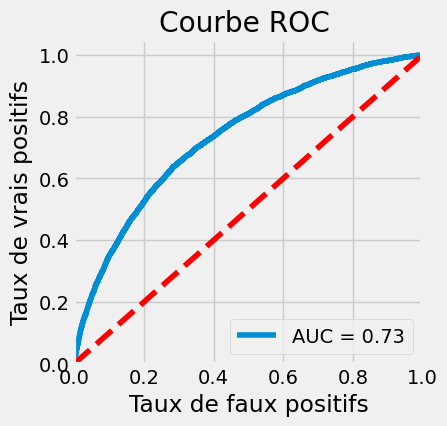

In [82]:
#import
from catboost import CatBoostClassifier

# define model
model5 = CatBoostClassifier()

#define params
params5 = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5],
}

CB_best , CB_results , CB_cm, CB_params = evaluate_model(model5,params5,X_train_xsmall,y_train_xsmall,X_test,y_test)

In [83]:
trackwithml(CB_results,CB_params,données,'no')

Model <catboost.core.CatBoostClassifier object at 0x00000146E04722B0> with data de base /balanced : no == DONE


In [84]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(données), CB_results[0][:200],CB_results[1],CB_results[2],CB_results[3]]
#affichage des résultats
resultats

Données                                             Modèle   recall  \
0  data de base          DummyClassifier(strategy='most_frequent')      0.0   
1  data de base          LogisticRegression(C=0.01, solver='saga')  0.00162   
2  data de base  DecisionTreeClassifier(max_depth=30, max_featu...  0.14387   
3  data de base  RandomForestClassifier(max_depth=5, max_featur...      0.0   
4  data de base  LGBMClassifier(max_depth=5, reg_alpha=0.316227...  0.01859   
5  data de base  <catboost.core.CatBoostClassifier object at 0x...     0.02   

  F1-score  AUC ROC  
0      0.0      0.5  
1  0.00322   0.7407  
2  0.14406  0.52321  
3      0.0  0.72387  
4  0.03566  0.73289  
5  0.03825  0.73465

# Test avec autre features
## poly_features

In [85]:
# Diviser les caractéristiques (X) et la variable cible (y)
Xpoly = poly_features.drop(['TARGET','SK_ID_CURR','1'], axis=1)
ypoly = poly_features['TARGET']

# Effectuer la division train/test
Xpoly_train, Xpoly_test, ypoly_train, ypoly_test = train_test_split(Xpoly, ypoly, test_size=0.2, random_state=42)

# Vérifier les tailles des ensembles de données
print("Taille de l'ensemble d'entraînement :", len(Xpoly_train))
print("Taille de l'ensemble de test :", len(Xpoly_test))

Taille de l'ensemble d'entraînement : 246008
Taille de l'ensemble de test : 61503


In [86]:
# Feature names
features = list(Xpoly_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(Xpoly_train)

# Transform both training and testing data
Xpoly_train = imputer.transform(Xpoly_train)
Xpoly_test = imputer.transform(Xpoly_test)

# Repeat with the scaler
scaler.fit(Xpoly_train)
Xpoly_train = scaler.transform(Xpoly_train)
Xpoly_test = scaler.transform(Xpoly_test)

print('Training data shape: ', Xpoly_train.shape)
print('Testing data shape: ', Xpoly_test.shape)

Training data shape:  (246008, 34)
Testing data shape:  (61503, 34)


In [87]:
# Diviser l'ensemble de données en un sous-ensemble plus petit pour l'entraînement et le test
Xpoly_train_xsmall, _, ypoly_train_xsmall, _ = train_test_split(Xpoly_train, ypoly_train, test_size=0.92, random_state=42)

# Afficher la taille du nouvel échantillon d'entraînement
print("Nouvelle taille de l'échantillon d'entraînement :", Xpoly_train_xsmall.shape)

Nouvelle taille de l'échantillon d'entraînement : (19680, 34)


Meilleurs hyperparamètres : {'C': 0.01, 'solver': 'saga'}
Recall : 0.0
F1-score : 0.0
AUC ROC : 0.7196104977779039
Matrice de confusion :
 [[56554     0]
 [ 4949     0]]


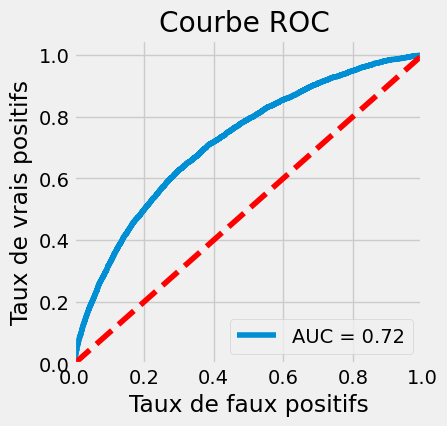

In [88]:
logregpoly_best,logregpoly_results,logregpoly_cm, logregpoly_params = evaluate_model(model2,params2,Xpoly_train_xsmall,ypoly_train_xsmall,Xpoly_test,ypoly_test)

In [89]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str('poly_features'), logregpoly_results[0][:200],logregpoly_results[1],logregpoly_results[2],logregpoly_results[3]]
#affichage des résultats
resultats

Données                                             Modèle   recall  \
0   data de base          DummyClassifier(strategy='most_frequent')      0.0   
1   data de base          LogisticRegression(C=0.01, solver='saga')  0.00162   
2   data de base  DecisionTreeClassifier(max_depth=30, max_featu...  0.14387   
3   data de base  RandomForestClassifier(max_depth=5, max_featur...      0.0   
4   data de base  LGBMClassifier(max_depth=5, reg_alpha=0.316227...  0.01859   
5   data de base  <catboost.core.CatBoostClassifier object at 0x...     0.02   
6  poly_features          LogisticRegression(C=0.01, solver='saga')      0.0   

  F1-score  AUC ROC  
0      0.0      0.5  
1  0.00322   0.7407  
2  0.14406  0.52321  
3      0.0  0.72387  
4  0.03566  0.73289  
5  0.03825  0.73465  
6      0.0  0.71961

In [91]:
trackwithml(logregpoly_results,logregpoly_params,'poly features only','no')

Model LogisticRegression(C=0.01, solver='saga') with poly features only /balanced : no == DONE


## data_domain

In [92]:
# Diviser les caractéristiques (X) et la variable cible (y)
Xdomain = data_domain.drop(['TARGET','SK_ID_CURR'], axis=1)
ydomain = data_domain['TARGET']

# Effectuer la division train/test
Xdomain_train, Xdomain_test, ydomain_train, ydomain_test = train_test_split(Xdomain, ydomain, test_size=0.2, random_state=42)

# Vérifier les tailles des ensembles de données
print("Taille de l'ensemble d'entraînement :", len(Xdomain_train))
print("Taille de l'ensemble de test :", len(Xdomain_test))

Taille de l'ensemble d'entraînement : 246008
Taille de l'ensemble de test : 61503


In [93]:
# Feature names
features = list(Xdomain_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(Xdomain_train)

# Transform both training and testing data
Xdomain_train = imputer.transform(Xdomain_train)
Xdomain_test = imputer.transform(Xdomain_test)

# Repeat with the scaler
scaler.fit(Xdomain_train)
Xdomain_train = scaler.transform(Xdomain_train)
Xdomain_test = scaler.transform(Xdomain_test)

print('Training data shape: ', Xdomain_train.shape)
print('Testing data shape: ', Xdomain_test.shape)

Training data shape:  (246008, 245)
Testing data shape:  (61503, 245)


In [94]:
# Diviser l'ensemble de données en un sous-ensemble plus petit pour l'entraînement et le test
Xdomain_train_xsmall, _, ydomain_train_xsmall, _ = train_test_split(Xdomain_train, ydomain_train, test_size=0.92, random_state=42)

# Afficher la taille du nouvel échantillon d'entraînement
print("Nouvelle taille de l'échantillon d'entraînement :", Xdomain_train_xsmall.shape)

Nouvelle taille de l'échantillon d'entraînement : (19680, 245)


Meilleurs hyperparamètres : {'C': 0.01, 'solver': 'saga'}
Recall : 0.0
F1-score : 0.0
AUC ROC : 0.7283708081368316
Matrice de confusion :
 [[56554     0]
 [ 4949     0]]


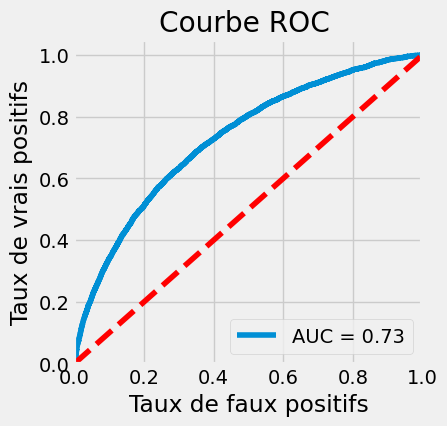

In [95]:
logregdomain_best,logregdomain_results,logregdomain_cm, logregdomain_params = evaluate_model(model2,params2,Xdomain_train_xsmall,ydomain_train_xsmall,Xdomain_test,ydomain_test)

In [96]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str('data_domain'), logregdomain_results[0][:200],logregdomain_results[1],logregdomain_results[2],logregdomain_results[3]]
#affichage des résultats
resultats

Données                                             Modèle   recall  \
0   data de base          DummyClassifier(strategy='most_frequent')      0.0   
1   data de base          LogisticRegression(C=0.01, solver='saga')  0.00162   
2   data de base  DecisionTreeClassifier(max_depth=30, max_featu...  0.14387   
3   data de base  RandomForestClassifier(max_depth=5, max_featur...      0.0   
4   data de base  LGBMClassifier(max_depth=5, reg_alpha=0.316227...  0.01859   
5   data de base  <catboost.core.CatBoostClassifier object at 0x...     0.02   
6  poly_features          LogisticRegression(C=0.01, solver='saga')      0.0   
7    data_domain          LogisticRegression(C=0.01, solver='saga')      0.0   

  F1-score  AUC ROC  
0      0.0      0.5  
1  0.00322   0.7407  
2  0.14406  0.52321  
3      0.0  0.72387  
4  0.03566  0.73289  
5  0.03825  0.73465  
6      0.0  0.71961  
7      0.0  0.72837

In [97]:
trackwithml(logregdomain_results,logregdomain_params,'data de base et domain','no')

Model LogisticRegression(C=0.01, solver='saga') with data de base et domain /balanced : no == DONE
